In [60]:
from rdkit import Chem
from rdkit.Chem import Draw
import os.path
import os
import glob
import numpy as np
import pandas as pd
import PIL
from random import sample
import csv
import pubchempy as pcp
import matplotlib.pyplot as plt
import bokeh
from itertools import chain
%matplotlib inline
from rdkit.Chem.SaltRemover import SaltRemover

from sklearn import preprocessing 
from sklearn.compose import make_column_transformer
import warnings
warnings.filterwarnings("ignore")
from rdkit import RDLogger                                                                                                                                                               
RDLogger.DisableLog('rdApp.*')

In [26]:
# change working directory to PubChem
os.chdir("/home/amna/PubChem")

# Data Preparation

### Read Data

In [27]:
# read all data into a dictionary
tables_list=glob.glob("*txt")
CID_dict = {}
cidslist = []
for table in tables_list:
    tableID = table.replace('.txt','')
    tableID = tableID.replace('../data/','')
    CID_dict[tableID] = []
    with open(table) as inf:
        for aline in inf.readlines():
            if aline.startswith('CID')==True:
                CID_dict[tableID].append(aline.replace('\n','').replace('CID: ',''))

['reproductivecontrol.txt', 'gastrointestinal.txt', 'hematologic.txt', 'antineoplastic.txt', 'dermatologic.txt', 'lipidregulating.txt', 'urological.txt', 'cns.txt', 'cardio.txt', 'antiinfective.txt', 'respiratorysystem.txt', 'antiinflammatory.txt']


In [28]:
activities = list(CID_dict.keys())

In [53]:
# total molecules in each class 

total_molecules = 0
for k in CID_dict:
  print("{:<25} {:<15}".format(k,len(CID_dict[k])))
  total_molecules+=len(CID_dict[k]) 
print("--------------------------------")
print("{:<25} {:<15}".format("Total Molecules",total_molecules))


reproductivecontrol       265            
gastrointestinal          631            
hematologic               555            
antineoplastic            1876           
dermatologic              257            
lipidregulating           233            
urological                73             
cns                       2034           
cardio                    1673           
antiinfective             3404           
respiratorysystem         398            
antiinflammatory          662            
--------------------------------
Total Molecules           12061          


### Get SMILES for CIDs

In [54]:
# get SMILES for CIDs

# keep smiles with length <400

smiles_dict = {}

for key in CID_dict.keys():
    smiles_dict[key] = []
    prop_dict = pcp.get_properties('IsomericSMILES', CID_dict[key])
    for i in range(0, len(prop_dict)):
        if len(prop_dict[i]['IsomericSMILES'])<400:
            smiles_dict[key].append(prop_dict[i]['IsomericSMILES'])


In [56]:
# total molecules in each class after removing len>400

total_molecules = 0
for k in smiles_dict:
  print("{:<25} {:<15}".format(k,len(smiles_dict[k])))
  total_molecules+=len(smiles_dict[k]) 
print("--------------------------------")
print("{:<25} {:<15}".format("Total Molecules",total_molecules))

reproductivecontrol       264            
gastrointestinal          619            
hematologic               540            
antineoplastic            1867           
dermatologic              257            
lipidregulating           228            
urological                73             
cns                       2025           
cardio                    1636           
antiinfective             3367           
respiratorysystem         396            
antiinflammatory          656            
--------------------------------
Total Molecules           11928          


### Remove Overlapping Smiles

In [57]:
# make a list of all smiles that overlap among the classes
rm = []
for key1 in smiles_dict.keys():
    for key2 in smiles_dict.keys(): 
        if key1 != key2: 
            rm.append(list(set(smiles_dict[key1]) & set(smiles_dict[key2])))
new_rm = [item for sublist in rm for item in sublist]

In [58]:
# Remove overlapping molecules and check there is no longer overlap

print("{:<25} {:<15} {:<10}".format("Activity", "Old Length", "New Length"))
print("-----------------------------------------------------")
nsmilesd = {}
for key in smiles_dict.keys():
    nsmilesd[key] = list(set(smiles_dict[key])-set(new_rm))
    print("{:<25} {:<15} {:<10}".format(key,str(len(nsmilesd[key])),str(len(set(smiles_dict[key])))))
    

Activity                  Old Length      New Length
-----------------------------------------------------
reproductivecontrol       165             264       
gastrointestinal          321             616       
hematologic               315             535       
antineoplastic            1325            1858      
dermatologic              133             252       
lipidregulating           176             225       
urological                49              73        
cns                       1501            2023      
cardio                    1039            1635      
antiinfective             2790            3364      
respiratorysystem         144             396       
antiinflammatory          412             652       


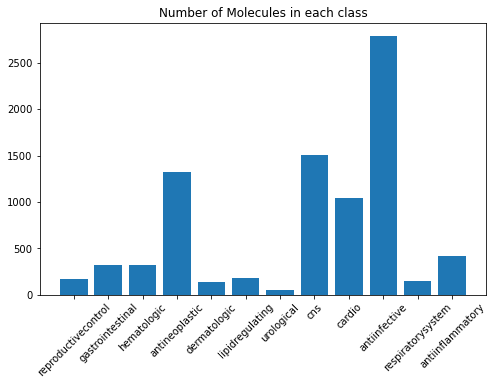

In [80]:
smiles_dict = nsmilesd
keys = list(smiles_dict.keys())
counts = list(len(v) for v in smiles_dict.values())
plt.figure(figsize=[8, 5])
plt.bar(keys, counts)
plt.xticks(rotation=45)
plt.title('Number of Molecules in each class')
plt.show()


In [37]:
# Remove salts

#os.chdir('/home/jgmeyer2/drugclass/data/SMILES/')

remover = SaltRemover()
cln_smiles_dict = {}

for key in smiles_dict.keys():
    tmplist = []
    for smiles in smiles_dict[key]:
        tmplist.append(Chem.MolToSmiles(remover(Chem.MolFromSmiles(smiles))))
    cln_smiles_dict[key] = list(set(tmplist))

In [81]:
# total molecules in each class after removing salts

total_molecules = 0
for k in cln_smiles_dict:
  print("{:<25} {:<15}".format(k,len(cln_smiles_dict[k])))
  total_molecules+=len(cln_smiles_dict[k]) 
print("--------------------------------")
print("{:<25} {:<15}".format("Total Molecules",total_molecules))



reproductivecontrol       148            
gastrointestinal          263            
hematologic               268            
antineoplastic            1177           
dermatologic              116            
lipidregulating           164            
urological                29             
cns                       1153           
cardio                    797            
antiinfective             2415           
respiratorysystem         101            
antiinflammatory          374            
--------------------------------
Total Molecules           7005           


### Transform Data using One Hot Encoding

In [82]:
ohe = preprocessing.OneHotEncoder()
transformed = ohe.fit_transform(df[['Class']])
df[ohe.categories_[0]] = transformed.toarray()

In [86]:
df.head(10)

,Smiles,Class,antiinfective,antiinflammatory,antineoplastic,cardio,cns,dermatologic,gastrointestinal,hematologic,lipidregulating,reproductivecontrol,respiratorysystem,urological
0,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@@H]4...,reproductivecontrol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3C=...,reproductivecontrol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,CCOc1ccc(C[C@H]2NC(=O)CCSSC[C@@H](C(=O)N3CCC[C...,reproductivecontrol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,CCCCC[C@](C)(O)/C=C/[C@H]1[C@H](O)C[C@H](O)[C@...,reproductivecontrol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,C#C[C@@]1(OC(C)=O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC...,reproductivecontrol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,O=C([O-])CCC/C=C\CC1C(O)CC(O)C1/C=C/C(O)COc1cc...,reproductivecontrol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,C=C1C[C@H]2[C@@H]3CCC4=CC(=O)CC[C@@H]4[C@H]3CC...,reproductivecontrol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H...,reproductivecontrol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3C=...,reproductivecontrol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,O=C([O-])CCCC=CCC1C(O)CC(O)C1C=CC(O)COc1cccc(C...,reproductivecontrol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Training Models

For training the models, we have used [lazy-qsar](https://github.com/ersilia-os/lazy-qsar) Library

### Training Morgan Binary Classifier for Single Activity

In [90]:
from sklearn.model_selection import StratifiedShuffleSplit
import lazyqsar as lq
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
import numpy as np

In [91]:
X = df['Smiles'].values.tolist()

y = df['antiinfective'].values.tolist()

In [96]:

split = StratifiedShuffleSplit(n_splits=5, test_size=0.20, random_state=0)
split.get_n_splits(X, y)
model = lq.MorganBinaryClassifier()
scores = np.array([])
count = 0
for train_index, test_index in split.split(X, y):
    count+=1
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, y_train = [X[i] for i in train_index] , [y[i] for i in train_index]
    X_test,  y_test  = [X[i] for i in test_index] , [y[i] for i in test_index]
    model.fit(X_train, y_train)
    
    # validate
    y_hat = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_hat)
    print("AUROC for fold: " + str(count) , "  ", auc(fpr, tpr))
    scores = np.append(scores, auc(fpr, tpr))
    
print("Mean Score: ",np.mean(scores))  

TRAIN: [4031  890  336 ...  638 2102 3617] TEST: [4386 5111 6579 ... 6653   99   12]


[flaml.automl: 10-17 02:15:58] {2600} INFO - task = classification
[flaml.automl: 10-17 02:15:58] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 02:15:58] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 02:15:59] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 02:15:59] {2869} INFO - List of ML learners in AutoML Run: ['rf']
[flaml.automl: 10-17 02:15:59] {3174} INFO - iteration 0, current learner rf
[flaml.automl: 10-17 02:15:59] {3307} INFO - Estimated sufficient time budget=1793s. Estimated necessary time budget=2s.
[flaml.automl: 10-17 02:15:59] {3354} INFO -  at 0.5s,	estimator rf's best error=0.2486,	best estimator rf's best error=0.2486
[flaml.automl: 10-17 02:15:59] {3174} INFO - iteration 1, current learner rf
[flaml.automl: 10-17 02:15:59] {3354} INFO -  at 0.7s,	estimator rf's best error=0.2486,	best estimator rf's best error=0.2486
[flaml.automl: 10-17 02:15:59] {3174} INFO - iteration 2, current learner rf
[flaml.automl

AUROC for fold: 1    0.9493294902502063
TRAIN: [6028  323 1070 ... 4527 4499 2352] TEST: [4490 2479 4241 ...  220  820 2101]


[flaml.automl: 10-17 02:16:24] {2600} INFO - task = classification
[flaml.automl: 10-17 02:16:24] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 02:16:24] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 02:16:24] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 02:16:24] {2869} INFO - List of ML learners in AutoML Run: ['rf']
[flaml.automl: 10-17 02:16:24] {3174} INFO - iteration 0, current learner rf
[flaml.automl: 10-17 02:16:25] {3307} INFO - Estimated sufficient time budget=1709s. Estimated necessary time budget=2s.
[flaml.automl: 10-17 02:16:25] {3354} INFO -  at 0.5s,	estimator rf's best error=0.2943,	best estimator rf's best error=0.2943
[flaml.automl: 10-17 02:16:25] {3174} INFO - iteration 1, current learner rf
[flaml.automl: 10-17 02:16:25] {3354} INFO -  at 0.8s,	estimator rf's best error=0.2289,	best estimator rf's best error=0.2289
[flaml.automl: 10-17 02:16:25] {3174} INFO - iteration 2, current learner rf
[flaml.automl

AUROC for fold: 2    0.9662061281839629
TRAIN: [3812 6536 4049 ... 5582 4249 5192] TEST: [2923 4145 5766 ... 1457 6505 2353]


[flaml.automl: 10-17 02:16:54] {2600} INFO - task = classification
[flaml.automl: 10-17 02:16:54] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 02:16:54] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 02:16:54] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 02:16:54] {2869} INFO - List of ML learners in AutoML Run: ['rf']
[flaml.automl: 10-17 02:16:54] {3174} INFO - iteration 0, current learner rf
[flaml.automl: 10-17 02:16:54] {3307} INFO - Estimated sufficient time budget=1791s. Estimated necessary time budget=2s.
[flaml.automl: 10-17 02:16:54] {3354} INFO -  at 0.4s,	estimator rf's best error=0.2636,	best estimator rf's best error=0.2636
[flaml.automl: 10-17 02:16:54] {3174} INFO - iteration 1, current learner rf
[flaml.automl: 10-17 02:16:54] {3354} INFO -  at 0.6s,	estimator rf's best error=0.2195,	best estimator rf's best error=0.2195
[flaml.automl: 10-17 02:16:54] {3174} INFO - iteration 2, current learner rf
[flaml.automl

AUROC for fold: 3    0.969951104435333
TRAIN: [3060  311 6512 ... 6824 4589 5174] TEST: [3683 4484 2548 ... 2662  632 2957]


[flaml.automl: 10-17 02:17:27] {2600} INFO - task = classification
[flaml.automl: 10-17 02:17:27] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 02:17:27] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 02:17:28] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 02:17:28] {2869} INFO - List of ML learners in AutoML Run: ['rf']
[flaml.automl: 10-17 02:17:28] {3174} INFO - iteration 0, current learner rf
[flaml.automl: 10-17 02:17:28] {3307} INFO - Estimated sufficient time budget=1602s. Estimated necessary time budget=2s.
[flaml.automl: 10-17 02:17:28] {3354} INFO -  at 0.4s,	estimator rf's best error=0.3166,	best estimator rf's best error=0.3166
[flaml.automl: 10-17 02:17:28] {3174} INFO - iteration 1, current learner rf
[flaml.automl: 10-17 02:17:28] {3354} INFO -  at 0.5s,	estimator rf's best error=0.2279,	best estimator rf's best error=0.2279
[flaml.automl: 10-17 02:17:28] {3174} INFO - iteration 2, current learner rf
[flaml.automl

AUROC for fold: 4    0.9630599421733266
TRAIN: [6959 6190  272 ... 1648 6044 1148] TEST: [ 945  619 6241 ... 5210 5435 2620]


[flaml.automl: 10-17 02:17:52] {2600} INFO - task = classification
[flaml.automl: 10-17 02:17:52] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 02:17:52] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 02:17:52] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 02:17:52] {2869} INFO - List of ML learners in AutoML Run: ['rf']
[flaml.automl: 10-17 02:17:52] {3174} INFO - iteration 0, current learner rf
[flaml.automl: 10-17 02:17:52] {3307} INFO - Estimated sufficient time budget=2098s. Estimated necessary time budget=2s.
[flaml.automl: 10-17 02:17:52] {3354} INFO -  at 0.4s,	estimator rf's best error=0.2625,	best estimator rf's best error=0.2625
[flaml.automl: 10-17 02:17:52] {3174} INFO - iteration 1, current learner rf
[flaml.automl: 10-17 02:17:53] {3354} INFO -  at 0.7s,	estimator rf's best error=0.2080,	best estimator rf's best error=0.2080
[flaml.automl: 10-17 02:17:53] {3174} INFO - iteration 2, current learner rf
[flaml.automl

AUROC for fold: 5    0.9599182668236377
Mean Score:  0.9616929863732933



### Save and Load Model 

In [95]:
import joblib

model.save("antiinfective.joblib")
m1 = joblib.load("antiinfective.joblib")
y_hat = m1.predict_proba(["CCN(CC)CCOc1ccc(C(=C(Cl)c2ccccc2)c2ccccc2)cc1"])
y_hat

array([[0.91083271, 0.08916729]])

## Training Models for all activities

In [97]:
path = os.getcwd()
model_dir = os.path.join(path,"models")
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [99]:
result_table ={}
X = df['Smiles'].values.tolist()

for activity in activities:
    
    y = df[activity].values.tolist()
    split = StratifiedShuffleSplit(n_splits=5, test_size=0.20, random_state=0)
    split.get_n_splits(X, y)
    model = lq.MorganBinaryClassifier(time_budget_sec=300, estimator_list=None)
    scores = np.array([])
    count = 0
    
    for train_index, test_index in split.split(X, y):
        
        count+=1
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, y_train = [X[i] for i in train_index] , [y[i] for i in train_index]
        X_test,  y_test  = [X[i] for i in test_index] , [y[i] for i in test_index]
        model.fit(X_train, y_train)
    
        # validate
        y_hat = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_hat)
        print("AUROC for fold ",count ," : ", auc(fpr, tpr))
        scores = np.append(scores, auc(fpr, tpr))    
        
    scores = np.append(scores, np.mean(scores))   
    result_table[activity]=scores
    
    # Re-fit model on all data
    model.fit(X, y)
    # Save model
    model_path = os.path.join(model_dir, activity+'.joblib')
    model.save(model_path)
    print("Model saved at : ",model_path)
    
    

TRAIN: [2994 6677  159 ... 1863 2320 4452] TEST: [5967 4465 2651 ... 1658 1548 6188]


[flaml.automl: 10-17 02:22:49] {2600} INFO - task = classification
[flaml.automl: 10-17 02:22:49] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 02:22:49] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 02:22:50] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 02:22:50] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 02:22:50] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 02:22:50] {3307} INFO - Estimated sufficient time budget=5759s. Estimated necessary time budget=133s.
[flaml.automl: 10-17 02:22:50] {3354} INFO -  at 1.0s,	estimator lgbm's best error=0.1254,	best estimator lgbm's best error=0.1254
[flaml.automl: 10-17 02:22:50] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 02:22:51] {3354} INFO -  at 1.7s,	estimator lgbm's best error=0.1254,	best estimator lgbm's best error=0.1254
[flaml.automl: 10

[flaml.automl: 10-17 02:23:15] {3174} INFO - iteration 36, current learner xgboost
[flaml.automl: 10-17 02:23:16] {3354} INFO -  at 26.3s,	estimator xgboost's best error=0.0074,	best estimator lgbm's best error=0.0008
[flaml.automl: 10-17 02:23:16] {3174} INFO - iteration 37, current learner lgbm
[flaml.automl: 10-17 02:23:16] {3354} INFO -  at 26.9s,	estimator lgbm's best error=0.0008,	best estimator lgbm's best error=0.0008
[flaml.automl: 10-17 02:23:16] {3174} INFO - iteration 38, current learner xgboost
[flaml.automl: 10-17 02:23:17] {3354} INFO -  at 27.8s,	estimator xgboost's best error=0.0074,	best estimator lgbm's best error=0.0008
[flaml.automl: 10-17 02:23:17] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 02:23:18] {3354} INFO -  at 28.7s,	estimator lgbm's best error=0.0008,	best estimator lgbm's best error=0.0008
[flaml.automl: 10-17 02:23:18] {3174} INFO - iteration 40, current learner xgboost
[flaml.automl: 10-17 02:23:20] {3354} INFO -  at 30.2s,	e

[flaml.automl: 10-17 02:23:44] {3354} INFO -  at 54.6s,	estimator xgboost's best error=0.0004,	best estimator lgbm's best error=0.0004
[flaml.automl: 10-17 02:23:44] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 02:23:45] {3354} INFO -  at 55.2s,	estimator lgbm's best error=0.0003,	best estimator lgbm's best error=0.0003
[flaml.automl: 10-17 02:23:45] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 02:23:45] {3354} INFO -  at 55.8s,	estimator lgbm's best error=0.0003,	best estimator lgbm's best error=0.0003
[flaml.automl: 10-17 02:23:45] {3174} INFO - iteration 77, current learner rf
[flaml.automl: 10-17 02:23:46] {3354} INFO -  at 56.8s,	estimator rf's best error=0.0115,	best estimator lgbm's best error=0.0003
[flaml.automl: 10-17 02:23:46] {3174} INFO - iteration 78, current learner lgbm
[flaml.automl: 10-17 02:23:47] {3354} INFO -  at 57.7s,	estimator lgbm's best error=0.0003,	best estimator lgbm's best error=0.0003
[flaml.automl: 10-17 

[flaml.automl: 10-17 02:24:19] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 02:24:19] {3354} INFO -  at 89.5s,	estimator extra_tree's best error=0.0844,	best estimator lgbm's best error=0.0003
[flaml.automl: 10-17 02:24:19] {3174} INFO - iteration 114, current learner rf
[flaml.automl: 10-17 02:24:21] {3354} INFO -  at 91.3s,	estimator rf's best error=0.0008,	best estimator lgbm's best error=0.0003
[flaml.automl: 10-17 02:24:21] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 02:24:22] {3354} INFO -  at 92.6s,	estimator lgbm's best error=0.0003,	best estimator lgbm's best error=0.0003
[flaml.automl: 10-17 02:24:22] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl: 10-17 02:24:22] {3354} INFO -  at 93.0s,	estimator extra_tree's best error=0.0844,	best estimator lgbm's best error=0.0003
[flaml.automl: 10-17 02:24:22] {3174} INFO - iteration 117, current learner extra_tree
[flaml.automl: 10-17 02:24:23] {3354} INF

[flaml.automl: 10-17 02:24:54] {3354} INFO -  at 125.0s,	estimator rf's best error=0.0008,	best estimator lgbm's best error=0.0003
[flaml.automl: 10-17 02:24:54] {3174} INFO - iteration 151, current learner extra_tree
[flaml.automl: 10-17 02:24:55] {3354} INFO -  at 125.9s,	estimator extra_tree's best error=0.0003,	best estimator lgbm's best error=0.0003
[flaml.automl: 10-17 02:24:55] {3174} INFO - iteration 152, current learner xgboost
[flaml.automl: 10-17 02:24:56] {3354} INFO -  at 126.4s,	estimator xgboost's best error=0.0004,	best estimator lgbm's best error=0.0003
[flaml.automl: 10-17 02:24:56] {3174} INFO - iteration 153, current learner lgbm
[flaml.automl: 10-17 02:24:56] {3354} INFO -  at 127.0s,	estimator lgbm's best error=0.0003,	best estimator lgbm's best error=0.0003
[flaml.automl: 10-17 02:24:56] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 02:24:58] {3354} INFO -  at 128.7s,	estimator lgbm's best error=0.0003,	best estimator lgbm's best error=0.

[flaml.automl: 10-17 02:25:43] {3174} INFO - iteration 187, current learner rf
[flaml.automl: 10-17 02:25:45] {3354} INFO -  at 175.3s,	estimator rf's best error=0.0008,	best estimator extra_tree's best error=0.0001
[flaml.automl: 10-17 02:25:45] {3174} INFO - iteration 188, current learner rf
[flaml.automl: 10-17 02:25:47] {3354} INFO -  at 177.5s,	estimator rf's best error=0.0000,	best estimator rf's best error=0.0000
[flaml.automl: 10-17 02:25:47] {3174} INFO - iteration 189, current learner extra_tree
[flaml.automl: 10-17 02:25:48] {3354} INFO -  at 178.3s,	estimator extra_tree's best error=0.0001,	best estimator rf's best error=0.0000
[flaml.automl: 10-17 02:25:48] {3174} INFO - iteration 190, current learner rf
[flaml.automl: 10-17 02:25:48] {3354} INFO -  at 178.9s,	estimator rf's best error=0.0000,	best estimator rf's best error=0.0000
[flaml.automl: 10-17 02:25:48] {3174} INFO - iteration 191, current learner xgboost
[flaml.automl: 10-17 02:25:49] {3354} INFO -  at 179.6s,	est

[flaml.automl: 10-17 02:26:33] {3174} INFO - iteration 225, current learner rf
[flaml.automl: 10-17 02:26:34] {3354} INFO -  at 224.3s,	estimator rf's best error=0.0000,	best estimator rf's best error=0.0000
[flaml.automl: 10-17 02:26:34] {3174} INFO - iteration 226, current learner rf
[flaml.automl: 10-17 02:26:36] {3354} INFO -  at 226.5s,	estimator rf's best error=0.0000,	best estimator rf's best error=0.0000
[flaml.automl: 10-17 02:26:36] {3174} INFO - iteration 227, current learner extra_tree
[flaml.automl: 10-17 02:26:38] {3354} INFO -  at 228.5s,	estimator extra_tree's best error=0.0000,	best estimator rf's best error=0.0000
[flaml.automl: 10-17 02:26:38] {3174} INFO - iteration 228, current learner rf
[flaml.automl: 10-17 02:26:39] {3354} INFO -  at 229.9s,	estimator rf's best error=0.0000,	best estimator rf's best error=0.0000
[flaml.automl: 10-17 02:26:39] {3174} INFO - iteration 229, current learner extra_tree
[flaml.automl: 10-17 02:26:41] {3354} INFO -  at 231.8s,	estimato

AUROC for fold  1  :  0.9728665207877462
TRAIN: [6163  395    1 ... 5460 2562 3323] TEST: [5676 3742 5374 ... 2393   48 3060]


[flaml.automl: 10-17 02:28:03] {2600} INFO - task = classification
[flaml.automl: 10-17 02:28:03] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 02:28:03] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 02:28:03] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 02:28:03] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 02:28:03] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 02:28:04] {3307} INFO - Estimated sufficient time budget=6290s. Estimated necessary time budget=145s.
[flaml.automl: 10-17 02:28:04] {3354} INFO -  at 1.2s,	estimator lgbm's best error=0.0920,	best estimator lgbm's best error=0.0920
[flaml.automl: 10-17 02:28:04] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 02:28:05] {3354} INFO -  at 1.8s,	estimator lgbm's best error=0.0920,	best estimator lgbm's best error=0.0920
[flaml.automl: 10

[flaml.automl: 10-17 02:28:24] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 02:28:26] {3354} INFO -  at 22.9s,	estimator extra_tree's best error=0.0003,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:28:26] {3174} INFO - iteration 37, current learner xgboost
[flaml.automl: 10-17 02:28:26] {3354} INFO -  at 23.6s,	estimator xgboost's best error=0.0862,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:28:26] {3174} INFO - iteration 38, current learner extra_tree
[flaml.automl: 10-17 02:28:27] {3354} INFO -  at 23.9s,	estimator extra_tree's best error=0.0003,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:28:27] {3174} INFO - iteration 39, current learner rf
[flaml.automl: 10-17 02:28:27] {3354} INFO -  at 24.2s,	estimator rf's best error=0.0476,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:28:27] {3174} INFO - iteration 40, current learner extra_tree
[flaml.automl: 10-17 02:28:29] {3354} IN

[flaml.automl: 10-17 02:28:56] {3354} INFO -  at 53.6s,	estimator extra_tree's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:28:56] {3174} INFO - iteration 75, current learner rf
[flaml.automl: 10-17 02:28:57] {3354} INFO -  at 54.1s,	estimator rf's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:28:57] {3174} INFO - iteration 76, current learner rf
[flaml.automl: 10-17 02:28:57] {3354} INFO -  at 54.5s,	estimator rf's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:28:57] {3174} INFO - iteration 77, current learner rf
[flaml.automl: 10-17 02:28:58] {3354} INFO -  at 54.7s,	estimator rf's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:28:58] {3174} INFO - iteration 78, current learner rf
[flaml.automl: 10-17 02:28:58] {3354} INFO -  at 55.4s,	estimator rf's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:28:58]

[flaml.automl: 10-17 02:29:22] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 02:29:23] {3354} INFO -  at 80.3s,	estimator extra_tree's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:29:23] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 02:29:24] {3354} INFO -  at 81.2s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:29:24] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 02:29:25] {3354} INFO -  at 81.9s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:29:25] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl: 10-17 02:29:26] {3354} INFO -  at 82.7s,	estimator extra_tree's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:29:26] {3174} INFO - iteration 117, current learner rf
[flaml.automl: 10-17 02:29:26] {3354} INFO - 

[flaml.automl: 10-17 02:29:51] {3354} INFO -  at 108.0s,	estimator rf's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:29:51] {3174} INFO - iteration 152, current learner rf
[flaml.automl: 10-17 02:29:51] {3354} INFO -  at 108.4s,	estimator rf's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:29:51] {3174} INFO - iteration 153, current learner lgbm
[flaml.automl: 10-17 02:29:54] {3354} INFO -  at 110.8s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:29:54] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 02:29:55] {3354} INFO -  at 112.5s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:29:55] {3174} INFO - iteration 155, current learner extra_tree
[flaml.automl: 10-17 02:29:56] {3354} INFO -  at 113.0s,	estimator extra_tree's best error=0.0000,	best estimator lgbm's best error=0.0000
[flam

[flaml.automl: 10-17 02:30:16] {3174} INFO - iteration 190, current learner lgbm
[flaml.automl: 10-17 02:30:17] {3354} INFO -  at 133.7s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:30:17] {3174} INFO - iteration 191, current learner rf
[flaml.automl: 10-17 02:30:17] {3354} INFO -  at 133.9s,	estimator rf's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:30:17] {3174} INFO - iteration 192, current learner rf
[flaml.automl: 10-17 02:30:17] {3354} INFO -  at 134.1s,	estimator rf's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:30:17] {3174} INFO - iteration 193, current learner extra_tree
[flaml.automl: 10-17 02:30:17] {3354} INFO -  at 134.5s,	estimator extra_tree's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:30:17] {3174} INFO - iteration 194, current learner rf
[flaml.automl: 10-17 02:30:18] {3354} INFO -  at 135.0s,	esti

[flaml.automl: 10-17 02:30:38] {3174} INFO - iteration 228, current learner rf
[flaml.automl: 10-17 02:30:39] {3354} INFO -  at 155.8s,	estimator rf's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:30:39] {3174} INFO - iteration 229, current learner extra_tree
[flaml.automl: 10-17 02:30:39] {3354} INFO -  at 156.3s,	estimator extra_tree's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:30:39] {3174} INFO - iteration 230, current learner rf
[flaml.automl: 10-17 02:30:40] {3354} INFO -  at 156.8s,	estimator rf's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:30:40] {3174} INFO - iteration 231, current learner extra_tree
[flaml.automl: 10-17 02:30:40] {3354} INFO -  at 157.4s,	estimator extra_tree's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:30:40] {3174} INFO - iteration 232, current learner extra_tree
[flaml.automl: 10-17 02:30:41] {3354} INF

[flaml.automl: 10-17 02:30:58] {3174} INFO - iteration 266, current learner extra_tree
[flaml.automl: 10-17 02:30:58] {3354} INFO -  at 174.9s,	estimator extra_tree's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:30:58] {3174} INFO - iteration 267, current learner extra_tree
[flaml.automl: 10-17 02:30:58] {3354} INFO -  at 175.4s,	estimator extra_tree's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:30:58] {3174} INFO - iteration 268, current learner extra_tree
[flaml.automl: 10-17 02:30:59] {3354} INFO -  at 176.1s,	estimator extra_tree's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:30:59] {3174} INFO - iteration 269, current learner rf
[flaml.automl: 10-17 02:30:59] {3354} INFO -  at 176.3s,	estimator rf's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:30:59] {3174} INFO - iteration 270, current learner rf
[flaml.automl: 10-17 02:31:00] {3

[flaml.automl: 10-17 02:31:27] {3174} INFO - iteration 304, current learner rf
[flaml.automl: 10-17 02:31:27] {3354} INFO -  at 204.1s,	estimator rf's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:31:27] {3174} INFO - iteration 305, current learner xgb_limitdepth
[flaml.automl: 10-17 02:31:30] {3354} INFO -  at 207.3s,	estimator xgb_limitdepth's best error=0.0001,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:31:30] {3174} INFO - iteration 306, current learner xgb_limitdepth
[flaml.automl: 10-17 02:31:34] {3354} INFO -  at 210.7s,	estimator xgb_limitdepth's best error=0.0001,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:31:34] {3174} INFO - iteration 307, current learner xgb_limitdepth
[flaml.automl: 10-17 02:31:35] {3354} INFO -  at 212.4s,	estimator xgb_limitdepth's best error=0.0001,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:31:35] {3174} INFO - iteration 308, current learner xgb_limitdep

[flaml.automl: 10-17 02:32:19] {3174} INFO - iteration 341, current learner xgboost
[flaml.automl: 10-17 02:32:20] {3354} INFO -  at 257.1s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:32:20] {3174} INFO - iteration 342, current learner xgb_limitdepth
[flaml.automl: 10-17 02:32:22] {3354} INFO -  at 259.2s,	estimator xgb_limitdepth's best error=0.0001,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:32:22] {3174} INFO - iteration 343, current learner xgb_limitdepth
[flaml.automl: 10-17 02:32:28] {3354} INFO -  at 264.7s,	estimator xgb_limitdepth's best error=0.0001,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:32:28] {3174} INFO - iteration 344, current learner xgboost
[flaml.automl: 10-17 02:32:28] {3354} INFO -  at 265.6s,	estimator xgboost's best error=0.0007,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 02:32:29] {3174} INFO - iteration 345, current learner xgb_limitdepth
[

AUROC for fold  2  :  0.9314369073668854
TRAIN: [5958 5017 3747 ... 2254 2778 4397] TEST: [1737 1504 2923 ... 1214 6348 5505]


[flaml.automl: 10-17 02:33:31] {2600} INFO - task = classification
[flaml.automl: 10-17 02:33:31] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 02:33:31] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 02:33:32] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 02:33:32] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 02:33:32] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 02:33:33] {3307} INFO - Estimated sufficient time budget=5364s. Estimated necessary time budget=124s.
[flaml.automl: 10-17 02:33:33] {3354} INFO -  at 1.3s,	estimator lgbm's best error=0.2223,	best estimator lgbm's best error=0.2223
[flaml.automl: 10-17 02:33:33] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 02:33:33] {3354} INFO -  at 1.8s,	estimator lgbm's best error=0.2223,	best estimator lgbm's best error=0.2223
[flaml.automl: 10

[flaml.automl: 10-17 02:33:48] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 02:33:49] {3354} INFO -  at 17.1s,	estimator extra_tree's best error=0.0564,	best estimator lgbm's best error=0.0162
[flaml.automl: 10-17 02:33:49] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 02:33:49] {3354} INFO -  at 17.3s,	estimator rf's best error=0.0552,	best estimator lgbm's best error=0.0162
[flaml.automl: 10-17 02:33:49] {3174} INFO - iteration 38, current learner xgboost
[flaml.automl: 10-17 02:33:49] {3354} INFO -  at 18.0s,	estimator xgboost's best error=0.0952,	best estimator lgbm's best error=0.0162
[flaml.automl: 10-17 02:33:49] {3174} INFO - iteration 39, current learner rf
[flaml.automl: 10-17 02:33:50] {3354} INFO -  at 18.3s,	estimator rf's best error=0.0552,	best estimator lgbm's best error=0.0162
[flaml.automl: 10-17 02:33:50] {3174} INFO - iteration 40, current learner xgboost
[flaml.automl: 10-17 02:33:50] {3354} INFO -  at 18.9s,	est

[flaml.automl: 10-17 02:34:10] {3354} INFO -  at 38.5s,	estimator xgboost's best error=0.0345,	best estimator lgbm's best error=0.0157
[flaml.automl: 10-17 02:34:10] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 02:34:11] {3354} INFO -  at 39.2s,	estimator lgbm's best error=0.0157,	best estimator lgbm's best error=0.0157
[flaml.automl: 10-17 02:34:11] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 02:34:12] {3354} INFO -  at 40.2s,	estimator lgbm's best error=0.0157,	best estimator lgbm's best error=0.0157
[flaml.automl: 10-17 02:34:12] {3174} INFO - iteration 77, current learner rf
[flaml.automl: 10-17 02:34:12] {3354} INFO -  at 40.9s,	estimator rf's best error=0.0552,	best estimator lgbm's best error=0.0157
[flaml.automl: 10-17 02:34:12] {3174} INFO - iteration 78, current learner lgbm
[flaml.automl: 10-17 02:34:13] {3354} INFO -  at 41.5s,	estimator lgbm's best error=0.0157,	best estimator lgbm's best error=0.0157
[flaml.automl: 10-17 

[flaml.automl: 10-17 02:34:37] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 02:34:38] {3354} INFO -  at 66.2s,	estimator extra_tree's best error=0.0497,	best estimator lgbm's best error=0.0092
[flaml.automl: 10-17 02:34:38] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 02:34:38] {3354} INFO -  at 66.7s,	estimator lgbm's best error=0.0092,	best estimator lgbm's best error=0.0092
[flaml.automl: 10-17 02:34:38] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 02:34:39] {3354} INFO -  at 67.5s,	estimator lgbm's best error=0.0092,	best estimator lgbm's best error=0.0092
[flaml.automl: 10-17 02:34:39] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl: 10-17 02:34:39] {3354} INFO -  at 68.1s,	estimator extra_tree's best error=0.0497,	best estimator lgbm's best error=0.0092
[flaml.automl: 10-17 02:34:39] {3174} INFO - iteration 117, current learner rf
[flaml.automl: 10-17 02:34:40] {3354} INFO - 

[flaml.automl: 10-17 02:35:10] {3354} INFO -  at 98.6s,	estimator rf's best error=0.0435,	best estimator lgbm's best error=0.0092
[flaml.automl: 10-17 02:35:10] {3174} INFO - iteration 152, current learner lgbm
[flaml.automl: 10-17 02:35:11] {3354} INFO -  at 99.3s,	estimator lgbm's best error=0.0092,	best estimator lgbm's best error=0.0092
[flaml.automl: 10-17 02:35:11] {3174} INFO - iteration 153, current learner lgbm
[flaml.automl: 10-17 02:35:12] {3354} INFO -  at 100.1s,	estimator lgbm's best error=0.0091,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 02:35:12] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 02:35:13] {3354} INFO -  at 101.9s,	estimator lgbm's best error=0.0091,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 02:35:13] {3174} INFO - iteration 155, current learner extra_tree
[flaml.automl: 10-17 02:35:14] {3354} INFO -  at 103.0s,	estimator extra_tree's best error=0.0201,	best estimator lgbm's best error=0.0091
[fl

[flaml.automl: 10-17 02:35:47] {3174} INFO - iteration 189, current learner extra_tree
[flaml.automl: 10-17 02:35:47] {3354} INFO -  at 135.9s,	estimator extra_tree's best error=0.0201,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 02:35:47] {3174} INFO - iteration 190, current learner lgbm
[flaml.automl: 10-17 02:35:48] {3354} INFO -  at 136.7s,	estimator lgbm's best error=0.0091,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 02:35:48] {3174} INFO - iteration 191, current learner extra_tree
[flaml.automl: 10-17 02:35:49] {3354} INFO -  at 137.9s,	estimator extra_tree's best error=0.0201,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 02:35:49] {3174} INFO - iteration 192, current learner xgboost
[flaml.automl: 10-17 02:35:51] {3354} INFO -  at 139.7s,	estimator xgboost's best error=0.0345,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 02:35:51] {3174} INFO - iteration 193, current learner extra_tree
[flaml.automl: 10-17 02:35:

[flaml.automl: 10-17 02:36:26] {3354} INFO -  at 174.7s,	estimator lgbm's best error=0.0091,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 02:36:26] {3174} INFO - iteration 227, current learner extra_tree
[flaml.automl: 10-17 02:36:26] {3354} INFO -  at 175.0s,	estimator extra_tree's best error=0.0201,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 02:36:26] {3174} INFO - iteration 228, current learner xgboost
[flaml.automl: 10-17 02:36:27] {3354} INFO -  at 175.8s,	estimator xgboost's best error=0.0205,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 02:36:27] {3174} INFO - iteration 229, current learner extra_tree
[flaml.automl: 10-17 02:36:28] {3354} INFO -  at 177.0s,	estimator extra_tree's best error=0.0201,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 02:36:28] {3174} INFO - iteration 230, current learner xgboost
[flaml.automl: 10-17 02:36:31] {3354} INFO -  at 179.6s,	estimator xgboost's best error=0.0205,	best estimator 

[flaml.automl: 10-17 02:37:05] {3174} INFO - iteration 264, current learner extra_tree
[flaml.automl: 10-17 02:37:05] {3354} INFO -  at 214.1s,	estimator extra_tree's best error=0.0201,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 02:37:05] {3174} INFO - iteration 265, current learner extra_tree
[flaml.automl: 10-17 02:37:06] {3354} INFO -  at 215.1s,	estimator extra_tree's best error=0.0201,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 02:37:07] {3174} INFO - iteration 266, current learner extra_tree
[flaml.automl: 10-17 02:37:07] {3354} INFO -  at 215.3s,	estimator extra_tree's best error=0.0201,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 02:37:07] {3174} INFO - iteration 267, current learner extra_tree
[flaml.automl: 10-17 02:37:07] {3354} INFO -  at 216.1s,	estimator extra_tree's best error=0.0201,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 02:37:07] {3174} INFO - iteration 268, current learner extra_tree
[flaml.au

[flaml.automl: 10-17 02:38:13] {3174} INFO - iteration 301, current learner rf
[flaml.automl: 10-17 02:38:14] {3354} INFO -  at 282.2s,	estimator rf's best error=0.0375,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 02:38:14] {3174} INFO - iteration 302, current learner lgbm
[flaml.automl: 10-17 02:38:14] {3354} INFO -  at 282.8s,	estimator lgbm's best error=0.0091,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 02:38:14] {3174} INFO - iteration 303, current learner xgb_limitdepth
[flaml.automl: 10-17 02:38:21] {3354} INFO -  at 290.1s,	estimator xgb_limitdepth's best error=0.0222,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 02:38:21] {3174} INFO - iteration 304, current learner lgbm
[flaml.automl: 10-17 02:38:22] {3354} INFO -  at 290.7s,	estimator lgbm's best error=0.0091,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 02:38:22] {3174} INFO - iteration 305, current learner extra_tree
[flaml.automl: 10-17 02:38:23] {3354} INF

AUROC for fold  3  :  0.9927303671286166
TRAIN: [4821 6139 3950 ... 3201 6639  431] TEST: [6081 1989 4971 ... 5093 6002  943]


[flaml.automl: 10-17 02:38:56] {2600} INFO - task = classification
[flaml.automl: 10-17 02:38:56] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 02:38:56] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 02:38:56] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 02:38:56] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 02:38:56] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 02:38:57] {3307} INFO - Estimated sufficient time budget=5190s. Estimated necessary time budget=120s.
[flaml.automl: 10-17 02:38:57] {3354} INFO -  at 1.0s,	estimator lgbm's best error=0.0989,	best estimator lgbm's best error=0.0989
[flaml.automl: 10-17 02:38:57] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 02:38:57] {3354} INFO -  at 1.5s,	estimator lgbm's best error=0.0989,	best estimator lgbm's best error=0.0989
[flaml.automl: 10

[flaml.automl: 10-17 02:39:14] {3354} INFO -  at 18.8s,	estimator extra_tree's best error=0.0957,	best estimator lgbm's best error=0.0007
[flaml.automl: 10-17 02:39:14] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 02:39:15] {3354} INFO -  at 19.4s,	estimator rf's best error=0.0017,	best estimator lgbm's best error=0.0007
[flaml.automl: 10-17 02:39:15] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 02:39:15] {3354} INFO -  at 19.8s,	estimator rf's best error=0.0011,	best estimator lgbm's best error=0.0007
[flaml.automl: 10-17 02:39:15] {3174} INFO - iteration 39, current learner rf
[flaml.automl: 10-17 02:39:16] {3354} INFO -  at 20.4s,	estimator rf's best error=0.0010,	best estimator lgbm's best error=0.0007
[flaml.automl: 10-17 02:39:16] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 02:39:16] {3354} INFO -  at 20.6s,	estimator rf's best error=0.0010,	best estimator lgbm's best error=0.0007
[flaml.automl: 10-17 02:39:16]

[flaml.automl: 10-17 02:39:39] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 02:39:40] {3354} INFO -  at 44.5s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 10-17 02:39:40] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 02:39:42] {3354} INFO -  at 46.5s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 10-17 02:39:42] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 02:39:43] {3354} INFO -  at 47.0s,	estimator extra_tree's best error=0.0014,	best estimator lgbm's best error=0.0007
[flaml.automl: 10-17 02:39:43] {3174} INFO - iteration 78, current learner lgbm
[flaml.automl: 10-17 02:39:43] {3354} INFO -  at 47.5s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 10-17 02:39:43] {3174} INFO - iteration 79, current learner lgbm
[flaml.automl: 10-17 02:39:44] {3354} INFO -  at 48.5s,	esti

[flaml.automl: 10-17 02:40:36] {3354} INFO -  at 100.6s,	estimator extra_tree's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 10-17 02:40:36] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 02:40:39] {3354} INFO -  at 103.3s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 10-17 02:40:39] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 02:40:41] {3354} INFO -  at 105.5s,	estimator lgbm's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 10-17 02:40:41] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl: 10-17 02:40:43] {3354} INFO -  at 107.2s,	estimator extra_tree's best error=0.0007,	best estimator lgbm's best error=0.0007
[flaml.automl: 10-17 02:40:43] {3174} INFO - iteration 117, current learner extra_tree
[flaml.automl: 10-17 02:40:46] {3354} INFO -  at 110.1s,	estimator extra_tree's best error=0.0006,	best estimator extra_

[flaml.automl: 10-17 02:42:21] {3174} INFO - iteration 150, current learner rf
[flaml.automl: 10-17 02:42:21] {3354} INFO -  at 205.7s,	estimator rf's best error=0.0008,	best estimator extra_tree's best error=0.0006
[flaml.automl: 10-17 02:42:21] {3174} INFO - iteration 151, current learner rf
[flaml.automl: 10-17 02:42:22] {3354} INFO -  at 206.6s,	estimator rf's best error=0.0008,	best estimator extra_tree's best error=0.0006
[flaml.automl: 10-17 02:42:22] {3174} INFO - iteration 152, current learner extra_tree
[flaml.automl: 10-17 02:42:23] {3354} INFO -  at 207.6s,	estimator extra_tree's best error=0.0006,	best estimator extra_tree's best error=0.0006
[flaml.automl: 10-17 02:42:23] {3174} INFO - iteration 153, current learner extra_tree
[flaml.automl: 10-17 02:42:25] {3354} INFO -  at 209.6s,	estimator extra_tree's best error=0.0006,	best estimator extra_tree's best error=0.0006
[flaml.automl: 10-17 02:42:25] {3174} INFO - iteration 154, current learner rf
[flaml.automl: 10-17 02:4

[flaml.automl: 10-17 02:43:45] {3354} INFO -  at 289.0s,	estimator xgboost's best error=0.0046,	best estimator extra_tree's best error=0.0006
[flaml.automl: 10-17 02:43:45] {3174} INFO - iteration 187, current learner xgboost
[flaml.automl: 10-17 02:43:46] {3354} INFO -  at 289.9s,	estimator xgboost's best error=0.0046,	best estimator extra_tree's best error=0.0006
[flaml.automl: 10-17 02:43:46] {3174} INFO - iteration 188, current learner xgboost
[flaml.automl: 10-17 02:43:46] {3354} INFO -  at 290.5s,	estimator xgboost's best error=0.0046,	best estimator extra_tree's best error=0.0006
[flaml.automl: 10-17 02:43:46] {3174} INFO - iteration 189, current learner xgboost
[flaml.automl: 10-17 02:43:47] {3354} INFO -  at 291.2s,	estimator xgboost's best error=0.0010,	best estimator extra_tree's best error=0.0006
[flaml.automl: 10-17 02:43:47] {3174} INFO - iteration 190, current learner xgboost
[flaml.automl: 10-17 02:43:48] {3354} INFO -  at 291.9s,	estimator xgboost's best error=0.0010,	

AUROC for fold  4  :  0.9018964259664479
TRAIN: [3338   77 3092 ... 1474 2354 2146] TEST: [2066 1711 1836 ... 1064 6816  745]


[flaml.automl: 10-17 02:44:06] {2600} INFO - task = classification
[flaml.automl: 10-17 02:44:06] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 02:44:06] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 02:44:06] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 02:44:06] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 02:44:06] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 02:44:06] {3307} INFO - Estimated sufficient time budget=4276s. Estimated necessary time budget=99s.
[flaml.automl: 10-17 02:44:06] {3354} INFO -  at 0.7s,	estimator lgbm's best error=0.1728,	best estimator lgbm's best error=0.1728
[flaml.automl: 10-17 02:44:06] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 02:44:07] {3354} INFO -  at 1.1s,	estimator lgbm's best error=0.1404,	best estimator lgbm's best error=0.1404
[flaml.automl: 10-

[flaml.automl: 10-17 02:44:21] {3174} INFO - iteration 35, current learner extra_tree
[flaml.automl: 10-17 02:44:23] {3354} INFO -  at 17.0s,	estimator extra_tree's best error=0.0555,	best estimator extra_tree's best error=0.0555
[flaml.automl: 10-17 02:44:23] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 02:44:24] {3354} INFO -  at 18.0s,	estimator extra_tree's best error=0.0555,	best estimator extra_tree's best error=0.0555
[flaml.automl: 10-17 02:44:24] {3174} INFO - iteration 37, current learner extra_tree
[flaml.automl: 10-17 02:44:24] {3354} INFO -  at 18.7s,	estimator extra_tree's best error=0.0555,	best estimator extra_tree's best error=0.0555
[flaml.automl: 10-17 02:44:24] {3174} INFO - iteration 38, current learner extra_tree
[flaml.automl: 10-17 02:44:25] {3354} INFO -  at 19.2s,	estimator extra_tree's best error=0.0555,	best estimator extra_tree's best error=0.0555
[flaml.automl: 10-17 02:44:25] {3174} INFO - iteration 39, current learner rf
[f

[flaml.automl: 10-17 02:44:47] {3354} INFO -  at 41.6s,	estimator extra_tree's best error=0.0555,	best estimator extra_tree's best error=0.0555
[flaml.automl: 10-17 02:44:47] {3174} INFO - iteration 73, current learner xgboost
[flaml.automl: 10-17 02:44:48] {3354} INFO -  at 42.1s,	estimator xgboost's best error=0.0778,	best estimator extra_tree's best error=0.0555
[flaml.automl: 10-17 02:44:48] {3174} INFO - iteration 74, current learner extra_tree
[flaml.automl: 10-17 02:44:49] {3354} INFO -  at 42.7s,	estimator extra_tree's best error=0.0555,	best estimator extra_tree's best error=0.0555
[flaml.automl: 10-17 02:44:49] {3174} INFO - iteration 75, current learner rf
[flaml.automl: 10-17 02:44:49] {3354} INFO -  at 43.4s,	estimator rf's best error=0.0757,	best estimator extra_tree's best error=0.0555
[flaml.automl: 10-17 02:44:49] {3174} INFO - iteration 76, current learner rf
[flaml.automl: 10-17 02:44:50] {3354} INFO -  at 43.7s,	estimator rf's best error=0.0757,	best estimator extra

[flaml.automl: 10-17 02:45:19] {3354} INFO -  at 72.9s,	estimator xgboost's best error=0.0623,	best estimator extra_tree's best error=0.0555
[flaml.automl: 10-17 02:45:19] {3174} INFO - iteration 110, current learner lgbm
[flaml.automl: 10-17 02:45:19] {3354} INFO -  at 73.4s,	estimator lgbm's best error=0.0937,	best estimator extra_tree's best error=0.0555
[flaml.automl: 10-17 02:45:19] {3174} INFO - iteration 111, current learner extra_tree
[flaml.automl: 10-17 02:45:20] {3354} INFO -  at 74.3s,	estimator extra_tree's best error=0.0555,	best estimator extra_tree's best error=0.0555
[flaml.automl: 10-17 02:45:20] {3174} INFO - iteration 112, current learner extra_tree
[flaml.automl: 10-17 02:45:22] {3354} INFO -  at 75.7s,	estimator extra_tree's best error=0.0555,	best estimator extra_tree's best error=0.0555
[flaml.automl: 10-17 02:45:22] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 02:45:22] {3354} INFO -  at 76.2s,	estimator extra_tree's best error=0

[flaml.automl: 10-17 02:46:21] {3174} INFO - iteration 145, current learner extra_tree
[flaml.automl: 10-17 02:46:21] {3354} INFO -  at 135.5s,	estimator extra_tree's best error=0.0555,	best estimator extra_tree's best error=0.0555
[flaml.automl: 10-17 02:46:21] {3174} INFO - iteration 146, current learner lgbm
[flaml.automl: 10-17 02:46:22] {3354} INFO -  at 136.1s,	estimator lgbm's best error=0.0937,	best estimator extra_tree's best error=0.0555
[flaml.automl: 10-17 02:46:22] {3174} INFO - iteration 147, current learner lgbm
[flaml.automl: 10-17 02:46:22] {3354} INFO -  at 136.5s,	estimator lgbm's best error=0.0937,	best estimator extra_tree's best error=0.0555
[flaml.automl: 10-17 02:46:22] {3174} INFO - iteration 148, current learner lgbm
[flaml.automl: 10-17 02:46:23] {3354} INFO -  at 137.0s,	estimator lgbm's best error=0.0937,	best estimator extra_tree's best error=0.0555
[flaml.automl: 10-17 02:46:23] {3174} INFO - iteration 149, current learner lgbm
[flaml.automl: 10-17 02:46:

[flaml.automl: 10-17 02:47:16] {3354} INFO -  at 190.1s,	estimator extra_tree's best error=0.0555,	best estimator extra_tree's best error=0.0555
[flaml.automl: 10-17 02:47:16] {3174} INFO - iteration 182, current learner lgbm
[flaml.automl: 10-17 02:47:16] {3354} INFO -  at 190.6s,	estimator lgbm's best error=0.0738,	best estimator extra_tree's best error=0.0555
[flaml.automl: 10-17 02:47:16] {3174} INFO - iteration 183, current learner lgbm
[flaml.automl: 10-17 02:47:17] {3354} INFO -  at 191.2s,	estimator lgbm's best error=0.0738,	best estimator extra_tree's best error=0.0555
[flaml.automl: 10-17 02:47:17] {3174} INFO - iteration 184, current learner lgbm
[flaml.automl: 10-17 02:47:17] {3354} INFO -  at 191.6s,	estimator lgbm's best error=0.0738,	best estimator extra_tree's best error=0.0555
[flaml.automl: 10-17 02:47:17] {3174} INFO - iteration 185, current learner extra_tree
[flaml.automl: 10-17 02:47:19] {3354} INFO -  at 192.9s,	estimator extra_tree's best error=0.0555,	best esti

[flaml.automl: 10-17 02:48:13] {3354} INFO -  at 247.5s,	estimator lgbm's best error=0.0738,	best estimator extra_tree's best error=0.0555
[flaml.automl: 10-17 02:48:13] {3174} INFO - iteration 218, current learner lgbm
[flaml.automl: 10-17 02:48:14] {3354} INFO -  at 247.9s,	estimator lgbm's best error=0.0738,	best estimator extra_tree's best error=0.0555
[flaml.automl: 10-17 02:48:14] {3174} INFO - iteration 219, current learner lgbm
[flaml.automl: 10-17 02:48:14] {3354} INFO -  at 248.4s,	estimator lgbm's best error=0.0738,	best estimator extra_tree's best error=0.0555
[flaml.automl: 10-17 02:48:14] {3174} INFO - iteration 220, current learner xgboost
[flaml.automl: 10-17 02:48:19] {3354} INFO -  at 253.0s,	estimator xgboost's best error=0.0623,	best estimator extra_tree's best error=0.0555
[flaml.automl: 10-17 02:48:19] {3174} INFO - iteration 221, current learner lgbm
[flaml.automl: 10-17 02:48:19] {3354} INFO -  at 253.5s,	estimator lgbm's best error=0.0738,	best estimator extra_

[flaml.automl: 10-17 02:49:39] {3618} INFO - retrain lrl1 for 15.2s
[flaml.automl: 10-17 02:49:39] {3625} INFO - retrained model: LogisticRegression(n_jobs=-1, penalty='l1', solver='saga')
[flaml.automl: 10-17 02:49:39] {2900} INFO - fit succeeded
[flaml.automl: 10-17 02:49:39] {2901} INFO - Time taken to find the best model: 317.84883427619934
[flaml.automl: 10-17 02:49:39] {2912} WARNING - Time taken to find the best model is 106% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.


AUROC for fold  5  :  0.9774495502066619


[flaml.automl: 10-17 02:49:58] {2600} INFO - task = classification
[flaml.automl: 10-17 02:49:58] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 02:49:58] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 02:49:59] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 02:49:59] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 02:49:59] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 02:50:00] {3307} INFO - Estimated sufficient time budget=7016s. Estimated necessary time budget=162s.
[flaml.automl: 10-17 02:50:00] {3354} INFO -  at 1.5s,	estimator lgbm's best error=0.0833,	best estimator lgbm's best error=0.0833
[flaml.automl: 10-17 02:50:00] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 02:50:00] {3354} INFO -  at 2.0s,	estimator lgbm's best error=0.0833,	best estimator lgbm's best error=0.0833
[flaml.automl: 10

[flaml.automl: 10-17 02:50:13] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 02:50:13] {3354} INFO -  at 15.2s,	estimator extra_tree's best error=0.0640,	best estimator lgbm's best error=0.0039
[flaml.automl: 10-17 02:50:13] {3174} INFO - iteration 37, current learner lgbm
[flaml.automl: 10-17 02:50:14] {3354} INFO -  at 15.6s,	estimator lgbm's best error=0.0039,	best estimator lgbm's best error=0.0039
[flaml.automl: 10-17 02:50:14] {3174} INFO - iteration 38, current learner lgbm
[flaml.automl: 10-17 02:50:14] {3354} INFO -  at 16.1s,	estimator lgbm's best error=0.0039,	best estimator lgbm's best error=0.0039
[flaml.automl: 10-17 02:50:14] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 02:50:15] {3354} INFO -  at 16.6s,	estimator lgbm's best error=0.0039,	best estimator lgbm's best error=0.0039
[flaml.automl: 10-17 02:50:15] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 02:50:15] {3354} INFO -  at 17.1s,	estima

[flaml.automl: 10-17 02:50:37] {3354} INFO -  at 38.6s,	estimator xgboost's best error=0.0026,	best estimator xgboost's best error=0.0026
[flaml.automl: 10-17 02:50:37] {3174} INFO - iteration 75, current learner rf
[flaml.automl: 10-17 02:50:37] {3354} INFO -  at 39.2s,	estimator rf's best error=0.0094,	best estimator xgboost's best error=0.0026
[flaml.automl: 10-17 02:50:37] {3174} INFO - iteration 76, current learner rf
[flaml.automl: 10-17 02:50:38] {3354} INFO -  at 39.8s,	estimator rf's best error=0.0085,	best estimator xgboost's best error=0.0026
[flaml.automl: 10-17 02:50:38] {3174} INFO - iteration 77, current learner xgboost
[flaml.automl: 10-17 02:50:39] {3354} INFO -  at 40.6s,	estimator xgboost's best error=0.0026,	best estimator xgboost's best error=0.0026
[flaml.automl: 10-17 02:50:39] {3174} INFO - iteration 78, current learner xgboost
[flaml.automl: 10-17 02:50:40] {3354} INFO -  at 41.3s,	estimator xgboost's best error=0.0026,	best estimator xgboost's best error=0.002

[flaml.automl: 10-17 02:51:11] {3174} INFO - iteration 112, current learner xgboost
[flaml.automl: 10-17 02:51:12] {3354} INFO -  at 74.0s,	estimator xgboost's best error=0.0026,	best estimator xgboost's best error=0.0026
[flaml.automl: 10-17 02:51:12] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 02:51:14] {3354} INFO -  at 75.9s,	estimator extra_tree's best error=0.0067,	best estimator xgboost's best error=0.0026
[flaml.automl: 10-17 02:51:14] {3174} INFO - iteration 114, current learner extra_tree
[flaml.automl: 10-17 02:51:16] {3354} INFO -  at 77.5s,	estimator extra_tree's best error=0.0067,	best estimator xgboost's best error=0.0026
[flaml.automl: 10-17 02:51:16] {3174} INFO - iteration 115, current learner xgboost
[flaml.automl: 10-17 02:51:17] {3354} INFO -  at 78.4s,	estimator xgboost's best error=0.0026,	best estimator xgboost's best error=0.0026
[flaml.automl: 10-17 02:51:17] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl

[flaml.automl: 10-17 02:52:14] {3354} INFO -  at 135.9s,	estimator rf's best error=0.0037,	best estimator xgboost's best error=0.0023
[flaml.automl: 10-17 02:52:14] {3174} INFO - iteration 150, current learner xgboost
[flaml.automl: 10-17 02:52:16] {3354} INFO -  at 138.0s,	estimator xgboost's best error=0.0023,	best estimator xgboost's best error=0.0023
[flaml.automl: 10-17 02:52:16] {3174} INFO - iteration 151, current learner xgboost
[flaml.automl: 10-17 02:52:17] {3354} INFO -  at 138.9s,	estimator xgboost's best error=0.0023,	best estimator xgboost's best error=0.0023
[flaml.automl: 10-17 02:52:17] {3174} INFO - iteration 152, current learner xgboost
[flaml.automl: 10-17 02:52:18] {3354} INFO -  at 139.7s,	estimator xgboost's best error=0.0023,	best estimator xgboost's best error=0.0023
[flaml.automl: 10-17 02:52:18] {3174} INFO - iteration 153, current learner lgbm
[flaml.automl: 10-17 02:52:18] {3354} INFO -  at 140.2s,	estimator lgbm's best error=0.0035,	best estimator xgboost'

[flaml.automl: 10-17 02:53:16] {3354} INFO -  at 197.6s,	estimator xgboost's best error=0.0023,	best estimator xgboost's best error=0.0023
[flaml.automl: 10-17 02:53:16] {3174} INFO - iteration 187, current learner rf
[flaml.automl: 10-17 02:53:22] {3354} INFO -  at 203.4s,	estimator rf's best error=0.0037,	best estimator xgboost's best error=0.0023
[flaml.automl: 10-17 02:53:22] {3174} INFO - iteration 188, current learner xgboost
[flaml.automl: 10-17 02:53:23] {3354} INFO -  at 204.6s,	estimator xgboost's best error=0.0023,	best estimator xgboost's best error=0.0023
[flaml.automl: 10-17 02:53:23] {3174} INFO - iteration 189, current learner xgboost
[flaml.automl: 10-17 02:53:24] {3354} INFO -  at 205.5s,	estimator xgboost's best error=0.0023,	best estimator xgboost's best error=0.0023
[flaml.automl: 10-17 02:53:24] {3174} INFO - iteration 190, current learner xgboost
[flaml.automl: 10-17 02:53:25] {3354} INFO -  at 207.0s,	estimator xgboost's best error=0.0023,	best estimator xgboost

[flaml.automl: 10-17 02:55:21] {2900} INFO - fit succeeded
[flaml.automl: 10-17 02:55:21] {2901} INFO - Time taken to find the best model: 120.59975004196167


Model saved at :  /home/amna/PubChem/models/reproductivecontrol.joblib
TRAIN: [6316 2379 1091 ...   82 4896   98] TEST: [1908 3167 1944 ... 4682 2717 1442]


[flaml.automl: 10-17 02:55:27] {2600} INFO - task = classification
[flaml.automl: 10-17 02:55:27] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 02:55:27] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 02:55:27] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 02:55:27] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 02:55:27] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 02:55:27] {3307} INFO - Estimated sufficient time budget=5184s. Estimated necessary time budget=119s.
[flaml.automl: 10-17 02:55:27] {3354} INFO -  at 0.7s,	estimator lgbm's best error=0.3013,	best estimator lgbm's best error=0.3013
[flaml.automl: 10-17 02:55:27] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 02:55:28] {3354} INFO -  at 1.2s,	estimator lgbm's best error=0.3013,	best estimator lgbm's best error=0.3013
[flaml.automl: 10

[flaml.automl: 10-17 02:55:43] {3174} INFO - iteration 36, current learner xgboost
[flaml.automl: 10-17 02:55:43] {3354} INFO -  at 16.6s,	estimator xgboost's best error=0.1882,	best estimator lgbm's best error=0.0192
[flaml.automl: 10-17 02:55:43] {3174} INFO - iteration 37, current learner lgbm
[flaml.automl: 10-17 02:55:44] {3354} INFO -  at 17.2s,	estimator lgbm's best error=0.0133,	best estimator lgbm's best error=0.0133
[flaml.automl: 10-17 02:55:44] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 02:55:44] {3354} INFO -  at 17.4s,	estimator rf's best error=0.1842,	best estimator lgbm's best error=0.0133
[flaml.automl: 10-17 02:55:44] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 02:55:44] {3354} INFO -  at 17.9s,	estimator lgbm's best error=0.0133,	best estimator lgbm's best error=0.0133
[flaml.automl: 10-17 02:55:44] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 02:55:45] {3354} INFO -  at 18.1s,	estimator rf's b

[flaml.automl: 10-17 02:56:06] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 02:56:06] {3354} INFO -  at 39.7s,	estimator lgbm's best error=0.0116,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 02:56:06] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 02:56:07] {3354} INFO -  at 40.2s,	estimator lgbm's best error=0.0116,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 02:56:07] {3174} INFO - iteration 77, current learner xgboost
[flaml.automl: 10-17 02:56:07] {3354} INFO -  at 40.8s,	estimator xgboost's best error=0.1489,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 02:56:07] {3174} INFO - iteration 78, current learner lgbm
[flaml.automl: 10-17 02:56:08] {3354} INFO -  at 41.6s,	estimator lgbm's best error=0.0116,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 02:56:08] {3174} INFO - iteration 79, current learner lgbm
[flaml.automl: 10-17 02:56:09] {3354} INFO -  at 42.4s,	estimator 

[flaml.automl: 10-17 02:56:50] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 02:56:53] {3354} INFO -  at 86.0s,	estimator extra_tree's best error=0.0403,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 02:56:53] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 02:56:53] {3354} INFO -  at 86.7s,	estimator lgbm's best error=0.0116,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 02:56:53] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 02:56:54] {3354} INFO -  at 87.3s,	estimator lgbm's best error=0.0116,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 02:56:54] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl: 10-17 02:56:56] {3354} INFO -  at 89.5s,	estimator extra_tree's best error=0.0403,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 02:56:56] {3174} INFO - iteration 117, current learner lgbm
[flaml.automl: 10-17 02:56:57] {3354} INFO 

[flaml.automl: 10-17 02:57:41] {3174} INFO - iteration 151, current learner xgboost
[flaml.automl: 10-17 02:57:43] {3354} INFO -  at 136.5s,	estimator xgboost's best error=0.0381,	best estimator lgbm's best error=0.0115
[flaml.automl: 10-17 02:57:43] {3174} INFO - iteration 152, current learner lgbm
[flaml.automl: 10-17 02:57:45] {3354} INFO -  at 138.6s,	estimator lgbm's best error=0.0115,	best estimator lgbm's best error=0.0115
[flaml.automl: 10-17 02:57:45] {3174} INFO - iteration 153, current learner lgbm
[flaml.automl: 10-17 02:57:46] {3354} INFO -  at 139.3s,	estimator lgbm's best error=0.0115,	best estimator lgbm's best error=0.0115
[flaml.automl: 10-17 02:57:46] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 02:57:47] {3354} INFO -  at 140.1s,	estimator lgbm's best error=0.0115,	best estimator lgbm's best error=0.0115
[flaml.automl: 10-17 02:57:47] {3174} INFO - iteration 155, current learner extra_tree
[flaml.automl: 10-17 02:57:49] {3354} INFO -  at 14

[flaml.automl: 10-17 02:58:58] {3354} INFO -  at 211.5s,	estimator xgboost's best error=0.0381,	best estimator lgbm's best error=0.0113
[flaml.automl: 10-17 02:58:58] {3174} INFO - iteration 190, current learner lgbm
[flaml.automl: 10-17 02:59:00] {3354} INFO -  at 213.0s,	estimator lgbm's best error=0.0113,	best estimator lgbm's best error=0.0113
[flaml.automl: 10-17 02:59:00] {3174} INFO - iteration 191, current learner lgbm
[flaml.automl: 10-17 02:59:01] {3354} INFO -  at 214.1s,	estimator lgbm's best error=0.0113,	best estimator lgbm's best error=0.0113
[flaml.automl: 10-17 02:59:01] {3174} INFO - iteration 192, current learner lgbm
[flaml.automl: 10-17 02:59:02] {3354} INFO -  at 215.9s,	estimator lgbm's best error=0.0113,	best estimator lgbm's best error=0.0113
[flaml.automl: 10-17 02:59:02] {3174} INFO - iteration 193, current learner xgb_limitdepth
[flaml.automl: 10-17 02:59:06] {3354} INFO -  at 219.2s,	estimator xgb_limitdepth's best error=0.0457,	best estimator lgbm's best e

[flaml.automl: 10-17 03:00:26] {3354} INFO -  at 299.4s,	estimator lgbm's best error=0.0107,	best estimator lgbm's best error=0.0107
[flaml.automl: 10-17 03:00:26] {3174} INFO - iteration 227, current learner lrl1
[flaml.automl: 10-17 03:00:45] {3354} INFO -  at 318.7s,	estimator lrl1's best error=0.0789,	best estimator lgbm's best error=0.0107
[flaml.automl: 10-17 03:00:47] {3618} INFO - retrain lgbm for 2.0s
[flaml.automl: 10-17 03:00:47] {3625} INFO - retrained model: LGBMClassifier(colsample_bytree=0.5726201982602606,
               learning_rate=0.1530203197058873, max_bin=31,
               min_child_samples=6, n_estimators=48, num_leaves=73,
               reg_alpha=0.007615062852826596, reg_lambda=0.03408107303779609,
               verbose=-1)
[flaml.automl: 10-17 03:00:47] {2900} INFO - fit succeeded
[flaml.automl: 10-17 03:00:47] {2901} INFO - Time taken to find the best model: 287.7733747959137
[flaml.automl: 10-17 03:00:47] {2912} WARNING - Time taken to find the best mode

AUROC for fold  1  :  0.9838404904540619
TRAIN: [2391 3198  260 ... 2772 1297 6544] TEST: [2389 5792 5256 ... 6377 6954 4185]


[flaml.automl: 10-17 03:00:54] {2600} INFO - task = classification
[flaml.automl: 10-17 03:00:54] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 03:00:54] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 03:00:54] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 03:00:54] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 03:00:54] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 03:00:54] {3307} INFO - Estimated sufficient time budget=5095s. Estimated necessary time budget=117s.
[flaml.automl: 10-17 03:00:54] {3354} INFO -  at 0.6s,	estimator lgbm's best error=0.3317,	best estimator lgbm's best error=0.3317
[flaml.automl: 10-17 03:00:54] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 03:00:55] {3354} INFO -  at 1.2s,	estimator lgbm's best error=0.3317,	best estimator lgbm's best error=0.3317
[flaml.automl: 10

[flaml.automl: 10-17 03:01:14] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 03:01:15] {3354} INFO -  at 20.9s,	estimator extra_tree's best error=0.2894,	best estimator lgbm's best error=0.0586
[flaml.automl: 10-17 03:01:15] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 03:01:15] {3354} INFO -  at 21.3s,	estimator rf's best error=0.2290,	best estimator lgbm's best error=0.0586
[flaml.automl: 10-17 03:01:15] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 03:01:16] {3354} INFO -  at 21.8s,	estimator rf's best error=0.2290,	best estimator lgbm's best error=0.0586
[flaml.automl: 10-17 03:01:16] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 03:01:17] {3354} INFO -  at 23.4s,	estimator lgbm's best error=0.0586,	best estimator lgbm's best error=0.0586
[flaml.automl: 10-17 03:01:17] {3174} INFO - iteration 40, current learner xgboost
[flaml.automl: 10-17 03:01:18] {3354} INFO -  at 24.0s,	estimator

[flaml.automl: 10-17 03:01:53] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 03:01:53] {3354} INFO -  at 59.7s,	estimator lgbm's best error=0.0425,	best estimator lgbm's best error=0.0425
[flaml.automl: 10-17 03:01:53] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 03:01:55] {3354} INFO -  at 60.9s,	estimator lgbm's best error=0.0425,	best estimator lgbm's best error=0.0425
[flaml.automl: 10-17 03:01:55] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 03:01:55] {3354} INFO -  at 61.6s,	estimator extra_tree's best error=0.1864,	best estimator lgbm's best error=0.0425
[flaml.automl: 10-17 03:01:55] {3174} INFO - iteration 78, current learner lgbm
[flaml.automl: 10-17 03:01:56] {3354} INFO -  at 62.4s,	estimator lgbm's best error=0.0425,	best estimator lgbm's best error=0.0425
[flaml.automl: 10-17 03:01:56] {3174} INFO - iteration 79, current learner lgbm
[flaml.automl: 10-17 03:01:57] {3354} INFO -  at 62.9s,	esti

[flaml.automl: 10-17 03:02:37] {3354} INFO -  at 103.6s,	estimator extra_tree's best error=0.1038,	best estimator lgbm's best error=0.0425
[flaml.automl: 10-17 03:02:37] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 03:02:38] {3354} INFO -  at 104.6s,	estimator lgbm's best error=0.0425,	best estimator lgbm's best error=0.0425
[flaml.automl: 10-17 03:02:38] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 03:02:39] {3354} INFO -  at 105.2s,	estimator lgbm's best error=0.0425,	best estimator lgbm's best error=0.0425
[flaml.automl: 10-17 03:02:39] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl: 10-17 03:02:41] {3354} INFO -  at 107.0s,	estimator extra_tree's best error=0.1038,	best estimator lgbm's best error=0.0425
[flaml.automl: 10-17 03:02:41] {3174} INFO - iteration 117, current learner extra_tree
[flaml.automl: 10-17 03:02:43] {3354} INFO -  at 108.8s,	estimator extra_tree's best error=0.1038,	best estimator lgbm's

[flaml.automl: 10-17 03:04:04] {3354} INFO -  at 189.8s,	estimator lgbm's best error=0.0425,	best estimator lgbm's best error=0.0425
[flaml.automl: 10-17 03:04:04] {3174} INFO - iteration 151, current learner lgbm
[flaml.automl: 10-17 03:04:04] {3354} INFO -  at 190.6s,	estimator lgbm's best error=0.0425,	best estimator lgbm's best error=0.0425
[flaml.automl: 10-17 03:04:04] {3174} INFO - iteration 152, current learner extra_tree
[flaml.automl: 10-17 03:04:07] {3354} INFO -  at 193.0s,	estimator extra_tree's best error=0.1038,	best estimator lgbm's best error=0.0425
[flaml.automl: 10-17 03:04:07] {3174} INFO - iteration 153, current learner xgboost
[flaml.automl: 10-17 03:04:07] {3354} INFO -  at 193.6s,	estimator xgboost's best error=0.3136,	best estimator lgbm's best error=0.0425
[flaml.automl: 10-17 03:04:07] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 03:04:08] {3354} INFO -  at 194.2s,	estimator lgbm's best error=0.0425,	best estimator lgbm's best error=

[flaml.automl: 10-17 03:04:59] {3174} INFO - iteration 188, current learner lgbm
[flaml.automl: 10-17 03:05:00] {3354} INFO -  at 245.9s,	estimator lgbm's best error=0.0425,	best estimator lgbm's best error=0.0425
[flaml.automl: 10-17 03:05:00] {3174} INFO - iteration 189, current learner lgbm
[flaml.automl: 10-17 03:05:00] {3354} INFO -  at 246.6s,	estimator lgbm's best error=0.0425,	best estimator lgbm's best error=0.0425
[flaml.automl: 10-17 03:05:00] {3174} INFO - iteration 190, current learner extra_tree
[flaml.automl: 10-17 03:05:04] {3354} INFO -  at 250.2s,	estimator extra_tree's best error=0.0900,	best estimator lgbm's best error=0.0425
[flaml.automl: 10-17 03:05:04] {3174} INFO - iteration 191, current learner lgbm
[flaml.automl: 10-17 03:05:04] {3354} INFO -  at 250.7s,	estimator lgbm's best error=0.0425,	best estimator lgbm's best error=0.0425
[flaml.automl: 10-17 03:05:04] {3174} INFO - iteration 192, current learner xgboost
[flaml.automl: 10-17 03:05:05] {3354} INFO -  at

AUROC for fold  2  :  0.9195243827333296
TRAIN: [3730 2004 4721 ... 3566  254 4999] TEST: [3303 1481 4025 ... 3812 2632 1411]


[flaml.automl: 10-17 03:06:00] {2600} INFO - task = classification
[flaml.automl: 10-17 03:06:00] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 03:06:00] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 03:06:00] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 03:06:00] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 03:06:00] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 03:06:01] {3307} INFO - Estimated sufficient time budget=3447s. Estimated necessary time budget=79s.
[flaml.automl: 10-17 03:06:01] {3354} INFO -  at 0.5s,	estimator lgbm's best error=0.2066,	best estimator lgbm's best error=0.2066
[flaml.automl: 10-17 03:06:01] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 03:06:01] {3354} INFO -  at 0.9s,	estimator lgbm's best error=0.2066,	best estimator lgbm's best error=0.2066
[flaml.automl: 10-

[flaml.automl: 10-17 03:06:15] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 03:06:15] {3354} INFO -  at 15.1s,	estimator extra_tree's best error=0.1084,	best estimator lgbm's best error=0.0562
[flaml.automl: 10-17 03:06:15] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 03:06:15] {3354} INFO -  at 15.3s,	estimator rf's best error=0.2340,	best estimator lgbm's best error=0.0562
[flaml.automl: 10-17 03:06:15] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 03:06:16] {3354} INFO -  at 15.8s,	estimator rf's best error=0.2019,	best estimator lgbm's best error=0.0562
[flaml.automl: 10-17 03:06:16] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 03:06:16] {3354} INFO -  at 16.3s,	estimator lgbm's best error=0.0562,	best estimator lgbm's best error=0.0562
[flaml.automl: 10-17 03:06:17] {3174} INFO - iteration 40, current learner extra_tree
[flaml.automl: 10-17 03:06:17] {3354} INFO -  at 17.3s,	estima

[flaml.automl: 10-17 03:06:39] {3354} INFO -  at 39.1s,	estimator extra_tree's best error=0.1084,	best estimator lgbm's best error=0.0370
[flaml.automl: 10-17 03:06:39] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 03:06:40] {3354} INFO -  at 40.0s,	estimator lgbm's best error=0.0370,	best estimator lgbm's best error=0.0370
[flaml.automl: 10-17 03:06:40] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 03:06:41] {3354} INFO -  at 40.6s,	estimator lgbm's best error=0.0370,	best estimator lgbm's best error=0.0370
[flaml.automl: 10-17 03:06:41] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 03:06:41] {3354} INFO -  at 41.1s,	estimator extra_tree's best error=0.1084,	best estimator lgbm's best error=0.0370
[flaml.automl: 10-17 03:06:41] {3174} INFO - iteration 78, current learner lgbm
[flaml.automl: 10-17 03:06:42] {3354} INFO -  at 41.6s,	estimator lgbm's best error=0.0370,	best estimator lgbm's best error=0.0370
[f

[flaml.automl: 10-17 03:07:20] {3174} INFO - iteration 113, current learner xgb_limitdepth
[flaml.automl: 10-17 03:07:24] {3354} INFO -  at 83.6s,	estimator xgb_limitdepth's best error=0.0487,	best estimator lgbm's best error=0.0370
[flaml.automl: 10-17 03:07:24] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 03:07:25] {3354} INFO -  at 85.2s,	estimator xgb_limitdepth's best error=0.0487,	best estimator lgbm's best error=0.0370
[flaml.automl: 10-17 03:07:25] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 03:07:26] {3354} INFO -  at 85.9s,	estimator lgbm's best error=0.0370,	best estimator lgbm's best error=0.0370
[flaml.automl: 10-17 03:07:26] {3174} INFO - iteration 116, current learner lgbm
[flaml.automl: 10-17 03:07:27] {3354} INFO -  at 86.7s,	estimator lgbm's best error=0.0370,	best estimator lgbm's best error=0.0370
[flaml.automl: 10-17 03:07:27] {3174} INFO - iteration 117, current learner xgb_limitdepth
[flaml.automl: 10

[flaml.automl: 10-17 03:08:35] {3354} INFO -  at 154.7s,	estimator lgbm's best error=0.0370,	best estimator lgbm's best error=0.0370
[flaml.automl: 10-17 03:08:35] {3174} INFO - iteration 151, current learner lgbm
[flaml.automl: 10-17 03:08:36] {3354} INFO -  at 155.9s,	estimator lgbm's best error=0.0370,	best estimator lgbm's best error=0.0370
[flaml.automl: 10-17 03:08:36] {3174} INFO - iteration 152, current learner extra_tree
[flaml.automl: 10-17 03:08:37] {3354} INFO -  at 156.4s,	estimator extra_tree's best error=0.1014,	best estimator lgbm's best error=0.0370
[flaml.automl: 10-17 03:08:37] {3174} INFO - iteration 153, current learner extra_tree
[flaml.automl: 10-17 03:08:37] {3354} INFO -  at 157.0s,	estimator extra_tree's best error=0.1014,	best estimator lgbm's best error=0.0370
[flaml.automl: 10-17 03:08:37] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 03:08:38] {3354} INFO -  at 157.7s,	estimator lgbm's best error=0.0370,	best estimator lgbm's best 

[flaml.automl: 10-17 03:09:20] {3174} INFO - iteration 188, current learner lgbm
[flaml.automl: 10-17 03:09:20] {3354} INFO -  at 200.3s,	estimator lgbm's best error=0.0370,	best estimator lgbm's best error=0.0370
[flaml.automl: 10-17 03:09:20] {3174} INFO - iteration 189, current learner extra_tree
[flaml.automl: 10-17 03:09:23] {3354} INFO -  at 202.8s,	estimator extra_tree's best error=0.0418,	best estimator lgbm's best error=0.0370
[flaml.automl: 10-17 03:09:23] {3174} INFO - iteration 190, current learner extra_tree
[flaml.automl: 10-17 03:09:27] {3354} INFO -  at 206.6s,	estimator extra_tree's best error=0.0418,	best estimator lgbm's best error=0.0370
[flaml.automl: 10-17 03:09:27] {3174} INFO - iteration 191, current learner xgboost
[flaml.automl: 10-17 03:09:27] {3354} INFO -  at 207.2s,	estimator xgboost's best error=0.0935,	best estimator lgbm's best error=0.0370
[flaml.automl: 10-17 03:09:27] {3174} INFO - iteration 192, current learner extra_tree
[flaml.automl: 10-17 03:09:

[flaml.automl: 10-17 03:10:37] {3354} INFO -  at 276.4s,	estimator lgbm's best error=0.0370,	best estimator lgbm's best error=0.0370
[flaml.automl: 10-17 03:10:37] {3174} INFO - iteration 225, current learner lgbm
[flaml.automl: 10-17 03:10:37] {3354} INFO -  at 277.0s,	estimator lgbm's best error=0.0370,	best estimator lgbm's best error=0.0370
[flaml.automl: 10-17 03:10:37] {3174} INFO - iteration 226, current learner xgboost
[flaml.automl: 10-17 03:10:38] {3354} INFO -  at 277.6s,	estimator xgboost's best error=0.0935,	best estimator lgbm's best error=0.0370
[flaml.automl: 10-17 03:10:38] {3174} INFO - iteration 227, current learner lgbm
[flaml.automl: 10-17 03:10:39] {3354} INFO -  at 278.9s,	estimator lgbm's best error=0.0370,	best estimator lgbm's best error=0.0370
[flaml.automl: 10-17 03:10:39] {3174} INFO - iteration 228, current learner extra_tree
[flaml.automl: 10-17 03:10:40] {3354} INFO -  at 279.5s,	estimator extra_tree's best error=0.0418,	best estimator lgbm's best error=

AUROC for fold  3  :  0.9420805106097083
TRAIN: [ 756  143 4837 ... 2070 5225 6902] TEST: [2587  209 2974 ... 6586 5198 2106]


[flaml.automl: 10-17 03:11:19] {2600} INFO - task = classification
[flaml.automl: 10-17 03:11:19] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 03:11:19] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 03:11:20] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 03:11:20] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 03:11:20] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 03:11:20] {3307} INFO - Estimated sufficient time budget=4516s. Estimated necessary time budget=104s.
[flaml.automl: 10-17 03:11:20] {3354} INFO -  at 0.6s,	estimator lgbm's best error=0.2565,	best estimator lgbm's best error=0.2565
[flaml.automl: 10-17 03:11:20] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 03:11:20] {3354} INFO -  at 1.0s,	estimator lgbm's best error=0.2565,	best estimator lgbm's best error=0.2565
[flaml.automl: 10

[flaml.automl: 10-17 03:11:36] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 03:11:36] {3354} INFO -  at 16.6s,	estimator extra_tree's best error=0.2602,	best estimator lgbm's best error=0.0166
[flaml.automl: 10-17 03:11:36] {3174} INFO - iteration 37, current learner lgbm
[flaml.automl: 10-17 03:11:37] {3354} INFO -  at 17.3s,	estimator lgbm's best error=0.0160,	best estimator lgbm's best error=0.0160
[flaml.automl: 10-17 03:11:37] {3174} INFO - iteration 38, current learner lgbm
[flaml.automl: 10-17 03:11:37] {3354} INFO -  at 18.0s,	estimator lgbm's best error=0.0145,	best estimator lgbm's best error=0.0145
[flaml.automl: 10-17 03:11:37] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 03:11:39] {3354} INFO -  at 19.1s,	estimator lgbm's best error=0.0139,	best estimator lgbm's best error=0.0139
[flaml.automl: 10-17 03:11:39] {3174} INFO - iteration 40, current learner lgbm
[flaml.automl: 10-17 03:11:39] {3354} INFO -  at 19.8s,	esti

[flaml.automl: 10-17 03:12:33] {3174} INFO - iteration 74, current learner extra_tree
[flaml.automl: 10-17 03:12:35] {3354} INFO -  at 75.9s,	estimator extra_tree's best error=0.0328,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 03:12:35] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 03:12:36] {3354} INFO -  at 76.4s,	estimator lgbm's best error=0.0091,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 03:12:36] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 03:12:41] {3354} INFO -  at 81.3s,	estimator lgbm's best error=0.0091,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 03:12:41] {3174} INFO - iteration 77, current learner xgb_limitdepth
[flaml.automl: 10-17 03:12:44] {3354} INFO -  at 84.5s,	estimator xgb_limitdepth's best error=0.0415,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 03:12:44] {3174} INFO - iteration 78, current learner xgb_limitdepth
[flaml.automl: 10-17 03:12:46]

[flaml.automl: 10-17 03:13:51] {3354} INFO -  at 151.7s,	estimator lgbm's best error=0.0091,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 03:13:51] {3174} INFO - iteration 112, current learner xgb_limitdepth
[flaml.automl: 10-17 03:13:53] {3354} INFO -  at 153.7s,	estimator xgb_limitdepth's best error=0.0137,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 03:13:53] {3174} INFO - iteration 113, current learner rf
[flaml.automl: 10-17 03:13:54] {3354} INFO -  at 154.6s,	estimator rf's best error=0.0760,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 03:13:54] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 03:13:59] {3354} INFO -  at 160.0s,	estimator xgb_limitdepth's best error=0.0137,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 03:13:59] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 03:14:00] {3354} INFO -  at 160.8s,	estimator lgbm's best error=0.0091,	best estimator 

[flaml.automl: 10-17 03:15:16] {3174} INFO - iteration 149, current learner lgbm
[flaml.automl: 10-17 03:15:17] {3354} INFO -  at 237.6s,	estimator lgbm's best error=0.0091,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 03:15:17] {3174} INFO - iteration 150, current learner lgbm
[flaml.automl: 10-17 03:15:20] {3354} INFO -  at 240.5s,	estimator lgbm's best error=0.0091,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 03:15:20] {3174} INFO - iteration 151, current learner rf
[flaml.automl: 10-17 03:15:20] {3354} INFO -  at 240.9s,	estimator rf's best error=0.0760,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 03:15:20] {3174} INFO - iteration 152, current learner rf
[flaml.automl: 10-17 03:15:21] {3354} INFO -  at 241.5s,	estimator rf's best error=0.0760,	best estimator lgbm's best error=0.0091
[flaml.automl: 10-17 03:15:21] {3174} INFO - iteration 153, current learner rf
[flaml.automl: 10-17 03:15:21] {3354} INFO -  at 241.9s,	estimator rf's b

AUROC for fold  4  :  0.9456007502379487
TRAIN: [1779  403 3107 ... 4216 6247 6080] TEST: [6132 4638   23 ... 4445  601  160]


[flaml.automl: 10-17 03:16:26] {2600} INFO - task = classification
[flaml.automl: 10-17 03:16:26] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 03:16:26] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 03:16:26] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 03:16:26] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 03:16:26] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 03:16:27] {3307} INFO - Estimated sufficient time budget=4584s. Estimated necessary time budget=106s.
[flaml.automl: 10-17 03:16:27] {3354} INFO -  at 0.7s,	estimator lgbm's best error=0.2193,	best estimator lgbm's best error=0.2193
[flaml.automl: 10-17 03:16:27] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 03:16:27] {3354} INFO -  at 1.1s,	estimator lgbm's best error=0.2193,	best estimator lgbm's best error=0.2193
[flaml.automl: 10

[flaml.automl: 10-17 03:16:40] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 03:16:40] {3354} INFO -  at 14.5s,	estimator extra_tree's best error=0.2679,	best estimator lgbm's best error=0.0273
[flaml.automl: 10-17 03:16:40] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 03:16:41] {3354} INFO -  at 15.0s,	estimator rf's best error=0.1282,	best estimator lgbm's best error=0.0273
[flaml.automl: 10-17 03:16:41] {3174} INFO - iteration 38, current learner xgboost
[flaml.automl: 10-17 03:16:42] {3354} INFO -  at 15.7s,	estimator xgboost's best error=0.0713,	best estimator lgbm's best error=0.0273
[flaml.automl: 10-17 03:16:42] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 03:16:42] {3354} INFO -  at 16.3s,	estimator lgbm's best error=0.0273,	best estimator lgbm's best error=0.0273
[flaml.automl: 10-17 03:16:42] {3174} INFO - iteration 40, current learner xgboost
[flaml.automl: 10-17 03:16:43] {3354} INFO -  at 16.9s,

[flaml.automl: 10-17 03:17:04] {3354} INFO -  at 37.6s,	estimator xgboost's best error=0.0239,	best estimator lgbm's best error=0.0090
[flaml.automl: 10-17 03:17:04] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 03:17:04] {3354} INFO -  at 38.4s,	estimator lgbm's best error=0.0090,	best estimator lgbm's best error=0.0090
[flaml.automl: 10-17 03:17:04] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 03:17:05] {3354} INFO -  at 39.5s,	estimator lgbm's best error=0.0090,	best estimator lgbm's best error=0.0090
[flaml.automl: 10-17 03:17:05] {3174} INFO - iteration 77, current learner rf
[flaml.automl: 10-17 03:17:06] {3354} INFO -  at 39.9s,	estimator rf's best error=0.1282,	best estimator lgbm's best error=0.0090
[flaml.automl: 10-17 03:17:06] {3174} INFO - iteration 78, current learner lgbm
[flaml.automl: 10-17 03:17:06] {3354} INFO -  at 40.3s,	estimator lgbm's best error=0.0090,	best estimator lgbm's best error=0.0090
[flaml.automl: 10-17 

[flaml.automl: 10-17 03:17:34] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 03:17:35] {3354} INFO -  at 68.6s,	estimator extra_tree's best error=0.2657,	best estimator lgbm's best error=0.0077
[flaml.automl: 10-17 03:17:35] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 03:17:36] {3354} INFO -  at 69.7s,	estimator lgbm's best error=0.0077,	best estimator lgbm's best error=0.0077
[flaml.automl: 10-17 03:17:36] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 03:17:37] {3354} INFO -  at 71.2s,	estimator lgbm's best error=0.0077,	best estimator lgbm's best error=0.0077
[flaml.automl: 10-17 03:17:37] {3174} INFO - iteration 116, current learner xgboost
[flaml.automl: 10-17 03:17:38] {3354} INFO -  at 72.0s,	estimator xgboost's best error=0.0239,	best estimator lgbm's best error=0.0077
[flaml.automl: 10-17 03:17:38] {3174} INFO - iteration 117, current learner rf
[flaml.automl: 10-17 03:17:38] {3354} INFO -  at 72

[flaml.automl: 10-17 03:18:25] {3354} INFO -  at 118.9s,	estimator rf's best error=0.1282,	best estimator lgbm's best error=0.0077
[flaml.automl: 10-17 03:18:25] {3174} INFO - iteration 152, current learner xgb_limitdepth
[flaml.automl: 10-17 03:18:29] {3354} INFO -  at 122.6s,	estimator xgb_limitdepth's best error=0.0417,	best estimator lgbm's best error=0.0077
[flaml.automl: 10-17 03:18:29] {3174} INFO - iteration 153, current learner xgb_limitdepth
[flaml.automl: 10-17 03:18:33] {3354} INFO -  at 127.4s,	estimator xgb_limitdepth's best error=0.0417,	best estimator lgbm's best error=0.0077
[flaml.automl: 10-17 03:18:33] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 03:18:34] {3354} INFO -  at 128.6s,	estimator lgbm's best error=0.0077,	best estimator lgbm's best error=0.0077
[flaml.automl: 10-17 03:18:34] {3174} INFO - iteration 155, current learner lgbm
[flaml.automl: 10-17 03:18:38] {3354} INFO -  at 132.5s,	estimator lgbm's best error=0.0077,	best estimato

[flaml.automl: 10-17 03:19:19] {3354} INFO -  at 172.7s,	estimator lgbm's best error=0.0077,	best estimator lgbm's best error=0.0077
[flaml.automl: 10-17 03:19:19] {3174} INFO - iteration 190, current learner xgboost
[flaml.automl: 10-17 03:19:19] {3354} INFO -  at 173.5s,	estimator xgboost's best error=0.0239,	best estimator lgbm's best error=0.0077
[flaml.automl: 10-17 03:19:19] {3174} INFO - iteration 191, current learner lgbm
[flaml.automl: 10-17 03:19:21] {3354} INFO -  at 174.9s,	estimator lgbm's best error=0.0077,	best estimator lgbm's best error=0.0077
[flaml.automl: 10-17 03:19:21] {3174} INFO - iteration 192, current learner rf
[flaml.automl: 10-17 03:19:21] {3354} INFO -  at 175.1s,	estimator rf's best error=0.1282,	best estimator lgbm's best error=0.0077
[flaml.automl: 10-17 03:19:21] {3174} INFO - iteration 193, current learner rf
[flaml.automl: 10-17 03:19:21] {3354} INFO -  at 175.4s,	estimator rf's best error=0.1282,	best estimator lgbm's best error=0.0077
[flaml.automl

[flaml.automl: 10-17 03:19:51] {3174} INFO - iteration 227, current learner lgbm
[flaml.automl: 10-17 03:19:51] {3354} INFO -  at 205.5s,	estimator lgbm's best error=0.0057,	best estimator lgbm's best error=0.0057
[flaml.automl: 10-17 03:19:51] {3174} INFO - iteration 228, current learner extra_tree
[flaml.automl: 10-17 03:19:54] {3354} INFO -  at 207.7s,	estimator extra_tree's best error=0.0449,	best estimator lgbm's best error=0.0057
[flaml.automl: 10-17 03:19:54] {3174} INFO - iteration 229, current learner rf
[flaml.automl: 10-17 03:19:54] {3354} INFO -  at 208.0s,	estimator rf's best error=0.1282,	best estimator lgbm's best error=0.0057
[flaml.automl: 10-17 03:19:54] {3174} INFO - iteration 230, current learner extra_tree
[flaml.automl: 10-17 03:19:55] {3354} INFO -  at 209.2s,	estimator extra_tree's best error=0.0449,	best estimator lgbm's best error=0.0057
[flaml.automl: 10-17 03:19:55] {3174} INFO - iteration 231, current learner xgboost
[flaml.automl: 10-17 03:19:56] {3354} IN

[flaml.automl: 10-17 03:20:38] {3174} INFO - iteration 265, current learner xgboost
[flaml.automl: 10-17 03:20:39] {3354} INFO -  at 253.4s,	estimator xgboost's best error=0.0239,	best estimator lgbm's best error=0.0057
[flaml.automl: 10-17 03:20:39] {3174} INFO - iteration 266, current learner extra_tree
[flaml.automl: 10-17 03:20:42] {3354} INFO -  at 255.9s,	estimator extra_tree's best error=0.0371,	best estimator lgbm's best error=0.0057
[flaml.automl: 10-17 03:20:42] {3174} INFO - iteration 267, current learner xgboost
[flaml.automl: 10-17 03:20:44] {3354} INFO -  at 257.7s,	estimator xgboost's best error=0.0239,	best estimator lgbm's best error=0.0057
[flaml.automl: 10-17 03:20:44] {3174} INFO - iteration 268, current learner xgboost
[flaml.automl: 10-17 03:20:44] {3354} INFO -  at 258.4s,	estimator xgboost's best error=0.0239,	best estimator lgbm's best error=0.0057
[flaml.automl: 10-17 03:20:44] {3174} INFO - iteration 269, current learner extra_tree
[flaml.automl: 10-17 03:20:

[flaml.automl: 10-17 03:21:16] {3174} INFO - iteration 303, current learner extra_tree
[flaml.automl: 10-17 03:21:19] {3354} INFO -  at 293.4s,	estimator extra_tree's best error=0.0371,	best estimator lgbm's best error=0.0055
[flaml.automl: 10-17 03:21:19] {3174} INFO - iteration 304, current learner lgbm
[flaml.automl: 10-17 03:21:20] {3354} INFO -  at 293.9s,	estimator lgbm's best error=0.0055,	best estimator lgbm's best error=0.0055
[flaml.automl: 10-17 03:21:20] {3174} INFO - iteration 305, current learner rf
[flaml.automl: 10-17 03:21:20] {3354} INFO -  at 294.3s,	estimator rf's best error=0.1164,	best estimator lgbm's best error=0.0055
[flaml.automl: 10-17 03:21:20] {3174} INFO - iteration 306, current learner xgboost
[flaml.automl: 10-17 03:21:22] {3354} INFO -  at 296.0s,	estimator xgboost's best error=0.0239,	best estimator lgbm's best error=0.0055
[flaml.automl: 10-17 03:21:22] {3174} INFO - iteration 307, current learner lgbm
[flaml.automl: 10-17 03:21:23] {3354} INFO -  at 

AUROC for fold  5  :  0.928923352555848


[flaml.automl: 10-17 03:21:52] {2600} INFO - task = classification
[flaml.automl: 10-17 03:21:52] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 03:21:52] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 03:21:53] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 03:21:53] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 03:21:53] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 03:21:53] {3307} INFO - Estimated sufficient time budget=5055s. Estimated necessary time budget=117s.
[flaml.automl: 10-17 03:21:53] {3354} INFO -  at 1.2s,	estimator lgbm's best error=0.1918,	best estimator lgbm's best error=0.1918
[flaml.automl: 10-17 03:21:53] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 03:21:54] {3354} INFO -  at 1.9s,	estimator lgbm's best error=0.1879,	best estimator lgbm's best error=0.1879
[flaml.automl: 10

[flaml.automl: 10-17 03:22:11] {3174} INFO - iteration 36, current learner xgboost
[flaml.automl: 10-17 03:22:12] {3354} INFO -  at 19.7s,	estimator xgboost's best error=0.2424,	best estimator lgbm's best error=0.0294
[flaml.automl: 10-17 03:22:12] {3174} INFO - iteration 37, current learner lgbm
[flaml.automl: 10-17 03:22:12] {3354} INFO -  at 20.3s,	estimator lgbm's best error=0.0294,	best estimator lgbm's best error=0.0294
[flaml.automl: 10-17 03:22:12] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 03:22:13] {3354} INFO -  at 20.6s,	estimator rf's best error=0.1566,	best estimator lgbm's best error=0.0294
[flaml.automl: 10-17 03:22:13] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 03:22:13] {3354} INFO -  at 21.2s,	estimator lgbm's best error=0.0294,	best estimator lgbm's best error=0.0294
[flaml.automl: 10-17 03:22:13] {3174} INFO - iteration 40, current learner lgbm
[flaml.automl: 10-17 03:22:14] {3354} INFO -  at 21.8s,	estimator lgbm

[flaml.automl: 10-17 03:22:51] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 03:22:53] {3354} INFO -  at 61.3s,	estimator lgbm's best error=0.0216,	best estimator lgbm's best error=0.0216
[flaml.automl: 10-17 03:22:53] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 03:22:55] {3354} INFO -  at 63.2s,	estimator lgbm's best error=0.0216,	best estimator lgbm's best error=0.0216
[flaml.automl: 10-17 03:22:55] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 03:22:56] {3354} INFO -  at 63.8s,	estimator extra_tree's best error=0.1601,	best estimator lgbm's best error=0.0216
[flaml.automl: 10-17 03:22:56] {3174} INFO - iteration 78, current learner extra_tree
[flaml.automl: 10-17 03:22:56] {3354} INFO -  at 64.2s,	estimator extra_tree's best error=0.1601,	best estimator lgbm's best error=0.0216
[flaml.automl: 10-17 03:22:56] {3174} INFO - iteration 79, current learner xgboost
[flaml.automl: 10-17 03:22:57] {3354} INFO - 

[flaml.automl: 10-17 03:25:27] {3174} INFO - iteration 113, current learner xgb_limitdepth
[flaml.automl: 10-17 03:25:31] {3354} INFO -  at 218.8s,	estimator xgb_limitdepth's best error=0.0506,	best estimator lgbm's best error=0.0182
[flaml.automl: 10-17 03:25:31] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 03:25:33] {3354} INFO -  at 220.5s,	estimator xgb_limitdepth's best error=0.0506,	best estimator lgbm's best error=0.0182
[flaml.automl: 10-17 03:25:33] {3174} INFO - iteration 115, current learner rf
[flaml.automl: 10-17 03:25:33] {3354} INFO -  at 221.2s,	estimator rf's best error=0.1167,	best estimator lgbm's best error=0.0182
[flaml.automl: 10-17 03:25:33] {3174} INFO - iteration 116, current learner lgbm
[flaml.automl: 10-17 03:25:46] {3354} INFO -  at 233.7s,	estimator lgbm's best error=0.0182,	best estimator lgbm's best error=0.0182
[flaml.automl: 10-17 03:25:46] {3174} INFO - iteration 117, current learner xgb_limitdepth
[flaml.automl: 10

Model saved at :  /home/amna/PubChem/models/gastrointestinal.joblib
TRAIN: [1734 4767 2022 ... 6316  881 6194] TEST: [2952 6342 6510 ... 1095 6203 2532]


[flaml.automl: 10-17 03:27:55] {2600} INFO - task = classification
[flaml.automl: 10-17 03:27:55] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 03:27:55] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 03:27:55] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 03:27:55] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 03:27:55] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 03:27:55] {3307} INFO - Estimated sufficient time budget=4231s. Estimated necessary time budget=98s.
[flaml.automl: 10-17 03:27:55] {3354} INFO -  at 0.5s,	estimator lgbm's best error=0.2898,	best estimator lgbm's best error=0.2898
[flaml.automl: 10-17 03:27:55] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 03:27:56] {3354} INFO -  at 0.9s,	estimator lgbm's best error=0.2898,	best estimator lgbm's best error=0.2898
[flaml.automl: 10-

[flaml.automl: 10-17 03:28:12] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 03:28:13] {3354} INFO -  at 17.9s,	estimator extra_tree's best error=0.3442,	best estimator lgbm's best error=0.0811
[flaml.automl: 10-17 03:28:13] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 03:28:13] {3354} INFO -  at 18.3s,	estimator rf's best error=0.2649,	best estimator lgbm's best error=0.0811
[flaml.automl: 10-17 03:28:13] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 03:28:13] {3354} INFO -  at 18.5s,	estimator rf's best error=0.2649,	best estimator lgbm's best error=0.0811
[flaml.automl: 10-17 03:28:13] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 03:28:14] {3354} INFO -  at 19.0s,	estimator lgbm's best error=0.0811,	best estimator lgbm's best error=0.0811
[flaml.automl: 10-17 03:28:14] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 03:28:14] {3354} INFO -  at 19.5s,	estimator rf's

[flaml.automl: 10-17 03:28:48] {3354} INFO -  at 53.0s,	estimator xgboost's best error=0.0918,	best estimator lgbm's best error=0.0633
[flaml.automl: 10-17 03:28:48] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 03:28:48] {3354} INFO -  at 53.7s,	estimator lgbm's best error=0.0633,	best estimator lgbm's best error=0.0633
[flaml.automl: 10-17 03:28:48] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 03:28:49] {3354} INFO -  at 54.2s,	estimator lgbm's best error=0.0633,	best estimator lgbm's best error=0.0633
[flaml.automl: 10-17 03:28:49] {3174} INFO - iteration 77, current learner xgboost
[flaml.automl: 10-17 03:28:50] {3354} INFO -  at 55.3s,	estimator xgboost's best error=0.0918,	best estimator lgbm's best error=0.0633
[flaml.automl: 10-17 03:28:50] {3174} INFO - iteration 78, current learner xgboost
[flaml.automl: 10-17 03:28:51] {3354} INFO -  at 56.0s,	estimator xgboost's best error=0.0918,	best estimator lgbm's best error=0.0633
[flam

[flaml.automl: 10-17 03:29:22] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 03:29:22] {3354} INFO -  at 87.7s,	estimator extra_tree's best error=0.1586,	best estimator lgbm's best error=0.0633
[flaml.automl: 10-17 03:29:22] {3174} INFO - iteration 114, current learner rf
[flaml.automl: 10-17 03:29:23] {3354} INFO -  at 88.5s,	estimator rf's best error=0.1414,	best estimator lgbm's best error=0.0633
[flaml.automl: 10-17 03:29:23] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 03:29:24] {3354} INFO -  at 89.0s,	estimator lgbm's best error=0.0633,	best estimator lgbm's best error=0.0633
[flaml.automl: 10-17 03:29:24] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl: 10-17 03:29:26] {3354} INFO -  at 91.7s,	estimator extra_tree's best error=0.1586,	best estimator lgbm's best error=0.0633
[flaml.automl: 10-17 03:29:26] {3174} INFO - iteration 117, current learner xgboost
[flaml.automl: 10-17 03:29:27] {3354} INFO -

[flaml.automl: 10-17 03:30:10] {3174} INFO - iteration 151, current learner extra_tree
[flaml.automl: 10-17 03:30:12] {3354} INFO -  at 137.6s,	estimator extra_tree's best error=0.0896,	best estimator lgbm's best error=0.0633
[flaml.automl: 10-17 03:30:12] {3174} INFO - iteration 152, current learner rf
[flaml.automl: 10-17 03:30:13] {3354} INFO -  at 138.3s,	estimator rf's best error=0.1157,	best estimator lgbm's best error=0.0633
[flaml.automl: 10-17 03:30:13] {3174} INFO - iteration 153, current learner lgbm
[flaml.automl: 10-17 03:30:14] {3354} INFO -  at 139.1s,	estimator lgbm's best error=0.0633,	best estimator lgbm's best error=0.0633
[flaml.automl: 10-17 03:30:14] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 03:30:15] {3354} INFO -  at 140.6s,	estimator lgbm's best error=0.0633,	best estimator lgbm's best error=0.0633
[flaml.automl: 10-17 03:30:15] {3174} INFO - iteration 155, current learner extra_tree
[flaml.automl: 10-17 03:30:17] {3354} INFO -  at 

[flaml.automl: 10-17 03:31:15] {3354} INFO -  at 200.5s,	estimator lgbm's best error=0.0633,	best estimator lgbm's best error=0.0633
[flaml.automl: 10-17 03:31:15] {3174} INFO - iteration 189, current learner lgbm
[flaml.automl: 10-17 03:31:17] {3354} INFO -  at 201.8s,	estimator lgbm's best error=0.0633,	best estimator lgbm's best error=0.0633
[flaml.automl: 10-17 03:31:17] {3174} INFO - iteration 190, current learner xgboost
[flaml.automl: 10-17 03:31:17] {3354} INFO -  at 202.6s,	estimator xgboost's best error=0.0867,	best estimator lgbm's best error=0.0633
[flaml.automl: 10-17 03:31:17] {3174} INFO - iteration 191, current learner lgbm
[flaml.automl: 10-17 03:31:18] {3354} INFO -  at 203.5s,	estimator lgbm's best error=0.0633,	best estimator lgbm's best error=0.0633
[flaml.automl: 10-17 03:31:18] {3174} INFO - iteration 192, current learner rf
[flaml.automl: 10-17 03:31:19] {3354} INFO -  at 203.8s,	estimator rf's best error=0.1157,	best estimator lgbm's best error=0.0633
[flaml.au

[flaml.automl: 10-17 03:32:28] {3174} INFO - iteration 226, current learner lgbm
[flaml.automl: 10-17 03:32:29] {3354} INFO -  at 273.9s,	estimator lgbm's best error=0.0633,	best estimator lgbm's best error=0.0633
[flaml.automl: 10-17 03:32:29] {3174} INFO - iteration 227, current learner lgbm
[flaml.automl: 10-17 03:32:29] {3354} INFO -  at 274.7s,	estimator lgbm's best error=0.0633,	best estimator lgbm's best error=0.0633
[flaml.automl: 10-17 03:32:29] {3174} INFO - iteration 228, current learner extra_tree
[flaml.automl: 10-17 03:32:44] {3354} INFO -  at 289.7s,	estimator extra_tree's best error=0.0825,	best estimator lgbm's best error=0.0633
[flaml.automl: 10-17 03:32:44] {3174} INFO - iteration 229, current learner lgbm
[flaml.automl: 10-17 03:32:45] {3354} INFO -  at 290.4s,	estimator lgbm's best error=0.0633,	best estimator lgbm's best error=0.0633
[flaml.automl: 10-17 03:32:45] {3174} INFO - iteration 230, current learner xgb_limitdepth
[flaml.automl: 10-17 03:32:53] {3354} INF

AUROC for fold  1  :  0.9443619566113999
TRAIN: [2801 6633 1154 ... 5440  345 6827] TEST: [5473 2344 3778 ... 6729  494 5802]


[flaml.automl: 10-17 03:33:20] {2600} INFO - task = classification
[flaml.automl: 10-17 03:33:20] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 03:33:20] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 03:33:20] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 03:33:20] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 03:33:20] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 03:33:21] {3307} INFO - Estimated sufficient time budget=4260s. Estimated necessary time budget=98s.
[flaml.automl: 10-17 03:33:21] {3354} INFO -  at 0.6s,	estimator lgbm's best error=0.3469,	best estimator lgbm's best error=0.3469
[flaml.automl: 10-17 03:33:21] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 03:33:21] {3354} INFO -  at 1.1s,	estimator lgbm's best error=0.3469,	best estimator lgbm's best error=0.3469
[flaml.automl: 10-

[flaml.automl: 10-17 03:33:39] {3174} INFO - iteration 36, current learner xgboost
[flaml.automl: 10-17 03:33:40] {3354} INFO -  at 19.8s,	estimator xgboost's best error=0.1809,	best estimator lgbm's best error=0.0681
[flaml.automl: 10-17 03:33:40] {3174} INFO - iteration 37, current learner xgboost
[flaml.automl: 10-17 03:33:40] {3354} INFO -  at 20.4s,	estimator xgboost's best error=0.1809,	best estimator lgbm's best error=0.0681
[flaml.automl: 10-17 03:33:40] {3174} INFO - iteration 38, current learner xgboost
[flaml.automl: 10-17 03:33:41] {3354} INFO -  at 21.1s,	estimator xgboost's best error=0.1809,	best estimator lgbm's best error=0.0681
[flaml.automl: 10-17 03:33:41] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 03:33:42] {3354} INFO -  at 21.9s,	estimator lgbm's best error=0.0681,	best estimator lgbm's best error=0.0681
[flaml.automl: 10-17 03:33:42] {3174} INFO - iteration 40, current learner xgboost
[flaml.automl: 10-17 03:33:43] {3354} INFO -  at 22

[flaml.automl: 10-17 03:34:12] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 03:34:13] {3354} INFO -  at 52.5s,	estimator lgbm's best error=0.0476,	best estimator lgbm's best error=0.0476
[flaml.automl: 10-17 03:34:13] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 03:34:15] {3354} INFO -  at 54.5s,	estimator lgbm's best error=0.0476,	best estimator lgbm's best error=0.0476
[flaml.automl: 10-17 03:34:15] {3174} INFO - iteration 77, current learner rf
[flaml.automl: 10-17 03:34:15] {3354} INFO -  at 54.7s,	estimator rf's best error=0.3176,	best estimator lgbm's best error=0.0476
[flaml.automl: 10-17 03:34:15] {3174} INFO - iteration 78, current learner lgbm
[flaml.automl: 10-17 03:34:17] {3354} INFO -  at 56.7s,	estimator lgbm's best error=0.0476,	best estimator lgbm's best error=0.0476
[flaml.automl: 10-17 03:34:17] {3174} INFO - iteration 79, current learner lgbm
[flaml.automl: 10-17 03:34:17] {3354} INFO -  at 57.2s,	estimator lgbm's bes

[flaml.automl: 10-17 03:34:58] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 03:34:58] {3354} INFO -  at 98.1s,	estimator extra_tree's best error=0.1832,	best estimator xgboost's best error=0.0271
[flaml.automl: 10-17 03:34:58] {3174} INFO - iteration 114, current learner xgboost
[flaml.automl: 10-17 03:34:59] {3354} INFO -  at 99.0s,	estimator xgboost's best error=0.0271,	best estimator xgboost's best error=0.0271
[flaml.automl: 10-17 03:34:59] {3174} INFO - iteration 115, current learner xgboost
[flaml.automl: 10-17 03:35:00] {3354} INFO -  at 100.2s,	estimator xgboost's best error=0.0271,	best estimator xgboost's best error=0.0271
[flaml.automl: 10-17 03:35:00] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl: 10-17 03:35:01] {3354} INFO -  at 100.6s,	estimator extra_tree's best error=0.1832,	best estimator xgboost's best error=0.0271
[flaml.automl: 10-17 03:35:01] {3174} INFO - iteration 117, current learner extra_tree
[flaml.auto

[flaml.automl: 10-17 03:35:30] {3174} INFO - iteration 150, current learner xgboost
[flaml.automl: 10-17 03:35:31] {3354} INFO -  at 131.0s,	estimator xgboost's best error=0.0203,	best estimator xgboost's best error=0.0203
[flaml.automl: 10-17 03:35:31] {3174} INFO - iteration 151, current learner extra_tree
[flaml.automl: 10-17 03:35:32] {3354} INFO -  at 131.5s,	estimator extra_tree's best error=0.1832,	best estimator xgboost's best error=0.0203
[flaml.automl: 10-17 03:35:32] {3174} INFO - iteration 152, current learner xgboost
[flaml.automl: 10-17 03:35:33] {3354} INFO -  at 132.5s,	estimator xgboost's best error=0.0203,	best estimator xgboost's best error=0.0203
[flaml.automl: 10-17 03:35:33] {3174} INFO - iteration 153, current learner rf
[flaml.automl: 10-17 03:35:34] {3354} INFO -  at 133.4s,	estimator rf's best error=0.2017,	best estimator xgboost's best error=0.0203
[flaml.automl: 10-17 03:35:34] {3174} INFO - iteration 154, current learner rf
[flaml.automl: 10-17 03:35:34] {3

[flaml.automl: 10-17 03:36:00] {3174} INFO - iteration 187, current learner xgboost
[flaml.automl: 10-17 03:36:01] {3354} INFO -  at 160.4s,	estimator xgboost's best error=0.0203,	best estimator xgboost's best error=0.0203
[flaml.automl: 10-17 03:36:01] {3174} INFO - iteration 188, current learner xgboost
[flaml.automl: 10-17 03:36:02] {3354} INFO -  at 161.5s,	estimator xgboost's best error=0.0203,	best estimator xgboost's best error=0.0203
[flaml.automl: 10-17 03:36:02] {3174} INFO - iteration 189, current learner extra_tree
[flaml.automl: 10-17 03:36:02] {3354} INFO -  at 162.1s,	estimator extra_tree's best error=0.1832,	best estimator xgboost's best error=0.0203
[flaml.automl: 10-17 03:36:02] {3174} INFO - iteration 190, current learner xgboost
[flaml.automl: 10-17 03:36:03] {3354} INFO -  at 162.8s,	estimator xgboost's best error=0.0203,	best estimator xgboost's best error=0.0203
[flaml.automl: 10-17 03:36:03] {3174} INFO - iteration 191, current learner xgboost
[flaml.automl: 10-

[flaml.automl: 10-17 03:36:54] {3354} INFO -  at 213.9s,	estimator xgb_limitdepth's best error=0.0970,	best estimator xgboost's best error=0.0203
[flaml.automl: 10-17 03:36:54] {3174} INFO - iteration 224, current learner rf
[flaml.automl: 10-17 03:36:54] {3354} INFO -  at 214.1s,	estimator rf's best error=0.1809,	best estimator xgboost's best error=0.0203
[flaml.automl: 10-17 03:36:54] {3174} INFO - iteration 225, current learner xgboost
[flaml.automl: 10-17 03:36:56] {3354} INFO -  at 215.6s,	estimator xgboost's best error=0.0203,	best estimator xgboost's best error=0.0203
[flaml.automl: 10-17 03:36:56] {3174} INFO - iteration 226, current learner xgboost
[flaml.automl: 10-17 03:36:56] {3354} INFO -  at 216.3s,	estimator xgboost's best error=0.0203,	best estimator xgboost's best error=0.0203
[flaml.automl: 10-17 03:36:56] {3174} INFO - iteration 227, current learner xgboost
[flaml.automl: 10-17 03:36:57] {3354} INFO -  at 217.3s,	estimator xgboost's best error=0.0203,	best estimator 

[flaml.automl: 10-17 03:38:01] {3174} INFO - iteration 260, current learner xgboost
[flaml.automl: 10-17 03:38:02] {3354} INFO -  at 282.2s,	estimator xgboost's best error=0.0203,	best estimator xgboost's best error=0.0203
[flaml.automl: 10-17 03:38:02] {3174} INFO - iteration 261, current learner xgboost
[flaml.automl: 10-17 03:38:03] {3354} INFO -  at 283.1s,	estimator xgboost's best error=0.0203,	best estimator xgboost's best error=0.0203
[flaml.automl: 10-17 03:38:03] {3174} INFO - iteration 262, current learner xgboost
[flaml.automl: 10-17 03:38:05] {3354} INFO -  at 284.7s,	estimator xgboost's best error=0.0203,	best estimator xgboost's best error=0.0203
[flaml.automl: 10-17 03:38:05] {3174} INFO - iteration 263, current learner xgboost
[flaml.automl: 10-17 03:38:07] {3354} INFO -  at 286.6s,	estimator xgboost's best error=0.0203,	best estimator xgboost's best error=0.0203
[flaml.automl: 10-17 03:38:07] {3174} INFO - iteration 264, current learner xgboost
[flaml.automl: 10-17 03:

AUROC for fold  2  :  0.8733536803321511
TRAIN: [1665 3091 2127 ... 4812 1887 5232] TEST: [3564  140 6418 ... 2073 5142 4056]


[flaml.automl: 10-17 03:38:46] {2600} INFO - task = classification
[flaml.automl: 10-17 03:38:46] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 03:38:46] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 03:38:46] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 03:38:46] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 03:38:46] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 03:38:46] {3307} INFO - Estimated sufficient time budget=4637s. Estimated necessary time budget=107s.
[flaml.automl: 10-17 03:38:46] {3354} INFO -  at 0.6s,	estimator lgbm's best error=0.1650,	best estimator lgbm's best error=0.1650
[flaml.automl: 10-17 03:38:46] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 03:38:47] {3354} INFO -  at 1.2s,	estimator lgbm's best error=0.1650,	best estimator lgbm's best error=0.1650
[flaml.automl: 10

[flaml.automl: 10-17 03:39:03] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 03:39:04] {3354} INFO -  at 18.4s,	estimator extra_tree's best error=0.3303,	best estimator lgbm's best error=0.0618
[flaml.automl: 10-17 03:39:04] {3174} INFO - iteration 37, current learner lgbm
[flaml.automl: 10-17 03:39:05] {3354} INFO -  at 19.1s,	estimator lgbm's best error=0.0618,	best estimator lgbm's best error=0.0618
[flaml.automl: 10-17 03:39:05] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 03:39:06] {3354} INFO -  at 19.9s,	estimator rf's best error=0.1498,	best estimator lgbm's best error=0.0618
[flaml.automl: 10-17 03:39:06] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 03:39:06] {3354} INFO -  at 20.5s,	estimator lgbm's best error=0.0618,	best estimator lgbm's best error=0.0618
[flaml.automl: 10-17 03:39:06] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 03:39:06] {3354} INFO -  at 20.7s,	estimator 

[flaml.automl: 10-17 03:39:33] {3354} INFO -  at 47.7s,	estimator extra_tree's best error=0.2187,	best estimator lgbm's best error=0.0602
[flaml.automl: 10-17 03:39:33] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 03:39:34] {3354} INFO -  at 48.2s,	estimator lgbm's best error=0.0602,	best estimator lgbm's best error=0.0602
[flaml.automl: 10-17 03:39:34] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 03:39:35] {3354} INFO -  at 49.1s,	estimator lgbm's best error=0.0602,	best estimator lgbm's best error=0.0602
[flaml.automl: 10-17 03:39:35] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 03:39:37] {3354} INFO -  at 51.3s,	estimator extra_tree's best error=0.2187,	best estimator lgbm's best error=0.0602
[flaml.automl: 10-17 03:39:37] {3174} INFO - iteration 78, current learner xgboost
[flaml.automl: 10-17 03:39:38] {3354} INFO -  at 52.2s,	estimator xgboost's best error=0.1349,	best estimator lgbm's best error=0.0

[flaml.automl: 10-17 03:40:27] {3354} INFO -  at 101.8s,	estimator xgboost's best error=0.0690,	best estimator lgbm's best error=0.0602
[flaml.automl: 10-17 03:40:27] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 03:40:40] {3354} INFO -  at 114.6s,	estimator extra_tree's best error=0.1244,	best estimator lgbm's best error=0.0602
[flaml.automl: 10-17 03:40:40] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 03:40:41] {3354} INFO -  at 115.2s,	estimator lgbm's best error=0.0602,	best estimator lgbm's best error=0.0602
[flaml.automl: 10-17 03:40:41] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 03:40:41] {3354} INFO -  at 115.7s,	estimator lgbm's best error=0.0602,	best estimator lgbm's best error=0.0602
[flaml.automl: 10-17 03:40:41] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl: 10-17 03:40:47] {3354} INFO -  at 121.2s,	estimator extra_tree's best error=0.1244,	best estimator lgbm's be

[flaml.automl: 10-17 03:41:59] {3174} INFO - iteration 151, current learner xgboost
[flaml.automl: 10-17 03:42:01] {3354} INFO -  at 195.2s,	estimator xgboost's best error=0.0690,	best estimator lgbm's best error=0.0522
[flaml.automl: 10-17 03:42:01] {3174} INFO - iteration 152, current learner rf
[flaml.automl: 10-17 03:42:02] {3354} INFO -  at 196.5s,	estimator rf's best error=0.0840,	best estimator lgbm's best error=0.0522
[flaml.automl: 10-17 03:42:02] {3174} INFO - iteration 153, current learner xgb_limitdepth
[flaml.automl: 10-17 03:42:06] {3354} INFO -  at 200.2s,	estimator xgb_limitdepth's best error=0.1063,	best estimator lgbm's best error=0.0522
[flaml.automl: 10-17 03:42:06] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 03:42:11] {3354} INFO -  at 205.4s,	estimator lgbm's best error=0.0522,	best estimator lgbm's best error=0.0522
[flaml.automl: 10-17 03:42:11] {3174} INFO - iteration 155, current learner rf
[flaml.automl: 10-17 03:42:13] {3354} INFO 

[flaml.automl: 10-17 03:43:42] {3354} INFO -  at 296.2s,	estimator lgbm's best error=0.0467,	best estimator lgbm's best error=0.0467
[flaml.automl: 10-17 03:43:42] {3174} INFO - iteration 189, current learner lgbm
[flaml.automl: 10-17 03:43:44] {3354} INFO -  at 297.9s,	estimator lgbm's best error=0.0467,	best estimator lgbm's best error=0.0467
[flaml.automl: 10-17 03:43:44] {3174} INFO - iteration 190, current learner xgboost
[flaml.automl: 10-17 03:43:45] {3354} INFO -  at 299.6s,	estimator xgboost's best error=0.0690,	best estimator lgbm's best error=0.0467
[flaml.automl: 10-17 03:43:45] {3174} INFO - iteration 191, current learner lrl1
[flaml.automl: 10-17 03:44:05] {3354} INFO -  at 319.6s,	estimator lrl1's best error=0.1155,	best estimator lgbm's best error=0.0467
[flaml.automl: 10-17 03:44:07] {3618} INFO - retrain lgbm for 1.8s
[flaml.automl: 10-17 03:44:07] {3625} INFO - retrained model: LGBMClassifier(colsample_bytree=0.8108475263372232,
               learning_rate=0.0189583

AUROC for fold  3  :  0.8828054112018477
TRAIN: [1850 4404 1936 ... 5710  504 5130] TEST: [5256 6683 1385 ... 3060 2774  157]


[flaml.automl: 10-17 03:44:14] {2600} INFO - task = classification
[flaml.automl: 10-17 03:44:14] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 03:44:14] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 03:44:14] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 03:44:14] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 03:44:14] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 03:44:15] {3307} INFO - Estimated sufficient time budget=5300s. Estimated necessary time budget=122s.
[flaml.automl: 10-17 03:44:15] {3354} INFO -  at 0.8s,	estimator lgbm's best error=0.3020,	best estimator lgbm's best error=0.3020
[flaml.automl: 10-17 03:44:15] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 03:44:15] {3354} INFO -  at 1.3s,	estimator lgbm's best error=0.3007,	best estimator lgbm's best error=0.3007
[flaml.automl: 10

[flaml.automl: 10-17 03:44:36] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 03:44:37] {3354} INFO -  at 22.5s,	estimator extra_tree's best error=0.2337,	best estimator lgbm's best error=0.0348
[flaml.automl: 10-17 03:44:37] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 03:44:37] {3354} INFO -  at 22.8s,	estimator rf's best error=0.1571,	best estimator lgbm's best error=0.0348
[flaml.automl: 10-17 03:44:37] {3174} INFO - iteration 38, current learner xgboost
[flaml.automl: 10-17 03:44:37] {3354} INFO -  at 23.4s,	estimator xgboost's best error=0.2325,	best estimator lgbm's best error=0.0348
[flaml.automl: 10-17 03:44:37] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 03:44:39] {3354} INFO -  at 25.2s,	estimator lgbm's best error=0.0348,	best estimator lgbm's best error=0.0348
[flaml.automl: 10-17 03:44:39] {3174} INFO - iteration 40, current learner xgboost
[flaml.automl: 10-17 03:44:40] {3354} INFO -  at 25.8s,

[flaml.automl: 10-17 03:45:19] {3354} INFO -  at 65.0s,	estimator extra_tree's best error=0.2185,	best estimator lgbm's best error=0.0327
[flaml.automl: 10-17 03:45:19] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 03:45:21] {3354} INFO -  at 67.3s,	estimator lgbm's best error=0.0327,	best estimator lgbm's best error=0.0327
[flaml.automl: 10-17 03:45:21] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 03:45:23] {3354} INFO -  at 69.0s,	estimator lgbm's best error=0.0327,	best estimator lgbm's best error=0.0327
[flaml.automl: 10-17 03:45:23] {3174} INFO - iteration 77, current learner xgboost
[flaml.automl: 10-17 03:45:25] {3354} INFO -  at 70.6s,	estimator xgboost's best error=0.0494,	best estimator lgbm's best error=0.0327
[flaml.automl: 10-17 03:45:25] {3174} INFO - iteration 78, current learner lgbm
[flaml.automl: 10-17 03:45:28] {3354} INFO -  at 73.8s,	estimator lgbm's best error=0.0327,	best estimator lgbm's best error=0.0327
[flaml.a

[flaml.automl: 10-17 03:47:07] {3354} INFO -  at 173.4s,	estimator lgbm's best error=0.0327,	best estimator lgbm's best error=0.0327
[flaml.automl: 10-17 03:47:07] {3174} INFO - iteration 112, current learner xgb_limitdepth
[flaml.automl: 10-17 03:47:12] {3354} INFO -  at 178.2s,	estimator xgb_limitdepth's best error=0.0549,	best estimator lgbm's best error=0.0327
[flaml.automl: 10-17 03:47:12] {3174} INFO - iteration 113, current learner xgb_limitdepth
[flaml.automl: 10-17 03:47:23] {3354} INFO -  at 188.8s,	estimator xgb_limitdepth's best error=0.0549,	best estimator lgbm's best error=0.0327
[flaml.automl: 10-17 03:47:23] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 03:47:26] {3354} INFO -  at 192.2s,	estimator xgb_limitdepth's best error=0.0549,	best estimator lgbm's best error=0.0327
[flaml.automl: 10-17 03:47:26] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 03:47:28] {3354} INFO -  at 193.7s,	estimator lgbm's best error

AUROC for fold  4  :  0.9809590585388656
TRAIN: [4344 5095  674 ...  547 6806 1182] TEST: [2255 2935 6976 ...  276  785  496]


[flaml.automl: 10-17 03:49:42] {2600} INFO - task = classification
[flaml.automl: 10-17 03:49:42] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 03:49:42] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 03:49:42] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 03:49:42] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 03:49:42] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 03:49:43] {3307} INFO - Estimated sufficient time budget=5792s. Estimated necessary time budget=134s.
[flaml.automl: 10-17 03:49:43] {3354} INFO -  at 0.8s,	estimator lgbm's best error=0.2938,	best estimator lgbm's best error=0.2938
[flaml.automl: 10-17 03:49:43] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 03:49:44] {3354} INFO -  at 1.2s,	estimator lgbm's best error=0.2938,	best estimator lgbm's best error=0.2938
[flaml.automl: 10

[flaml.automl: 10-17 03:50:01] {3174} INFO - iteration 36, current learner xgboost
[flaml.automl: 10-17 03:50:01] {3354} INFO -  at 19.0s,	estimator xgboost's best error=0.3463,	best estimator lgbm's best error=0.0339
[flaml.automl: 10-17 03:50:01] {3174} INFO - iteration 37, current learner lgbm
[flaml.automl: 10-17 03:50:02] {3354} INFO -  at 20.1s,	estimator lgbm's best error=0.0339,	best estimator lgbm's best error=0.0339
[flaml.automl: 10-17 03:50:02] {3174} INFO - iteration 38, current learner xgboost
[flaml.automl: 10-17 03:50:03] {3354} INFO -  at 20.8s,	estimator xgboost's best error=0.3463,	best estimator lgbm's best error=0.0339
[flaml.automl: 10-17 03:50:03] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 03:50:04] {3354} INFO -  at 21.4s,	estimator lgbm's best error=0.0339,	best estimator lgbm's best error=0.0339
[flaml.automl: 10-17 03:50:04] {3174} INFO - iteration 40, current learner xgboost
[flaml.automl: 10-17 03:50:04] {3354} INFO -  at 22.2s,	e

[flaml.automl: 10-17 03:50:49] {3354} INFO -  at 67.2s,	estimator extra_tree's best error=0.0927,	best estimator lgbm's best error=0.0302
[flaml.automl: 10-17 03:50:49] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 03:50:50] {3354} INFO -  at 67.8s,	estimator lgbm's best error=0.0302,	best estimator lgbm's best error=0.0302
[flaml.automl: 10-17 03:50:50] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 03:50:52] {3354} INFO -  at 69.5s,	estimator lgbm's best error=0.0302,	best estimator lgbm's best error=0.0302
[flaml.automl: 10-17 03:50:52] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 03:50:54] {3354} INFO -  at 72.1s,	estimator extra_tree's best error=0.0722,	best estimator lgbm's best error=0.0302
[flaml.automl: 10-17 03:50:54] {3174} INFO - iteration 78, current learner rf
[flaml.automl: 10-17 03:50:57] {3354} INFO -  at 75.1s,	estimator rf's best error=0.0484,	best estimator lgbm's best error=0.0302
[flaml

[flaml.automl: 10-17 03:52:12] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 03:52:19] {3354} INFO -  at 156.2s,	estimator extra_tree's best error=0.0486,	best estimator lgbm's best error=0.0302
[flaml.automl: 10-17 03:52:19] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 03:52:22] {3354} INFO -  at 160.0s,	estimator lgbm's best error=0.0302,	best estimator lgbm's best error=0.0302
[flaml.automl: 10-17 03:52:22] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 03:52:25] {3354} INFO -  at 163.1s,	estimator lgbm's best error=0.0302,	best estimator lgbm's best error=0.0302
[flaml.automl: 10-17 03:52:25] {3174} INFO - iteration 116, current learner xgb_limitdepth
[flaml.automl: 10-17 03:52:28] {3354} INFO -  at 166.2s,	estimator xgb_limitdepth's best error=0.0880,	best estimator lgbm's best error=0.0302
[flaml.automl: 10-17 03:52:28] {3174} INFO - iteration 117, current learner xgb_limitdepth
[flaml.automl: 10-17 

[flaml.automl: 10-17 03:54:22] {3354} INFO -  at 279.3s,	estimator lgbm's best error=0.0302,	best estimator lgbm's best error=0.0302
[flaml.automl: 10-17 03:54:22] {3174} INFO - iteration 151, current learner lgbm
[flaml.automl: 10-17 03:54:23] {3354} INFO -  at 280.9s,	estimator lgbm's best error=0.0302,	best estimator lgbm's best error=0.0302
[flaml.automl: 10-17 03:54:23] {3174} INFO - iteration 152, current learner xgboost
[flaml.automl: 10-17 03:54:24] {3354} INFO -  at 281.6s,	estimator xgboost's best error=0.0810,	best estimator lgbm's best error=0.0302
[flaml.automl: 10-17 03:54:24] {3174} INFO - iteration 153, current learner xgboost
[flaml.automl: 10-17 03:54:25] {3354} INFO -  at 282.3s,	estimator xgboost's best error=0.0810,	best estimator lgbm's best error=0.0302
[flaml.automl: 10-17 03:54:25] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 03:54:26] {3354} INFO -  at 283.5s,	estimator lgbm's best error=0.0302,	best estimator lgbm's best error=0.0302

AUROC for fold  5  :  0.9716654293491711


[flaml.automl: 10-17 03:55:09] {2600} INFO - task = classification
[flaml.automl: 10-17 03:55:09] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 03:55:09] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 03:55:10] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 03:55:10] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 03:55:10] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 03:55:10] {3307} INFO - Estimated sufficient time budget=5666s. Estimated necessary time budget=131s.
[flaml.automl: 10-17 03:55:10] {3354} INFO -  at 1.1s,	estimator lgbm's best error=0.3391,	best estimator lgbm's best error=0.3391
[flaml.automl: 10-17 03:55:10] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 03:55:11] {3354} INFO -  at 1.7s,	estimator lgbm's best error=0.3391,	best estimator lgbm's best error=0.3391
[flaml.automl: 10

[flaml.automl: 10-17 03:55:28] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 03:55:29] {3354} INFO -  at 19.4s,	estimator extra_tree's best error=0.3469,	best estimator lgbm's best error=0.0840
[flaml.automl: 10-17 03:55:29] {3174} INFO - iteration 37, current learner lgbm
[flaml.automl: 10-17 03:55:30] {3354} INFO -  at 20.4s,	estimator lgbm's best error=0.0741,	best estimator lgbm's best error=0.0741
[flaml.automl: 10-17 03:55:30] {3174} INFO - iteration 38, current learner lgbm
[flaml.automl: 10-17 03:55:30] {3354} INFO -  at 21.1s,	estimator lgbm's best error=0.0741,	best estimator lgbm's best error=0.0741
[flaml.automl: 10-17 03:55:30] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 03:55:31] {3354} INFO -  at 22.1s,	estimator lgbm's best error=0.0741,	best estimator lgbm's best error=0.0741
[flaml.automl: 10-17 03:55:31] {3174} INFO - iteration 40, current learner lgbm
[flaml.automl: 10-17 03:55:33] {3354} INFO -  at 23.8s,	esti

[flaml.automl: 10-17 03:56:14] {3354} INFO -  at 64.6s,	estimator extra_tree's best error=0.1779,	best estimator lgbm's best error=0.0554
[flaml.automl: 10-17 03:56:14] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 03:56:17] {3354} INFO -  at 67.5s,	estimator lgbm's best error=0.0554,	best estimator lgbm's best error=0.0554
[flaml.automl: 10-17 03:56:17] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 03:56:18] {3354} INFO -  at 68.2s,	estimator lgbm's best error=0.0554,	best estimator lgbm's best error=0.0554
[flaml.automl: 10-17 03:56:18] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 03:56:18] {3354} INFO -  at 69.0s,	estimator extra_tree's best error=0.1779,	best estimator lgbm's best error=0.0554
[flaml.automl: 10-17 03:56:18] {3174} INFO - iteration 78, current learner xgboost
[flaml.automl: 10-17 03:56:19] {3354} INFO -  at 69.7s,	estimator xgboost's best error=0.1292,	best estimator lgbm's best error=0.0

[flaml.automl: 10-17 03:57:55] {3174} INFO - iteration 112, current learner xgb_limitdepth
[flaml.automl: 10-17 03:57:56] {3354} INFO -  at 166.9s,	estimator xgb_limitdepth's best error=0.1110,	best estimator lgbm's best error=0.0554
[flaml.automl: 10-17 03:57:56] {3174} INFO - iteration 113, current learner rf
[flaml.automl: 10-17 03:57:57] {3354} INFO -  at 167.5s,	estimator rf's best error=0.2722,	best estimator lgbm's best error=0.0554
[flaml.automl: 10-17 03:57:57] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 03:58:05] {3354} INFO -  at 175.3s,	estimator xgb_limitdepth's best error=0.1110,	best estimator lgbm's best error=0.0554
[flaml.automl: 10-17 03:58:05] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 03:58:05] {3354} INFO -  at 176.0s,	estimator lgbm's best error=0.0554,	best estimator lgbm's best error=0.0554
[flaml.automl: 10-17 03:58:05] {3174} INFO - iteration 116, current learner lgbm
[flaml.automl: 10-17 03:58:

[flaml.automl: 10-17 03:59:14] {3174} INFO - iteration 150, current learner lgbm
[flaml.automl: 10-17 03:59:15] {3354} INFO -  at 246.1s,	estimator lgbm's best error=0.0525,	best estimator lgbm's best error=0.0525
[flaml.automl: 10-17 03:59:15] {3174} INFO - iteration 151, current learner lgbm
[flaml.automl: 10-17 03:59:16] {3354} INFO -  at 246.6s,	estimator lgbm's best error=0.0525,	best estimator lgbm's best error=0.0525
[flaml.automl: 10-17 03:59:16] {3174} INFO - iteration 152, current learner rf
[flaml.automl: 10-17 03:59:16] {3354} INFO -  at 247.0s,	estimator rf's best error=0.2722,	best estimator lgbm's best error=0.0525
[flaml.automl: 10-17 03:59:16] {3174} INFO - iteration 153, current learner rf
[flaml.automl: 10-17 03:59:17] {3354} INFO -  at 247.2s,	estimator rf's best error=0.2722,	best estimator lgbm's best error=0.0525
[flaml.automl: 10-17 03:59:17] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 03:59:17] {3354} INFO -  at 248.0s,	estimator lgbm

[flaml.automl: 10-17 04:00:06] {3354} INFO -  at 296.6s,	estimator lgbm's best error=0.0446,	best estimator lgbm's best error=0.0446
[flaml.automl: 10-17 04:00:06] {3174} INFO - iteration 189, current learner lgbm
[flaml.automl: 10-17 04:00:07] {3354} INFO -  at 297.5s,	estimator lgbm's best error=0.0446,	best estimator lgbm's best error=0.0446
[flaml.automl: 10-17 04:00:07] {3174} INFO - iteration 190, current learner lgbm
[flaml.automl: 10-17 04:00:08] {3354} INFO -  at 298.4s,	estimator lgbm's best error=0.0446,	best estimator lgbm's best error=0.0446
[flaml.automl: 10-17 04:00:08] {3174} INFO - iteration 191, current learner lgbm
[flaml.automl: 10-17 04:00:09] {3354} INFO -  at 299.3s,	estimator lgbm's best error=0.0446,	best estimator lgbm's best error=0.0446
[flaml.automl: 10-17 04:00:09] {3174} INFO - iteration 192, current learner rf
[flaml.automl: 10-17 04:00:09] {3354} INFO -  at 299.5s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.0446
[flaml.automl: 

Model saved at :  /home/amna/PubChem/models/hematologic.joblib
TRAIN: [1941 6069 2015 ... 6176 5752 3202] TEST: [ 116 1250  664 ... 5095 1769 6323]


[flaml.automl: 10-17 04:00:39] {2600} INFO - task = classification
[flaml.automl: 10-17 04:00:39] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 04:00:39] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 04:00:39] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 04:00:39] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 04:00:39] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 04:00:40] {3307} INFO - Estimated sufficient time budget=4555s. Estimated necessary time budget=105s.
[flaml.automl: 10-17 04:00:40] {3354} INFO -  at 0.6s,	estimator lgbm's best error=0.2874,	best estimator lgbm's best error=0.2874
[flaml.automl: 10-17 04:00:40] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 04:00:40] {3354} INFO -  at 1.1s,	estimator lgbm's best error=0.2874,	best estimator lgbm's best error=0.2874
[flaml.automl: 10

[flaml.automl: 10-17 04:00:59] {3174} INFO - iteration 36, current learner xgboost
[flaml.automl: 10-17 04:00:59] {3354} INFO -  at 19.9s,	estimator xgboost's best error=0.2671,	best estimator lgbm's best error=0.0392
[flaml.automl: 10-17 04:00:59] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 04:00:59] {3354} INFO -  at 20.1s,	estimator rf's best error=0.2263,	best estimator lgbm's best error=0.0392
[flaml.automl: 10-17 04:00:59] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 04:01:00] {3354} INFO -  at 20.8s,	estimator rf's best error=0.2139,	best estimator lgbm's best error=0.0392
[flaml.automl: 10-17 04:01:00] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 04:01:03] {3354} INFO -  at 23.6s,	estimator lgbm's best error=0.0392,	best estimator lgbm's best error=0.0392
[flaml.automl: 10-17 04:01:03] {3174} INFO - iteration 40, current learner lgbm
[flaml.automl: 10-17 04:01:04] {3354} INFO -  at 24.6s,	estimator lgbm's b

[flaml.automl: 10-17 04:02:26] {3174} INFO - iteration 75, current learner xgboost
[flaml.automl: 10-17 04:02:27] {3354} INFO -  at 107.8s,	estimator xgboost's best error=0.1425,	best estimator lgbm's best error=0.0365
[flaml.automl: 10-17 04:02:27] {3174} INFO - iteration 76, current learner xgboost
[flaml.automl: 10-17 04:02:28] {3354} INFO -  at 108.5s,	estimator xgboost's best error=0.1195,	best estimator lgbm's best error=0.0365
[flaml.automl: 10-17 04:02:28] {3174} INFO - iteration 77, current learner rf
[flaml.automl: 10-17 04:02:28] {3354} INFO -  at 109.3s,	estimator rf's best error=0.0794,	best estimator lgbm's best error=0.0365
[flaml.automl: 10-17 04:02:28] {3174} INFO - iteration 78, current learner xgboost
[flaml.automl: 10-17 04:02:29] {3354} INFO -  at 109.9s,	estimator xgboost's best error=0.1195,	best estimator lgbm's best error=0.0365
[flaml.automl: 10-17 04:02:29] {3174} INFO - iteration 79, current learner xgboost
[flaml.automl: 10-17 04:02:30] {3354} INFO -  at 11

[flaml.automl: 10-17 04:04:40] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 04:04:43] {3354} INFO -  at 244.3s,	estimator extra_tree's best error=0.0615,	best estimator lgbm's best error=0.0336
[flaml.automl: 10-17 04:04:43] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 04:04:46] {3354} INFO -  at 247.1s,	estimator xgb_limitdepth's best error=0.0952,	best estimator lgbm's best error=0.0336
[flaml.automl: 10-17 04:04:46] {3174} INFO - iteration 115, current learner rf
[flaml.automl: 10-17 04:04:47] {3354} INFO -  at 247.9s,	estimator rf's best error=0.0794,	best estimator lgbm's best error=0.0336
[flaml.automl: 10-17 04:04:47] {3174} INFO - iteration 116, current learner rf
[flaml.automl: 10-17 04:04:48] {3354} INFO -  at 249.0s,	estimator rf's best error=0.0756,	best estimator lgbm's best error=0.0336
[flaml.automl: 10-17 04:04:48] {3174} INFO - iteration 117, current learner xgb_limitdepth
[flaml.automl: 10-17 04:04:51

AUROC for fold  1  :  0.981321849567534
TRAIN: [6462 3109 3779 ... 3334 6542 5689] TEST: [4494 4422 2399 ... 4454 5328 2083]


[flaml.automl: 10-17 04:06:16] {2600} INFO - task = classification
[flaml.automl: 10-17 04:06:16] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 04:06:16] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 04:06:16] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 04:06:16] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 04:06:16] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 04:06:17] {3307} INFO - Estimated sufficient time budget=6251s. Estimated necessary time budget=144s.
[flaml.automl: 10-17 04:06:17] {3354} INFO -  at 0.8s,	estimator lgbm's best error=0.3565,	best estimator lgbm's best error=0.3565
[flaml.automl: 10-17 04:06:17] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 04:06:17] {3354} INFO -  at 1.3s,	estimator lgbm's best error=0.3461,	best estimator lgbm's best error=0.3461
[flaml.automl: 10

[flaml.automl: 10-17 04:06:43] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 04:06:44] {3354} INFO -  at 27.8s,	estimator extra_tree's best error=0.2234,	best estimator lgbm's best error=0.0344
[flaml.automl: 10-17 04:06:44] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 04:06:44] {3354} INFO -  at 28.1s,	estimator rf's best error=0.2587,	best estimator lgbm's best error=0.0344
[flaml.automl: 10-17 04:06:44] {3174} INFO - iteration 38, current learner xgboost
[flaml.automl: 10-17 04:06:45] {3354} INFO -  at 28.7s,	estimator xgboost's best error=0.2074,	best estimator lgbm's best error=0.0344
[flaml.automl: 10-17 04:06:45] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 04:06:48] {3354} INFO -  at 31.9s,	estimator lgbm's best error=0.0344,	best estimator lgbm's best error=0.0344
[flaml.automl: 10-17 04:06:48] {3174} INFO - iteration 40, current learner xgboost
[flaml.automl: 10-17 04:06:49] {3354} INFO -  at 32.6s,

[flaml.automl: 10-17 04:07:28] {3354} INFO -  at 71.9s,	estimator xgboost's best error=0.0392,	best estimator lgbm's best error=0.0344
[flaml.automl: 10-17 04:07:28] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 04:07:30] {3354} INFO -  at 73.7s,	estimator lgbm's best error=0.0344,	best estimator lgbm's best error=0.0344
[flaml.automl: 10-17 04:07:30] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 04:07:31] {3354} INFO -  at 75.3s,	estimator lgbm's best error=0.0344,	best estimator lgbm's best error=0.0344
[flaml.automl: 10-17 04:07:31] {3174} INFO - iteration 77, current learner xgboost
[flaml.automl: 10-17 04:07:32] {3354} INFO -  at 76.1s,	estimator xgboost's best error=0.0392,	best estimator lgbm's best error=0.0344
[flaml.automl: 10-17 04:07:32] {3174} INFO - iteration 78, current learner xgboost
[flaml.automl: 10-17 04:07:35] {3354} INFO -  at 78.9s,	estimator xgboost's best error=0.0392,	best estimator lgbm's best error=0.0344
[flam

[flaml.automl: 10-17 04:09:09] {3174} INFO - iteration 112, current learner xgboost
[flaml.automl: 10-17 04:09:10] {3354} INFO -  at 174.1s,	estimator xgboost's best error=0.0392,	best estimator lgbm's best error=0.0316
[flaml.automl: 10-17 04:09:10] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 04:09:15] {3354} INFO -  at 179.0s,	estimator extra_tree's best error=0.0390,	best estimator lgbm's best error=0.0316
[flaml.automl: 10-17 04:09:15] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 04:09:16] {3354} INFO -  at 180.0s,	estimator lgbm's best error=0.0316,	best estimator lgbm's best error=0.0316
[flaml.automl: 10-17 04:09:16] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 04:09:17] {3354} INFO -  at 181.0s,	estimator lgbm's best error=0.0316,	best estimator lgbm's best error=0.0316
[flaml.automl: 10-17 04:09:17] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl: 10-17 04:09:25] {3354} I

AUROC for fold  2  :  0.9580726980767125
TRAIN: [3927 4788 6626 ... 6613 2673 3869] TEST: [4036 3634 5305 ... 3956 5740 3328]


[flaml.automl: 10-17 04:11:47] {2600} INFO - task = classification
[flaml.automl: 10-17 04:11:47] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 04:11:47] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 04:11:48] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 04:11:48] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 04:11:48] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 04:11:48] {3307} INFO - Estimated sufficient time budget=3671s. Estimated necessary time budget=85s.
[flaml.automl: 10-17 04:11:48] {3354} INFO -  at 0.9s,	estimator lgbm's best error=0.3266,	best estimator lgbm's best error=0.3266
[flaml.automl: 10-17 04:11:48] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 04:11:49] {3354} INFO -  at 1.5s,	estimator lgbm's best error=0.3266,	best estimator lgbm's best error=0.3266
[flaml.automl: 10-

[flaml.automl: 10-17 04:12:12] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 04:12:13] {3354} INFO -  at 25.7s,	estimator extra_tree's best error=0.2050,	best estimator lgbm's best error=0.0127
[flaml.automl: 10-17 04:12:13] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 04:12:13] {3354} INFO -  at 26.1s,	estimator rf's best error=0.1972,	best estimator lgbm's best error=0.0127
[flaml.automl: 10-17 04:12:13] {3174} INFO - iteration 38, current learner xgboost
[flaml.automl: 10-17 04:12:14] {3354} INFO -  at 26.7s,	estimator xgboost's best error=0.2804,	best estimator lgbm's best error=0.0127
[flaml.automl: 10-17 04:12:14] {3174} INFO - iteration 39, current learner rf
[flaml.automl: 10-17 04:12:15] {3354} INFO -  at 27.5s,	estimator rf's best error=0.1568,	best estimator lgbm's best error=0.0127
[flaml.automl: 10-17 04:12:15] {3174} INFO - iteration 40, current learner xgboost
[flaml.automl: 10-17 04:12:15] {3354} INFO -  at 28.0s,	est

[flaml.automl: 10-17 04:13:22] {3354} INFO -  at 94.7s,	estimator extra_tree's best error=0.0303,	best estimator lgbm's best error=0.0108
[flaml.automl: 10-17 04:13:22] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 04:13:22] {3354} INFO -  at 95.3s,	estimator lgbm's best error=0.0108,	best estimator lgbm's best error=0.0108
[flaml.automl: 10-17 04:13:22] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 04:13:24] {3354} INFO -  at 97.3s,	estimator lgbm's best error=0.0108,	best estimator lgbm's best error=0.0108
[flaml.automl: 10-17 04:13:24] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 04:13:27] {3354} INFO -  at 100.1s,	estimator extra_tree's best error=0.0303,	best estimator lgbm's best error=0.0108
[flaml.automl: 10-17 04:13:27] {3174} INFO - iteration 78, current learner rf
[flaml.automl: 10-17 04:13:29] {3354} INFO -  at 101.6s,	estimator rf's best error=0.0386,	best estimator lgbm's best error=0.0108
[fla

[flaml.automl: 10-17 04:15:27] {3174} INFO - iteration 112, current learner xgb_limitdepth
[flaml.automl: 10-17 04:15:28] {3354} INFO -  at 220.6s,	estimator xgb_limitdepth's best error=0.0494,	best estimator lgbm's best error=0.0108
[flaml.automl: 10-17 04:15:28] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 04:15:37] {3354} INFO -  at 229.8s,	estimator extra_tree's best error=0.0235,	best estimator lgbm's best error=0.0108
[flaml.automl: 10-17 04:15:37] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 04:15:38] {3354} INFO -  at 230.6s,	estimator xgb_limitdepth's best error=0.0494,	best estimator lgbm's best error=0.0108
[flaml.automl: 10-17 04:15:38] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 04:15:38] {3354} INFO -  at 231.3s,	estimator lgbm's best error=0.0108,	best estimator lgbm's best error=0.0108
[flaml.automl: 10-17 04:15:38] {3174} INFO - iteration 116, current learner lgbm
[flaml.auto

AUROC for fold  3  :  0.9505693222875078
TRAIN: [ 829 5173 1762 ... 6496  326  121] TEST: [ 904 6962  240 ...  927 5604 2823]


[flaml.automl: 10-17 04:17:14] {2600} INFO - task = classification
[flaml.automl: 10-17 04:17:14] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 04:17:14] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 04:17:14] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 04:17:14] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 04:17:14] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 04:17:15] {3307} INFO - Estimated sufficient time budget=4515s. Estimated necessary time budget=104s.
[flaml.automl: 10-17 04:17:15] {3354} INFO -  at 0.6s,	estimator lgbm's best error=0.3714,	best estimator lgbm's best error=0.3714
[flaml.automl: 10-17 04:17:15] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 04:17:15] {3354} INFO -  at 1.1s,	estimator lgbm's best error=0.3617,	best estimator lgbm's best error=0.3617
[flaml.automl: 10

[flaml.automl: 10-17 04:17:32] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 04:17:33] {3354} INFO -  at 18.6s,	estimator extra_tree's best error=0.2243,	best estimator lgbm's best error=0.0777
[flaml.automl: 10-17 04:17:33] {3174} INFO - iteration 37, current learner lgbm
[flaml.automl: 10-17 04:17:33] {3354} INFO -  at 19.3s,	estimator lgbm's best error=0.0777,	best estimator lgbm's best error=0.0777
[flaml.automl: 10-17 04:17:33] {3174} INFO - iteration 38, current learner lgbm
[flaml.automl: 10-17 04:17:34] {3354} INFO -  at 20.4s,	estimator lgbm's best error=0.0777,	best estimator lgbm's best error=0.0777
[flaml.automl: 10-17 04:17:34] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 04:17:35] {3354} INFO -  at 21.1s,	estimator lgbm's best error=0.0777,	best estimator lgbm's best error=0.0777
[flaml.automl: 10-17 04:17:35] {3174} INFO - iteration 40, current learner xgboost
[flaml.automl: 10-17 04:17:36] {3354} INFO -  at 21.6s,	e

[flaml.automl: 10-17 04:18:25] {3174} INFO - iteration 74, current learner xgboost
[flaml.automl: 10-17 04:18:25] {3354} INFO -  at 71.2s,	estimator xgboost's best error=0.0953,	best estimator lgbm's best error=0.0657
[flaml.automl: 10-17 04:18:25] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 04:18:28] {3354} INFO -  at 73.5s,	estimator lgbm's best error=0.0657,	best estimator lgbm's best error=0.0657
[flaml.automl: 10-17 04:18:28] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 04:18:28] {3354} INFO -  at 74.3s,	estimator lgbm's best error=0.0657,	best estimator lgbm's best error=0.0657
[flaml.automl: 10-17 04:18:28] {3174} INFO - iteration 77, current learner xgboost
[flaml.automl: 10-17 04:18:30] {3354} INFO -  at 76.2s,	estimator xgboost's best error=0.0895,	best estimator lgbm's best error=0.0657
[flaml.automl: 10-17 04:18:30] {3174} INFO - iteration 78, current learner lgbm
[flaml.automl: 10-17 04:18:31] {3354} INFO -  at 76.9s,	esti

[flaml.automl: 10-17 04:20:00] {3174} INFO - iteration 112, current learner xgb_limitdepth
[flaml.automl: 10-17 04:20:02] {3354} INFO -  at 167.5s,	estimator xgb_limitdepth's best error=0.1217,	best estimator xgboost's best error=0.0641
[flaml.automl: 10-17 04:20:02] {3174} INFO - iteration 113, current learner xgboost
[flaml.automl: 10-17 04:20:06] {3354} INFO -  at 171.9s,	estimator xgboost's best error=0.0641,	best estimator xgboost's best error=0.0641
[flaml.automl: 10-17 04:20:06] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 04:20:13] {3354} INFO -  at 179.4s,	estimator xgb_limitdepth's best error=0.0961,	best estimator xgboost's best error=0.0641
[flaml.automl: 10-17 04:20:13] {3174} INFO - iteration 115, current learner rf
[flaml.automl: 10-17 04:20:14] {3354} INFO -  at 179.6s,	estimator rf's best error=0.2468,	best estimator xgboost's best error=0.0641
[flaml.automl: 10-17 04:20:14] {3174} INFO - iteration 116, current learner lgbm
[flaml.au

[flaml.automl: 10-17 04:22:00] {3354} INFO -  at 286.1s,	estimator lgbm's best error=0.0657,	best estimator xgboost's best error=0.0641
[flaml.automl: 10-17 04:22:00] {3174} INFO - iteration 150, current learner lgbm
[flaml.automl: 10-17 04:22:01] {3354} INFO -  at 286.9s,	estimator lgbm's best error=0.0657,	best estimator xgboost's best error=0.0641
[flaml.automl: 10-17 04:22:01] {3174} INFO - iteration 151, current learner lgbm
[flaml.automl: 10-17 04:22:04] {3354} INFO -  at 289.6s,	estimator lgbm's best error=0.0657,	best estimator xgboost's best error=0.0641
[flaml.automl: 10-17 04:22:04] {3174} INFO - iteration 152, current learner xgboost
[flaml.automl: 10-17 04:22:06] {3354} INFO -  at 292.1s,	estimator xgboost's best error=0.0641,	best estimator xgboost's best error=0.0641
[flaml.automl: 10-17 04:22:06] {3174} INFO - iteration 153, current learner rf
[flaml.automl: 10-17 04:22:08] {3354} INFO -  at 294.1s,	estimator rf's best error=0.1005,	best estimator xgboost's best error=0

AUROC for fold  4  :  0.9683113754972446
TRAIN: [6707 2051 2050 ... 5823 3955 2193] TEST: [2084 1487 6168 ... 6402 3791 3764]


[flaml.automl: 10-17 04:22:47] {2600} INFO - task = classification
[flaml.automl: 10-17 04:22:47] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 04:22:47] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 04:22:47] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 04:22:47] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 04:22:47] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 04:22:47] {3307} INFO - Estimated sufficient time budget=5649s. Estimated necessary time budget=130s.
[flaml.automl: 10-17 04:22:47] {3354} INFO -  at 0.7s,	estimator lgbm's best error=0.3814,	best estimator lgbm's best error=0.3814
[flaml.automl: 10-17 04:22:47] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 04:22:48] {3354} INFO -  at 1.1s,	estimator lgbm's best error=0.3814,	best estimator lgbm's best error=0.3814
[flaml.automl: 10

[flaml.automl: 10-17 04:23:10] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 04:23:10] {3354} INFO -  at 23.8s,	estimator extra_tree's best error=0.2536,	best estimator lgbm's best error=0.0389
[flaml.automl: 10-17 04:23:10] {3174} INFO - iteration 37, current learner extra_tree
[flaml.automl: 10-17 04:23:11] {3354} INFO -  at 24.1s,	estimator extra_tree's best error=0.2536,	best estimator lgbm's best error=0.0389
[flaml.automl: 10-17 04:23:11] {3174} INFO - iteration 38, current learner extra_tree
[flaml.automl: 10-17 04:23:11] {3354} INFO -  at 24.5s,	estimator extra_tree's best error=0.2536,	best estimator lgbm's best error=0.0389
[flaml.automl: 10-17 04:23:11] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 04:23:12] {3354} INFO -  at 25.3s,	estimator lgbm's best error=0.0389,	best estimator lgbm's best error=0.0389
[flaml.automl: 10-17 04:23:12] {3174} INFO - iteration 40, current learner extra_tree
[flaml.automl: 10-17 04:23:14]

[flaml.automl: 10-17 04:24:27] {3354} INFO -  at 100.9s,	estimator extra_tree's best error=0.0562,	best estimator lgbm's best error=0.0272
[flaml.automl: 10-17 04:24:27] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 04:24:29] {3354} INFO -  at 102.5s,	estimator lgbm's best error=0.0272,	best estimator lgbm's best error=0.0272
[flaml.automl: 10-17 04:24:29] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 04:24:39] {3354} INFO -  at 112.3s,	estimator lgbm's best error=0.0272,	best estimator lgbm's best error=0.0272
[flaml.automl: 10-17 04:24:39] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 04:24:45] {3354} INFO -  at 118.2s,	estimator extra_tree's best error=0.0562,	best estimator lgbm's best error=0.0272
[flaml.automl: 10-17 04:24:45] {3174} INFO - iteration 78, current learner lgbm
[flaml.automl: 10-17 04:24:46] {3354} INFO -  at 119.3s,	estimator lgbm's best error=0.0272,	best estimator lgbm's best error=0.02

[flaml.automl: 10-17 04:27:03] {3354} INFO -  at 256.2s,	estimator lgbm's best error=0.0272,	best estimator lgbm's best error=0.0272
[flaml.automl: 10-17 04:27:03] {3174} INFO - iteration 112, current learner xgb_limitdepth
[flaml.automl: 10-17 04:27:08] {3354} INFO -  at 261.0s,	estimator xgb_limitdepth's best error=0.0587,	best estimator lgbm's best error=0.0272
[flaml.automl: 10-17 04:27:08] {3174} INFO - iteration 113, current learner xgboost
[flaml.automl: 10-17 04:27:08] {3354} INFO -  at 261.6s,	estimator xgboost's best error=0.1277,	best estimator lgbm's best error=0.0272
[flaml.automl: 10-17 04:27:08] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 04:27:21] {3354} INFO -  at 274.7s,	estimator xgb_limitdepth's best error=0.0587,	best estimator lgbm's best error=0.0272
[flaml.automl: 10-17 04:27:21] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 04:27:25] {3354} INFO -  at 278.5s,	estimator lgbm's best error=0.0272,	best 

AUROC for fold  5  :  0.9644246560344513


[flaml.automl: 10-17 04:28:21] {2600} INFO - task = classification
[flaml.automl: 10-17 04:28:21] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 04:28:21] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 04:28:21] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 04:28:21] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 04:28:21] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 04:28:22] {3307} INFO - Estimated sufficient time budget=5228s. Estimated necessary time budget=120s.
[flaml.automl: 10-17 04:28:22] {3354} INFO -  at 0.7s,	estimator lgbm's best error=0.3758,	best estimator lgbm's best error=0.3758
[flaml.automl: 10-17 04:28:22] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 04:28:22] {3354} INFO -  at 1.2s,	estimator lgbm's best error=0.3758,	best estimator lgbm's best error=0.3758
[flaml.automl: 10

[flaml.automl: 10-17 04:28:51] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 04:28:51] {3354} INFO -  at 30.4s,	estimator extra_tree's best error=0.3204,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:28:51] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 04:28:52] {3354} INFO -  at 30.9s,	estimator rf's best error=0.2766,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:28:52] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 04:28:52] {3354} INFO -  at 31.2s,	estimator rf's best error=0.2766,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:28:52] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 04:28:56] {3354} INFO -  at 35.0s,	estimator lgbm's best error=0.0271,	best estimator lgbm's best error=0.0271
[flaml.automl: 10-17 04:28:56] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 04:28:57] {3354} INFO -  at 35.8s,	estimator rf's

[flaml.automl: 10-17 04:30:08] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 04:30:11] {3354} INFO -  at 110.0s,	estimator lgbm's best error=0.0248,	best estimator lgbm's best error=0.0248
[flaml.automl: 10-17 04:30:11] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 04:30:17] {3354} INFO -  at 116.1s,	estimator lgbm's best error=0.0248,	best estimator lgbm's best error=0.0248
[flaml.automl: 10-17 04:30:17] {3174} INFO - iteration 77, current learner xgboost
[flaml.automl: 10-17 04:30:18] {3354} INFO -  at 117.4s,	estimator xgboost's best error=0.1288,	best estimator lgbm's best error=0.0248
[flaml.automl: 10-17 04:30:18] {3174} INFO - iteration 78, current learner rf
[flaml.automl: 10-17 04:30:21] {3354} INFO -  at 120.0s,	estimator rf's best error=0.0443,	best estimator lgbm's best error=0.0248
[flaml.automl: 10-17 04:30:21] {3174} INFO - iteration 79, current learner lgbm
[flaml.automl: 10-17 04:30:23] {3354} INFO -  at 121.7s,	estimator

[flaml.automl: 10-17 04:32:05] {3354} INFO -  at 224.6s,	estimator extra_tree's best error=0.0616,	best estimator lgbm's best error=0.0246
[flaml.automl: 10-17 04:32:05] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 04:32:17] {3354} INFO -  at 236.3s,	estimator extra_tree's best error=0.0616,	best estimator lgbm's best error=0.0246
[flaml.automl: 10-17 04:32:17] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 04:32:19] {3354} INFO -  at 238.3s,	estimator xgb_limitdepth's best error=0.0925,	best estimator lgbm's best error=0.0246
[flaml.automl: 10-17 04:32:19] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 04:32:29] {3354} INFO -  at 248.3s,	estimator lgbm's best error=0.0246,	best estimator lgbm's best error=0.0246
[flaml.automl: 10-17 04:32:29] {3174} INFO - iteration 116, current learner lgbm
[flaml.automl: 10-17 04:32:34] {3354} INFO -  at 253.0s,	estimator lgbm's best error=0.0246,	best estimato

Model saved at :  /home/amna/PubChem/models/antineoplastic.joblib
TRAIN: [3569 6466 3192 ... 3491   29 1294] TEST: [6854  908 1124 ... 6309  577 4451]


[flaml.automl: 10-17 04:33:56] {2600} INFO - task = classification
[flaml.automl: 10-17 04:33:56] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 04:33:56] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 04:33:57] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 04:33:57] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 04:33:57] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 04:33:57] {3307} INFO - Estimated sufficient time budget=5021s. Estimated necessary time budget=116s.
[flaml.automl: 10-17 04:33:57] {3354} INFO -  at 0.7s,	estimator lgbm's best error=0.2427,	best estimator lgbm's best error=0.2427
[flaml.automl: 10-17 04:33:57] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 04:33:58] {3354} INFO -  at 1.2s,	estimator lgbm's best error=0.2427,	best estimator lgbm's best error=0.2427
[flaml.automl: 10

[flaml.automl: 10-17 04:34:12] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 04:34:13] {3354} INFO -  at 16.4s,	estimator extra_tree's best error=0.2331,	best estimator lgbm's best error=0.0608
[flaml.automl: 10-17 04:34:13] {3174} INFO - iteration 37, current learner lgbm
[flaml.automl: 10-17 04:34:13] {3354} INFO -  at 16.9s,	estimator lgbm's best error=0.0608,	best estimator lgbm's best error=0.0608
[flaml.automl: 10-17 04:34:13] {3174} INFO - iteration 38, current learner lgbm
[flaml.automl: 10-17 04:34:14] {3354} INFO -  at 17.4s,	estimator lgbm's best error=0.0435,	best estimator lgbm's best error=0.0435
[flaml.automl: 10-17 04:34:14] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 04:34:14] {3354} INFO -  at 18.0s,	estimator lgbm's best error=0.0435,	best estimator lgbm's best error=0.0435
[flaml.automl: 10-17 04:34:14] {3174} INFO - iteration 40, current learner lgbm
[flaml.automl: 10-17 04:34:15] {3354} INFO -  at 18.5s,	esti

[flaml.automl: 10-17 04:34:32] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 04:34:33] {3354} INFO -  at 36.4s,	estimator lgbm's best error=0.0342,	best estimator lgbm's best error=0.0342
[flaml.automl: 10-17 04:34:33] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 04:34:33] {3354} INFO -  at 36.9s,	estimator lgbm's best error=0.0342,	best estimator lgbm's best error=0.0342
[flaml.automl: 10-17 04:34:33] {3174} INFO - iteration 77, current learner lgbm
[flaml.automl: 10-17 04:34:34] {3354} INFO -  at 37.4s,	estimator lgbm's best error=0.0342,	best estimator lgbm's best error=0.0342
[flaml.automl: 10-17 04:34:34] {3174} INFO - iteration 78, current learner lgbm
[flaml.automl: 10-17 04:34:34] {3354} INFO -  at 37.9s,	estimator lgbm's best error=0.0342,	best estimator lgbm's best error=0.0342
[flaml.automl: 10-17 04:34:34] {3174} INFO - iteration 79, current learner lgbm
[flaml.automl: 10-17 04:34:35] {3354} INFO -  at 38.5s,	estimator lgbm's

[flaml.automl: 10-17 04:34:55] {3354} INFO -  at 58.9s,	estimator extra_tree's best error=0.2331,	best estimator lgbm's best error=0.0342
[flaml.automl: 10-17 04:34:55] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 04:34:56] {3354} INFO -  at 59.3s,	estimator lgbm's best error=0.0342,	best estimator lgbm's best error=0.0342
[flaml.automl: 10-17 04:34:56] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 04:34:56] {3354} INFO -  at 59.8s,	estimator lgbm's best error=0.0342,	best estimator lgbm's best error=0.0342
[flaml.automl: 10-17 04:34:56] {3174} INFO - iteration 116, current learner xgboost
[flaml.automl: 10-17 04:34:57] {3354} INFO -  at 60.4s,	estimator xgboost's best error=0.0674,	best estimator lgbm's best error=0.0342
[flaml.automl: 10-17 04:34:57] {3174} INFO - iteration 117, current learner xgboost
[flaml.automl: 10-17 04:34:58] {3354} INFO -  at 61.4s,	estimator xgboost's best error=0.0674,	best estimator lgbm's best error=0.034

[flaml.automl: 10-17 04:35:20] {3354} INFO -  at 83.9s,	estimator xgboost's best error=0.0674,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:35:20] {3174} INFO - iteration 152, current learner xgboost
[flaml.automl: 10-17 04:35:21] {3354} INFO -  at 84.6s,	estimator xgboost's best error=0.0674,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:35:21] {3174} INFO - iteration 153, current learner lgbm
[flaml.automl: 10-17 04:35:21] {3354} INFO -  at 85.1s,	estimator lgbm's best error=0.0284,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:35:22] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 04:35:22] {3354} INFO -  at 85.5s,	estimator lgbm's best error=0.0284,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:35:22] {3174} INFO - iteration 155, current learner xgboost
[flaml.automl: 10-17 04:35:23] {3354} INFO -  at 86.3s,	estimator xgboost's best error=0.0674,	best estimator lgbm's best error=0.0284
[

[flaml.automl: 10-17 04:35:45] {3354} INFO -  at 108.4s,	estimator extra_tree's best error=0.1530,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:35:45] {3174} INFO - iteration 190, current learner lgbm
[flaml.automl: 10-17 04:35:45] {3354} INFO -  at 109.0s,	estimator lgbm's best error=0.0284,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:35:45] {3174} INFO - iteration 191, current learner extra_tree
[flaml.automl: 10-17 04:35:46] {3354} INFO -  at 109.9s,	estimator extra_tree's best error=0.1530,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:35:46] {3174} INFO - iteration 192, current learner extra_tree
[flaml.automl: 10-17 04:35:47] {3354} INFO -  at 110.7s,	estimator extra_tree's best error=0.1505,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:35:47] {3174} INFO - iteration 193, current learner extra_tree
[flaml.automl: 10-17 04:35:49] {3354} INFO -  at 112.8s,	estimator extra_tree's best error=0.1505,	best esti

[flaml.automl: 10-17 04:36:13] {3354} INFO -  at 137.1s,	estimator lgbm's best error=0.0284,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:36:13] {3174} INFO - iteration 228, current learner lgbm
[flaml.automl: 10-17 04:36:14] {3354} INFO -  at 137.6s,	estimator lgbm's best error=0.0284,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:36:14] {3174} INFO - iteration 229, current learner xgboost
[flaml.automl: 10-17 04:36:16] {3354} INFO -  at 139.2s,	estimator xgboost's best error=0.0582,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:36:16] {3174} INFO - iteration 230, current learner lgbm
[flaml.automl: 10-17 04:36:16] {3354} INFO -  at 139.8s,	estimator lgbm's best error=0.0284,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:36:16] {3174} INFO - iteration 231, current learner rf
[flaml.automl: 10-17 04:36:17] {3354} INFO -  at 140.2s,	estimator rf's best error=0.2102,	best estimator lgbm's best error=0.0284
[flaml.au

[flaml.automl: 10-17 04:36:35] {3354} INFO -  at 158.8s,	estimator rf's best error=0.0887,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:36:35] {3174} INFO - iteration 267, current learner rf
[flaml.automl: 10-17 04:36:36] {3354} INFO -  at 159.6s,	estimator rf's best error=0.0887,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:36:36] {3174} INFO - iteration 268, current learner rf
[flaml.automl: 10-17 04:36:36] {3354} INFO -  at 159.9s,	estimator rf's best error=0.0887,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:36:36] {3174} INFO - iteration 269, current learner lgbm
[flaml.automl: 10-17 04:36:37] {3354} INFO -  at 160.4s,	estimator lgbm's best error=0.0284,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:36:37] {3174} INFO - iteration 270, current learner rf
[flaml.automl: 10-17 04:36:37] {3354} INFO -  at 161.0s,	estimator rf's best error=0.0887,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:3

[flaml.automl: 10-17 04:36:55] {3354} INFO -  at 179.1s,	estimator rf's best error=0.0887,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:36:55] {3174} INFO - iteration 306, current learner rf
[flaml.automl: 10-17 04:36:56] {3354} INFO -  at 179.7s,	estimator rf's best error=0.0887,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:36:56] {3174} INFO - iteration 307, current learner rf
[flaml.automl: 10-17 04:36:57] {3354} INFO -  at 180.2s,	estimator rf's best error=0.0887,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:36:57] {3174} INFO - iteration 308, current learner lgbm
[flaml.automl: 10-17 04:36:57] {3354} INFO -  at 180.6s,	estimator lgbm's best error=0.0284,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:36:57] {3174} INFO - iteration 309, current learner rf
[flaml.automl: 10-17 04:36:57] {3354} INFO -  at 180.9s,	estimator rf's best error=0.0887,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:3

[flaml.automl: 10-17 04:37:41] {3354} INFO -  at 224.9s,	estimator xgb_limitdepth's best error=0.0955,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:37:41] {3174} INFO - iteration 344, current learner rf
[flaml.automl: 10-17 04:37:42] {3354} INFO -  at 225.3s,	estimator rf's best error=0.0887,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:37:42] {3174} INFO - iteration 345, current learner xgb_limitdepth
[flaml.automl: 10-17 04:37:45] {3354} INFO -  at 229.1s,	estimator xgb_limitdepth's best error=0.0955,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:37:45] {3174} INFO - iteration 346, current learner xgb_limitdepth
[flaml.automl: 10-17 04:37:49] {3354} INFO -  at 232.2s,	estimator xgb_limitdepth's best error=0.0955,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:37:49] {3174} INFO - iteration 347, current learner xgboost
[flaml.automl: 10-17 04:37:49] {3354} INFO -  at 232.8s,	estimator xgboost's best error=0.0582,

[flaml.automl: 10-17 04:38:30] {3174} INFO - iteration 381, current learner extra_tree
[flaml.automl: 10-17 04:38:30] {3354} INFO -  at 273.7s,	estimator extra_tree's best error=0.1304,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:38:30] {3174} INFO - iteration 382, current learner extra_tree
[flaml.automl: 10-17 04:38:31] {3354} INFO -  at 274.4s,	estimator extra_tree's best error=0.1304,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:38:31] {3174} INFO - iteration 383, current learner extra_tree
[flaml.automl: 10-17 04:38:32] {3354} INFO -  at 275.7s,	estimator extra_tree's best error=0.1304,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:38:32] {3174} INFO - iteration 384, current learner lgbm
[flaml.automl: 10-17 04:38:33] {3354} INFO -  at 276.3s,	estimator lgbm's best error=0.0284,	best estimator lgbm's best error=0.0284
[flaml.automl: 10-17 04:38:33] {3174} INFO - iteration 385, current learner xgboost
[flaml.automl: 10-17 04:

AUROC for fold  1  :  0.9471508802927999
TRAIN: [4680 4125 4478 ... 6672 5180 4669] TEST: [4689 2951 6139 ... 3955 6233 6169]


[flaml.automl: 10-17 04:39:21] {2600} INFO - task = classification
[flaml.automl: 10-17 04:39:21] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 04:39:21] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 04:39:22] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 04:39:22] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 04:39:22] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 04:39:22] {3307} INFO - Estimated sufficient time budget=4765s. Estimated necessary time budget=110s.
[flaml.automl: 10-17 04:39:22] {3354} INFO -  at 0.7s,	estimator lgbm's best error=0.2320,	best estimator lgbm's best error=0.2320
[flaml.automl: 10-17 04:39:22] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 04:39:23] {3354} INFO -  at 1.4s,	estimator lgbm's best error=0.2320,	best estimator lgbm's best error=0.2320
[flaml.automl: 10

[flaml.automl: 10-17 04:39:39] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 04:39:40] {3354} INFO -  at 18.4s,	estimator extra_tree's best error=0.2020,	best estimator lgbm's best error=0.0552
[flaml.automl: 10-17 04:39:40] {3174} INFO - iteration 37, current learner extra_tree
[flaml.automl: 10-17 04:39:40] {3354} INFO -  at 18.8s,	estimator extra_tree's best error=0.2020,	best estimator lgbm's best error=0.0552
[flaml.automl: 10-17 04:39:40] {3174} INFO - iteration 38, current learner extra_tree
[flaml.automl: 10-17 04:39:41] {3354} INFO -  at 19.3s,	estimator extra_tree's best error=0.2020,	best estimator lgbm's best error=0.0552
[flaml.automl: 10-17 04:39:41] {3174} INFO - iteration 39, current learner rf
[flaml.automl: 10-17 04:39:41] {3354} INFO -  at 20.0s,	estimator rf's best error=0.1763,	best estimator lgbm's best error=0.0552
[flaml.automl: 10-17 04:39:41] {3174} INFO - iteration 40, current learner extra_tree
[flaml.automl: 10-17 04:39:42] {33

[flaml.automl: 10-17 04:40:06] {3174} INFO - iteration 74, current learner extra_tree
[flaml.automl: 10-17 04:40:09] {3354} INFO -  at 47.5s,	estimator extra_tree's best error=0.0783,	best estimator lgbm's best error=0.0552
[flaml.automl: 10-17 04:40:09] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 04:40:10] {3354} INFO -  at 48.0s,	estimator lgbm's best error=0.0552,	best estimator lgbm's best error=0.0552
[flaml.automl: 10-17 04:40:10] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 04:40:10] {3354} INFO -  at 48.7s,	estimator lgbm's best error=0.0552,	best estimator lgbm's best error=0.0552
[flaml.automl: 10-17 04:40:10] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 04:40:11] {3354} INFO -  at 49.7s,	estimator extra_tree's best error=0.0783,	best estimator lgbm's best error=0.0552
[flaml.automl: 10-17 04:40:11] {3174} INFO - iteration 78, current learner xgboost
[flaml.automl: 10-17 04:40:13] {3354} INFO - 

[flaml.automl: 10-17 04:40:47] {3174} INFO - iteration 112, current learner lgbm
[flaml.automl: 10-17 04:40:48] {3354} INFO -  at 86.3s,	estimator lgbm's best error=0.0517,	best estimator lgbm's best error=0.0517
[flaml.automl: 10-17 04:40:48] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 04:40:50] {3354} INFO -  at 88.7s,	estimator extra_tree's best error=0.0486,	best estimator extra_tree's best error=0.0486
[flaml.automl: 10-17 04:40:50] {3174} INFO - iteration 114, current learner extra_tree
[flaml.automl: 10-17 04:40:51] {3354} INFO -  at 89.8s,	estimator extra_tree's best error=0.0486,	best estimator extra_tree's best error=0.0486
[flaml.automl: 10-17 04:40:51] {3174} INFO - iteration 115, current learner extra_tree
[flaml.automl: 10-17 04:40:54] {3354} INFO -  at 92.6s,	estimator extra_tree's best error=0.0486,	best estimator extra_tree's best error=0.0486
[flaml.automl: 10-17 04:40:54] {3174} INFO - iteration 116, current learner extra_tree
[flaml.

[flaml.automl: 10-17 04:42:22] {3174} INFO - iteration 148, current learner rf
[flaml.automl: 10-17 04:42:22] {3354} INFO -  at 181.0s,	estimator rf's best error=0.1301,	best estimator extra_tree's best error=0.0280
[flaml.automl: 10-17 04:42:22] {3174} INFO - iteration 149, current learner lgbm
[flaml.automl: 10-17 04:42:23] {3354} INFO -  at 181.6s,	estimator lgbm's best error=0.0467,	best estimator extra_tree's best error=0.0280
[flaml.automl: 10-17 04:42:23] {3174} INFO - iteration 150, current learner lgbm
[flaml.automl: 10-17 04:42:25] {3354} INFO -  at 183.2s,	estimator lgbm's best error=0.0467,	best estimator extra_tree's best error=0.0280
[flaml.automl: 10-17 04:42:25] {3174} INFO - iteration 151, current learner extra_tree
[flaml.automl: 10-17 04:42:25] {3354} INFO -  at 183.9s,	estimator extra_tree's best error=0.0280,	best estimator extra_tree's best error=0.0280
[flaml.automl: 10-17 04:42:25] {3174} INFO - iteration 152, current learner extra_tree
[flaml.automl: 10-17 04:4

[flaml.automl: 10-17 04:43:39] {3174} INFO - iteration 184, current learner extra_tree
[flaml.automl: 10-17 04:43:40] {3354} INFO -  at 258.1s,	estimator extra_tree's best error=0.0280,	best estimator extra_tree's best error=0.0280
[flaml.automl: 10-17 04:43:40] {3174} INFO - iteration 185, current learner extra_tree
[flaml.automl: 10-17 04:43:41] {3354} INFO -  at 259.9s,	estimator extra_tree's best error=0.0280,	best estimator extra_tree's best error=0.0280
[flaml.automl: 10-17 04:43:41] {3174} INFO - iteration 186, current learner extra_tree
[flaml.automl: 10-17 04:43:42] {3354} INFO -  at 260.7s,	estimator extra_tree's best error=0.0280,	best estimator extra_tree's best error=0.0280
[flaml.automl: 10-17 04:43:42] {3174} INFO - iteration 187, current learner extra_tree
[flaml.automl: 10-17 04:43:44] {3354} INFO -  at 262.7s,	estimator extra_tree's best error=0.0280,	best estimator extra_tree's best error=0.0280
[flaml.automl: 10-17 04:43:44] {3174} INFO - iteration 188, current lear

AUROC for fold  2  :  0.8391178140973055
TRAIN: [1495 3583   85 ... 2544 4077 4502] TEST: [2492 2928 5842 ... 3242 5954 3509]


[flaml.automl: 10-17 04:44:47] {2600} INFO - task = classification
[flaml.automl: 10-17 04:44:47] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 04:44:47] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 04:44:47] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 04:44:47] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 04:44:47] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 04:44:48] {3307} INFO - Estimated sufficient time budget=4631s. Estimated necessary time budget=107s.
[flaml.automl: 10-17 04:44:48] {3354} INFO -  at 0.6s,	estimator lgbm's best error=0.4380,	best estimator lgbm's best error=0.4380
[flaml.automl: 10-17 04:44:48] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 04:44:48] {3354} INFO -  at 1.0s,	estimator lgbm's best error=0.4157,	best estimator lgbm's best error=0.4157
[flaml.automl: 10

[flaml.automl: 10-17 04:45:04] {3174} INFO - iteration 36, current learner xgboost
[flaml.automl: 10-17 04:45:05] {3354} INFO -  at 17.8s,	estimator xgboost's best error=0.4054,	best estimator lgbm's best error=0.0561
[flaml.automl: 10-17 04:45:05] {3174} INFO - iteration 37, current learner lgbm
[flaml.automl: 10-17 04:45:06] {3354} INFO -  at 18.4s,	estimator lgbm's best error=0.0561,	best estimator lgbm's best error=0.0561
[flaml.automl: 10-17 04:45:06] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 04:45:06] {3354} INFO -  at 18.7s,	estimator rf's best error=0.2484,	best estimator lgbm's best error=0.0561
[flaml.automl: 10-17 04:45:06] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 04:45:07] {3354} INFO -  at 19.7s,	estimator lgbm's best error=0.0561,	best estimator lgbm's best error=0.0561
[flaml.automl: 10-17 04:45:07] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 04:45:07] {3354} INFO -  at 20.0s,	estimator rf's b

[flaml.automl: 10-17 04:45:27] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 04:45:29] {3354} INFO -  at 41.7s,	estimator lgbm's best error=0.0481,	best estimator lgbm's best error=0.0481
[flaml.automl: 10-17 04:45:29] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 04:45:30] {3354} INFO -  at 42.4s,	estimator lgbm's best error=0.0481,	best estimator lgbm's best error=0.0481
[flaml.automl: 10-17 04:45:30] {3174} INFO - iteration 77, current learner xgboost
[flaml.automl: 10-17 04:45:30] {3354} INFO -  at 43.2s,	estimator xgboost's best error=0.4054,	best estimator lgbm's best error=0.0481
[flaml.automl: 10-17 04:45:30] {3174} INFO - iteration 78, current learner lgbm
[flaml.automl: 10-17 04:45:31] {3354} INFO -  at 43.6s,	estimator lgbm's best error=0.0481,	best estimator lgbm's best error=0.0481
[flaml.automl: 10-17 04:45:31] {3174} INFO - iteration 79, current learner lgbm
[flaml.automl: 10-17 04:45:32] {3354} INFO -  at 45.1s,	estimator 

[flaml.automl: 10-17 04:45:52] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 04:45:53] {3354} INFO -  at 65.6s,	estimator extra_tree's best error=0.1590,	best estimator lgbm's best error=0.0481
[flaml.automl: 10-17 04:45:53] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 04:45:54] {3354} INFO -  at 66.3s,	estimator lgbm's best error=0.0481,	best estimator lgbm's best error=0.0481
[flaml.automl: 10-17 04:45:54] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 04:45:54] {3354} INFO -  at 67.2s,	estimator lgbm's best error=0.0481,	best estimator lgbm's best error=0.0481
[flaml.automl: 10-17 04:45:54] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl: 10-17 04:45:55] {3354} INFO -  at 67.8s,	estimator extra_tree's best error=0.1590,	best estimator lgbm's best error=0.0481
[flaml.automl: 10-17 04:45:55] {3174} INFO - iteration 117, current learner extra_tree
[flaml.automl: 10-17 04:45:56] {3354}

[flaml.automl: 10-17 04:46:34] {3354} INFO -  at 107.0s,	estimator lgbm's best error=0.0481,	best estimator lgbm's best error=0.0481
[flaml.automl: 10-17 04:46:34] {3174} INFO - iteration 151, current learner lgbm
[flaml.automl: 10-17 04:46:35] {3354} INFO -  at 107.5s,	estimator lgbm's best error=0.0481,	best estimator lgbm's best error=0.0481
[flaml.automl: 10-17 04:46:35] {3174} INFO - iteration 152, current learner extra_tree
[flaml.automl: 10-17 04:46:35] {3354} INFO -  at 108.0s,	estimator extra_tree's best error=0.1590,	best estimator lgbm's best error=0.0481
[flaml.automl: 10-17 04:46:35] {3174} INFO - iteration 153, current learner extra_tree
[flaml.automl: 10-17 04:46:36] {3354} INFO -  at 108.5s,	estimator extra_tree's best error=0.1590,	best estimator lgbm's best error=0.0481
[flaml.automl: 10-17 04:46:36] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 04:46:36] {3354} INFO -  at 109.2s,	estimator lgbm's best error=0.0481,	best estimator lgbm's best 

[flaml.automl: 10-17 04:47:43] {3354} INFO -  at 175.4s,	estimator extra_tree's best error=0.1590,	best estimator lgbm's best error=0.0481
[flaml.automl: 10-17 04:47:43] {3174} INFO - iteration 188, current learner lgbm
[flaml.automl: 10-17 04:47:43] {3354} INFO -  at 175.9s,	estimator lgbm's best error=0.0481,	best estimator lgbm's best error=0.0481
[flaml.automl: 10-17 04:47:43] {3174} INFO - iteration 189, current learner lgbm
[flaml.automl: 10-17 04:47:44] {3354} INFO -  at 176.4s,	estimator lgbm's best error=0.0481,	best estimator lgbm's best error=0.0481
[flaml.automl: 10-17 04:47:44] {3174} INFO - iteration 190, current learner extra_tree
[flaml.automl: 10-17 04:47:44] {3354} INFO -  at 177.2s,	estimator extra_tree's best error=0.1590,	best estimator lgbm's best error=0.0481
[flaml.automl: 10-17 04:47:44] {3174} INFO - iteration 191, current learner lgbm
[flaml.automl: 10-17 04:47:45] {3354} INFO -  at 177.7s,	estimator lgbm's best error=0.0481,	best estimator lgbm's best error=

AUROC for fold  3  :  0.947213983719316
TRAIN: [2713 2504 2495 ...  633 2582 4716] TEST: [6974 1792 6215 ...  250 4897  987]


[flaml.automl: 10-17 04:50:12] {2600} INFO - task = classification
[flaml.automl: 10-17 04:50:12] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 04:50:12] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 04:50:12] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 04:50:12] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 04:50:12] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 04:50:12] {3307} INFO - Estimated sufficient time budget=5096s. Estimated necessary time budget=117s.
[flaml.automl: 10-17 04:50:12] {3354} INFO -  at 0.7s,	estimator lgbm's best error=0.2550,	best estimator lgbm's best error=0.2550
[flaml.automl: 10-17 04:50:12] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 04:50:13] {3354} INFO -  at 1.1s,	estimator lgbm's best error=0.2550,	best estimator lgbm's best error=0.2550
[flaml.automl: 10

[flaml.automl: 10-17 04:50:28] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 04:50:29] {3354} INFO -  at 17.4s,	estimator extra_tree's best error=0.1443,	best estimator lgbm's best error=0.0277
[flaml.automl: 10-17 04:50:29] {3174} INFO - iteration 37, current learner lgbm
[flaml.automl: 10-17 04:50:30] {3354} INFO -  at 17.9s,	estimator lgbm's best error=0.0277,	best estimator lgbm's best error=0.0277
[flaml.automl: 10-17 04:50:30] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 04:50:30] {3354} INFO -  at 18.1s,	estimator rf's best error=0.1367,	best estimator lgbm's best error=0.0277
[flaml.automl: 10-17 04:50:30] {3174} INFO - iteration 39, current learner rf
[flaml.automl: 10-17 04:50:30] {3354} INFO -  at 18.4s,	estimator rf's best error=0.1367,	best estimator lgbm's best error=0.0277
[flaml.automl: 10-17 04:50:30] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 04:50:30] {3354} INFO -  at 18.7s,	estimator rf's

[flaml.automl: 10-17 04:50:48] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 04:50:49] {3354} INFO -  at 36.9s,	estimator lgbm's best error=0.0269,	best estimator lgbm's best error=0.0269
[flaml.automl: 10-17 04:50:49] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 04:50:49] {3354} INFO -  at 37.5s,	estimator lgbm's best error=0.0269,	best estimator lgbm's best error=0.0269
[flaml.automl: 10-17 04:50:49] {3174} INFO - iteration 77, current learner xgboost
[flaml.automl: 10-17 04:50:50] {3354} INFO -  at 38.0s,	estimator xgboost's best error=0.3096,	best estimator lgbm's best error=0.0269
[flaml.automl: 10-17 04:50:50] {3174} INFO - iteration 78, current learner lgbm
[flaml.automl: 10-17 04:50:51] {3354} INFO -  at 39.5s,	estimator lgbm's best error=0.0269,	best estimator lgbm's best error=0.0269
[flaml.automl: 10-17 04:50:51] {3174} INFO - iteration 79, current learner lgbm
[flaml.automl: 10-17 04:50:53] {3354} INFO -  at 41.3s,	estimator 

[flaml.automl: 10-17 04:51:12] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 04:51:12] {3354} INFO -  at 60.8s,	estimator lgbm's best error=0.0269,	best estimator lgbm's best error=0.0269
[flaml.automl: 10-17 04:51:13] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 04:51:14] {3354} INFO -  at 62.4s,	estimator lgbm's best error=0.0269,	best estimator lgbm's best error=0.0269
[flaml.automl: 10-17 04:51:14] {3174} INFO - iteration 116, current learner xgboost
[flaml.automl: 10-17 04:51:15] {3354} INFO -  at 63.0s,	estimator xgboost's best error=0.3096,	best estimator lgbm's best error=0.0269
[flaml.automl: 10-17 04:51:15] {3174} INFO - iteration 117, current learner rf
[flaml.automl: 10-17 04:51:15] {3354} INFO -  at 63.2s,	estimator rf's best error=0.1367,	best estimator lgbm's best error=0.0269
[flaml.automl: 10-17 04:51:15] {3174} INFO - iteration 118, current learner lgbm
[flaml.automl: 10-17 04:51:15] {3354} INFO -  at 63.7s,	estimator

[flaml.automl: 10-17 04:51:40] {3174} INFO - iteration 153, current learner lgbm
[flaml.automl: 10-17 04:51:40] {3354} INFO -  at 88.7s,	estimator lgbm's best error=0.0246,	best estimator lgbm's best error=0.0246
[flaml.automl: 10-17 04:51:40] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 04:51:41] {3354} INFO -  at 89.4s,	estimator lgbm's best error=0.0246,	best estimator lgbm's best error=0.0246
[flaml.automl: 10-17 04:51:41] {3174} INFO - iteration 155, current learner extra_tree
[flaml.automl: 10-17 04:51:43] {3354} INFO -  at 91.0s,	estimator extra_tree's best error=0.1227,	best estimator lgbm's best error=0.0246
[flaml.automl: 10-17 04:51:43] {3174} INFO - iteration 156, current learner rf
[flaml.automl: 10-17 04:51:43] {3354} INFO -  at 91.3s,	estimator rf's best error=0.1367,	best estimator lgbm's best error=0.0246
[flaml.automl: 10-17 04:51:43] {3174} INFO - iteration 157, current learner lgbm
[flaml.automl: 10-17 04:51:44] {3354} INFO -  at 92.2s,	est

[flaml.automl: 10-17 04:52:07] {3354} INFO -  at 115.8s,	estimator lgbm's best error=0.0116,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 04:52:07] {3174} INFO - iteration 192, current learner lgbm
[flaml.automl: 10-17 04:52:08] {3354} INFO -  at 116.2s,	estimator lgbm's best error=0.0116,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 04:52:08] {3174} INFO - iteration 193, current learner lgbm
[flaml.automl: 10-17 04:52:09] {3354} INFO -  at 117.0s,	estimator lgbm's best error=0.0116,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 04:52:09] {3174} INFO - iteration 194, current learner lgbm
[flaml.automl: 10-17 04:52:09] {3354} INFO -  at 117.5s,	estimator lgbm's best error=0.0116,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 04:52:09] {3174} INFO - iteration 195, current learner lgbm
[flaml.automl: 10-17 04:52:10] {3354} INFO -  at 118.5s,	estimator lgbm's best error=0.0116,	best estimator lgbm's best error=0.0116
[flaml.auto

[flaml.automl: 10-17 04:52:35] {3174} INFO - iteration 230, current learner lgbm
[flaml.automl: 10-17 04:52:36] {3354} INFO -  at 144.7s,	estimator lgbm's best error=0.0116,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 04:52:36] {3174} INFO - iteration 231, current learner rf
[flaml.automl: 10-17 04:52:37] {3354} INFO -  at 145.6s,	estimator rf's best error=0.0648,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 04:52:37] {3174} INFO - iteration 232, current learner rf
[flaml.automl: 10-17 04:52:38] {3354} INFO -  at 146.3s,	estimator rf's best error=0.0648,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 04:52:38] {3174} INFO - iteration 233, current learner rf
[flaml.automl: 10-17 04:52:41] {3354} INFO -  at 149.7s,	estimator rf's best error=0.0648,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 04:52:41] {3174} INFO - iteration 234, current learner lgbm
[flaml.automl: 10-17 04:52:42] {3354} INFO -  at 150.2s,	estimator lgbm's b

[flaml.automl: 10-17 04:53:09] {3174} INFO - iteration 269, current learner lgbm
[flaml.automl: 10-17 04:53:10] {3354} INFO -  at 178.2s,	estimator lgbm's best error=0.0116,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 04:53:10] {3174} INFO - iteration 270, current learner rf
[flaml.automl: 10-17 04:53:13] {3354} INFO -  at 181.2s,	estimator rf's best error=0.0648,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 04:53:13] {3174} INFO - iteration 271, current learner lgbm
[flaml.automl: 10-17 04:53:14] {3354} INFO -  at 181.9s,	estimator lgbm's best error=0.0116,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 04:53:14] {3174} INFO - iteration 272, current learner lgbm
[flaml.automl: 10-17 04:53:14] {3354} INFO -  at 182.5s,	estimator lgbm's best error=0.0116,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 04:53:14] {3174} INFO - iteration 273, current learner lgbm
[flaml.automl: 10-17 04:53:15] {3354} INFO -  at 182.9s,	estimator 

[flaml.automl: 10-17 04:54:11] {3354} INFO -  at 239.4s,	estimator extra_tree's best error=0.1227,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 04:54:11] {3174} INFO - iteration 307, current learner rf
[flaml.automl: 10-17 04:54:12] {3354} INFO -  at 240.2s,	estimator rf's best error=0.0648,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 04:54:12] {3174} INFO - iteration 308, current learner rf
[flaml.automl: 10-17 04:54:13] {3354} INFO -  at 241.7s,	estimator rf's best error=0.0648,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 04:54:13] {3174} INFO - iteration 309, current learner lgbm
[flaml.automl: 10-17 04:54:14] {3354} INFO -  at 242.3s,	estimator lgbm's best error=0.0116,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 04:54:14] {3174} INFO - iteration 310, current learner lgbm
[flaml.automl: 10-17 04:54:15] {3354} INFO -  at 243.2s,	estimator lgbm's best error=0.0116,	best estimator lgbm's best error=0.0116
[flaml.automl

[flaml.automl: 10-17 04:54:42] {3174} INFO - iteration 345, current learner extra_tree
[flaml.automl: 10-17 04:54:43] {3354} INFO -  at 271.0s,	estimator extra_tree's best error=0.1227,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 04:54:43] {3174} INFO - iteration 346, current learner xgb_limitdepth
[flaml.automl: 10-17 04:54:45] {3354} INFO -  at 273.8s,	estimator xgb_limitdepth's best error=0.0684,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 04:54:45] {3174} INFO - iteration 347, current learner extra_tree
[flaml.automl: 10-17 04:54:47] {3354} INFO -  at 275.0s,	estimator extra_tree's best error=0.1093,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 04:54:47] {3174} INFO - iteration 348, current learner extra_tree
[flaml.automl: 10-17 04:54:48] {3354} INFO -  at 276.8s,	estimator extra_tree's best error=0.1093,	best estimator lgbm's best error=0.0116
[flaml.automl: 10-17 04:54:48] {3174} INFO - iteration 349, current learner lgbm
[flaml.

AUROC for fold  4  :  0.8685082349971603
TRAIN: [ 129 1907 3441 ... 4529  679 4360] TEST: [1719 2628 6074 ... 4961 5896 1933]


[flaml.automl: 10-17 04:55:37] {2600} INFO - task = classification
[flaml.automl: 10-17 04:55:37] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 04:55:37] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 04:55:37] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 04:55:37] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 04:55:37] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 04:55:38] {3307} INFO - Estimated sufficient time budget=4659s. Estimated necessary time budget=107s.
[flaml.automl: 10-17 04:55:38] {3354} INFO -  at 0.6s,	estimator lgbm's best error=0.1259,	best estimator lgbm's best error=0.1259
[flaml.automl: 10-17 04:55:38] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 04:55:38] {3354} INFO -  at 1.1s,	estimator lgbm's best error=0.1259,	best estimator lgbm's best error=0.1259
[flaml.automl: 10

[flaml.automl: 10-17 04:55:53] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 04:55:53] {3354} INFO -  at 15.6s,	estimator extra_tree's best error=0.1735,	best estimator lgbm's best error=0.0499
[flaml.automl: 10-17 04:55:53] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 04:55:53] {3354} INFO -  at 15.8s,	estimator rf's best error=0.1201,	best estimator lgbm's best error=0.0499
[flaml.automl: 10-17 04:55:53] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 04:55:54] {3354} INFO -  at 16.4s,	estimator rf's best error=0.1201,	best estimator lgbm's best error=0.0499
[flaml.automl: 10-17 04:55:54] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 04:55:54] {3354} INFO -  at 17.0s,	estimator lgbm's best error=0.0499,	best estimator lgbm's best error=0.0499
[flaml.automl: 10-17 04:55:54] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 04:55:55] {3354} INFO -  at 17.2s,	estimator rf's

[flaml.automl: 10-17 04:56:17] {3354} INFO -  at 39.3s,	estimator extra_tree's best error=0.1735,	best estimator lgbm's best error=0.0497
[flaml.automl: 10-17 04:56:17] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 04:56:17] {3354} INFO -  at 39.8s,	estimator lgbm's best error=0.0497,	best estimator lgbm's best error=0.0497
[flaml.automl: 10-17 04:56:17] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 04:56:18] {3354} INFO -  at 40.4s,	estimator lgbm's best error=0.0497,	best estimator lgbm's best error=0.0497
[flaml.automl: 10-17 04:56:18] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 04:56:18] {3354} INFO -  at 40.8s,	estimator extra_tree's best error=0.1735,	best estimator lgbm's best error=0.0497
[flaml.automl: 10-17 04:56:18] {3174} INFO - iteration 78, current learner rf
[flaml.automl: 10-17 04:56:19] {3354} INFO -  at 41.3s,	estimator rf's best error=0.1201,	best estimator lgbm's best error=0.0497
[flaml

[flaml.automl: 10-17 04:56:38] {3354} INFO -  at 60.4s,	estimator xgboost's best error=0.0719,	best estimator lgbm's best error=0.0497
[flaml.automl: 10-17 04:56:38] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 04:56:38] {3354} INFO -  at 60.8s,	estimator extra_tree's best error=0.1296,	best estimator lgbm's best error=0.0497
[flaml.automl: 10-17 04:56:38] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 04:56:39] {3354} INFO -  at 61.7s,	estimator lgbm's best error=0.0497,	best estimator lgbm's best error=0.0497
[flaml.automl: 10-17 04:56:39] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 04:56:40] {3354} INFO -  at 62.3s,	estimator lgbm's best error=0.0497,	best estimator lgbm's best error=0.0497
[flaml.automl: 10-17 04:56:40] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl: 10-17 04:56:40] {3354} INFO -  at 62.9s,	estimator extra_tree's best error=0.1296,	best estimator lgbm's best er

[flaml.automl: 10-17 04:57:14] {3174} INFO - iteration 151, current learner xgboost
[flaml.automl: 10-17 04:57:14] {3354} INFO -  at 96.9s,	estimator xgboost's best error=0.0719,	best estimator lgbm's best error=0.0413
[flaml.automl: 10-17 04:57:14] {3174} INFO - iteration 152, current learner rf
[flaml.automl: 10-17 04:57:15] {3354} INFO -  at 97.3s,	estimator rf's best error=0.1201,	best estimator lgbm's best error=0.0413
[flaml.automl: 10-17 04:57:15] {3174} INFO - iteration 153, current learner lgbm
[flaml.automl: 10-17 04:57:15] {3354} INFO -  at 97.9s,	estimator lgbm's best error=0.0413,	best estimator lgbm's best error=0.0413
[flaml.automl: 10-17 04:57:15] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 04:57:17] {3354} INFO -  at 99.3s,	estimator lgbm's best error=0.0413,	best estimator lgbm's best error=0.0413
[flaml.automl: 10-17 04:57:17] {3174} INFO - iteration 155, current learner extra_tree
[flaml.automl: 10-17 04:57:17] {3354} INFO -  at 99.6s,	est

[flaml.automl: 10-17 04:57:45] {3174} INFO - iteration 189, current learner xgb_limitdepth
[flaml.automl: 10-17 04:57:47] {3354} INFO -  at 130.0s,	estimator xgb_limitdepth's best error=0.0703,	best estimator lgbm's best error=0.0413
[flaml.automl: 10-17 04:57:47] {3174} INFO - iteration 190, current learner xgb_limitdepth
[flaml.automl: 10-17 04:57:51] {3354} INFO -  at 133.6s,	estimator xgb_limitdepth's best error=0.0703,	best estimator lgbm's best error=0.0413
[flaml.automl: 10-17 04:57:51] {3174} INFO - iteration 191, current learner rf
[flaml.automl: 10-17 04:57:51] {3354} INFO -  at 134.0s,	estimator rf's best error=0.1044,	best estimator lgbm's best error=0.0413
[flaml.automl: 10-17 04:57:51] {3174} INFO - iteration 192, current learner xgb_limitdepth
[flaml.automl: 10-17 04:57:54] {3354} INFO -  at 136.9s,	estimator xgb_limitdepth's best error=0.0703,	best estimator lgbm's best error=0.0413
[flaml.automl: 10-17 04:57:54] {3174} INFO - iteration 193, current learner xgb_limitdep

[flaml.automl: 10-17 04:59:50] {3174} INFO - iteration 224, current learner lgbm
[flaml.automl: 10-17 04:59:52] {3354} INFO -  at 255.0s,	estimator lgbm's best error=0.0413,	best estimator xgb_limitdepth's best error=0.0291
[flaml.automl: 10-17 04:59:52] {3174} INFO - iteration 225, current learner rf
[flaml.automl: 10-17 04:59:53] {3354} INFO -  at 255.2s,	estimator rf's best error=0.1044,	best estimator xgb_limitdepth's best error=0.0291
[flaml.automl: 10-17 04:59:53] {3174} INFO - iteration 226, current learner rf
[flaml.automl: 10-17 04:59:53] {3354} INFO -  at 255.5s,	estimator rf's best error=0.1044,	best estimator xgb_limitdepth's best error=0.0291
[flaml.automl: 10-17 04:59:53] {3174} INFO - iteration 227, current learner lgbm
[flaml.automl: 10-17 04:59:55] {3354} INFO -  at 257.4s,	estimator lgbm's best error=0.0413,	best estimator xgb_limitdepth's best error=0.0291
[flaml.automl: 10-17 04:59:55] {3174} INFO - iteration 228, current learner xgb_limitdepth
[flaml.automl: 10-17 

AUROC for fold  5  :  0.8841421089165142


[flaml.automl: 10-17 05:01:22] {2600} INFO - task = classification
[flaml.automl: 10-17 05:01:22] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 05:01:22] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 05:01:22] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 05:01:22] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 05:01:22] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 05:01:23] {3307} INFO - Estimated sufficient time budget=5554s. Estimated necessary time budget=128s.
[flaml.automl: 10-17 05:01:23] {3354} INFO -  at 0.8s,	estimator lgbm's best error=0.1608,	best estimator lgbm's best error=0.1608
[flaml.automl: 10-17 05:01:23] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 05:01:23] {3354} INFO -  at 1.5s,	estimator lgbm's best error=0.1608,	best estimator lgbm's best error=0.1608
[flaml.automl: 10

[flaml.automl: 10-17 05:01:42] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 05:01:42] {3354} INFO -  at 20.5s,	estimator extra_tree's best error=0.1680,	best estimator lgbm's best error=0.0193
[flaml.automl: 10-17 05:01:42] {3174} INFO - iteration 37, current learner lgbm
[flaml.automl: 10-17 05:01:43] {3354} INFO -  at 21.1s,	estimator lgbm's best error=0.0193,	best estimator lgbm's best error=0.0193
[flaml.automl: 10-17 05:01:43] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 05:01:43] {3354} INFO -  at 21.5s,	estimator rf's best error=0.0918,	best estimator lgbm's best error=0.0193
[flaml.automl: 10-17 05:01:43] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 05:01:44] {3354} INFO -  at 22.2s,	estimator lgbm's best error=0.0193,	best estimator lgbm's best error=0.0193
[flaml.automl: 10-17 05:01:44] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 05:01:44] {3354} INFO -  at 22.6s,	estimator 

[flaml.automl: 10-17 05:02:15] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 05:02:15] {3354} INFO -  at 53.7s,	estimator lgbm's best error=0.0144,	best estimator lgbm's best error=0.0144
[flaml.automl: 10-17 05:02:15] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 05:02:16] {3354} INFO -  at 54.7s,	estimator lgbm's best error=0.0144,	best estimator lgbm's best error=0.0144
[flaml.automl: 10-17 05:02:16] {3174} INFO - iteration 77, current learner xgboost
[flaml.automl: 10-17 05:02:17] {3354} INFO -  at 55.5s,	estimator xgboost's best error=0.0545,	best estimator lgbm's best error=0.0144
[flaml.automl: 10-17 05:02:17] {3174} INFO - iteration 78, current learner lgbm
[flaml.automl: 10-17 05:02:18] {3354} INFO -  at 56.2s,	estimator lgbm's best error=0.0144,	best estimator lgbm's best error=0.0144
[flaml.automl: 10-17 05:02:18] {3174} INFO - iteration 79, current learner lgbm
[flaml.automl: 10-17 05:02:19] {3354} INFO -  at 56.8s,	estimator 

[flaml.automl: 10-17 05:03:05] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 05:03:06] {3354} INFO -  at 104.2s,	estimator extra_tree's best error=0.0730,	best estimator xgboost's best error=0.0109
[flaml.automl: 10-17 05:03:06] {3174} INFO - iteration 114, current learner rf
[flaml.automl: 10-17 05:03:07] {3354} INFO -  at 105.0s,	estimator rf's best error=0.0288,	best estimator xgboost's best error=0.0109
[flaml.automl: 10-17 05:03:07] {3174} INFO - iteration 115, current learner rf
[flaml.automl: 10-17 05:03:07] {3354} INFO -  at 105.7s,	estimator rf's best error=0.0288,	best estimator xgboost's best error=0.0109
[flaml.automl: 10-17 05:03:07] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl: 10-17 05:03:09] {3354} INFO -  at 107.0s,	estimator extra_tree's best error=0.0730,	best estimator xgboost's best error=0.0109
[flaml.automl: 10-17 05:03:09] {3174} INFO - iteration 117, current learner extra_tree
[flaml.automl: 10-17 05:03:10

[flaml.automl: 10-17 05:04:06] {3354} INFO -  at 164.7s,	estimator rf's best error=0.0288,	best estimator xgboost's best error=0.0095
[flaml.automl: 10-17 05:04:06] {3174} INFO - iteration 151, current learner extra_tree
[flaml.automl: 10-17 05:04:08] {3354} INFO -  at 165.8s,	estimator extra_tree's best error=0.0402,	best estimator xgboost's best error=0.0095
[flaml.automl: 10-17 05:04:08] {3174} INFO - iteration 152, current learner xgboost
[flaml.automl: 10-17 05:04:26] {3354} INFO -  at 184.4s,	estimator xgboost's best error=0.0095,	best estimator xgboost's best error=0.0095
[flaml.automl: 10-17 05:04:26] {3174} INFO - iteration 153, current learner lgbm
[flaml.automl: 10-17 05:04:27] {3354} INFO -  at 185.5s,	estimator lgbm's best error=0.0144,	best estimator xgboost's best error=0.0095
[flaml.automl: 10-17 05:04:27] {3174} INFO - iteration 154, current learner rf
[flaml.automl: 10-17 05:04:28] {3354} INFO -  at 186.1s,	estimator rf's best error=0.0288,	best estimator xgboost's be

[flaml.automl: 10-17 05:05:48] {3174} INFO - iteration 187, current learner xgb_limitdepth
[flaml.automl: 10-17 05:06:00] {3354} INFO -  at 278.6s,	estimator xgb_limitdepth's best error=0.0158,	best estimator xgboost's best error=0.0095
[flaml.automl: 10-17 05:06:00] {3174} INFO - iteration 188, current learner rf
[flaml.automl: 10-17 05:06:02] {3354} INFO -  at 279.9s,	estimator rf's best error=0.0288,	best estimator xgboost's best error=0.0095
[flaml.automl: 10-17 05:06:02] {3174} INFO - iteration 189, current learner xgboost
[flaml.automl: 10-17 05:06:11] {3354} INFO -  at 289.2s,	estimator xgboost's best error=0.0095,	best estimator xgboost's best error=0.0095
[flaml.automl: 10-17 05:06:11] {3174} INFO - iteration 190, current learner xgb_limitdepth
[flaml.automl: 10-17 05:06:17] {3354} INFO -  at 294.9s,	estimator xgb_limitdepth's best error=0.0158,	best estimator xgboost's best error=0.0095
[flaml.automl: 10-17 05:06:17] {3174} INFO - iteration 191, current learner rf
[flaml.auto

Model saved at :  /home/amna/PubChem/models/dermatologic.joblib
TRAIN: [2750 2190 4641 ... 6583 4969 1780] TEST: [2656 3711 1562 ...  494 1201 3034]


[flaml.automl: 10-17 05:07:00] {2600} INFO - task = classification
[flaml.automl: 10-17 05:07:00] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 05:07:00] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 05:07:00] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 05:07:00] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 05:07:00] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 05:07:01] {3307} INFO - Estimated sufficient time budget=5109s. Estimated necessary time budget=118s.
[flaml.automl: 10-17 05:07:01] {3354} INFO -  at 0.7s,	estimator lgbm's best error=0.2620,	best estimator lgbm's best error=0.2620
[flaml.automl: 10-17 05:07:01] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 05:07:01] {3354} INFO -  at 1.1s,	estimator lgbm's best error=0.2620,	best estimator lgbm's best error=0.2620
[flaml.automl: 10

[flaml.automl: 10-17 05:07:16] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 05:07:16] {3354} INFO -  at 16.3s,	estimator extra_tree's best error=0.2344,	best estimator lgbm's best error=0.0587
[flaml.automl: 10-17 05:07:16] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 05:07:17] {3354} INFO -  at 16.9s,	estimator rf's best error=0.1354,	best estimator lgbm's best error=0.0587
[flaml.automl: 10-17 05:07:17] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 05:07:19] {3354} INFO -  at 18.4s,	estimator rf's best error=0.0919,	best estimator lgbm's best error=0.0587
[flaml.automl: 10-17 05:07:19] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 05:07:19] {3354} INFO -  at 19.0s,	estimator lgbm's best error=0.0587,	best estimator lgbm's best error=0.0587
[flaml.automl: 10-17 05:07:19] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 05:07:20] {3354} INFO -  at 19.8s,	estimator rf's

[flaml.automl: 10-17 05:08:28] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 05:08:28] {3354} INFO -  at 88.3s,	estimator lgbm's best error=0.0519,	best estimator rf's best error=0.0464
[flaml.automl: 10-17 05:08:28] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 05:08:29] {3354} INFO -  at 88.9s,	estimator lgbm's best error=0.0519,	best estimator rf's best error=0.0464
[flaml.automl: 10-17 05:08:29] {3174} INFO - iteration 77, current learner rf
[flaml.automl: 10-17 05:08:36] {3354} INFO -  at 95.6s,	estimator rf's best error=0.0464,	best estimator rf's best error=0.0464
[flaml.automl: 10-17 05:08:36] {3174} INFO - iteration 78, current learner lgbm
[flaml.automl: 10-17 05:08:36] {3354} INFO -  at 96.4s,	estimator lgbm's best error=0.0519,	best estimator rf's best error=0.0464
[flaml.automl: 10-17 05:08:36] {3174} INFO - iteration 79, current learner lgbm
[flaml.automl: 10-17 05:08:37] {3354} INFO -  at 96.8s,	estimator lgbm's best error=

[flaml.automl: 10-17 05:09:11] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 05:09:11] {3354} INFO -  at 131.4s,	estimator extra_tree's best error=0.0468,	best estimator rf's best error=0.0464
[flaml.automl: 10-17 05:09:11] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 05:09:12] {3354} INFO -  at 132.0s,	estimator lgbm's best error=0.0519,	best estimator rf's best error=0.0464
[flaml.automl: 10-17 05:09:12] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 05:09:13] {3354} INFO -  at 132.8s,	estimator lgbm's best error=0.0519,	best estimator rf's best error=0.0464
[flaml.automl: 10-17 05:09:13] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl: 10-17 05:09:13] {3354} INFO -  at 133.3s,	estimator extra_tree's best error=0.0468,	best estimator rf's best error=0.0464
[flaml.automl: 10-17 05:09:13] {3174} INFO - iteration 117, current learner extra_tree
[flaml.automl: 10-17 05:09:15] {3354} INF

[flaml.automl: 10-17 05:09:52] {3174} INFO - iteration 150, current learner xgboost
[flaml.automl: 10-17 05:09:52] {3354} INFO -  at 172.1s,	estimator xgboost's best error=0.1687,	best estimator extra_tree's best error=0.0167
[flaml.automl: 10-17 05:09:52] {3174} INFO - iteration 151, current learner xgboost
[flaml.automl: 10-17 05:09:53] {3354} INFO -  at 172.8s,	estimator xgboost's best error=0.1687,	best estimator extra_tree's best error=0.0167
[flaml.automl: 10-17 05:09:53] {3174} INFO - iteration 152, current learner xgboost
[flaml.automl: 10-17 05:09:54] {3354} INFO -  at 173.4s,	estimator xgboost's best error=0.1276,	best estimator extra_tree's best error=0.0167
[flaml.automl: 10-17 05:09:54] {3174} INFO - iteration 153, current learner lgbm
[flaml.automl: 10-17 05:09:54] {3354} INFO -  at 174.0s,	estimator lgbm's best error=0.0519,	best estimator extra_tree's best error=0.0167
[flaml.automl: 10-17 05:09:54] {3174} INFO - iteration 154, current learner xgboost
[flaml.automl: 10-

[flaml.automl: 10-17 05:10:35] {3174} INFO - iteration 186, current learner extra_tree
[flaml.automl: 10-17 05:10:36] {3354} INFO -  at 216.1s,	estimator extra_tree's best error=0.0167,	best estimator extra_tree's best error=0.0167
[flaml.automl: 10-17 05:10:36] {3174} INFO - iteration 187, current learner xgb_limitdepth
[flaml.automl: 10-17 05:10:40] {3354} INFO -  at 219.6s,	estimator xgb_limitdepth's best error=0.0567,	best estimator extra_tree's best error=0.0167
[flaml.automl: 10-17 05:10:40] {3174} INFO - iteration 188, current learner lgbm
[flaml.automl: 10-17 05:10:40] {3354} INFO -  at 220.0s,	estimator lgbm's best error=0.0519,	best estimator extra_tree's best error=0.0167
[flaml.automl: 10-17 05:10:40] {3174} INFO - iteration 189, current learner extra_tree
[flaml.automl: 10-17 05:10:41] {3354} INFO -  at 221.3s,	estimator extra_tree's best error=0.0167,	best estimator extra_tree's best error=0.0167
[flaml.automl: 10-17 05:10:41] {3174} INFO - iteration 190, current learner 

[flaml.automl: 10-17 05:11:48] {3354} INFO -  at 288.0s,	estimator lgbm's best error=0.0519,	best estimator extra_tree's best error=0.0167
[flaml.automl: 10-17 05:11:48] {3174} INFO - iteration 222, current learner extra_tree
[flaml.automl: 10-17 05:11:50] {3354} INFO -  at 290.1s,	estimator extra_tree's best error=0.0167,	best estimator extra_tree's best error=0.0167
[flaml.automl: 10-17 05:11:50] {3174} INFO - iteration 223, current learner extra_tree
[flaml.automl: 10-17 05:11:51] {3354} INFO -  at 290.8s,	estimator extra_tree's best error=0.0167,	best estimator extra_tree's best error=0.0167
[flaml.automl: 10-17 05:11:51] {3174} INFO - iteration 224, current learner lgbm
[flaml.automl: 10-17 05:11:51] {3354} INFO -  at 291.4s,	estimator lgbm's best error=0.0519,	best estimator extra_tree's best error=0.0167
[flaml.automl: 10-17 05:11:51] {3174} INFO - iteration 225, current learner xgboost
[flaml.automl: 10-17 05:11:52] {3354} INFO -  at 292.2s,	estimator xgboost's best error=0.060

AUROC for fold  1  :  0.9284290271132376
TRAIN: [3228 1857  706 ... 3832  517  477] TEST: [1161 1422 3935 ... 2236 4811 1397]


[flaml.automl: 10-17 05:12:08] {2600} INFO - task = classification
[flaml.automl: 10-17 05:12:08] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 05:12:08] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 05:12:08] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 05:12:08] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 05:12:08] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 05:12:09] {3307} INFO - Estimated sufficient time budget=4640s. Estimated necessary time budget=107s.
[flaml.automl: 10-17 05:12:09] {3354} INFO -  at 0.6s,	estimator lgbm's best error=0.2546,	best estimator lgbm's best error=0.2546
[flaml.automl: 10-17 05:12:09] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 05:12:09] {3354} INFO -  at 1.1s,	estimator lgbm's best error=0.2546,	best estimator lgbm's best error=0.2546
[flaml.automl: 10

[flaml.automl: 10-17 05:12:23] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 05:12:24] {3354} INFO -  at 15.6s,	estimator extra_tree's best error=0.1919,	best estimator lgbm's best error=0.0311
[flaml.automl: 10-17 05:12:24] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 05:12:24] {3354} INFO -  at 15.9s,	estimator rf's best error=0.2287,	best estimator lgbm's best error=0.0311
[flaml.automl: 10-17 05:12:24] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 05:12:24] {3354} INFO -  at 16.0s,	estimator rf's best error=0.2287,	best estimator lgbm's best error=0.0311
[flaml.automl: 10-17 05:12:24] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 05:12:25] {3354} INFO -  at 16.7s,	estimator lgbm's best error=0.0311,	best estimator lgbm's best error=0.0311
[flaml.automl: 10-17 05:12:25] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 05:12:25] {3354} INFO -  at 16.9s,	estimator rf's

[flaml.automl: 10-17 05:12:54] {3354} INFO -  at 46.3s,	estimator extra_tree's best error=0.1116,	best estimator lgbm's best error=0.0101
[flaml.automl: 10-17 05:12:54] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 05:12:57] {3354} INFO -  at 49.0s,	estimator lgbm's best error=0.0101,	best estimator lgbm's best error=0.0101
[flaml.automl: 10-17 05:12:57] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 05:12:59] {3354} INFO -  at 50.6s,	estimator lgbm's best error=0.0101,	best estimator lgbm's best error=0.0101
[flaml.automl: 10-17 05:12:59] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 05:13:00] {3354} INFO -  at 52.2s,	estimator extra_tree's best error=0.1116,	best estimator lgbm's best error=0.0101
[flaml.automl: 10-17 05:13:00] {3174} INFO - iteration 78, current learner rf
[flaml.automl: 10-17 05:13:02] {3354} INFO -  at 53.5s,	estimator rf's best error=0.0733,	best estimator lgbm's best error=0.0101
[flaml

[flaml.automl: 10-17 05:13:55] {3354} INFO -  at 107.1s,	estimator xgb_limitdepth's best error=0.0554,	best estimator lgbm's best error=0.0101
[flaml.automl: 10-17 05:13:55] {3174} INFO - iteration 113, current learner xgb_limitdepth
[flaml.automl: 10-17 05:13:59] {3354} INFO -  at 110.4s,	estimator xgb_limitdepth's best error=0.0554,	best estimator lgbm's best error=0.0101
[flaml.automl: 10-17 05:13:59] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 05:14:00] {3354} INFO -  at 112.1s,	estimator xgb_limitdepth's best error=0.0554,	best estimator lgbm's best error=0.0101
[flaml.automl: 10-17 05:14:00] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 05:14:06] {3354} INFO -  at 118.2s,	estimator lgbm's best error=0.0101,	best estimator lgbm's best error=0.0101
[flaml.automl: 10-17 05:14:06] {3174} INFO - iteration 116, current learner lgbm
[flaml.automl: 10-17 05:14:07] {3354} INFO -  at 118.9s,	estimator lgbm's best error=0.0101,	b

[flaml.automl: 10-17 05:15:09] {3174} INFO - iteration 150, current learner rf
[flaml.automl: 10-17 05:15:11] {3354} INFO -  at 183.3s,	estimator rf's best error=0.0547,	best estimator lgbm's best error=0.0101
[flaml.automl: 10-17 05:15:12] {3174} INFO - iteration 151, current learner xgboost
[flaml.automl: 10-17 05:15:16] {3354} INFO -  at 187.3s,	estimator xgboost's best error=0.0169,	best estimator lgbm's best error=0.0101
[flaml.automl: 10-17 05:15:16] {3174} INFO - iteration 152, current learner extra_tree
[flaml.automl: 10-17 05:15:17] {3354} INFO -  at 188.7s,	estimator extra_tree's best error=0.0858,	best estimator lgbm's best error=0.0101
[flaml.automl: 10-17 05:15:17] {3174} INFO - iteration 153, current learner xgboost
[flaml.automl: 10-17 05:15:19] {3354} INFO -  at 190.8s,	estimator xgboost's best error=0.0169,	best estimator lgbm's best error=0.0101
[flaml.automl: 10-17 05:15:19] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 05:15:21] {3354} INFO 

AUROC for fold  2  :  0.9615895800106327
TRAIN: [1908 6725 5956 ... 5309 5047 2233] TEST: [5780 1509 4199 ... 2256 1457  422]


[flaml.automl: 10-17 05:17:33] {2600} INFO - task = classification
[flaml.automl: 10-17 05:17:33] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 05:17:33] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 05:17:33] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 05:17:33] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 05:17:33] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 05:17:33] {3307} INFO - Estimated sufficient time budget=4085s. Estimated necessary time budget=94s.
[flaml.automl: 10-17 05:17:33] {3354} INFO -  at 0.6s,	estimator lgbm's best error=0.1232,	best estimator lgbm's best error=0.1232
[flaml.automl: 10-17 05:17:33] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 05:17:34] {3354} INFO -  at 1.1s,	estimator lgbm's best error=0.1129,	best estimator lgbm's best error=0.1129
[flaml.automl: 10-

[flaml.automl: 10-17 05:17:51] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 05:17:51] {3354} INFO -  at 18.5s,	estimator extra_tree's best error=0.0385,	best estimator lgbm's best error=0.0062
[flaml.automl: 10-17 05:17:51] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 05:17:51] {3354} INFO -  at 18.8s,	estimator rf's best error=0.1184,	best estimator lgbm's best error=0.0062
[flaml.automl: 10-17 05:17:51] {3174} INFO - iteration 38, current learner xgboost
[flaml.automl: 10-17 05:17:52] {3354} INFO -  at 19.4s,	estimator xgboost's best error=0.0883,	best estimator lgbm's best error=0.0062
[flaml.automl: 10-17 05:17:52] {3174} INFO - iteration 39, current learner rf
[flaml.automl: 10-17 05:17:52] {3354} INFO -  at 19.5s,	estimator rf's best error=0.1184,	best estimator lgbm's best error=0.0062
[flaml.automl: 10-17 05:17:52] {3174} INFO - iteration 40, current learner xgboost
[flaml.automl: 10-17 05:17:53] {3354} INFO -  at 20.0s,	est

[flaml.automl: 10-17 05:18:21] {3174} INFO - iteration 74, current learner extra_tree
[flaml.automl: 10-17 05:18:21] {3354} INFO -  at 48.7s,	estimator extra_tree's best error=0.0385,	best estimator lgbm's best error=0.0055
[flaml.automl: 10-17 05:18:21] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 05:18:23] {3354} INFO -  at 50.3s,	estimator lgbm's best error=0.0055,	best estimator lgbm's best error=0.0055
[flaml.automl: 10-17 05:18:23] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 05:18:25] {3354} INFO -  at 52.5s,	estimator lgbm's best error=0.0055,	best estimator lgbm's best error=0.0055
[flaml.automl: 10-17 05:18:25] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 05:18:25] {3354} INFO -  at 52.8s,	estimator extra_tree's best error=0.0385,	best estimator lgbm's best error=0.0055
[flaml.automl: 10-17 05:18:25] {3174} INFO - iteration 78, current learner xgboost
[flaml.automl: 10-17 05:18:26] {3354} INFO - 

[flaml.automl: 10-17 05:19:30] {3354} INFO -  at 117.1s,	estimator lgbm's best error=0.0055,	best estimator lgbm's best error=0.0055
[flaml.automl: 10-17 05:19:30] {3174} INFO - iteration 112, current learner xgb_limitdepth
[flaml.automl: 10-17 05:19:34] {3354} INFO -  at 120.9s,	estimator xgb_limitdepth's best error=0.0209,	best estimator lgbm's best error=0.0055
[flaml.automl: 10-17 05:19:34] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 05:19:34] {3354} INFO -  at 121.3s,	estimator extra_tree's best error=0.0346,	best estimator lgbm's best error=0.0055
[flaml.automl: 10-17 05:19:34] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 05:19:36] {3354} INFO -  at 123.7s,	estimator xgb_limitdepth's best error=0.0209,	best estimator lgbm's best error=0.0055
[flaml.automl: 10-17 05:19:36] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 05:19:37] {3354} INFO -  at 124.7s,	estimator lgbm's best error=0.0055,

[flaml.automl: 10-17 05:20:32] {3174} INFO - iteration 149, current learner lgbm
[flaml.automl: 10-17 05:20:38] {3354} INFO -  at 185.8s,	estimator lgbm's best error=0.0055,	best estimator lgbm's best error=0.0055
[flaml.automl: 10-17 05:20:38] {3174} INFO - iteration 150, current learner lgbm
[flaml.automl: 10-17 05:20:46] {3354} INFO -  at 193.5s,	estimator lgbm's best error=0.0034,	best estimator lgbm's best error=0.0034
[flaml.automl: 10-17 05:20:46] {3174} INFO - iteration 151, current learner rf
[flaml.automl: 10-17 05:20:46] {3354} INFO -  at 193.7s,	estimator rf's best error=0.0397,	best estimator lgbm's best error=0.0034
[flaml.automl: 10-17 05:20:46] {3174} INFO - iteration 152, current learner rf
[flaml.automl: 10-17 05:20:47] {3354} INFO -  at 194.5s,	estimator rf's best error=0.0397,	best estimator lgbm's best error=0.0034
[flaml.automl: 10-17 05:20:47] {3174} INFO - iteration 153, current learner rf
[flaml.automl: 10-17 05:20:48] {3354} INFO -  at 195.5s,	estimator rf's b

AUROC for fold  3  :  0.9191919191919192
TRAIN: [5414 3726 4005 ...  725 2072 4777] TEST: [6373 6512 3702 ...  167  666 1739]


[flaml.automl: 10-17 05:22:52] {2600} INFO - task = classification
[flaml.automl: 10-17 05:22:52] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 05:22:52] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 05:22:52] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 05:22:52] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 05:22:52] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 05:22:53] {3307} INFO - Estimated sufficient time budget=5233s. Estimated necessary time budget=121s.
[flaml.automl: 10-17 05:22:53] {3354} INFO -  at 0.7s,	estimator lgbm's best error=0.1228,	best estimator lgbm's best error=0.1228
[flaml.automl: 10-17 05:22:53] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 05:22:53] {3354} INFO -  at 1.2s,	estimator lgbm's best error=0.1228,	best estimator lgbm's best error=0.1228
[flaml.automl: 10

[flaml.automl: 10-17 05:23:08] {3174} INFO - iteration 35, current learner lgbm
[flaml.automl: 10-17 05:23:09] {3354} INFO -  at 16.4s,	estimator lgbm's best error=0.0688,	best estimator lgbm's best error=0.0688
[flaml.automl: 10-17 05:23:09] {3174} INFO - iteration 36, current learner xgboost
[flaml.automl: 10-17 05:23:09] {3354} INFO -  at 17.0s,	estimator xgboost's best error=0.1309,	best estimator lgbm's best error=0.0688
[flaml.automl: 10-17 05:23:09] {3174} INFO - iteration 37, current learner lgbm
[flaml.automl: 10-17 05:23:10] {3354} INFO -  at 17.7s,	estimator lgbm's best error=0.0688,	best estimator lgbm's best error=0.0688
[flaml.automl: 10-17 05:23:10] {3174} INFO - iteration 38, current learner lgbm
[flaml.automl: 10-17 05:23:11] {3354} INFO -  at 18.3s,	estimator lgbm's best error=0.0688,	best estimator lgbm's best error=0.0688
[flaml.automl: 10-17 05:23:11] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 05:23:11] {3354} INFO -  at 18.8s,	estimator 

[flaml.automl: 10-17 05:23:37] {3354} INFO -  at 44.3s,	estimator xgboost's best error=0.0853,	best estimator lgbm's best error=0.0684
[flaml.automl: 10-17 05:23:37] {3174} INFO - iteration 74, current learner extra_tree
[flaml.automl: 10-17 05:23:37] {3354} INFO -  at 44.7s,	estimator extra_tree's best error=0.0801,	best estimator lgbm's best error=0.0684
[flaml.automl: 10-17 05:23:37] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 05:23:38] {3354} INFO -  at 45.6s,	estimator lgbm's best error=0.0684,	best estimator lgbm's best error=0.0684
[flaml.automl: 10-17 05:23:38] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 05:23:39] {3354} INFO -  at 46.3s,	estimator lgbm's best error=0.0684,	best estimator lgbm's best error=0.0684
[flaml.automl: 10-17 05:23:39] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 05:23:40] {3354} INFO -  at 48.1s,	estimator extra_tree's best error=0.0801,	best estimator lgbm's best error=

[flaml.automl: 10-17 05:24:26] {3174} INFO - iteration 110, current learner lgbm
[flaml.automl: 10-17 05:24:28] {3354} INFO -  at 95.5s,	estimator lgbm's best error=0.0602,	best estimator extra_tree's best error=0.0306
[flaml.automl: 10-17 05:24:28] {3174} INFO - iteration 111, current learner extra_tree
[flaml.automl: 10-17 05:24:29] {3354} INFO -  at 96.5s,	estimator extra_tree's best error=0.0306,	best estimator extra_tree's best error=0.0306
[flaml.automl: 10-17 05:24:29] {3174} INFO - iteration 112, current learner extra_tree
[flaml.automl: 10-17 05:24:31] {3354} INFO -  at 99.0s,	estimator extra_tree's best error=0.0306,	best estimator extra_tree's best error=0.0306
[flaml.automl: 10-17 05:24:31] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 05:24:36] {3354} INFO -  at 103.4s,	estimator extra_tree's best error=0.0306,	best estimator extra_tree's best error=0.0306
[flaml.automl: 10-17 05:24:36] {3174} INFO - iteration 114, current learner rf
[flaml.a

[flaml.automl: 10-17 05:25:29] {3174} INFO - iteration 147, current learner lgbm
[flaml.automl: 10-17 05:25:29] {3354} INFO -  at 157.1s,	estimator lgbm's best error=0.0602,	best estimator extra_tree's best error=0.0306
[flaml.automl: 10-17 05:25:29] {3174} INFO - iteration 148, current learner rf
[flaml.automl: 10-17 05:25:32] {3354} INFO -  at 159.8s,	estimator rf's best error=0.0418,	best estimator extra_tree's best error=0.0306
[flaml.automl: 10-17 05:25:32] {3174} INFO - iteration 149, current learner lgbm
[flaml.automl: 10-17 05:25:34] {3354} INFO -  at 161.9s,	estimator lgbm's best error=0.0602,	best estimator extra_tree's best error=0.0306
[flaml.automl: 10-17 05:25:34] {3174} INFO - iteration 150, current learner rf
[flaml.automl: 10-17 05:25:36] {3354} INFO -  at 164.2s,	estimator rf's best error=0.0418,	best estimator extra_tree's best error=0.0306
[flaml.automl: 10-17 05:25:36] {3174} INFO - iteration 151, current learner rf
[flaml.automl: 10-17 05:25:38] {3354} INFO -  at 

[flaml.automl: 10-17 05:26:45] {3354} INFO -  at 232.5s,	estimator lgbm's best error=0.0602,	best estimator extra_tree's best error=0.0306
[flaml.automl: 10-17 05:26:45] {3174} INFO - iteration 184, current learner xgboost
[flaml.automl: 10-17 05:26:47] {3354} INFO -  at 234.2s,	estimator xgboost's best error=0.0814,	best estimator extra_tree's best error=0.0306
[flaml.automl: 10-17 05:26:47] {3174} INFO - iteration 185, current learner extra_tree
[flaml.automl: 10-17 05:26:47] {3354} INFO -  at 234.8s,	estimator extra_tree's best error=0.0306,	best estimator extra_tree's best error=0.0306
[flaml.automl: 10-17 05:26:47] {3174} INFO - iteration 186, current learner rf
[flaml.automl: 10-17 05:26:50] {3354} INFO -  at 237.3s,	estimator rf's best error=0.0418,	best estimator extra_tree's best error=0.0306
[flaml.automl: 10-17 05:26:50] {3174} INFO - iteration 187, current learner extra_tree
[flaml.automl: 10-17 05:26:53] {3354} INFO -  at 240.7s,	estimator extra_tree's best error=0.0306,	b

AUROC for fold  4  :  0.8446969696969697
TRAIN: [3248 5634 3040 ... 6047 5400  391] TEST: [1168 2126 6839 ... 1004 1886  517]


[flaml.automl: 10-17 05:28:00] {2600} INFO - task = classification
[flaml.automl: 10-17 05:28:00] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 05:28:00] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 05:28:00] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 05:28:00] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 05:28:00] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 05:28:01] {3307} INFO - Estimated sufficient time budget=4402s. Estimated necessary time budget=101s.
[flaml.automl: 10-17 05:28:01] {3354} INFO -  at 0.6s,	estimator lgbm's best error=0.2108,	best estimator lgbm's best error=0.2108
[flaml.automl: 10-17 05:28:01] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 05:28:01] {3354} INFO -  at 1.2s,	estimator lgbm's best error=0.2108,	best estimator lgbm's best error=0.2108
[flaml.automl: 10

[flaml.automl: 10-17 05:28:17] {3174} INFO - iteration 36, current learner xgboost
[flaml.automl: 10-17 05:28:18] {3354} INFO -  at 18.1s,	estimator xgboost's best error=0.0376,	best estimator xgboost's best error=0.0376
[flaml.automl: 10-17 05:28:18] {3174} INFO - iteration 37, current learner xgboost
[flaml.automl: 10-17 05:28:19] {3354} INFO -  at 19.0s,	estimator xgboost's best error=0.0360,	best estimator xgboost's best error=0.0360
[flaml.automl: 10-17 05:28:19] {3174} INFO - iteration 38, current learner xgboost
[flaml.automl: 10-17 05:28:20] {3354} INFO -  at 19.6s,	estimator xgboost's best error=0.0360,	best estimator xgboost's best error=0.0360
[flaml.automl: 10-17 05:28:20] {3174} INFO - iteration 39, current learner rf
[flaml.automl: 10-17 05:28:20] {3354} INFO -  at 19.8s,	estimator rf's best error=0.1414,	best estimator xgboost's best error=0.0360
[flaml.automl: 10-17 05:28:20] {3174} INFO - iteration 40, current learner xgboost
[flaml.automl: 10-17 05:28:21] {3354} INFO 

[flaml.automl: 10-17 05:28:43] {3174} INFO - iteration 74, current learner extra_tree
[flaml.automl: 10-17 05:28:44] {3354} INFO -  at 44.0s,	estimator extra_tree's best error=0.1801,	best estimator xgboost's best error=0.0360
[flaml.automl: 10-17 05:28:44] {3174} INFO - iteration 75, current learner rf
[flaml.automl: 10-17 05:28:44] {3354} INFO -  at 44.4s,	estimator rf's best error=0.0843,	best estimator xgboost's best error=0.0360
[flaml.automl: 10-17 05:28:44] {3174} INFO - iteration 76, current learner rf
[flaml.automl: 10-17 05:28:45] {3354} INFO -  at 44.8s,	estimator rf's best error=0.0808,	best estimator xgboost's best error=0.0360
[flaml.automl: 10-17 05:28:45] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 05:28:45] {3354} INFO -  at 45.2s,	estimator extra_tree's best error=0.1801,	best estimator xgboost's best error=0.0360
[flaml.automl: 10-17 05:28:45] {3174} INFO - iteration 78, current learner xgboost
[flaml.automl: 10-17 05:28:46] {3354} INF

[flaml.automl: 10-17 05:29:47] {3174} INFO - iteration 111, current learner extra_tree
[flaml.automl: 10-17 05:29:50] {3354} INFO -  at 109.5s,	estimator extra_tree's best error=0.0285,	best estimator extra_tree's best error=0.0285
[flaml.automl: 10-17 05:29:50] {3174} INFO - iteration 112, current learner xgboost
[flaml.automl: 10-17 05:29:51] {3354} INFO -  at 110.5s,	estimator xgboost's best error=0.0360,	best estimator extra_tree's best error=0.0285
[flaml.automl: 10-17 05:29:51] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 05:29:53] {3354} INFO -  at 113.3s,	estimator extra_tree's best error=0.0285,	best estimator extra_tree's best error=0.0285
[flaml.automl: 10-17 05:29:53] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 05:29:54] {3354} INFO -  at 114.2s,	estimator lgbm's best error=0.0353,	best estimator extra_tree's best error=0.0285
[flaml.automl: 10-17 05:29:54] {3174} INFO - iteration 115, current learner lgbm
[flaml.au

[flaml.automl: 10-17 05:30:54] {3354} INFO -  at 173.7s,	estimator rf's best error=0.0351,	best estimator extra_tree's best error=0.0128
[flaml.automl: 10-17 05:30:54] {3174} INFO - iteration 148, current learner rf
[flaml.automl: 10-17 05:30:54] {3354} INFO -  at 174.0s,	estimator rf's best error=0.0351,	best estimator extra_tree's best error=0.0128
[flaml.automl: 10-17 05:30:54] {3174} INFO - iteration 149, current learner rf
[flaml.automl: 10-17 05:30:54] {3354} INFO -  at 174.3s,	estimator rf's best error=0.0351,	best estimator extra_tree's best error=0.0128
[flaml.automl: 10-17 05:30:54] {3174} INFO - iteration 150, current learner rf
[flaml.automl: 10-17 05:30:55] {3354} INFO -  at 175.0s,	estimator rf's best error=0.0351,	best estimator extra_tree's best error=0.0128
[flaml.automl: 10-17 05:30:55] {3174} INFO - iteration 151, current learner rf
[flaml.automl: 10-17 05:30:55] {3354} INFO -  at 175.2s,	estimator rf's best error=0.0351,	best estimator extra_tree's best error=0.0128

[flaml.automl: 10-17 05:32:39] {3354} INFO -  at 278.9s,	estimator rf's best error=0.0351,	best estimator extra_tree's best error=0.0128
[flaml.automl: 10-17 05:32:39] {3174} INFO - iteration 184, current learner extra_tree
[flaml.automl: 10-17 05:32:41] {3354} INFO -  at 280.6s,	estimator extra_tree's best error=0.0128,	best estimator extra_tree's best error=0.0128
[flaml.automl: 10-17 05:32:41] {3174} INFO - iteration 185, current learner xgb_limitdepth
[flaml.automl: 10-17 05:32:45] {3354} INFO -  at 285.0s,	estimator xgb_limitdepth's best error=0.0371,	best estimator extra_tree's best error=0.0128
[flaml.automl: 10-17 05:32:45] {3174} INFO - iteration 186, current learner extra_tree
[flaml.automl: 10-17 05:32:47] {3354} INFO -  at 287.0s,	estimator extra_tree's best error=0.0128,	best estimator extra_tree's best error=0.0128
[flaml.automl: 10-17 05:32:47] {3174} INFO - iteration 187, current learner xgb_limitdepth
[flaml.automl: 10-17 05:32:49] {3354} INFO -  at 288.8s,	estimator x

AUROC for fold  5  :  0.9528176501860712


[flaml.automl: 10-17 05:33:27] {2600} INFO - task = classification
[flaml.automl: 10-17 05:33:27] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 05:33:27] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 05:33:27] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 05:33:27] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 05:33:27] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 05:33:28] {3307} INFO - Estimated sufficient time budget=5353s. Estimated necessary time budget=123s.
[flaml.automl: 10-17 05:33:28] {3354} INFO -  at 0.7s,	estimator lgbm's best error=0.1376,	best estimator lgbm's best error=0.1376
[flaml.automl: 10-17 05:33:28] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 05:33:28] {3354} INFO -  at 1.3s,	estimator lgbm's best error=0.1376,	best estimator lgbm's best error=0.1376
[flaml.automl: 10

[flaml.automl: 10-17 05:33:47] {3174} INFO - iteration 36, current learner xgboost
[flaml.automl: 10-17 05:33:48] {3354} INFO -  at 21.3s,	estimator xgboost's best error=0.1654,	best estimator lgbm's best error=0.0376
[flaml.automl: 10-17 05:33:48] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 05:33:48] {3354} INFO -  at 21.6s,	estimator rf's best error=0.1277,	best estimator lgbm's best error=0.0376
[flaml.automl: 10-17 05:33:48] {3174} INFO - iteration 38, current learner xgboost
[flaml.automl: 10-17 05:33:49] {3354} INFO -  at 22.3s,	estimator xgboost's best error=0.1654,	best estimator lgbm's best error=0.0376
[flaml.automl: 10-17 05:33:49] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 05:33:50] {3354} INFO -  at 23.1s,	estimator lgbm's best error=0.0376,	best estimator lgbm's best error=0.0376
[flaml.automl: 10-17 05:33:50] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 05:33:50] {3354} INFO -  at 23.4s,	estimator 

[flaml.automl: 10-17 05:34:26] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 05:34:26] {3354} INFO -  at 59.6s,	estimator lgbm's best error=0.0376,	best estimator lgbm's best error=0.0376
[flaml.automl: 10-17 05:34:26] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 05:34:27] {3354} INFO -  at 60.3s,	estimator lgbm's best error=0.0376,	best estimator lgbm's best error=0.0376
[flaml.automl: 10-17 05:34:27] {3174} INFO - iteration 77, current learner xgboost
[flaml.automl: 10-17 05:34:28] {3354} INFO -  at 61.3s,	estimator xgboost's best error=0.0548,	best estimator lgbm's best error=0.0376
[flaml.automl: 10-17 05:34:28] {3174} INFO - iteration 78, current learner rf
[flaml.automl: 10-17 05:34:29] {3354} INFO -  at 61.8s,	estimator rf's best error=0.0538,	best estimator lgbm's best error=0.0376
[flaml.automl: 10-17 05:34:29] {3174} INFO - iteration 79, current learner lgbm
[flaml.automl: 10-17 05:34:30] {3354} INFO -  at 63.4s,	estimator lgbm

[flaml.automl: 10-17 05:35:11] {3354} INFO -  at 104.4s,	estimator extra_tree's best error=0.1376,	best estimator lgbm's best error=0.0270
[flaml.automl: 10-17 05:35:11] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 05:35:12] {3354} INFO -  at 105.2s,	estimator lgbm's best error=0.0270,	best estimator lgbm's best error=0.0270
[flaml.automl: 10-17 05:35:12] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 05:35:13] {3354} INFO -  at 106.1s,	estimator lgbm's best error=0.0270,	best estimator lgbm's best error=0.0270
[flaml.automl: 10-17 05:35:13] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl: 10-17 05:35:13] {3354} INFO -  at 106.6s,	estimator extra_tree's best error=0.1376,	best estimator lgbm's best error=0.0270
[flaml.automl: 10-17 05:35:13] {3174} INFO - iteration 117, current learner extra_tree
[flaml.automl: 10-17 05:35:14] {3354} INFO -  at 106.9s,	estimator extra_tree's best error=0.1376,	best estimator lgbm's

[flaml.automl: 10-17 05:36:15] {3354} INFO -  at 168.4s,	estimator rf's best error=0.0480,	best estimator lgbm's best error=0.0215
[flaml.automl: 10-17 05:36:15] {3174} INFO - iteration 152, current learner lgbm
[flaml.automl: 10-17 05:36:19] {3354} INFO -  at 172.2s,	estimator lgbm's best error=0.0215,	best estimator lgbm's best error=0.0215
[flaml.automl: 10-17 05:36:19] {3174} INFO - iteration 153, current learner lgbm
[flaml.automl: 10-17 05:36:21] {3354} INFO -  at 174.2s,	estimator lgbm's best error=0.0215,	best estimator lgbm's best error=0.0215
[flaml.automl: 10-17 05:36:21] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 05:36:25] {3354} INFO -  at 177.8s,	estimator lgbm's best error=0.0215,	best estimator lgbm's best error=0.0215
[flaml.automl: 10-17 05:36:25] {3174} INFO - iteration 155, current learner extra_tree
[flaml.automl: 10-17 05:36:25] {3354} INFO -  at 178.2s,	estimator extra_tree's best error=0.1376,	best estimator lgbm's best error=0.0215
[

[flaml.automl: 10-17 05:38:19] {3174} INFO - iteration 189, current learner lgbm
[flaml.automl: 10-17 05:38:24] {3354} INFO -  at 296.9s,	estimator lgbm's best error=0.0215,	best estimator lgbm's best error=0.0215
[flaml.automl: 10-17 05:38:24] {3174} INFO - iteration 190, current learner extra_tree
[flaml.automl: 10-17 05:38:24] {3354} INFO -  at 297.1s,	estimator extra_tree's best error=0.1376,	best estimator lgbm's best error=0.0215
[flaml.automl: 10-17 05:38:24] {3174} INFO - iteration 191, current learner lgbm
[flaml.automl: 10-17 05:38:26] {3354} INFO -  at 298.8s,	estimator lgbm's best error=0.0215,	best estimator lgbm's best error=0.0215
[flaml.automl: 10-17 05:38:26] {3174} INFO - iteration 192, current learner lrl1
[flaml.automl: 10-17 05:38:50] {3354} INFO -  at 322.8s,	estimator lrl1's best error=0.0581,	best estimator lgbm's best error=0.0215
[flaml.automl: 10-17 05:38:52] {3618} INFO - retrain lgbm for 2.7s
[flaml.automl: 10-17 05:38:52] {3625} INFO - retrained model: LGB

Model saved at :  /home/amna/PubChem/models/lipidregulating.joblib
TRAIN: [6325  812 1202 ... 3463 6328 2882] TEST: [1863 2373 2447 ... 3216 1004 6966]


[flaml.automl: 10-17 05:38:59] {2600} INFO - task = classification
[flaml.automl: 10-17 05:38:59] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 05:38:59] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 05:38:59] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 05:38:59] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 05:38:59] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 05:38:59] {3307} INFO - Estimated sufficient time budget=5270s. Estimated necessary time budget=121s.
[flaml.automl: 10-17 05:38:59] {3354} INFO -  at 0.7s,	estimator lgbm's best error=0.2375,	best estimator lgbm's best error=0.2375
[flaml.automl: 10-17 05:38:59] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 05:39:00] {3354} INFO -  at 1.2s,	estimator lgbm's best error=0.2375,	best estimator lgbm's best error=0.2375
[flaml.automl: 10

[flaml.automl: 10-17 05:39:11] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 05:39:11] {3354} INFO -  at 12.6s,	estimator extra_tree's best error=0.1670,	best estimator rf's best error=0.1577
[flaml.automl: 10-17 05:39:11] {3174} INFO - iteration 37, current learner extra_tree
[flaml.automl: 10-17 05:39:11] {3354} INFO -  at 12.7s,	estimator extra_tree's best error=0.1670,	best estimator rf's best error=0.1577
[flaml.automl: 10-17 05:39:11] {3174} INFO - iteration 38, current learner extra_tree
[flaml.automl: 10-17 05:39:12] {3354} INFO -  at 13.1s,	estimator extra_tree's best error=0.0902,	best estimator extra_tree's best error=0.0902
[flaml.automl: 10-17 05:39:12] {3174} INFO - iteration 39, current learner rf
[flaml.automl: 10-17 05:39:12] {3354} INFO -  at 13.4s,	estimator rf's best error=0.1577,	best estimator extra_tree's best error=0.0902
[flaml.automl: 10-17 05:39:12] {3174} INFO - iteration 40, current learner extra_tree
[flaml.automl: 10-17 05:39

[flaml.automl: 10-17 05:39:33] {3354} INFO -  at 34.2s,	estimator rf's best error=0.0824,	best estimator extra_tree's best error=0.0679
[flaml.automl: 10-17 05:39:33] {3174} INFO - iteration 74, current learner extra_tree
[flaml.automl: 10-17 05:39:34] {3354} INFO -  at 35.5s,	estimator extra_tree's best error=0.0679,	best estimator extra_tree's best error=0.0679
[flaml.automl: 10-17 05:39:34] {3174} INFO - iteration 75, current learner rf
[flaml.automl: 10-17 05:39:34] {3354} INFO -  at 35.9s,	estimator rf's best error=0.0824,	best estimator extra_tree's best error=0.0679
[flaml.automl: 10-17 05:39:34] {3174} INFO - iteration 76, current learner rf
[flaml.automl: 10-17 05:39:35] {3354} INFO -  at 36.3s,	estimator rf's best error=0.0824,	best estimator extra_tree's best error=0.0679
[flaml.automl: 10-17 05:39:35] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 05:39:36] {3354} INFO -  at 37.2s,	estimator extra_tree's best error=0.0679,	best estimator extra_t

[flaml.automl: 10-17 05:39:59] {3354} INFO -  at 60.7s,	estimator extra_tree's best error=0.0679,	best estimator rf's best error=0.0631
[flaml.automl: 10-17 05:39:59] {3174} INFO - iteration 112, current learner rf
[flaml.automl: 10-17 05:40:00] {3354} INFO -  at 61.3s,	estimator rf's best error=0.0631,	best estimator rf's best error=0.0631
[flaml.automl: 10-17 05:40:00] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 05:40:02] {3354} INFO -  at 63.2s,	estimator extra_tree's best error=0.0679,	best estimator rf's best error=0.0631
[flaml.automl: 10-17 05:40:02] {3174} INFO - iteration 114, current learner rf
[flaml.automl: 10-17 05:40:02] {3354} INFO -  at 63.6s,	estimator rf's best error=0.0631,	best estimator rf's best error=0.0631
[flaml.automl: 10-17 05:40:02] {3174} INFO - iteration 115, current learner rf
[flaml.automl: 10-17 05:40:03] {3354} INFO -  at 64.2s,	estimator rf's best error=0.0631,	best estimator rf's best error=0.0631
[flaml.automl: 10-17

[flaml.automl: 10-17 05:40:22] {3174} INFO - iteration 150, current learner rf
[flaml.automl: 10-17 05:40:22] {3354} INFO -  at 83.9s,	estimator rf's best error=0.0631,	best estimator rf's best error=0.0631
[flaml.automl: 10-17 05:40:22] {3174} INFO - iteration 151, current learner extra_tree
[flaml.automl: 10-17 05:40:23] {3354} INFO -  at 84.7s,	estimator extra_tree's best error=0.0679,	best estimator rf's best error=0.0631
[flaml.automl: 10-17 05:40:23] {3174} INFO - iteration 152, current learner rf
[flaml.automl: 10-17 05:40:24] {3354} INFO -  at 85.0s,	estimator rf's best error=0.0631,	best estimator rf's best error=0.0631
[flaml.automl: 10-17 05:40:24] {3174} INFO - iteration 153, current learner lgbm
[flaml.automl: 10-17 05:40:24] {3354} INFO -  at 85.5s,	estimator lgbm's best error=0.2289,	best estimator rf's best error=0.0631
[flaml.automl: 10-17 05:40:24] {3174} INFO - iteration 154, current learner rf
[flaml.automl: 10-17 05:40:24] {3354} INFO -  at 85.9s,	estimator rf's be

[flaml.automl: 10-17 05:40:44] {3174} INFO - iteration 189, current learner extra_tree
[flaml.automl: 10-17 05:40:44] {3354} INFO -  at 105.9s,	estimator extra_tree's best error=0.0679,	best estimator rf's best error=0.0631
[flaml.automl: 10-17 05:40:44] {3174} INFO - iteration 190, current learner rf
[flaml.automl: 10-17 05:40:45] {3354} INFO -  at 106.4s,	estimator rf's best error=0.0631,	best estimator rf's best error=0.0631
[flaml.automl: 10-17 05:40:45] {3174} INFO - iteration 191, current learner rf
[flaml.automl: 10-17 05:40:45] {3354} INFO -  at 106.7s,	estimator rf's best error=0.0631,	best estimator rf's best error=0.0631
[flaml.automl: 10-17 05:40:45] {3174} INFO - iteration 192, current learner rf
[flaml.automl: 10-17 05:40:46] {3354} INFO -  at 107.1s,	estimator rf's best error=0.0631,	best estimator rf's best error=0.0631
[flaml.automl: 10-17 05:40:46] {3174} INFO - iteration 193, current learner extra_tree
[flaml.automl: 10-17 05:40:47] {3354} INFO -  at 108.6s,	estimato

[flaml.automl: 10-17 05:41:10] {3354} INFO -  at 131.5s,	estimator rf's best error=0.0631,	best estimator rf's best error=0.0631
[flaml.automl: 10-17 05:41:10] {3174} INFO - iteration 228, current learner xgb_limitdepth
[flaml.automl: 10-17 05:41:13] {3354} INFO -  at 134.8s,	estimator xgb_limitdepth's best error=0.3524,	best estimator rf's best error=0.0631
[flaml.automl: 10-17 05:41:13] {3174} INFO - iteration 229, current learner rf
[flaml.automl: 10-17 05:41:14] {3354} INFO -  at 135.3s,	estimator rf's best error=0.0631,	best estimator rf's best error=0.0631
[flaml.automl: 10-17 05:41:14] {3174} INFO - iteration 230, current learner xgb_limitdepth
[flaml.automl: 10-17 05:41:15] {3354} INFO -  at 136.3s,	estimator xgb_limitdepth's best error=0.3000,	best estimator rf's best error=0.0631
[flaml.automl: 10-17 05:41:15] {3174} INFO - iteration 231, current learner extra_tree
[flaml.automl: 10-17 05:41:16] {3354} INFO -  at 137.6s,	estimator extra_tree's best error=0.0679,	best estimato

[flaml.automl: 10-17 05:41:46] {3174} INFO - iteration 265, current learner xgb_limitdepth
[flaml.automl: 10-17 05:41:47] {3354} INFO -  at 168.5s,	estimator xgb_limitdepth's best error=0.2253,	best estimator rf's best error=0.0631
[flaml.automl: 10-17 05:41:47] {3174} INFO - iteration 266, current learner xgb_limitdepth
[flaml.automl: 10-17 05:41:49] {3354} INFO -  at 171.0s,	estimator xgb_limitdepth's best error=0.2253,	best estimator rf's best error=0.0631
[flaml.automl: 10-17 05:41:49] {3174} INFO - iteration 267, current learner extra_tree
[flaml.automl: 10-17 05:41:51] {3354} INFO -  at 172.5s,	estimator extra_tree's best error=0.0679,	best estimator rf's best error=0.0631
[flaml.automl: 10-17 05:41:51] {3174} INFO - iteration 268, current learner extra_tree
[flaml.automl: 10-17 05:41:52] {3354} INFO -  at 173.0s,	estimator extra_tree's best error=0.0679,	best estimator rf's best error=0.0631
[flaml.automl: 10-17 05:41:52] {3174} INFO - iteration 269, current learner xgb_limitdep

[flaml.automl: 10-17 05:42:29] {3354} INFO -  at 210.3s,	estimator extra_tree's best error=0.0601,	best estimator extra_tree's best error=0.0601
[flaml.automl: 10-17 05:42:29] {3174} INFO - iteration 302, current learner rf
[flaml.automl: 10-17 05:42:29] {3354} INFO -  at 210.6s,	estimator rf's best error=0.0631,	best estimator extra_tree's best error=0.0601
[flaml.automl: 10-17 05:42:29] {3174} INFO - iteration 303, current learner xgb_limitdepth
[flaml.automl: 10-17 05:42:30] {3354} INFO -  at 211.5s,	estimator xgb_limitdepth's best error=0.1188,	best estimator extra_tree's best error=0.0601
[flaml.automl: 10-17 05:42:30] {3174} INFO - iteration 304, current learner rf
[flaml.automl: 10-17 05:42:31] {3354} INFO -  at 212.1s,	estimator rf's best error=0.0631,	best estimator extra_tree's best error=0.0601
[flaml.automl: 10-17 05:42:31] {3174} INFO - iteration 305, current learner xgb_limitdepth
[flaml.automl: 10-17 05:42:35] {3354} INFO -  at 216.7s,	estimator xgb_limitdepth's best err

[flaml.automl: 10-17 05:43:05] {3174} INFO - iteration 338, current learner extra_tree
[flaml.automl: 10-17 05:43:05] {3354} INFO -  at 246.7s,	estimator extra_tree's best error=0.0601,	best estimator extra_tree's best error=0.0601
[flaml.automl: 10-17 05:43:05] {3174} INFO - iteration 339, current learner xgb_limitdepth
[flaml.automl: 10-17 05:43:07] {3354} INFO -  at 248.8s,	estimator xgb_limitdepth's best error=0.1188,	best estimator extra_tree's best error=0.0601
[flaml.automl: 10-17 05:43:07] {3174} INFO - iteration 340, current learner lgbm
[flaml.automl: 10-17 05:43:08] {3354} INFO -  at 249.2s,	estimator lgbm's best error=0.2289,	best estimator extra_tree's best error=0.0601
[flaml.automl: 10-17 05:43:08] {3174} INFO - iteration 341, current learner rf
[flaml.automl: 10-17 05:43:08] {3354} INFO -  at 249.6s,	estimator rf's best error=0.0631,	best estimator extra_tree's best error=0.0601
[flaml.automl: 10-17 05:43:08] {3174} INFO - iteration 342, current learner xgb_limitdepth
[

[flaml.automl: 10-17 05:43:44] {3174} INFO - iteration 374, current learner rf
[flaml.automl: 10-17 05:43:45] {3354} INFO -  at 286.0s,	estimator rf's best error=0.0631,	best estimator extra_tree's best error=0.0601
[flaml.automl: 10-17 05:43:45] {3174} INFO - iteration 375, current learner rf
[flaml.automl: 10-17 05:43:45] {3354} INFO -  at 286.4s,	estimator rf's best error=0.0631,	best estimator extra_tree's best error=0.0601
[flaml.automl: 10-17 05:43:45] {3174} INFO - iteration 376, current learner lgbm
[flaml.automl: 10-17 05:43:45] {3354} INFO -  at 286.9s,	estimator lgbm's best error=0.2289,	best estimator extra_tree's best error=0.0601
[flaml.automl: 10-17 05:43:45] {3174} INFO - iteration 377, current learner rf
[flaml.automl: 10-17 05:43:46] {3354} INFO -  at 287.2s,	estimator rf's best error=0.0631,	best estimator extra_tree's best error=0.0601
[flaml.automl: 10-17 05:43:46] {3174} INFO - iteration 378, current learner extra_tree
[flaml.automl: 10-17 05:43:47] {3354} INFO - 

AUROC for fold  1  :  0.7562724014336918
TRAIN: [5328   12  489 ... 4999 5950 2191] TEST: [ 277 2660 6583 ... 5645  665 1004]


[flaml.automl: 10-17 05:44:23] {2600} INFO - task = classification
[flaml.automl: 10-17 05:44:23] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 05:44:23] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 05:44:23] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 05:44:23] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 05:44:23] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 05:44:23] {3307} INFO - Estimated sufficient time budget=4293s. Estimated necessary time budget=99s.
[flaml.automl: 10-17 05:44:23] {3354} INFO -  at 0.6s,	estimator lgbm's best error=0.0024,	best estimator lgbm's best error=0.0024
[flaml.automl: 10-17 05:44:23] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 05:44:24] {3354} INFO -  at 1.1s,	estimator lgbm's best error=0.0012,	best estimator lgbm's best error=0.0012
[flaml.automl: 10-

[flaml.automl: 10-17 05:44:34] {3174} INFO - iteration 35, current learner rf
[flaml.automl: 10-17 05:44:34] {3354} INFO -  at 11.4s,	estimator rf's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:44:34] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 05:44:34] {3354} INFO -  at 11.6s,	estimator extra_tree's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:44:34] {3174} INFO - iteration 37, current learner xgboost
[flaml.automl: 10-17 05:44:35] {3354} INFO -  at 12.2s,	estimator xgboost's best error=0.0042,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:44:35] {3174} INFO - iteration 38, current learner extra_tree
[flaml.automl: 10-17 05:44:36] {3354} INFO -  at 12.8s,	estimator extra_tree's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:44:36] {3174} INFO - iteration 39, current learner rf
[flaml.automl: 10-17 05:

[flaml.automl: 10-17 05:44:50] {3354} INFO -  at 27.6s,	estimator extra_tree's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:44:50] {3174} INFO - iteration 73, current learner xgboost
[flaml.automl: 10-17 05:44:51] {3354} INFO -  at 28.3s,	estimator xgboost's best error=0.0042,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:44:51] {3174} INFO - iteration 74, current learner extra_tree
[flaml.automl: 10-17 05:44:52] {3354} INFO -  at 28.9s,	estimator extra_tree's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:44:52] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 05:44:52] {3354} INFO -  at 29.3s,	estimator lgbm's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:44:52] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 05:44:53] {3354} INFO -  at 29.9s,	estimator lgbm's best error=0.0000,	best estimat

[flaml.automl: 10-17 05:45:08] {3354} INFO -  at 44.9s,	estimator xgboost's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:45:08] {3174} INFO - iteration 110, current learner lgbm
[flaml.automl: 10-17 05:45:08] {3354} INFO -  at 45.4s,	estimator lgbm's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:45:08] {3174} INFO - iteration 111, current learner extra_tree
[flaml.automl: 10-17 05:45:09] {3354} INFO -  at 45.8s,	estimator extra_tree's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:45:09] {3174} INFO - iteration 112, current learner xgboost
[flaml.automl: 10-17 05:45:09] {3354} INFO -  at 46.4s,	estimator xgboost's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:45:09] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 05:45:09] {3354} INFO -  at 46.6s,	estimator extra_tree's best error=0.0000,

[flaml.automl: 10-17 05:45:25] {3174} INFO - iteration 146, current learner lgbm
[flaml.automl: 10-17 05:45:26] {3354} INFO -  at 63.0s,	estimator lgbm's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:45:26] {3174} INFO - iteration 147, current learner lgbm
[flaml.automl: 10-17 05:45:26] {3354} INFO -  at 63.6s,	estimator lgbm's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:45:26] {3174} INFO - iteration 148, current learner lgbm
[flaml.automl: 10-17 05:45:27] {3354} INFO -  at 64.1s,	estimator lgbm's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:45:27] {3174} INFO - iteration 149, current learner lgbm
[flaml.automl: 10-17 05:45:27] {3354} INFO -  at 64.6s,	estimator lgbm's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:45:27] {3174} INFO - iteration 150, current learner rf
[flaml.automl: 10-17 05:45:28] {3354} INFO - 

[flaml.automl: 10-17 05:45:44] {3174} INFO - iteration 183, current learner rf
[flaml.automl: 10-17 05:45:45] {3354} INFO -  at 81.8s,	estimator rf's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:45:45] {3174} INFO - iteration 184, current learner xgboost
[flaml.automl: 10-17 05:45:45] {3354} INFO -  at 82.4s,	estimator xgboost's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:45:45] {3174} INFO - iteration 185, current learner lgbm
[flaml.automl: 10-17 05:45:46] {3354} INFO -  at 82.9s,	estimator lgbm's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:45:46] {3174} INFO - iteration 186, current learner extra_tree
[flaml.automl: 10-17 05:45:46] {3354} INFO -  at 83.2s,	estimator extra_tree's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:45:46] {3174} INFO - iteration 187, current learner lgbm
[flaml.automl: 10-17 05:45:46

[flaml.automl: 10-17 05:46:01] {3174} INFO - iteration 220, current learner lgbm
[flaml.automl: 10-17 05:46:01] {3354} INFO -  at 98.5s,	estimator lgbm's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:46:01] {3174} INFO - iteration 221, current learner extra_tree
[flaml.automl: 10-17 05:46:01] {3354} INFO -  at 98.7s,	estimator extra_tree's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:46:01] {3174} INFO - iteration 222, current learner extra_tree
[flaml.automl: 10-17 05:46:02] {3354} INFO -  at 99.3s,	estimator extra_tree's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:46:02] {3174} INFO - iteration 223, current learner lgbm
[flaml.automl: 10-17 05:46:03] {3354} INFO -  at 99.9s,	estimator lgbm's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:46:03] {3174} INFO - iteration 224, current learner lgbm
[flaml.automl: 10-1

[flaml.automl: 10-17 05:46:17] {3174} INFO - iteration 257, current learner extra_tree
[flaml.automl: 10-17 05:46:18] {3354} INFO -  at 114.8s,	estimator extra_tree's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:46:18] {3174} INFO - iteration 258, current learner xgboost
[flaml.automl: 10-17 05:46:18] {3354} INFO -  at 115.4s,	estimator xgboost's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:46:18] {3174} INFO - iteration 259, current learner extra_tree
[flaml.automl: 10-17 05:46:19] {3354} INFO -  at 115.9s,	estimator extra_tree's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:46:19] {3174} INFO - iteration 260, current learner xgboost
[flaml.automl: 10-17 05:46:19] {3354} INFO -  at 116.6s,	estimator xgboost's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:46:19] {3174} INFO - iteration 261, current learner xgboost


[flaml.automl: 10-17 05:46:34] {3174} INFO - iteration 294, current learner rf
[flaml.automl: 10-17 05:46:34] {3354} INFO -  at 131.2s,	estimator rf's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:46:34] {3174} INFO - iteration 295, current learner extra_tree
[flaml.automl: 10-17 05:46:34] {3354} INFO -  at 131.7s,	estimator extra_tree's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:46:34] {3174} INFO - iteration 296, current learner xgboost
[flaml.automl: 10-17 05:46:35] {3354} INFO -  at 132.3s,	estimator xgboost's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:46:35] {3174} INFO - iteration 297, current learner rf
[flaml.automl: 10-17 05:46:35] {3354} INFO -  at 132.6s,	estimator rf's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:46:35] {3174} INFO - iteration 298, current learner rf
[flaml.automl: 10-17 05:46:36] 

[flaml.automl: 10-17 05:46:54] {3174} INFO - iteration 331, current learner rf
[flaml.automl: 10-17 05:46:55] {3354} INFO -  at 151.8s,	estimator rf's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:46:55] {3174} INFO - iteration 332, current learner xgb_limitdepth
[flaml.automl: 10-17 05:46:58] {3354} INFO -  at 155.1s,	estimator xgb_limitdepth's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:46:58] {3174} INFO - iteration 333, current learner xgb_limitdepth
[flaml.automl: 10-17 05:47:00] {3354} INFO -  at 157.1s,	estimator xgb_limitdepth's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:47:00] {3174} INFO - iteration 334, current learner xgb_limitdepth
[flaml.automl: 10-17 05:47:03] {3354} INFO -  at 160.5s,	estimator xgb_limitdepth's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:47:03] {3174} INFO - iteration 335, curr

[flaml.automl: 10-17 05:47:44] {3174} INFO - iteration 367, current learner xgb_limitdepth
[flaml.automl: 10-17 05:47:48] {3354} INFO -  at 205.6s,	estimator xgb_limitdepth's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:47:48] {3174} INFO - iteration 368, current learner xgboost
[flaml.automl: 10-17 05:47:49] {3354} INFO -  at 206.4s,	estimator xgboost's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:47:49] {3174} INFO - iteration 369, current learner xgb_limitdepth
[flaml.automl: 10-17 05:47:51] {3354} INFO -  at 208.1s,	estimator xgb_limitdepth's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:47:51] {3174} INFO - iteration 370, current learner extra_tree
[flaml.automl: 10-17 05:47:51] {3354} INFO -  at 208.5s,	estimator extra_tree's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:47:51] {3174} INFO - iteration 371, cu

[flaml.automl: 10-17 05:48:16] {3354} INFO -  at 233.7s,	estimator xgboost's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:48:16] {3174} INFO - iteration 404, current learner xgboost
[flaml.automl: 10-17 05:48:17] {3354} INFO -  at 234.4s,	estimator xgboost's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:48:17] {3174} INFO - iteration 405, current learner xgb_limitdepth
[flaml.automl: 10-17 05:48:19] {3354} INFO -  at 236.7s,	estimator xgb_limitdepth's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:48:19] {3174} INFO - iteration 406, current learner extra_tree
[flaml.automl: 10-17 05:48:20] {3354} INFO -  at 236.9s,	estimator extra_tree's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:48:20] {3174} INFO - iteration 407, current learner lgbm
[flaml.automl: 10-17 05:48:20] {3354} INFO -  at 237.4s,	estimator lgbm's best 

[flaml.automl: 10-17 05:48:37] {3174} INFO - iteration 440, current learner rf
[flaml.automl: 10-17 05:48:38] {3354} INFO -  at 254.8s,	estimator rf's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:48:38] {3174} INFO - iteration 441, current learner xgb_limitdepth
[flaml.automl: 10-17 05:48:39] {3354} INFO -  at 256.4s,	estimator xgb_limitdepth's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:48:39] {3174} INFO - iteration 442, current learner lgbm
[flaml.automl: 10-17 05:48:40] {3354} INFO -  at 256.8s,	estimator lgbm's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:48:40] {3174} INFO - iteration 443, current learner extra_tree
[flaml.automl: 10-17 05:48:40] {3354} INFO -  at 257.1s,	estimator extra_tree's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:48:40] {3174} INFO - iteration 444, current learner lgbm
[flaml.auto

[flaml.automl: 10-17 05:49:21] {3354} INFO -  at 298.0s,	estimator rf's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:49:21] {3174} INFO - iteration 477, current learner rf
[flaml.automl: 10-17 05:49:21] {3354} INFO -  at 298.4s,	estimator rf's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:49:21] {3174} INFO - iteration 478, current learner rf
[flaml.automl: 10-17 05:49:22] {3354} INFO -  at 298.8s,	estimator rf's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:49:22] {3174} INFO - iteration 479, current learner extra_tree
[flaml.automl: 10-17 05:49:22] {3354} INFO -  at 299.1s,	estimator extra_tree's best error=0.0000,	best estimator extra_tree's best error=0.0000
[flaml.automl: 10-17 05:49:22] {3174} INFO - iteration 480, current learner lgbm
[flaml.automl: 10-17 05:49:22] {3354} INFO -  at 299.6s,	estimator lgbm's best error=0.0000,	best estimator extra_tree

AUROC for fold  2  :  0.7406810035842294
TRAIN: [1661 3994 5947 ... 5130    4  798] TEST: [4593 3089 2488 ... 4570 2398 3297]


[flaml.automl: 10-17 05:49:47] {2600} INFO - task = classification
[flaml.automl: 10-17 05:49:47] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 05:49:47] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 05:49:47] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 05:49:47] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 05:49:47] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 05:49:47] {3307} INFO - Estimated sufficient time budget=5402s. Estimated necessary time budget=125s.
[flaml.automl: 10-17 05:49:47] {3354} INFO -  at 0.7s,	estimator lgbm's best error=0.3238,	best estimator lgbm's best error=0.3238
[flaml.automl: 10-17 05:49:47] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 05:49:48] {3354} INFO -  at 1.1s,	estimator lgbm's best error=0.3238,	best estimator lgbm's best error=0.3238
[flaml.automl: 10

[flaml.automl: 10-17 05:49:59] {3174} INFO - iteration 35, current learner xgboost
[flaml.automl: 10-17 05:49:59] {3354} INFO -  at 12.8s,	estimator xgboost's best error=0.2167,	best estimator extra_tree's best error=0.0327
[flaml.automl: 10-17 05:49:59] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 05:50:00] {3354} INFO -  at 13.2s,	estimator extra_tree's best error=0.0327,	best estimator extra_tree's best error=0.0327
[flaml.automl: 10-17 05:50:00] {3174} INFO - iteration 37, current learner xgboost
[flaml.automl: 10-17 05:50:00] {3354} INFO -  at 13.7s,	estimator xgboost's best error=0.2167,	best estimator extra_tree's best error=0.0327
[flaml.automl: 10-17 05:50:00] {3174} INFO - iteration 38, current learner extra_tree
[flaml.automl: 10-17 05:50:01] {3354} INFO -  at 14.0s,	estimator extra_tree's best error=0.0327,	best estimator extra_tree's best error=0.0327
[flaml.automl: 10-17 05:50:01] {3174} INFO - iteration 39, current learner xgboost
[flaml.au

[flaml.automl: 10-17 05:50:13] {3354} INFO -  at 26.0s,	estimator extra_tree's best error=0.0327,	best estimator extra_tree's best error=0.0327
[flaml.automl: 10-17 05:50:13] {3174} INFO - iteration 72, current learner extra_tree
[flaml.automl: 10-17 05:50:13] {3354} INFO -  at 26.2s,	estimator extra_tree's best error=0.0327,	best estimator extra_tree's best error=0.0327
[flaml.automl: 10-17 05:50:13] {3174} INFO - iteration 73, current learner extra_tree
[flaml.automl: 10-17 05:50:13] {3354} INFO -  at 26.5s,	estimator extra_tree's best error=0.0327,	best estimator extra_tree's best error=0.0327
[flaml.automl: 10-17 05:50:13] {3174} INFO - iteration 74, current learner extra_tree
[flaml.automl: 10-17 05:50:13] {3354} INFO -  at 26.6s,	estimator extra_tree's best error=0.0327,	best estimator extra_tree's best error=0.0327
[flaml.automl: 10-17 05:50:13] {3174} INFO - iteration 75, current learner xgboost
[flaml.automl: 10-17 05:50:14] {3354} INFO -  at 27.1s,	estimator xgboost's best er

[flaml.automl: 10-17 05:50:26] {3174} INFO - iteration 108, current learner extra_tree
[flaml.automl: 10-17 05:50:27] {3354} INFO -  at 40.0s,	estimator extra_tree's best error=0.0104,	best estimator extra_tree's best error=0.0104
[flaml.automl: 10-17 05:50:27] {3174} INFO - iteration 109, current learner extra_tree
[flaml.automl: 10-17 05:50:27] {3354} INFO -  at 40.4s,	estimator extra_tree's best error=0.0104,	best estimator extra_tree's best error=0.0104
[flaml.automl: 10-17 05:50:27] {3174} INFO - iteration 110, current learner lgbm
[flaml.automl: 10-17 05:50:28] {3354} INFO -  at 40.8s,	estimator lgbm's best error=0.1482,	best estimator extra_tree's best error=0.0104
[flaml.automl: 10-17 05:50:28] {3174} INFO - iteration 111, current learner extra_tree
[flaml.automl: 10-17 05:50:28] {3354} INFO -  at 41.3s,	estimator extra_tree's best error=0.0104,	best estimator extra_tree's best error=0.0104
[flaml.automl: 10-17 05:50:28] {3174} INFO - iteration 112, current learner xgboost
[fla

[flaml.automl: 10-17 05:50:42] {3354} INFO -  at 55.2s,	estimator extra_tree's best error=0.0104,	best estimator extra_tree's best error=0.0104
[flaml.automl: 10-17 05:50:42] {3174} INFO - iteration 145, current learner lgbm
[flaml.automl: 10-17 05:50:42] {3354} INFO -  at 55.7s,	estimator lgbm's best error=0.0679,	best estimator extra_tree's best error=0.0104
[flaml.automl: 10-17 05:50:42] {3174} INFO - iteration 146, current learner lgbm
[flaml.automl: 10-17 05:50:43] {3354} INFO -  at 56.2s,	estimator lgbm's best error=0.0679,	best estimator extra_tree's best error=0.0104
[flaml.automl: 10-17 05:50:43] {3174} INFO - iteration 147, current learner lgbm
[flaml.automl: 10-17 05:50:43] {3354} INFO -  at 56.7s,	estimator lgbm's best error=0.0679,	best estimator extra_tree's best error=0.0104
[flaml.automl: 10-17 05:50:43] {3174} INFO - iteration 148, current learner lgbm
[flaml.automl: 10-17 05:50:44] {3354} INFO -  at 57.2s,	estimator lgbm's best error=0.0679,	best estimator extra_tree'

[flaml.automl: 10-17 05:51:31] {3174} INFO - iteration 181, current learner extra_tree
[flaml.automl: 10-17 05:51:34] {3354} INFO -  at 107.6s,	estimator extra_tree's best error=0.0104,	best estimator extra_tree's best error=0.0104
[flaml.automl: 10-17 05:51:34] {3174} INFO - iteration 182, current learner xgboost
[flaml.automl: 10-17 05:51:35] {3354} INFO -  at 108.2s,	estimator xgboost's best error=0.2167,	best estimator extra_tree's best error=0.0104
[flaml.automl: 10-17 05:51:35] {3174} INFO - iteration 183, current learner lgbm
[flaml.automl: 10-17 05:51:35] {3354} INFO -  at 108.7s,	estimator lgbm's best error=0.0637,	best estimator extra_tree's best error=0.0104
[flaml.automl: 10-17 05:51:35] {3174} INFO - iteration 184, current learner xgboost
[flaml.automl: 10-17 05:51:36] {3354} INFO -  at 109.4s,	estimator xgboost's best error=0.2167,	best estimator extra_tree's best error=0.0104
[flaml.automl: 10-17 05:51:36] {3174} INFO - iteration 185, current learner extra_tree
[flaml.au

[flaml.automl: 10-17 05:52:21] {3174} INFO - iteration 217, current learner lgbm
[flaml.automl: 10-17 05:52:22] {3354} INFO -  at 155.1s,	estimator lgbm's best error=0.0554,	best estimator extra_tree's best error=0.0104
[flaml.automl: 10-17 05:52:22] {3174} INFO - iteration 218, current learner lgbm
[flaml.automl: 10-17 05:52:22] {3354} INFO -  at 155.5s,	estimator lgbm's best error=0.0554,	best estimator extra_tree's best error=0.0104
[flaml.automl: 10-17 05:52:22] {3174} INFO - iteration 219, current learner lgbm
[flaml.automl: 10-17 05:52:23] {3354} INFO -  at 156.0s,	estimator lgbm's best error=0.0554,	best estimator extra_tree's best error=0.0104
[flaml.automl: 10-17 05:52:23] {3174} INFO - iteration 220, current learner xgboost
[flaml.automl: 10-17 05:52:23] {3354} INFO -  at 156.8s,	estimator xgboost's best error=0.1030,	best estimator extra_tree's best error=0.0104
[flaml.automl: 10-17 05:52:23] {3174} INFO - iteration 221, current learner lgbm
[flaml.automl: 10-17 05:52:24] {3

[flaml.automl: 10-17 05:53:25] {3354} INFO -  at 218.1s,	estimator xgboost's best error=0.1030,	best estimator extra_tree's best error=0.0104
[flaml.automl: 10-17 05:53:25] {3174} INFO - iteration 254, current learner extra_tree
[flaml.automl: 10-17 05:53:26] {3354} INFO -  at 219.0s,	estimator extra_tree's best error=0.0104,	best estimator extra_tree's best error=0.0104
[flaml.automl: 10-17 05:53:26] {3174} INFO - iteration 255, current learner lgbm
[flaml.automl: 10-17 05:53:26] {3354} INFO -  at 219.5s,	estimator lgbm's best error=0.0554,	best estimator extra_tree's best error=0.0104
[flaml.automl: 10-17 05:53:26] {3174} INFO - iteration 256, current learner xgb_limitdepth
[flaml.automl: 10-17 05:53:27] {3354} INFO -  at 220.5s,	estimator xgb_limitdepth's best error=0.3193,	best estimator extra_tree's best error=0.0104
[flaml.automl: 10-17 05:53:27] {3174} INFO - iteration 257, current learner xgboost
[flaml.automl: 10-17 05:53:28] {3354} INFO -  at 221.6s,	estimator xgboost's best 

AUROC for fold  3  :  0.6391875746714457
TRAIN: [2056 4061 1297 ... 4249 4931 6093] TEST: [ 996 2887 5092 ... 6248 5981 5670]


[flaml.automl: 10-17 05:54:52] {2600} INFO - task = classification
[flaml.automl: 10-17 05:54:52] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 05:54:52] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 05:54:52] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 05:54:52] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 05:54:52] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 05:54:53] {3307} INFO - Estimated sufficient time budget=4343s. Estimated necessary time budget=100s.
[flaml.automl: 10-17 05:54:53] {3354} INFO -  at 0.6s,	estimator lgbm's best error=0.2699,	best estimator lgbm's best error=0.2699
[flaml.automl: 10-17 05:54:53] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 05:54:53] {3354} INFO -  at 0.9s,	estimator lgbm's best error=0.2509,	best estimator lgbm's best error=0.2509
[flaml.automl: 10

[flaml.automl: 10-17 05:55:06] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 05:55:06] {3354} INFO -  at 14.0s,	estimator extra_tree's best error=0.1086,	best estimator lgbm's best error=0.0938
[flaml.automl: 10-17 05:55:06] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 05:55:06] {3354} INFO -  at 14.2s,	estimator rf's best error=0.1756,	best estimator lgbm's best error=0.0938
[flaml.automl: 10-17 05:55:06] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 05:55:06] {3354} INFO -  at 14.4s,	estimator rf's best error=0.0792,	best estimator rf's best error=0.0792
[flaml.automl: 10-17 05:55:06] {3174} INFO - iteration 39, current learner rf
[flaml.automl: 10-17 05:55:07] {3354} INFO -  at 14.7s,	estimator rf's best error=0.0792,	best estimator rf's best error=0.0792
[flaml.automl: 10-17 05:55:07] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 05:55:07] {3354} INFO -  at 14.9s,	estimator rf's best er

[flaml.automl: 10-17 05:55:30] {3354} INFO -  at 37.6s,	estimator extra_tree's best error=0.0009,	best estimator extra_tree's best error=0.0009
[flaml.automl: 10-17 05:55:30] {3174} INFO - iteration 75, current learner extra_tree
[flaml.automl: 10-17 05:55:31] {3354} INFO -  at 38.4s,	estimator extra_tree's best error=0.0009,	best estimator extra_tree's best error=0.0009
[flaml.automl: 10-17 05:55:31] {3174} INFO - iteration 76, current learner extra_tree
[flaml.automl: 10-17 05:55:32] {3354} INFO -  at 39.9s,	estimator extra_tree's best error=0.0009,	best estimator extra_tree's best error=0.0009
[flaml.automl: 10-17 05:55:32] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 05:55:33] {3354} INFO -  at 40.6s,	estimator extra_tree's best error=0.0009,	best estimator extra_tree's best error=0.0009
[flaml.automl: 10-17 05:55:33] {3174} INFO - iteration 78, current learner extra_tree
[flaml.automl: 10-17 05:55:37] {3354} INFO -  at 44.5s,	estimator extra_tree's b

[flaml.automl: 10-17 05:56:36] {3354} INFO -  at 104.0s,	estimator extra_tree's best error=0.0009,	best estimator extra_tree's best error=0.0009
[flaml.automl: 10-17 05:56:36] {3174} INFO - iteration 111, current learner rf
[flaml.automl: 10-17 05:56:37] {3354} INFO -  at 105.2s,	estimator rf's best error=0.0146,	best estimator extra_tree's best error=0.0009
[flaml.automl: 10-17 05:56:37] {3174} INFO - iteration 112, current learner xgb_limitdepth
[flaml.automl: 10-17 05:56:41] {3354} INFO -  at 108.8s,	estimator xgb_limitdepth's best error=0.0821,	best estimator extra_tree's best error=0.0009
[flaml.automl: 10-17 05:56:41] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 05:56:42] {3354} INFO -  at 110.4s,	estimator extra_tree's best error=0.0009,	best estimator extra_tree's best error=0.0009
[flaml.automl: 10-17 05:56:42] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 05:56:46] {3354} INFO -  at 113.7s,	estimator xgb_limit

[flaml.automl: 10-17 05:57:36] {3174} INFO - iteration 147, current learner lgbm
[flaml.automl: 10-17 05:57:36] {3354} INFO -  at 164.0s,	estimator lgbm's best error=0.0262,	best estimator extra_tree's best error=0.0009
[flaml.automl: 10-17 05:57:36] {3174} INFO - iteration 148, current learner lgbm
[flaml.automl: 10-17 05:57:37] {3354} INFO -  at 164.5s,	estimator lgbm's best error=0.0262,	best estimator extra_tree's best error=0.0009
[flaml.automl: 10-17 05:57:37] {3174} INFO - iteration 149, current learner lgbm
[flaml.automl: 10-17 05:57:37] {3354} INFO -  at 164.9s,	estimator lgbm's best error=0.0262,	best estimator extra_tree's best error=0.0009
[flaml.automl: 10-17 05:57:37] {3174} INFO - iteration 150, current learner lgbm
[flaml.automl: 10-17 05:57:37] {3354} INFO -  at 165.4s,	estimator lgbm's best error=0.0262,	best estimator extra_tree's best error=0.0009
[flaml.automl: 10-17 05:57:37] {3174} INFO - iteration 151, current learner lgbm
[flaml.automl: 10-17 05:57:38] {3354} I

[flaml.automl: 10-17 05:58:05] {3174} INFO - iteration 184, current learner lgbm
[flaml.automl: 10-17 05:58:06] {3354} INFO -  at 193.4s,	estimator lgbm's best error=0.0262,	best estimator extra_tree's best error=0.0009
[flaml.automl: 10-17 05:58:06] {3174} INFO - iteration 185, current learner lgbm
[flaml.automl: 10-17 05:58:06] {3354} INFO -  at 193.9s,	estimator lgbm's best error=0.0262,	best estimator extra_tree's best error=0.0009
[flaml.automl: 10-17 05:58:06] {3174} INFO - iteration 186, current learner lgbm
[flaml.automl: 10-17 05:58:06] {3354} INFO -  at 194.3s,	estimator lgbm's best error=0.0262,	best estimator extra_tree's best error=0.0009
[flaml.automl: 10-17 05:58:06] {3174} INFO - iteration 187, current learner rf
[flaml.automl: 10-17 05:58:07] {3354} INFO -  at 194.8s,	estimator rf's best error=0.0146,	best estimator extra_tree's best error=0.0009
[flaml.automl: 10-17 05:58:07] {3174} INFO - iteration 188, current learner lgbm
[flaml.automl: 10-17 05:58:07] {3354} INFO 

[flaml.automl: 10-17 05:58:35] {3174} INFO - iteration 221, current learner lgbm
[flaml.automl: 10-17 05:58:35] {3354} INFO -  at 223.3s,	estimator lgbm's best error=0.0262,	best estimator extra_tree's best error=0.0009
[flaml.automl: 10-17 05:58:35] {3174} INFO - iteration 222, current learner extra_tree
[flaml.automl: 10-17 05:58:38] {3354} INFO -  at 225.7s,	estimator extra_tree's best error=0.0009,	best estimator extra_tree's best error=0.0009
[flaml.automl: 10-17 05:58:38] {3174} INFO - iteration 223, current learner extra_tree
[flaml.automl: 10-17 05:58:39] {3354} INFO -  at 226.7s,	estimator extra_tree's best error=0.0009,	best estimator extra_tree's best error=0.0009
[flaml.automl: 10-17 05:58:39] {3174} INFO - iteration 224, current learner lgbm
[flaml.automl: 10-17 05:58:39] {3354} INFO -  at 227.2s,	estimator lgbm's best error=0.0262,	best estimator extra_tree's best error=0.0009
[flaml.automl: 10-17 05:58:39] {3174} INFO - iteration 225, current learner lgbm
[flaml.automl: 

[flaml.automl: 10-17 05:59:11] {3174} INFO - iteration 258, current learner extra_tree
[flaml.automl: 10-17 05:59:11] {3354} INFO -  at 259.3s,	estimator extra_tree's best error=0.0009,	best estimator extra_tree's best error=0.0009
[flaml.automl: 10-17 05:59:11] {3174} INFO - iteration 259, current learner rf
[flaml.automl: 10-17 05:59:12] {3354} INFO -  at 259.9s,	estimator rf's best error=0.0146,	best estimator extra_tree's best error=0.0009
[flaml.automl: 10-17 05:59:12] {3174} INFO - iteration 260, current learner extra_tree
[flaml.automl: 10-17 05:59:13] {3354} INFO -  at 260.8s,	estimator extra_tree's best error=0.0009,	best estimator extra_tree's best error=0.0009
[flaml.automl: 10-17 05:59:13] {3174} INFO - iteration 261, current learner lgbm
[flaml.automl: 10-17 05:59:13] {3354} INFO -  at 261.2s,	estimator lgbm's best error=0.0262,	best estimator extra_tree's best error=0.0009
[flaml.automl: 10-17 05:59:13] {3174} INFO - iteration 262, current learner rf
[flaml.automl: 10-17 

[flaml.automl: 10-17 05:59:41] {3174} INFO - iteration 295, current learner lgbm
[flaml.automl: 10-17 05:59:41] {3354} INFO -  at 289.2s,	estimator lgbm's best error=0.0262,	best estimator extra_tree's best error=0.0006
[flaml.automl: 10-17 05:59:41] {3174} INFO - iteration 296, current learner extra_tree
[flaml.automl: 10-17 05:59:42] {3354} INFO -  at 289.9s,	estimator extra_tree's best error=0.0006,	best estimator extra_tree's best error=0.0006
[flaml.automl: 10-17 05:59:42] {3174} INFO - iteration 297, current learner lgbm
[flaml.automl: 10-17 05:59:42] {3354} INFO -  at 290.4s,	estimator lgbm's best error=0.0262,	best estimator extra_tree's best error=0.0006
[flaml.automl: 10-17 05:59:42] {3174} INFO - iteration 298, current learner lgbm
[flaml.automl: 10-17 05:59:43] {3354} INFO -  at 290.9s,	estimator lgbm's best error=0.0262,	best estimator extra_tree's best error=0.0006
[flaml.automl: 10-17 05:59:43] {3174} INFO - iteration 299, current learner lgbm
[flaml.automl: 10-17 05:59:

AUROC for fold  4  :  0.8324970131421743
TRAIN: [1496 2220 2610 ... 6598 5417 5281] TEST: [6650 4201  663 ... 4744 3054 2168]


[flaml.automl: 10-17 06:00:09] {2600} INFO - task = classification
[flaml.automl: 10-17 06:00:09] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 06:00:09] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 06:00:09] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 06:00:09] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 06:00:09] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 06:00:10] {3307} INFO - Estimated sufficient time budget=5482s. Estimated necessary time budget=126s.
[flaml.automl: 10-17 06:00:10] {3354} INFO -  at 0.7s,	estimator lgbm's best error=0.0128,	best estimator lgbm's best error=0.0128
[flaml.automl: 10-17 06:00:10] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 06:00:10] {3354} INFO -  at 1.2s,	estimator lgbm's best error=0.0128,	best estimator lgbm's best error=0.0128
[flaml.automl: 10

[flaml.automl: 10-17 06:00:23] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 06:00:23] {3354} INFO -  at 14.4s,	estimator extra_tree's best error=0.0122,	best estimator lgbm's best error=0.0006
[flaml.automl: 10-17 06:00:23] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 06:00:24] {3354} INFO -  at 14.5s,	estimator rf's best error=0.0613,	best estimator lgbm's best error=0.0006
[flaml.automl: 10-17 06:00:24] {3174} INFO - iteration 38, current learner xgboost
[flaml.automl: 10-17 06:00:24] {3354} INFO -  at 15.0s,	estimator xgboost's best error=0.1667,	best estimator lgbm's best error=0.0006
[flaml.automl: 10-17 06:00:24] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 06:00:25] {3354} INFO -  at 15.5s,	estimator lgbm's best error=0.0006,	best estimator lgbm's best error=0.0006
[flaml.automl: 10-17 06:00:25] {3174} INFO - iteration 40, current learner xgboost
[flaml.automl: 10-17 06:00:25] {3354} INFO -  at 16.2s,

[flaml.automl: 10-17 06:00:41] {3174} INFO - iteration 74, current learner extra_tree
[flaml.automl: 10-17 06:00:41] {3354} INFO -  at 32.3s,	estimator extra_tree's best error=0.0054,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:00:41] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 06:00:42] {3354} INFO -  at 33.0s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:00:42] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 06:00:43] {3354} INFO -  at 33.4s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:00:43] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 06:00:43] {3354} INFO -  at 33.6s,	estimator extra_tree's best error=0.0054,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:00:43] {3174} INFO - iteration 78, current learner lgbm
[flaml.automl: 10-17 06:00:43] {3354} INFO -  at

[flaml.automl: 10-17 06:01:00] {3174} INFO - iteration 112, current learner xgboost
[flaml.automl: 10-17 06:01:01] {3354} INFO -  at 51.7s,	estimator xgboost's best error=0.1667,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:01:01] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 06:01:01] {3354} INFO -  at 52.1s,	estimator extra_tree's best error=0.0015,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:01:01] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 06:01:02] {3354} INFO -  at 52.7s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:01:02] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 06:01:02] {3354} INFO -  at 53.3s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:01:02] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl: 10-17 06:01:03] {3354} INFO 

[flaml.automl: 10-17 06:01:24] {3174} INFO - iteration 150, current learner lgbm
[flaml.automl: 10-17 06:01:24] {3354} INFO -  at 74.9s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:01:24] {3174} INFO - iteration 151, current learner xgboost
[flaml.automl: 10-17 06:01:25] {3354} INFO -  at 75.4s,	estimator xgboost's best error=0.1667,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:01:25] {3174} INFO - iteration 152, current learner xgboost
[flaml.automl: 10-17 06:01:25] {3354} INFO -  at 76.0s,	estimator xgboost's best error=0.1667,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:01:25] {3174} INFO - iteration 153, current learner lgbm
[flaml.automl: 10-17 06:01:26] {3354} INFO -  at 76.4s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:01:26] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 06:01:26] {3354} INFO -  at 77.0s,

[flaml.automl: 10-17 06:01:48] {3174} INFO - iteration 188, current learner lgbm
[flaml.automl: 10-17 06:01:48] {3354} INFO -  at 99.3s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:01:48] {3174} INFO - iteration 189, current learner xgboost
[flaml.automl: 10-17 06:01:49] {3354} INFO -  at 100.1s,	estimator xgboost's best error=0.0089,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:01:49] {3174} INFO - iteration 190, current learner lgbm
[flaml.automl: 10-17 06:01:50] {3354} INFO -  at 100.6s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:01:50] {3174} INFO - iteration 191, current learner xgboost
[flaml.automl: 10-17 06:01:51] {3354} INFO -  at 101.7s,	estimator xgboost's best error=0.0012,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:01:51] {3174} INFO - iteration 192, current learner xgboost
[flaml.automl: 10-17 06:01:52] {3354} INFO -  at 

[flaml.automl: 10-17 06:02:16] {3354} INFO -  at 126.8s,	estimator xgboost's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:02:16] {3174} INFO - iteration 226, current learner lgbm
[flaml.automl: 10-17 06:02:16] {3354} INFO -  at 127.3s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:02:16] {3174} INFO - iteration 227, current learner xgboost
[flaml.automl: 10-17 06:02:18] {3354} INFO -  at 128.9s,	estimator xgboost's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:02:18] {3174} INFO - iteration 228, current learner xgboost
[flaml.automl: 10-17 06:02:19] {3354} INFO -  at 129.5s,	estimator xgboost's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:02:19] {3174} INFO - iteration 229, current learner extra_tree
[flaml.automl: 10-17 06:02:20] {3354} INFO -  at 130.5s,	estimator extra_tree's best error=0.0015,	best estimator lgbm's be

[flaml.automl: 10-17 06:02:44] {3174} INFO - iteration 263, current learner xgboost
[flaml.automl: 10-17 06:02:45] {3354} INFO -  at 155.9s,	estimator xgboost's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:02:45] {3174} INFO - iteration 264, current learner xgboost
[flaml.automl: 10-17 06:02:46] {3354} INFO -  at 156.7s,	estimator xgboost's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:02:46] {3174} INFO - iteration 265, current learner extra_tree
[flaml.automl: 10-17 06:02:47] {3354} INFO -  at 157.6s,	estimator extra_tree's best error=0.0015,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:02:47] {3174} INFO - iteration 266, current learner xgboost
[flaml.automl: 10-17 06:02:48] {3354} INFO -  at 158.4s,	estimator xgboost's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:02:48] {3174} INFO - iteration 267, current learner xgboost
[flaml.automl: 10-17 06:02:48]

[flaml.automl: 10-17 06:03:18] {3354} INFO -  at 189.1s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:03:18] {3174} INFO - iteration 301, current learner xgboost
[flaml.automl: 10-17 06:03:21] {3354} INFO -  at 191.7s,	estimator xgboost's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:03:21] {3174} INFO - iteration 302, current learner lgbm
[flaml.automl: 10-17 06:03:21] {3354} INFO -  at 192.2s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:03:21] {3174} INFO - iteration 303, current learner xgb_limitdepth
[flaml.automl: 10-17 06:03:25] {3354} INFO -  at 195.6s,	estimator xgb_limitdepth's best error=0.0042,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:03:25] {3174} INFO - iteration 304, current learner lgbm
[flaml.automl: 10-17 06:03:25] {3354} INFO -  at 196.1s,	estimator lgbm's best error=0.0000,	best estimator lgbm's bes

[flaml.automl: 10-17 06:04:19] {3354} INFO -  at 249.9s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:04:19] {3174} INFO - iteration 338, current learner xgboost
[flaml.automl: 10-17 06:04:20] {3354} INFO -  at 251.1s,	estimator xgboost's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:04:20] {3174} INFO - iteration 339, current learner xgb_limitdepth
[flaml.automl: 10-17 06:04:25] {3354} INFO -  at 255.5s,	estimator xgb_limitdepth's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:04:25] {3174} INFO - iteration 340, current learner lgbm
[flaml.automl: 10-17 06:04:25] {3354} INFO -  at 256.0s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:04:25] {3174} INFO - iteration 341, current learner xgboost
[flaml.automl: 10-17 06:04:27] {3354} INFO -  at 257.8s,	estimator xgboost's best error=0.0000,	best estimator lgbm

AUROC for fold  5  :  0.8032258064516129


[flaml.automl: 10-17 06:05:34] {2600} INFO - task = classification
[flaml.automl: 10-17 06:05:34] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 06:05:34] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 06:05:34] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 06:05:34] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 06:05:34] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 06:05:34] {3307} INFO - Estimated sufficient time budget=5251s. Estimated necessary time budget=121s.
[flaml.automl: 10-17 06:05:34] {3354} INFO -  at 0.8s,	estimator lgbm's best error=0.0411,	best estimator lgbm's best error=0.0411
[flaml.automl: 10-17 06:05:34] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 06:05:35] {3354} INFO -  at 1.3s,	estimator lgbm's best error=0.0411,	best estimator lgbm's best error=0.0411
[flaml.automl: 10

[flaml.automl: 10-17 06:05:51] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 06:05:51] {3354} INFO -  at 17.9s,	estimator extra_tree's best error=0.0912,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:05:51] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 06:05:52] {3354} INFO -  at 18.3s,	estimator rf's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:05:52] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 06:05:53] {3354} INFO -  at 19.1s,	estimator rf's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:05:53] {3174} INFO - iteration 39, current learner rf
[flaml.automl: 10-17 06:05:53] {3354} INFO -  at 19.5s,	estimator rf's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:05:53] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 06:05:54] {3354} INFO -  at 20.3s,	estimator rf's bes

[flaml.automl: 10-17 06:06:15] {3354} INFO -  at 41.8s,	estimator extra_tree's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:06:15] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 06:06:16] {3354} INFO -  at 42.3s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:06:16] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 06:06:16] {3354} INFO -  at 42.9s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:06:16] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 06:06:17] {3354} INFO -  at 43.8s,	estimator extra_tree's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:06:17] {3174} INFO - iteration 78, current learner rf
[flaml.automl: 10-17 06:06:18] {3354} INFO -  at 44.4s,	estimator rf's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml

[flaml.automl: 10-17 06:06:42] {3354} INFO -  at 68.7s,	estimator extra_tree's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:06:42] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 06:06:43] {3354} INFO -  at 69.6s,	estimator extra_tree's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:06:43] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 06:06:44] {3354} INFO -  at 70.2s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:06:44] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 06:06:44] {3354} INFO -  at 70.8s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:06:44] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl: 10-17 06:06:45] {3354} INFO -  at 71.1s,	estimator extra_tree's best error=0.0000,	best estimator lgbm's best

[flaml.automl: 10-17 06:07:06] {3354} INFO -  at 92.5s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:07:06] {3174} INFO - iteration 151, current learner extra_tree
[flaml.automl: 10-17 06:07:07] {3354} INFO -  at 93.1s,	estimator extra_tree's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:07:07] {3174} INFO - iteration 152, current learner rf
[flaml.automl: 10-17 06:07:09] {3354} INFO -  at 95.3s,	estimator rf's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:07:09] {3174} INFO - iteration 153, current learner lgbm
[flaml.automl: 10-17 06:07:10] {3354} INFO -  at 96.0s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:07:10] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 06:07:10] {3354} INFO -  at 96.8s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.a

[flaml.automl: 10-17 06:07:32] {3354} INFO -  at 118.4s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:07:32] {3174} INFO - iteration 189, current learner extra_tree
[flaml.automl: 10-17 06:07:32] {3354} INFO -  at 118.8s,	estimator extra_tree's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:07:32] {3174} INFO - iteration 190, current learner lgbm
[flaml.automl: 10-17 06:07:33] {3354} INFO -  at 119.4s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:07:33] {3174} INFO - iteration 191, current learner extra_tree
[flaml.automl: 10-17 06:07:34] {3354} INFO -  at 120.0s,	estimator extra_tree's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:07:34] {3174} INFO - iteration 192, current learner rf
[flaml.automl: 10-17 06:07:34] {3354} INFO -  at 120.5s,	estimator rf's best error=0.0000,	best estimator lgbm's best erro

[flaml.automl: 10-17 06:08:35] {3174} INFO - iteration 225, current learner lgbm
[flaml.automl: 10-17 06:08:36] {3354} INFO -  at 182.0s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:08:36] {3174} INFO - iteration 226, current learner rf
[flaml.automl: 10-17 06:08:37] {3354} INFO -  at 183.2s,	estimator rf's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:08:37] {3174} INFO - iteration 227, current learner lgbm
[flaml.automl: 10-17 06:08:37] {3354} INFO -  at 183.7s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:08:37] {3174} INFO - iteration 228, current learner xgb_limitdepth
[flaml.automl: 10-17 06:08:40] {3354} INFO -  at 186.1s,	estimator xgb_limitdepth's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:08:40] {3174} INFO - iteration 229, current learner rf
[flaml.automl: 10-17 06:08:40] {3354} INFO -  at 

[flaml.automl: 10-17 06:09:28] {3174} INFO - iteration 262, current learner extra_tree
[flaml.automl: 10-17 06:09:29] {3354} INFO -  at 235.3s,	estimator extra_tree's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:09:29] {3174} INFO - iteration 263, current learner lgbm
[flaml.automl: 10-17 06:09:29] {3354} INFO -  at 235.7s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:09:29] {3174} INFO - iteration 264, current learner extra_tree
[flaml.automl: 10-17 06:09:30] {3354} INFO -  at 236.1s,	estimator extra_tree's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:09:30] {3174} INFO - iteration 265, current learner extra_tree
[flaml.automl: 10-17 06:09:30] {3354} INFO -  at 236.8s,	estimator extra_tree's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:09:30] {3174} INFO - iteration 266, current learner xgb_limitdepth
[flaml.automl: 10

[flaml.automl: 10-17 06:10:10] {3354} INFO -  at 276.2s,	estimator rf's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:10:10] {3174} INFO - iteration 300, current learner lgbm
[flaml.automl: 10-17 06:10:10] {3354} INFO -  at 276.8s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:10:10] {3174} INFO - iteration 301, current learner rf
[flaml.automl: 10-17 06:10:11] {3354} INFO -  at 277.3s,	estimator rf's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:10:11] {3174} INFO - iteration 302, current learner lgbm
[flaml.automl: 10-17 06:10:11] {3354} INFO -  at 277.9s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 10-17 06:10:11] {3174} INFO - iteration 303, current learner xgb_limitdepth
[flaml.automl: 10-17 06:10:14] {3354} INFO -  at 280.4s,	estimator xgb_limitdepth's best error=0.0000,	best estimator lgbm's best error=0.00

Model saved at :  /home/amna/PubChem/models/urological.joblib
TRAIN: [5149  712 3517 ... 1770 3959 1138] TEST: [3389 6760 6199 ... 5506 1807 4855]


[flaml.automl: 10-17 06:10:55] {2600} INFO - task = classification
[flaml.automl: 10-17 06:10:55] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 06:10:55] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 06:10:55] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 06:10:55] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 06:10:55] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 06:10:56] {3307} INFO - Estimated sufficient time budget=3914s. Estimated necessary time budget=90s.
[flaml.automl: 10-17 06:10:56] {3354} INFO -  at 0.5s,	estimator lgbm's best error=0.2154,	best estimator lgbm's best error=0.2154
[flaml.automl: 10-17 06:10:56] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 06:10:56] {3354} INFO -  at 0.9s,	estimator lgbm's best error=0.2154,	best estimator lgbm's best error=0.2154
[flaml.automl: 10-

[flaml.automl: 10-17 06:11:13] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 06:11:13] {3354} INFO -  at 18.3s,	estimator extra_tree's best error=0.2089,	best estimator lgbm's best error=0.0315
[flaml.automl: 10-17 06:11:13] {3174} INFO - iteration 37, current learner lgbm
[flaml.automl: 10-17 06:11:15] {3354} INFO -  at 20.0s,	estimator lgbm's best error=0.0315,	best estimator lgbm's best error=0.0315
[flaml.automl: 10-17 06:11:15] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 06:11:15] {3354} INFO -  at 20.4s,	estimator rf's best error=0.1753,	best estimator lgbm's best error=0.0315
[flaml.automl: 10-17 06:11:15] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 06:11:16] {3354} INFO -  at 21.4s,	estimator lgbm's best error=0.0289,	best estimator lgbm's best error=0.0289
[flaml.automl: 10-17 06:11:16] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 06:11:17] {3354} INFO -  at 21.5s,	estimator 

[flaml.automl: 10-17 06:11:57] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 06:12:01] {3354} INFO -  at 65.9s,	estimator lgbm's best error=0.0269,	best estimator lgbm's best error=0.0269
[flaml.automl: 10-17 06:12:01] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 06:12:02] {3354} INFO -  at 66.9s,	estimator lgbm's best error=0.0269,	best estimator lgbm's best error=0.0269
[flaml.automl: 10-17 06:12:02] {3174} INFO - iteration 77, current learner xgboost
[flaml.automl: 10-17 06:12:03] {3354} INFO -  at 67.8s,	estimator xgboost's best error=0.0797,	best estimator lgbm's best error=0.0269
[flaml.automl: 10-17 06:12:03] {3174} INFO - iteration 78, current learner rf
[flaml.automl: 10-17 06:12:04] {3354} INFO -  at 68.9s,	estimator rf's best error=0.0484,	best estimator lgbm's best error=0.0269
[flaml.automl: 10-17 06:12:04] {3174} INFO - iteration 79, current learner lgbm
[flaml.automl: 10-17 06:12:06] {3354} INFO -  at 70.9s,	estimator lgbm

[flaml.automl: 10-17 06:13:19] {3174} INFO - iteration 113, current learner xgb_limitdepth
[flaml.automl: 10-17 06:13:21] {3354} INFO -  at 146.3s,	estimator xgb_limitdepth's best error=0.0546,	best estimator lgbm's best error=0.0269
[flaml.automl: 10-17 06:13:21] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 06:13:24] {3354} INFO -  at 149.4s,	estimator xgb_limitdepth's best error=0.0546,	best estimator lgbm's best error=0.0269
[flaml.automl: 10-17 06:13:24] {3174} INFO - iteration 115, current learner rf
[flaml.automl: 10-17 06:13:25] {3354} INFO -  at 150.1s,	estimator rf's best error=0.0448,	best estimator lgbm's best error=0.0269
[flaml.automl: 10-17 06:13:25] {3174} INFO - iteration 116, current learner lgbm
[flaml.automl: 10-17 06:13:26] {3354} INFO -  at 151.4s,	estimator lgbm's best error=0.0269,	best estimator lgbm's best error=0.0269
[flaml.automl: 10-17 06:13:26] {3174} INFO - iteration 117, current learner xgb_limitdepth
[flaml.automl: 10

[flaml.automl: 10-17 06:16:05] {3354} INFO -  at 309.8s,	estimator lrl1's best error=0.0657,	best estimator lgbm's best error=0.0261
[flaml.automl: 10-17 06:16:09] {3618} INFO - retrain lgbm for 3.7s
[flaml.automl: 10-17 06:16:09] {3625} INFO - retrained model: LGBMClassifier(colsample_bytree=0.7738749442580736,
               learning_rate=0.12152323516152198, max_bin=1023,
               min_child_samples=2, n_estimators=889, num_leaves=93,
               reg_alpha=0.014351567144384259, reg_lambda=0.038863303827492646,
               verbose=-1)
[flaml.automl: 10-17 06:16:09] {2900} INFO - fit succeeded
[flaml.automl: 10-17 06:16:09] {2901} INFO - Time taken to find the best model: 178.5359971523285


AUROC for fold  1  :  0.9714544714544715
TRAIN: [ 139 1115 1923 ... 5525 3540 6363] TEST: [6242 6951 5259 ... 1070 5304 6272]


[flaml.automl: 10-17 06:16:16] {2600} INFO - task = classification
[flaml.automl: 10-17 06:16:16] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 06:16:16] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 06:16:16] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 06:16:16] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 06:16:16] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 06:16:16] {3307} INFO - Estimated sufficient time budget=3565s. Estimated necessary time budget=82s.
[flaml.automl: 10-17 06:16:16] {3354} INFO -  at 0.5s,	estimator lgbm's best error=0.1867,	best estimator lgbm's best error=0.1867
[flaml.automl: 10-17 06:16:16] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 06:16:17] {3354} INFO -  at 0.9s,	estimator lgbm's best error=0.1867,	best estimator lgbm's best error=0.1867
[flaml.automl: 10-

[flaml.automl: 10-17 06:16:34] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 06:16:35] {3354} INFO -  at 19.1s,	estimator extra_tree's best error=0.1979,	best estimator lgbm's best error=0.0163
[flaml.automl: 10-17 06:16:35] {3174} INFO - iteration 37, current learner lgbm
[flaml.automl: 10-17 06:16:38] {3354} INFO -  at 22.4s,	estimator lgbm's best error=0.0163,	best estimator lgbm's best error=0.0163
[flaml.automl: 10-17 06:16:38] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 06:16:39] {3354} INFO -  at 22.8s,	estimator rf's best error=0.1507,	best estimator lgbm's best error=0.0163
[flaml.automl: 10-17 06:16:39] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 06:16:40] {3354} INFO -  at 23.8s,	estimator lgbm's best error=0.0163,	best estimator lgbm's best error=0.0163
[flaml.automl: 10-17 06:16:40] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 06:16:40] {3354} INFO -  at 24.3s,	estimator 

[flaml.automl: 10-17 06:17:14] {3354} INFO -  at 57.9s,	estimator extra_tree's best error=0.0780,	best estimator lgbm's best error=0.0159
[flaml.automl: 10-17 06:17:14] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 06:17:16] {3354} INFO -  at 60.0s,	estimator lgbm's best error=0.0157,	best estimator lgbm's best error=0.0157
[flaml.automl: 10-17 06:17:16] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 06:17:18] {3354} INFO -  at 62.0s,	estimator lgbm's best error=0.0157,	best estimator lgbm's best error=0.0157
[flaml.automl: 10-17 06:17:18] {3174} INFO - iteration 77, current learner xgboost
[flaml.automl: 10-17 06:17:19] {3354} INFO -  at 62.9s,	estimator xgboost's best error=0.0492,	best estimator lgbm's best error=0.0157
[flaml.automl: 10-17 06:17:19] {3174} INFO - iteration 78, current learner rf
[flaml.automl: 10-17 06:17:19] {3354} INFO -  at 63.3s,	estimator rf's best error=0.0640,	best estimator lgbm's best error=0.0157
[flaml.autom

[flaml.automl: 10-17 06:19:23] {3354} INFO -  at 187.2s,	estimator extra_tree's best error=0.0718,	best estimator lgbm's best error=0.0146
[flaml.automl: 10-17 06:19:23] {3174} INFO - iteration 113, current learner xgboost
[flaml.automl: 10-17 06:19:35] {3354} INFO -  at 199.4s,	estimator xgboost's best error=0.0202,	best estimator lgbm's best error=0.0146
[flaml.automl: 10-17 06:19:35] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 06:19:38] {3354} INFO -  at 202.3s,	estimator xgb_limitdepth's best error=0.0549,	best estimator lgbm's best error=0.0146
[flaml.automl: 10-17 06:19:38] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 06:19:42] {3354} INFO -  at 206.2s,	estimator lgbm's best error=0.0146,	best estimator lgbm's best error=0.0146
[flaml.automl: 10-17 06:19:42] {3174} INFO - iteration 116, current learner lgbm
[flaml.automl: 10-17 06:19:46] {3354} INFO -  at 210.3s,	estimator lgbm's best error=0.0146,	best estimator lgbm

AUROC for fold  2  :  0.9757464757464758
TRAIN: [4924 5855 2496 ... 5234  836 2713] TEST: [5865 4161  602 ... 6306 5343 5012]


[flaml.automl: 10-17 06:21:35] {2600} INFO - task = classification
[flaml.automl: 10-17 06:21:35] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 06:21:35] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 06:21:35] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 06:21:35] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 06:21:35] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 06:21:35] {3307} INFO - Estimated sufficient time budget=3872s. Estimated necessary time budget=89s.
[flaml.automl: 10-17 06:21:35] {3354} INFO -  at 0.5s,	estimator lgbm's best error=0.2207,	best estimator lgbm's best error=0.2207
[flaml.automl: 10-17 06:21:35] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 06:21:36] {3354} INFO -  at 1.0s,	estimator lgbm's best error=0.2106,	best estimator lgbm's best error=0.2106
[flaml.automl: 10-

[flaml.automl: 10-17 06:21:54] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 06:21:54] {3354} INFO -  at 19.2s,	estimator extra_tree's best error=0.2103,	best estimator lgbm's best error=0.0289
[flaml.automl: 10-17 06:21:54] {3174} INFO - iteration 37, current learner lgbm
[flaml.automl: 10-17 06:21:55] {3354} INFO -  at 20.7s,	estimator lgbm's best error=0.0289,	best estimator lgbm's best error=0.0289
[flaml.automl: 10-17 06:21:55] {3174} INFO - iteration 38, current learner xgboost
[flaml.automl: 10-17 06:21:56] {3354} INFO -  at 21.5s,	estimator xgboost's best error=0.0846,	best estimator lgbm's best error=0.0289
[flaml.automl: 10-17 06:21:56] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 06:21:57] {3354} INFO -  at 22.4s,	estimator lgbm's best error=0.0289,	best estimator lgbm's best error=0.0289
[flaml.automl: 10-17 06:21:57] {3174} INFO - iteration 40, current learner xgboost
[flaml.automl: 10-17 06:21:58] {3354} INFO -  at 23

[flaml.automl: 10-17 06:22:33] {3174} INFO - iteration 74, current learner rf
[flaml.automl: 10-17 06:22:34] {3354} INFO -  at 58.8s,	estimator rf's best error=0.1132,	best estimator lgbm's best error=0.0245
[flaml.automl: 10-17 06:22:34] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 06:22:36] {3354} INFO -  at 60.9s,	estimator lgbm's best error=0.0245,	best estimator lgbm's best error=0.0245
[flaml.automl: 10-17 06:22:36] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 06:22:37] {3354} INFO -  at 61.8s,	estimator lgbm's best error=0.0245,	best estimator lgbm's best error=0.0245
[flaml.automl: 10-17 06:22:37] {3174} INFO - iteration 77, current learner rf
[flaml.automl: 10-17 06:22:37] {3354} INFO -  at 62.4s,	estimator rf's best error=0.0889,	best estimator lgbm's best error=0.0245
[flaml.automl: 10-17 06:22:37] {3174} INFO - iteration 78, current learner rf
[flaml.automl: 10-17 06:22:38] {3354} INFO -  at 62.8s,	estimator rf's best error=

[flaml.automl: 10-17 06:24:07] {3354} INFO -  at 152.6s,	estimator xgb_limitdepth's best error=0.0686,	best estimator lgbm's best error=0.0245
[flaml.automl: 10-17 06:24:07] {3174} INFO - iteration 113, current learner xgb_limitdepth
[flaml.automl: 10-17 06:24:10] {3354} INFO -  at 155.2s,	estimator xgb_limitdepth's best error=0.0602,	best estimator lgbm's best error=0.0245
[flaml.automl: 10-17 06:24:10] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 06:24:13] {3354} INFO -  at 157.9s,	estimator xgb_limitdepth's best error=0.0602,	best estimator lgbm's best error=0.0245
[flaml.automl: 10-17 06:24:13] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 06:24:14] {3354} INFO -  at 158.8s,	estimator lgbm's best error=0.0245,	best estimator lgbm's best error=0.0245
[flaml.automl: 10-17 06:24:14] {3174} INFO - iteration 116, current learner lgbm
[flaml.automl: 10-17 06:24:16] {3354} INFO -  at 161.2s,	estimator lgbm's best error=0.0245,	b

[flaml.automl: 10-17 06:25:40] {3174} INFO - iteration 150, current learner lgbm
[flaml.automl: 10-17 06:25:44] {3354} INFO -  at 249.3s,	estimator lgbm's best error=0.0243,	best estimator lgbm's best error=0.0243
[flaml.automl: 10-17 06:25:44] {3174} INFO - iteration 151, current learner lgbm
[flaml.automl: 10-17 06:25:45] {3354} INFO -  at 250.1s,	estimator lgbm's best error=0.0243,	best estimator lgbm's best error=0.0243
[flaml.automl: 10-17 06:25:45] {3174} INFO - iteration 152, current learner rf
[flaml.automl: 10-17 06:25:46] {3354} INFO -  at 251.3s,	estimator rf's best error=0.0320,	best estimator lgbm's best error=0.0243
[flaml.automl: 10-17 06:25:46] {3174} INFO - iteration 153, current learner lgbm
[flaml.automl: 10-17 06:25:48] {3354} INFO -  at 253.5s,	estimator lgbm's best error=0.0243,	best estimator lgbm's best error=0.0243
[flaml.automl: 10-17 06:25:48] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 06:25:49] {3354} INFO -  at 254.5s,	estimator 

AUROC for fold  3  :  0.9620157620157619
TRAIN: [ 228 1484 2867 ...  692 3026 3144] TEST: [3697 2490  953 ... 6305 5015  506]


[flaml.automl: 10-17 06:26:57] {2600} INFO - task = classification
[flaml.automl: 10-17 06:26:57] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 06:26:57] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 06:26:57] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 06:26:57] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 06:26:57] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 06:26:57] {3307} INFO - Estimated sufficient time budget=4974s. Estimated necessary time budget=115s.
[flaml.automl: 10-17 06:26:57] {3354} INFO -  at 0.6s,	estimator lgbm's best error=0.2199,	best estimator lgbm's best error=0.2199
[flaml.automl: 10-17 06:26:57] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 06:26:58] {3354} INFO -  at 1.1s,	estimator lgbm's best error=0.2199,	best estimator lgbm's best error=0.2199
[flaml.automl: 10

[flaml.automl: 10-17 06:27:16] {3174} INFO - iteration 36, current learner xgboost
[flaml.automl: 10-17 06:27:16] {3354} INFO -  at 19.4s,	estimator xgboost's best error=0.1048,	best estimator lgbm's best error=0.0410
[flaml.automl: 10-17 06:27:16] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 06:27:16] {3354} INFO -  at 19.6s,	estimator rf's best error=0.1161,	best estimator lgbm's best error=0.0410
[flaml.automl: 10-17 06:27:16] {3174} INFO - iteration 38, current learner xgboost
[flaml.automl: 10-17 06:27:21] {3354} INFO -  at 24.3s,	estimator xgboost's best error=0.1048,	best estimator lgbm's best error=0.0410
[flaml.automl: 10-17 06:27:21] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 06:27:23] {3354} INFO -  at 26.0s,	estimator lgbm's best error=0.0410,	best estimator lgbm's best error=0.0410
[flaml.automl: 10-17 06:27:23] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 06:27:23] {3354} INFO -  at 26.3s,	estimator 

[flaml.automl: 10-17 06:28:00] {3354} INFO -  at 63.2s,	estimator extra_tree's best error=0.0627,	best estimator lgbm's best error=0.0266
[flaml.automl: 10-17 06:28:00] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 06:28:03] {3354} INFO -  at 66.2s,	estimator lgbm's best error=0.0266,	best estimator lgbm's best error=0.0266
[flaml.automl: 10-17 06:28:03] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 06:28:05] {3354} INFO -  at 67.7s,	estimator lgbm's best error=0.0266,	best estimator lgbm's best error=0.0266
[flaml.automl: 10-17 06:28:05] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 06:28:06] {3354} INFO -  at 69.2s,	estimator extra_tree's best error=0.0627,	best estimator lgbm's best error=0.0266
[flaml.automl: 10-17 06:28:06] {3174} INFO - iteration 78, current learner lgbm
[flaml.automl: 10-17 06:28:07] {3354} INFO -  at 70.4s,	estimator lgbm's best error=0.0266,	best estimator lgbm's best error=0.0266
[f

[flaml.automl: 10-17 06:29:42] {3174} INFO - iteration 112, current learner xgb_limitdepth
[flaml.automl: 10-17 06:29:47] {3354} INFO -  at 169.8s,	estimator xgb_limitdepth's best error=0.0349,	best estimator lgbm's best error=0.0254
[flaml.automl: 10-17 06:29:47] {3174} INFO - iteration 113, current learner xgb_limitdepth
[flaml.automl: 10-17 06:29:54] {3354} INFO -  at 177.6s,	estimator xgb_limitdepth's best error=0.0349,	best estimator lgbm's best error=0.0254
[flaml.automl: 10-17 06:29:54] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 06:30:01] {3354} INFO -  at 183.8s,	estimator xgb_limitdepth's best error=0.0349,	best estimator lgbm's best error=0.0254
[flaml.automl: 10-17 06:30:01] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 06:30:01] {3354} INFO -  at 184.5s,	estimator lgbm's best error=0.0254,	best estimator lgbm's best error=0.0254
[flaml.automl: 10-17 06:30:01] {3174} INFO - iteration 116, current learner lgbm
[fl

[flaml.automl: 10-17 06:32:13] {3625} INFO - retrained model: LGBMClassifier(colsample_bytree=0.33050316931334256,
               learning_rate=0.3273842384084648, max_bin=127,
               min_child_samples=2, n_estimators=22, num_leaves=187,
               reg_alpha=0.0009765625, reg_lambda=0.002294191084824616,
               verbose=-1)
[flaml.automl: 10-17 06:32:13] {2900} INFO - fit succeeded
[flaml.automl: 10-17 06:32:13] {2901} INFO - Time taken to find the best model: 142.4442343711853


AUROC for fold  4  :  0.9677618677618677
TRAIN: [1459  646 2421 ... 4587 2350 5738] TEST: [3984 6082  883 ... 5711  985 3975]


[flaml.automl: 10-17 06:32:18] {2600} INFO - task = classification
[flaml.automl: 10-17 06:32:18] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 06:32:18] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 06:32:18] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 06:32:18] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 06:32:18] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 06:32:18] {3307} INFO - Estimated sufficient time budget=3852s. Estimated necessary time budget=89s.
[flaml.automl: 10-17 06:32:18] {3354} INFO -  at 0.5s,	estimator lgbm's best error=0.2454,	best estimator lgbm's best error=0.2454
[flaml.automl: 10-17 06:32:18] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 06:32:19] {3354} INFO -  at 0.9s,	estimator lgbm's best error=0.2454,	best estimator lgbm's best error=0.2454
[flaml.automl: 10-

[flaml.automl: 10-17 06:32:41] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 06:32:41] {3354} INFO -  at 23.4s,	estimator extra_tree's best error=0.2066,	best estimator lgbm's best error=0.0246
[flaml.automl: 10-17 06:32:41] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 06:32:41] {3354} INFO -  at 23.8s,	estimator rf's best error=0.1508,	best estimator lgbm's best error=0.0246
[flaml.automl: 10-17 06:32:41] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 06:32:42] {3354} INFO -  at 24.0s,	estimator rf's best error=0.1508,	best estimator lgbm's best error=0.0246
[flaml.automl: 10-17 06:32:42] {3174} INFO - iteration 39, current learner rf
[flaml.automl: 10-17 06:32:43] {3354} INFO -  at 24.9s,	estimator rf's best error=0.1508,	best estimator lgbm's best error=0.0246
[flaml.automl: 10-17 06:32:43] {3174} INFO - iteration 40, current learner xgboost
[flaml.automl: 10-17 06:32:43] {3354} INFO -  at 25.4s,	estimator xgb

[flaml.automl: 10-17 06:33:39] {3174} INFO - iteration 74, current learner extra_tree
[flaml.automl: 10-17 06:33:41] {3354} INFO -  at 83.1s,	estimator extra_tree's best error=0.0512,	best estimator lgbm's best error=0.0222
[flaml.automl: 10-17 06:33:41] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 06:33:46] {3354} INFO -  at 88.3s,	estimator lgbm's best error=0.0208,	best estimator lgbm's best error=0.0208
[flaml.automl: 10-17 06:33:46] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 06:33:49] {3354} INFO -  at 91.3s,	estimator lgbm's best error=0.0208,	best estimator lgbm's best error=0.0208
[flaml.automl: 10-17 06:33:49] {3174} INFO - iteration 77, current learner xgboost
[flaml.automl: 10-17 06:33:50] {3354} INFO -  at 92.0s,	estimator xgboost's best error=0.0470,	best estimator lgbm's best error=0.0208
[flaml.automl: 10-17 06:33:50] {3174} INFO - iteration 78, current learner rf
[flaml.automl: 10-17 06:33:50] {3354} INFO -  at 92.4s,	

[flaml.automl: 10-17 06:35:59] {3354} INFO -  at 220.9s,	estimator lgbm's best error=0.0208,	best estimator lgbm's best error=0.0208
[flaml.automl: 10-17 06:35:59] {3174} INFO - iteration 112, current learner extra_tree
[flaml.automl: 10-17 06:36:09] {3354} INFO -  at 231.1s,	estimator extra_tree's best error=0.0267,	best estimator lgbm's best error=0.0208
[flaml.automl: 10-17 06:36:09] {3174} INFO - iteration 113, current learner xgboost
[flaml.automl: 10-17 06:36:11] {3354} INFO -  at 233.8s,	estimator xgboost's best error=0.0230,	best estimator lgbm's best error=0.0208
[flaml.automl: 10-17 06:36:11] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 06:36:13] {3354} INFO -  at 235.3s,	estimator xgb_limitdepth's best error=0.0522,	best estimator lgbm's best error=0.0208
[flaml.automl: 10-17 06:36:13] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 06:36:22] {3354} INFO -  at 244.1s,	estimator lgbm's best error=0.0208,	best estimato

AUROC for fold  5  :  0.9682354682354681


[flaml.automl: 10-17 06:37:48] {2600} INFO - task = classification
[flaml.automl: 10-17 06:37:48] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 06:37:48] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 06:37:48] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 06:37:48] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 06:37:48] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 06:37:49] {3307} INFO - Estimated sufficient time budget=7342s. Estimated necessary time budget=169s.
[flaml.automl: 10-17 06:37:49] {3354} INFO -  at 1.0s,	estimator lgbm's best error=0.2539,	best estimator lgbm's best error=0.2539
[flaml.automl: 10-17 06:37:49] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 06:37:50] {3354} INFO -  at 1.6s,	estimator lgbm's best error=0.2539,	best estimator lgbm's best error=0.2539
[flaml.automl: 10

[flaml.automl: 10-17 06:38:14] {3174} INFO - iteration 36, current learner xgboost
[flaml.automl: 10-17 06:38:15] {3354} INFO -  at 26.9s,	estimator xgboost's best error=0.1310,	best estimator lgbm's best error=0.0402
[flaml.automl: 10-17 06:38:15] {3174} INFO - iteration 37, current learner lgbm
[flaml.automl: 10-17 06:38:16] {3354} INFO -  at 27.8s,	estimator lgbm's best error=0.0402,	best estimator lgbm's best error=0.0402
[flaml.automl: 10-17 06:38:16] {3174} INFO - iteration 38, current learner xgboost
[flaml.automl: 10-17 06:38:17] {3354} INFO -  at 28.8s,	estimator xgboost's best error=0.1310,	best estimator lgbm's best error=0.0402
[flaml.automl: 10-17 06:38:17] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 06:38:20] {3354} INFO -  at 32.3s,	estimator lgbm's best error=0.0345,	best estimator lgbm's best error=0.0345
[flaml.automl: 10-17 06:38:20] {3174} INFO - iteration 40, current learner xgboost
[flaml.automl: 10-17 06:38:21] {3354} INFO -  at 32.8s,	e

[flaml.automl: 10-17 06:40:04] {3174} INFO - iteration 75, current learner rf
[flaml.automl: 10-17 06:40:04] {3354} INFO -  at 136.4s,	estimator rf's best error=0.0946,	best estimator lgbm's best error=0.0301
[flaml.automl: 10-17 06:40:05] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 06:40:09] {3354} INFO -  at 140.5s,	estimator lgbm's best error=0.0301,	best estimator lgbm's best error=0.0301
[flaml.automl: 10-17 06:40:09] {3174} INFO - iteration 77, current learner rf
[flaml.automl: 10-17 06:40:10] {3354} INFO -  at 141.8s,	estimator rf's best error=0.0731,	best estimator lgbm's best error=0.0301
[flaml.automl: 10-17 06:40:10] {3174} INFO - iteration 78, current learner rf
[flaml.automl: 10-17 06:40:11] {3354} INFO -  at 142.5s,	estimator rf's best error=0.0731,	best estimator lgbm's best error=0.0301
[flaml.automl: 10-17 06:40:11] {3174} INFO - iteration 79, current learner lgbm
[flaml.automl: 10-17 06:40:14] {3354} INFO -  at 145.9s,	estimator lgbm's best e

[flaml.automl: 10-17 06:42:43] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 06:42:43] {3354} INFO -  at 295.3s,	estimator extra_tree's best error=0.1782,	best estimator xgboost's best error=0.0221
[flaml.automl: 10-17 06:42:43] {3174} INFO - iteration 114, current learner rf
[flaml.automl: 10-17 06:42:44] {3354} INFO -  at 296.4s,	estimator rf's best error=0.0470,	best estimator xgboost's best error=0.0221
[flaml.automl: 10-17 06:42:44] {3174} INFO - iteration 115, current learner rf
[flaml.automl: 10-17 06:42:46] {3354} INFO -  at 298.0s,	estimator rf's best error=0.0470,	best estimator xgboost's best error=0.0221
[flaml.automl: 10-17 06:42:46] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl: 10-17 06:42:48] {3354} INFO -  at 299.6s,	estimator extra_tree's best error=0.0956,	best estimator xgboost's best error=0.0221
[flaml.automl: 10-17 06:42:48] {3174} INFO - iteration 117, current learner xgb_limitdepth
[flaml.automl: 10-17 06:4

Model saved at :  /home/amna/PubChem/models/cns.joblib
TRAIN: [ 389 5153 1452 ... 2752  915 3903] TEST: [3943 1488 3047 ... 2679   28  469]


[flaml.automl: 10-17 06:42:58] {2600} INFO - task = classification
[flaml.automl: 10-17 06:42:58] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 06:42:58] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 06:42:58] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 06:42:58] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 06:42:58] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 06:42:59] {3307} INFO - Estimated sufficient time budget=4375s. Estimated necessary time budget=101s.
[flaml.automl: 10-17 06:42:59] {3354} INFO -  at 0.6s,	estimator lgbm's best error=0.2223,	best estimator lgbm's best error=0.2223
[flaml.automl: 10-17 06:42:59] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 06:42:59] {3354} INFO -  at 1.1s,	estimator lgbm's best error=0.2223,	best estimator lgbm's best error=0.2223
[flaml.automl: 10

[flaml.automl: 10-17 06:43:16] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 06:43:17] {3354} INFO -  at 18.8s,	estimator extra_tree's best error=0.1953,	best estimator lgbm's best error=0.0469
[flaml.automl: 10-17 06:43:17] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 06:43:17] {3354} INFO -  at 19.1s,	estimator rf's best error=0.1947,	best estimator lgbm's best error=0.0469
[flaml.automl: 10-17 06:43:17] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 06:43:18] {3354} INFO -  at 19.5s,	estimator rf's best error=0.1947,	best estimator lgbm's best error=0.0469
[flaml.automl: 10-17 06:43:18] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 06:43:19] {3354} INFO -  at 20.6s,	estimator lgbm's best error=0.0469,	best estimator lgbm's best error=0.0469
[flaml.automl: 10-17 06:43:19] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 06:43:19] {3354} INFO -  at 20.9s,	estimator rf's

[flaml.automl: 10-17 06:44:08] {3174} INFO - iteration 75, current learner rf
[flaml.automl: 10-17 06:44:11] {3354} INFO -  at 73.2s,	estimator rf's best error=0.0428,	best estimator rf's best error=0.0428
[flaml.automl: 10-17 06:44:11] {3174} INFO - iteration 76, current learner rf
[flaml.automl: 10-17 06:44:15] {3354} INFO -  at 77.5s,	estimator rf's best error=0.0428,	best estimator rf's best error=0.0428
[flaml.automl: 10-17 06:44:15] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 06:44:18] {3354} INFO -  at 80.4s,	estimator extra_tree's best error=0.1032,	best estimator rf's best error=0.0428
[flaml.automl: 10-17 06:44:18] {3174} INFO - iteration 78, current learner rf
[flaml.automl: 10-17 06:44:20] {3354} INFO -  at 82.1s,	estimator rf's best error=0.0428,	best estimator rf's best error=0.0428
[flaml.automl: 10-17 06:44:20] {3174} INFO - iteration 79, current learner rf
[flaml.automl: 10-17 06:44:22] {3354} INFO -  at 83.8s,	estimator rf's best error=

[flaml.automl: 10-17 06:46:19] {3354} INFO -  at 201.2s,	estimator extra_tree's best error=0.0525,	best estimator rf's best error=0.0428
[flaml.automl: 10-17 06:46:19] {3174} INFO - iteration 114, current learner rf
[flaml.automl: 10-17 06:46:25] {3354} INFO -  at 207.0s,	estimator rf's best error=0.0428,	best estimator rf's best error=0.0428
[flaml.automl: 10-17 06:46:25] {3174} INFO - iteration 115, current learner rf
[flaml.automl: 10-17 06:46:26] {3354} INFO -  at 207.9s,	estimator rf's best error=0.0428,	best estimator rf's best error=0.0428
[flaml.automl: 10-17 06:46:26] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl: 10-17 06:46:41] {3354} INFO -  at 223.0s,	estimator extra_tree's best error=0.0525,	best estimator rf's best error=0.0428
[flaml.automl: 10-17 06:46:41] {3174} INFO - iteration 117, current learner xgboost
[flaml.automl: 10-17 06:46:51] {3354} INFO -  at 232.8s,	estimator xgboost's best error=0.0455,	best estimator rf's best error=0.0428
[flam

AUROC for fold  1  :  0.9480929521263127
TRAIN: [6815 3103 7000 ... 2659 4292 2256] TEST: [5370 5010 5062 ... 4568 4187 2475]


[flaml.automl: 10-17 06:48:18] {2600} INFO - task = classification
[flaml.automl: 10-17 06:48:18] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 06:48:18] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 06:48:18] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 06:48:18] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 06:48:18] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 06:48:19] {3307} INFO - Estimated sufficient time budget=5259s. Estimated necessary time budget=121s.
[flaml.automl: 10-17 06:48:19] {3354} INFO -  at 0.7s,	estimator lgbm's best error=0.2586,	best estimator lgbm's best error=0.2586
[flaml.automl: 10-17 06:48:19] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 06:48:20] {3354} INFO -  at 1.3s,	estimator lgbm's best error=0.2566,	best estimator lgbm's best error=0.2566
[flaml.automl: 10

[flaml.automl: 10-17 06:48:36] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 06:48:36] {3354} INFO -  at 18.1s,	estimator extra_tree's best error=0.1751,	best estimator lgbm's best error=0.0399
[flaml.automl: 10-17 06:48:36] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 06:48:37] {3354} INFO -  at 18.5s,	estimator rf's best error=0.2091,	best estimator lgbm's best error=0.0399
[flaml.automl: 10-17 06:48:37] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 06:48:37] {3354} INFO -  at 18.8s,	estimator rf's best error=0.2008,	best estimator lgbm's best error=0.0399
[flaml.automl: 10-17 06:48:37] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 06:48:38] {3354} INFO -  at 19.5s,	estimator lgbm's best error=0.0399,	best estimator lgbm's best error=0.0399
[flaml.automl: 10-17 06:48:38] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 06:48:39] {3354} INFO -  at 20.3s,	estimator rf's

[flaml.automl: 10-17 06:49:23] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 06:49:24] {3354} INFO -  at 65.3s,	estimator lgbm's best error=0.0269,	best estimator lgbm's best error=0.0269
[flaml.automl: 10-17 06:49:24] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 06:49:28] {3354} INFO -  at 69.7s,	estimator lgbm's best error=0.0266,	best estimator lgbm's best error=0.0266
[flaml.automl: 10-17 06:49:28] {3174} INFO - iteration 77, current learner xgboost
[flaml.automl: 10-17 06:49:29] {3354} INFO -  at 70.6s,	estimator xgboost's best error=0.0585,	best estimator lgbm's best error=0.0266
[flaml.automl: 10-17 06:49:29] {3174} INFO - iteration 78, current learner lgbm
[flaml.automl: 10-17 06:49:32] {3354} INFO -  at 73.4s,	estimator lgbm's best error=0.0266,	best estimator lgbm's best error=0.0266
[flaml.automl: 10-17 06:49:32] {3174} INFO - iteration 79, current learner lgbm
[flaml.automl: 10-17 06:49:40] {3354} INFO -  at 81.4s,	estimator 

[flaml.automl: 10-17 06:51:50] {3354} INFO -  at 211.2s,	estimator xgb_limitdepth's best error=0.0605,	best estimator lgbm's best error=0.0266
[flaml.automl: 10-17 06:51:50] {3174} INFO - iteration 113, current learner xgboost
[flaml.automl: 10-17 06:51:51] {3354} INFO -  at 212.6s,	estimator xgboost's best error=0.0314,	best estimator lgbm's best error=0.0266
[flaml.automl: 10-17 06:51:51] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 06:51:58] {3354} INFO -  at 219.3s,	estimator xgb_limitdepth's best error=0.0605,	best estimator lgbm's best error=0.0266
[flaml.automl: 10-17 06:51:58] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 06:51:59] {3354} INFO -  at 220.8s,	estimator lgbm's best error=0.0266,	best estimator lgbm's best error=0.0266
[flaml.automl: 10-17 06:51:59] {3174} INFO - iteration 116, current learner lgbm
[flaml.automl: 10-17 06:52:16] {3354} INFO -  at 238.0s,	estimator lgbm's best error=0.0266,	best estimator 

AUROC for fold  2  :  0.9646846737358086
TRAIN: [5378 6374 4350 ... 1586 6346 4280] TEST: [1884 2606 5732 ... 2588 6955 1944]


[flaml.automl: 10-17 06:53:46] {2600} INFO - task = classification
[flaml.automl: 10-17 06:53:46] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 06:53:46] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 06:53:46] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 06:53:46] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 06:53:46] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 06:53:46] {3307} INFO - Estimated sufficient time budget=4372s. Estimated necessary time budget=101s.
[flaml.automl: 10-17 06:53:46] {3354} INFO -  at 0.5s,	estimator lgbm's best error=0.2462,	best estimator lgbm's best error=0.2462
[flaml.automl: 10-17 06:53:46] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 06:53:47] {3354} INFO -  at 0.9s,	estimator lgbm's best error=0.2462,	best estimator lgbm's best error=0.2462
[flaml.automl: 10

[flaml.automl: 10-17 06:54:04] {3174} INFO - iteration 36, current learner rf
[flaml.automl: 10-17 06:54:04] {3354} INFO -  at 18.4s,	estimator rf's best error=0.1444,	best estimator lgbm's best error=0.0292
[flaml.automl: 10-17 06:54:04] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 06:54:05] {3354} INFO -  at 19.1s,	estimator rf's best error=0.0836,	best estimator lgbm's best error=0.0292
[flaml.automl: 10-17 06:54:05] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 06:54:05] {3354} INFO -  at 19.5s,	estimator rf's best error=0.0836,	best estimator lgbm's best error=0.0292
[flaml.automl: 10-17 06:54:05] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 06:54:06] {3354} INFO -  at 20.1s,	estimator lgbm's best error=0.0292,	best estimator lgbm's best error=0.0292
[flaml.automl: 10-17 06:54:06] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 06:54:07] {3354} INFO -  at 21.1s,	estimator rf's best error=0.06

[flaml.automl: 10-17 06:54:48] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 06:54:50] {3354} INFO -  at 63.9s,	estimator lgbm's best error=0.0248,	best estimator lgbm's best error=0.0248
[flaml.automl: 10-17 06:54:50] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 06:54:53] {3354} INFO -  at 67.0s,	estimator lgbm's best error=0.0248,	best estimator lgbm's best error=0.0248
[flaml.automl: 10-17 06:54:53] {3174} INFO - iteration 77, current learner xgboost
[flaml.automl: 10-17 06:54:53] {3354} INFO -  at 67.5s,	estimator xgboost's best error=0.0701,	best estimator lgbm's best error=0.0248
[flaml.automl: 10-17 06:54:53] {3174} INFO - iteration 78, current learner rf
[flaml.automl: 10-17 06:54:54] {3354} INFO -  at 68.5s,	estimator rf's best error=0.0360,	best estimator lgbm's best error=0.0248
[flaml.automl: 10-17 06:54:54] {3174} INFO - iteration 79, current learner lgbm
[flaml.automl: 10-17 06:54:55] {3354} INFO -  at 69.1s,	estimator lgbm

[flaml.automl: 10-17 06:56:06] {3174} INFO - iteration 113, current learner xgboost
[flaml.automl: 10-17 06:56:07] {3354} INFO -  at 141.4s,	estimator xgboost's best error=0.0312,	best estimator lgbm's best error=0.0188
[flaml.automl: 10-17 06:56:07] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 06:56:10] {3354} INFO -  at 144.6s,	estimator xgb_limitdepth's best error=0.0444,	best estimator lgbm's best error=0.0188
[flaml.automl: 10-17 06:56:10] {3174} INFO - iteration 115, current learner rf
[flaml.automl: 10-17 06:56:13] {3354} INFO -  at 147.2s,	estimator rf's best error=0.0360,	best estimator lgbm's best error=0.0188
[flaml.automl: 10-17 06:56:13] {3174} INFO - iteration 116, current learner lgbm
[flaml.automl: 10-17 06:56:14] {3354} INFO -  at 148.8s,	estimator lgbm's best error=0.0188,	best estimator lgbm's best error=0.0188
[flaml.automl: 10-17 06:56:14] {3174} INFO - iteration 117, current learner xgb_limitdepth
[flaml.automl: 10-17 06:56:16] 

[flaml.automl: 10-17 06:57:38] {3174} INFO - iteration 150, current learner lgbm
[flaml.automl: 10-17 06:57:38] {3354} INFO -  at 232.5s,	estimator lgbm's best error=0.0188,	best estimator lgbm's best error=0.0188
[flaml.automl: 10-17 06:57:38] {3174} INFO - iteration 151, current learner rf
[flaml.automl: 10-17 06:57:40] {3354} INFO -  at 233.9s,	estimator rf's best error=0.0360,	best estimator lgbm's best error=0.0188
[flaml.automl: 10-17 06:57:40] {3174} INFO - iteration 152, current learner extra_tree
[flaml.automl: 10-17 06:57:42] {3354} INFO -  at 236.5s,	estimator extra_tree's best error=0.0864,	best estimator lgbm's best error=0.0188
[flaml.automl: 10-17 06:57:42] {3174} INFO - iteration 153, current learner extra_tree
[flaml.automl: 10-17 06:57:51] {3354} INFO -  at 245.3s,	estimator extra_tree's best error=0.0864,	best estimator lgbm's best error=0.0188
[flaml.automl: 10-17 06:57:51] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 06:57:53] {3354} INFO 

AUROC for fold  3  :  0.9539999392337374
TRAIN: [3692 4277 4322 ...  112  961 3120] TEST: [3903 1272 1268 ... 3885 4500  868]


[flaml.automl: 10-17 06:58:53] {2600} INFO - task = classification
[flaml.automl: 10-17 06:58:53] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 06:58:53] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 06:58:53] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 06:58:53] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 06:58:53] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 06:58:53] {3307} INFO - Estimated sufficient time budget=4081s. Estimated necessary time budget=94s.
[flaml.automl: 10-17 06:58:53] {3354} INFO -  at 0.6s,	estimator lgbm's best error=0.3115,	best estimator lgbm's best error=0.3115
[flaml.automl: 10-17 06:58:53] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 06:58:54] {3354} INFO -  at 1.0s,	estimator lgbm's best error=0.3115,	best estimator lgbm's best error=0.3115
[flaml.automl: 10-

[flaml.automl: 10-17 06:59:11] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 06:59:11] {3354} INFO -  at 18.4s,	estimator extra_tree's best error=0.2620,	best estimator lgbm's best error=0.0389
[flaml.automl: 10-17 06:59:11] {3174} INFO - iteration 37, current learner lgbm
[flaml.automl: 10-17 06:59:12] {3354} INFO -  at 19.5s,	estimator lgbm's best error=0.0389,	best estimator lgbm's best error=0.0389
[flaml.automl: 10-17 06:59:12] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 06:59:13] {3354} INFO -  at 20.1s,	estimator rf's best error=0.1774,	best estimator lgbm's best error=0.0389
[flaml.automl: 10-17 06:59:13] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 06:59:14] {3354} INFO -  at 20.8s,	estimator lgbm's best error=0.0389,	best estimator lgbm's best error=0.0389
[flaml.automl: 10-17 06:59:14] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 06:59:15] {3354} INFO -  at 21.8s,	estimator 

[flaml.automl: 10-17 07:00:20] {3354} INFO -  at 86.7s,	estimator extra_tree's best error=0.0948,	best estimator lgbm's best error=0.0293
[flaml.automl: 10-17 07:00:20] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 07:00:25] {3354} INFO -  at 92.0s,	estimator lgbm's best error=0.0293,	best estimator lgbm's best error=0.0293
[flaml.automl: 10-17 07:00:25] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 07:00:27] {3354} INFO -  at 93.8s,	estimator lgbm's best error=0.0248,	best estimator lgbm's best error=0.0248
[flaml.automl: 10-17 07:00:27] {3174} INFO - iteration 77, current learner xgboost
[flaml.automl: 10-17 07:00:27] {3354} INFO -  at 94.2s,	estimator xgboost's best error=0.2752,	best estimator lgbm's best error=0.0248
[flaml.automl: 10-17 07:00:27] {3174} INFO - iteration 78, current learner xgboost
[flaml.automl: 10-17 07:00:28] {3354} INFO -  at 94.8s,	estimator xgboost's best error=0.2752,	best estimator lgbm's best error=0.0248
[f

[flaml.automl: 10-17 07:01:39] {3174} INFO - iteration 112, current learner xgboost
[flaml.automl: 10-17 07:01:43] {3354} INFO -  at 169.9s,	estimator xgboost's best error=0.0375,	best estimator lgbm's best error=0.0248
[flaml.automl: 10-17 07:01:43] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 07:01:50] {3354} INFO -  at 176.7s,	estimator extra_tree's best error=0.0565,	best estimator lgbm's best error=0.0248
[flaml.automl: 10-17 07:01:50] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 07:01:51] {3354} INFO -  at 178.5s,	estimator lgbm's best error=0.0248,	best estimator lgbm's best error=0.0248
[flaml.automl: 10-17 07:01:51] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 07:01:52] {3354} INFO -  at 179.3s,	estimator lgbm's best error=0.0248,	best estimator lgbm's best error=0.0248
[flaml.automl: 10-17 07:01:52] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl: 10-17 07:01:57] {3354} I

[flaml.automl: 10-17 07:03:50] {3354} INFO -  at 297.5s,	estimator lgbm's best error=0.0248,	best estimator lgbm's best error=0.0248
[flaml.automl: 10-17 07:03:50] {3174} INFO - iteration 150, current learner lgbm
[flaml.automl: 10-17 07:03:52] {3354} INFO -  at 299.2s,	estimator lgbm's best error=0.0248,	best estimator lgbm's best error=0.0248
[flaml.automl: 10-17 07:03:52] {3174} INFO - iteration 151, current learner lrl1
[flaml.automl: 10-17 07:04:07] {3354} INFO -  at 314.5s,	estimator lrl1's best error=0.0989,	best estimator lgbm's best error=0.0248
[flaml.automl: 10-17 07:04:09] {3618} INFO - retrain lgbm for 2.0s
[flaml.automl: 10-17 07:04:09] {3625} INFO - retrained model: LGBMClassifier(colsample_bytree=0.5096969986826447,
               learning_rate=0.17721029541915312, max_bin=127,
               min_child_samples=2, n_estimators=77, num_leaves=197,
               reg_alpha=0.07059128706215625, reg_lambda=0.0015183244411413421,
               verbose=-1)
[flaml.automl: 10-1

AUROC for fold  4  :  0.9395223771761918
TRAIN: [1478 2582 2681 ... 4889  208 6856] TEST: [2417 6253 6257 ...  159 4861 1347]


[flaml.automl: 10-17 07:04:15] {2600} INFO - task = classification
[flaml.automl: 10-17 07:04:15] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 07:04:15] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 07:04:15] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 07:04:15] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 07:04:15] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 07:04:16] {3307} INFO - Estimated sufficient time budget=4027s. Estimated necessary time budget=93s.
[flaml.automl: 10-17 07:04:16] {3354} INFO -  at 0.5s,	estimator lgbm's best error=0.3039,	best estimator lgbm's best error=0.3039
[flaml.automl: 10-17 07:04:16] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 07:04:16] {3354} INFO -  at 1.0s,	estimator lgbm's best error=0.3039,	best estimator lgbm's best error=0.3039
[flaml.automl: 10-

[flaml.automl: 10-17 07:04:36] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 07:04:36] {3354} INFO -  at 21.1s,	estimator extra_tree's best error=0.3028,	best estimator lgbm's best error=0.0279
[flaml.automl: 10-17 07:04:36] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 07:04:37] {3354} INFO -  at 21.4s,	estimator rf's best error=0.2387,	best estimator lgbm's best error=0.0279
[flaml.automl: 10-17 07:04:37] {3174} INFO - iteration 38, current learner xgboost
[flaml.automl: 10-17 07:04:37] {3354} INFO -  at 22.2s,	estimator xgboost's best error=0.1606,	best estimator lgbm's best error=0.0279
[flaml.automl: 10-17 07:04:37] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 07:04:40] {3354} INFO -  at 24.3s,	estimator lgbm's best error=0.0249,	best estimator lgbm's best error=0.0249
[flaml.automl: 10-17 07:04:40] {3174} INFO - iteration 40, current learner lgbm
[flaml.automl: 10-17 07:04:41] {3354} INFO -  at 26.1s,	es

[flaml.automl: 10-17 07:05:18] {3174} INFO - iteration 74, current learner extra_tree
[flaml.automl: 10-17 07:05:22] {3354} INFO -  at 66.7s,	estimator extra_tree's best error=0.1074,	best estimator lgbm's best error=0.0249
[flaml.automl: 10-17 07:05:22] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 07:05:24] {3354} INFO -  at 68.4s,	estimator lgbm's best error=0.0249,	best estimator lgbm's best error=0.0249
[flaml.automl: 10-17 07:05:24] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 07:05:26] {3354} INFO -  at 70.5s,	estimator lgbm's best error=0.0249,	best estimator lgbm's best error=0.0249
[flaml.automl: 10-17 07:05:26] {3174} INFO - iteration 77, current learner xgboost
[flaml.automl: 10-17 07:05:27] {3354} INFO -  at 71.5s,	estimator xgboost's best error=0.0509,	best estimator lgbm's best error=0.0249
[flaml.automl: 10-17 07:05:27] {3174} INFO - iteration 78, current learner rf
[flaml.automl: 10-17 07:05:28] {3354} INFO -  at 72.5s,	

[flaml.automl: 10-17 07:06:49] {3174} INFO - iteration 112, current learner extra_tree
[flaml.automl: 10-17 07:06:52] {3354} INFO -  at 157.1s,	estimator extra_tree's best error=0.0620,	best estimator lgbm's best error=0.0249
[flaml.automl: 10-17 07:06:52] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 07:06:54] {3354} INFO -  at 158.4s,	estimator extra_tree's best error=0.0620,	best estimator lgbm's best error=0.0249
[flaml.automl: 10-17 07:06:54] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 07:06:57] {3354} INFO -  at 161.3s,	estimator xgb_limitdepth's best error=0.1011,	best estimator lgbm's best error=0.0249
[flaml.automl: 10-17 07:06:57] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 07:06:57] {3354} INFO -  at 162.2s,	estimator lgbm's best error=0.0249,	best estimator lgbm's best error=0.0249
[flaml.automl: 10-17 07:06:57] {3174} INFO - iteration 116, current learner lgbm
[flaml.automl: 10-1

[flaml.automl: 10-17 07:08:52] {3174} INFO - iteration 150, current learner lgbm
[flaml.automl: 10-17 07:08:54] {3354} INFO -  at 278.4s,	estimator lgbm's best error=0.0249,	best estimator lgbm's best error=0.0249
[flaml.automl: 10-17 07:08:54] {3174} INFO - iteration 151, current learner lgbm
[flaml.automl: 10-17 07:08:55] {3354} INFO -  at 279.4s,	estimator lgbm's best error=0.0249,	best estimator lgbm's best error=0.0249
[flaml.automl: 10-17 07:08:55] {3174} INFO - iteration 152, current learner lgbm
[flaml.automl: 10-17 07:08:56] {3354} INFO -  at 280.7s,	estimator lgbm's best error=0.0249,	best estimator lgbm's best error=0.0249
[flaml.automl: 10-17 07:08:56] {3174} INFO - iteration 153, current learner extra_tree
[flaml.automl: 10-17 07:08:57] {3354} INFO -  at 282.1s,	estimator extra_tree's best error=0.0544,	best estimator lgbm's best error=0.0249
[flaml.automl: 10-17 07:08:57] {3174} INFO - iteration 154, current learner extra_tree
[flaml.automl: 10-17 07:09:00] {3354} INFO - 

AUROC for fold  5  :  0.959139752276203


[flaml.automl: 10-17 07:09:23] {2600} INFO - task = classification
[flaml.automl: 10-17 07:09:23] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 07:09:23] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 07:09:23] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 07:09:23] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 07:09:23] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 07:09:24] {3307} INFO - Estimated sufficient time budget=6003s. Estimated necessary time budget=138s.
[flaml.automl: 10-17 07:09:24] {3354} INFO -  at 0.9s,	estimator lgbm's best error=0.2785,	best estimator lgbm's best error=0.2785
[flaml.automl: 10-17 07:09:24] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 07:09:24] {3354} INFO -  at 1.3s,	estimator lgbm's best error=0.2785,	best estimator lgbm's best error=0.2785
[flaml.automl: 10

[flaml.automl: 10-17 07:09:50] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 07:09:50] {3354} INFO -  at 27.2s,	estimator extra_tree's best error=0.2195,	best estimator lgbm's best error=0.0134
[flaml.automl: 10-17 07:09:50] {3174} INFO - iteration 37, current learner lgbm
[flaml.automl: 10-17 07:09:51] {3354} INFO -  at 28.4s,	estimator lgbm's best error=0.0134,	best estimator lgbm's best error=0.0134
[flaml.automl: 10-17 07:09:51] {3174} INFO - iteration 38, current learner lgbm
[flaml.automl: 10-17 07:09:52] {3354} INFO -  at 29.5s,	estimator lgbm's best error=0.0134,	best estimator lgbm's best error=0.0134
[flaml.automl: 10-17 07:09:52] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 07:09:54] {3354} INFO -  at 31.6s,	estimator lgbm's best error=0.0134,	best estimator lgbm's best error=0.0134
[flaml.automl: 10-17 07:09:54] {3174} INFO - iteration 40, current learner lgbm
[flaml.automl: 10-17 07:09:56] {3354} INFO -  at 33.1s,	esti

[flaml.automl: 10-17 07:10:40] {3174} INFO - iteration 74, current learner extra_tree
[flaml.automl: 10-17 07:10:42] {3354} INFO -  at 79.3s,	estimator extra_tree's best error=0.0540,	best estimator lgbm's best error=0.0134
[flaml.automl: 10-17 07:10:42] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 07:10:43] {3354} INFO -  at 80.2s,	estimator lgbm's best error=0.0134,	best estimator lgbm's best error=0.0134
[flaml.automl: 10-17 07:10:43] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 07:10:45] {3354} INFO -  at 82.5s,	estimator lgbm's best error=0.0134,	best estimator lgbm's best error=0.0134
[flaml.automl: 10-17 07:10:45] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 07:10:46] {3354} INFO -  at 83.6s,	estimator extra_tree's best error=0.0527,	best estimator lgbm's best error=0.0134
[flaml.automl: 10-17 07:10:46] {3174} INFO - iteration 78, current learner lgbm
[flaml.automl: 10-17 07:10:47] {3354} INFO -  at

[flaml.automl: 10-17 07:12:45] {3354} INFO -  at 201.9s,	estimator lgbm's best error=0.0134,	best estimator lgbm's best error=0.0134
[flaml.automl: 10-17 07:12:45] {3174} INFO - iteration 112, current learner xgb_limitdepth
[flaml.automl: 10-17 07:12:54] {3354} INFO -  at 211.0s,	estimator xgb_limitdepth's best error=0.0598,	best estimator lgbm's best error=0.0134
[flaml.automl: 10-17 07:12:54] {3174} INFO - iteration 113, current learner xgboost
[flaml.automl: 10-17 07:13:02] {3354} INFO -  at 218.9s,	estimator xgboost's best error=0.0165,	best estimator lgbm's best error=0.0134
[flaml.automl: 10-17 07:13:02] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 07:13:10] {3354} INFO -  at 227.7s,	estimator xgb_limitdepth's best error=0.0492,	best estimator lgbm's best error=0.0134
[flaml.automl: 10-17 07:13:10] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 07:13:13] {3354} INFO -  at 230.6s,	estimator lgbm's best error=0.0134,	best 

Model saved at :  /home/amna/PubChem/models/cardio.joblib
TRAIN: [4031  890  336 ...  638 2102 3617] TEST: [4386 5111 6579 ... 6653   99   12]


[flaml.automl: 10-17 07:14:54] {2600} INFO - task = classification
[flaml.automl: 10-17 07:14:54] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 07:14:54] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 07:14:54] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 07:14:54] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 07:14:54] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 07:14:55] {3307} INFO - Estimated sufficient time budget=4365s. Estimated necessary time budget=101s.
[flaml.automl: 10-17 07:14:55] {3354} INFO -  at 0.6s,	estimator lgbm's best error=0.2738,	best estimator lgbm's best error=0.2738
[flaml.automl: 10-17 07:14:55] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 07:14:55] {3354} INFO -  at 1.0s,	estimator lgbm's best error=0.2738,	best estimator lgbm's best error=0.2738
[flaml.automl: 10

[flaml.automl: 10-17 07:15:15] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 07:15:16] {3354} INFO -  at 21.7s,	estimator extra_tree's best error=0.1949,	best estimator lgbm's best error=0.0215
[flaml.automl: 10-17 07:15:16] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 07:15:16] {3354} INFO -  at 21.9s,	estimator rf's best error=0.2004,	best estimator lgbm's best error=0.0215
[flaml.automl: 10-17 07:15:16] {3174} INFO - iteration 38, current learner xgboost
[flaml.automl: 10-17 07:15:17] {3354} INFO -  at 22.6s,	estimator xgboost's best error=0.1041,	best estimator lgbm's best error=0.0215
[flaml.automl: 10-17 07:15:17] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 07:15:19] {3354} INFO -  at 24.4s,	estimator lgbm's best error=0.0215,	best estimator lgbm's best error=0.0215
[flaml.automl: 10-17 07:15:19] {3174} INFO - iteration 40, current learner lgbm
[flaml.automl: 10-17 07:15:19] {3354} INFO -  at 25.1s,	es

[flaml.automl: 10-17 07:16:45] {3174} INFO - iteration 74, current learner xgboost
[flaml.automl: 10-17 07:16:50] {3354} INFO -  at 116.1s,	estimator xgboost's best error=0.0371,	best estimator lgbm's best error=0.0182
[flaml.automl: 10-17 07:16:50] {3174} INFO - iteration 75, current learner xgb_limitdepth
[flaml.automl: 10-17 07:16:54] {3354} INFO -  at 119.6s,	estimator xgb_limitdepth's best error=0.0637,	best estimator lgbm's best error=0.0182
[flaml.automl: 10-17 07:16:54] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 07:16:56] {3354} INFO -  at 121.7s,	estimator lgbm's best error=0.0140,	best estimator lgbm's best error=0.0140
[flaml.automl: 10-17 07:16:56] {3174} INFO - iteration 77, current learner lgbm
[flaml.automl: 10-17 07:16:58] {3354} INFO -  at 124.3s,	estimator lgbm's best error=0.0140,	best estimator lgbm's best error=0.0140
[flaml.automl: 10-17 07:16:58] {3174} INFO - iteration 78, current learner extra_tree
[flaml.automl: 10-17 07:16:59] {3354

[flaml.automl: 10-17 07:17:54] {3174} INFO - iteration 112, current learner extra_tree
[flaml.automl: 10-17 07:17:59] {3354} INFO -  at 185.1s,	estimator extra_tree's best error=0.0414,	best estimator lgbm's best error=0.0140
[flaml.automl: 10-17 07:17:59] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 07:18:02] {3354} INFO -  at 187.7s,	estimator extra_tree's best error=0.0414,	best estimator lgbm's best error=0.0140
[flaml.automl: 10-17 07:18:02] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 07:18:11] {3354} INFO -  at 196.4s,	estimator xgb_limitdepth's best error=0.0401,	best estimator lgbm's best error=0.0140
[flaml.automl: 10-17 07:18:11] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 07:18:15] {3354} INFO -  at 200.9s,	estimator lgbm's best error=0.0140,	best estimator lgbm's best error=0.0140
[flaml.automl: 10-17 07:18:15] {3174} INFO - iteration 116, current learner lgbm
[flaml.automl: 10-1

AUROC for fold  1  :  0.9818220363829913
TRAIN: [6028  323 1070 ... 4527 4499 2352] TEST: [4490 2479 4241 ...  220  820 2101]


[flaml.automl: 10-17 07:20:27] {2600} INFO - task = classification
[flaml.automl: 10-17 07:20:27] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 07:20:27] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 07:20:28] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 07:20:28] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 07:20:28] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 07:20:28] {3307} INFO - Estimated sufficient time budget=4843s. Estimated necessary time budget=112s.
[flaml.automl: 10-17 07:20:28] {3354} INFO -  at 0.6s,	estimator lgbm's best error=0.2798,	best estimator lgbm's best error=0.2798
[flaml.automl: 10-17 07:20:28] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 07:20:29] {3354} INFO -  at 1.2s,	estimator lgbm's best error=0.2798,	best estimator lgbm's best error=0.2798
[flaml.automl: 10

[flaml.automl: 10-17 07:20:52] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 07:20:53] {3354} INFO -  at 25.3s,	estimator extra_tree's best error=0.2394,	best estimator lgbm's best error=0.0295
[flaml.automl: 10-17 07:20:53] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 07:20:53] {3354} INFO -  at 25.9s,	estimator rf's best error=0.2036,	best estimator lgbm's best error=0.0295
[flaml.automl: 10-17 07:20:53] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 07:20:54] {3354} INFO -  at 26.1s,	estimator rf's best error=0.2036,	best estimator lgbm's best error=0.0295
[flaml.automl: 10-17 07:20:54] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 07:20:55] {3354} INFO -  at 27.7s,	estimator lgbm's best error=0.0295,	best estimator lgbm's best error=0.0295
[flaml.automl: 10-17 07:20:55] {3174} INFO - iteration 40, current learner xgboost
[flaml.automl: 10-17 07:20:56] {3354} INFO -  at 28.4s,	estimator

[flaml.automl: 10-17 07:21:58] {3174} INFO - iteration 74, current learner extra_tree
[flaml.automl: 10-17 07:22:00] {3354} INFO -  at 92.2s,	estimator extra_tree's best error=0.0942,	best estimator lgbm's best error=0.0216
[flaml.automl: 10-17 07:22:00] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 07:22:05] {3354} INFO -  at 97.4s,	estimator lgbm's best error=0.0216,	best estimator lgbm's best error=0.0216
[flaml.automl: 10-17 07:22:05] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 07:22:09] {3354} INFO -  at 101.7s,	estimator lgbm's best error=0.0214,	best estimator lgbm's best error=0.0214
[flaml.automl: 10-17 07:22:09] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 07:22:12] {3354} INFO -  at 104.4s,	estimator extra_tree's best error=0.0942,	best estimator lgbm's best error=0.0214
[flaml.automl: 10-17 07:22:12] {3174} INFO - iteration 78, current learner rf
[flaml.automl: 10-17 07:22:12] {3354} INFO -  at

[flaml.automl: 10-17 07:24:53] {3174} INFO - iteration 112, current learner xgb_limitdepth
[flaml.automl: 10-17 07:24:57] {3354} INFO -  at 269.5s,	estimator xgb_limitdepth's best error=0.0819,	best estimator lgbm's best error=0.0214
[flaml.automl: 10-17 07:24:57] {3174} INFO - iteration 113, current learner rf
[flaml.automl: 10-17 07:24:58] {3354} INFO -  at 271.0s,	estimator rf's best error=0.0660,	best estimator lgbm's best error=0.0214
[flaml.automl: 10-17 07:24:58] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 07:25:00] {3354} INFO -  at 272.7s,	estimator xgb_limitdepth's best error=0.0819,	best estimator lgbm's best error=0.0214
[flaml.automl: 10-17 07:25:00] {3174} INFO - iteration 115, current learner rf
[flaml.automl: 10-17 07:25:03] {3354} INFO -  at 275.3s,	estimator rf's best error=0.0660,	best estimator lgbm's best error=0.0214
[flaml.automl: 10-17 07:25:03] {3174} INFO - iteration 116, current learner lgbm
[flaml.automl: 10-17 07:25:13] 

AUROC for fold  2  :  0.9869923814936602
TRAIN: [3812 6536 4049 ... 5582 4249 5192] TEST: [2923 4145 5766 ... 1457 6505 2353]


[flaml.automl: 10-17 07:26:05] {2600} INFO - task = classification
[flaml.automl: 10-17 07:26:05] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 07:26:05] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 07:26:05] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 07:26:05] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 07:26:05] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 07:26:05] {3307} INFO - Estimated sufficient time budget=4922s. Estimated necessary time budget=113s.
[flaml.automl: 10-17 07:26:05] {3354} INFO -  at 0.6s,	estimator lgbm's best error=0.2680,	best estimator lgbm's best error=0.2680
[flaml.automl: 10-17 07:26:05] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 07:26:06] {3354} INFO -  at 1.3s,	estimator lgbm's best error=0.2680,	best estimator lgbm's best error=0.2680
[flaml.automl: 10

[flaml.automl: 10-17 07:26:31] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 07:26:32] {3354} INFO -  at 26.8s,	estimator extra_tree's best error=0.1896,	best estimator lgbm's best error=0.0311
[flaml.automl: 10-17 07:26:32] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 07:26:32] {3354} INFO -  at 27.2s,	estimator rf's best error=0.2304,	best estimator lgbm's best error=0.0311
[flaml.automl: 10-17 07:26:32] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 07:26:32] {3354} INFO -  at 27.4s,	estimator rf's best error=0.2288,	best estimator lgbm's best error=0.0311
[flaml.automl: 10-17 07:26:32] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 07:26:36] {3354} INFO -  at 30.8s,	estimator lgbm's best error=0.0262,	best estimator lgbm's best error=0.0262
[flaml.automl: 10-17 07:26:36] {3174} INFO - iteration 40, current learner xgboost
[flaml.automl: 10-17 07:26:36] {3354} INFO -  at 31.6s,	estimator

[flaml.automl: 10-17 07:27:36] {3174} INFO - iteration 74, current learner extra_tree
[flaml.automl: 10-17 07:27:38] {3354} INFO -  at 93.5s,	estimator extra_tree's best error=0.0606,	best estimator lgbm's best error=0.0240
[flaml.automl: 10-17 07:27:38] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 07:27:43] {3354} INFO -  at 98.7s,	estimator lgbm's best error=0.0240,	best estimator lgbm's best error=0.0240
[flaml.automl: 10-17 07:27:43] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 07:27:44] {3354} INFO -  at 99.6s,	estimator lgbm's best error=0.0240,	best estimator lgbm's best error=0.0240
[flaml.automl: 10-17 07:27:44] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 07:27:46] {3354} INFO -  at 101.5s,	estimator extra_tree's best error=0.0606,	best estimator lgbm's best error=0.0240
[flaml.automl: 10-17 07:27:46] {3174} INFO - iteration 78, current learner extra_tree
[flaml.automl: 10-17 07:27:47] {3354} INF

[flaml.automl: 10-17 07:29:19] {3354} INFO -  at 194.0s,	estimator lgbm's best error=0.0240,	best estimator lgbm's best error=0.0240
[flaml.automl: 10-17 07:29:19] {3174} INFO - iteration 112, current learner extra_tree
[flaml.automl: 10-17 07:29:20] {3354} INFO -  at 195.5s,	estimator extra_tree's best error=0.0518,	best estimator lgbm's best error=0.0240
[flaml.automl: 10-17 07:29:20] {3174} INFO - iteration 113, current learner rf
[flaml.automl: 10-17 07:29:21] {3354} INFO -  at 196.4s,	estimator rf's best error=0.0727,	best estimator lgbm's best error=0.0240
[flaml.automl: 10-17 07:29:21] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 07:29:31] {3354} INFO -  at 206.6s,	estimator xgb_limitdepth's best error=0.0422,	best estimator lgbm's best error=0.0240
[flaml.automl: 10-17 07:29:31] {3174} INFO - iteration 115, current learner rf
[flaml.automl: 10-17 07:29:33] {3354} INFO -  at 208.2s,	estimator rf's best error=0.0727,	best estimator lgbm's best 

AUROC for fold  3  :  0.9855895659390971
TRAIN: [3060  311 6512 ... 6824 4589 5174] TEST: [3683 4484 2548 ... 2662  632 2957]


[flaml.automl: 10-17 07:31:37] {2600} INFO - task = classification
[flaml.automl: 10-17 07:31:37] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 07:31:37] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 07:31:37] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 07:31:37] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 07:31:37] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 07:31:38] {3307} INFO - Estimated sufficient time budget=5027s. Estimated necessary time budget=116s.
[flaml.automl: 10-17 07:31:38] {3354} INFO -  at 0.7s,	estimator lgbm's best error=0.2281,	best estimator lgbm's best error=0.2281
[flaml.automl: 10-17 07:31:38] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 07:31:38] {3354} INFO -  at 1.2s,	estimator lgbm's best error=0.2281,	best estimator lgbm's best error=0.2281
[flaml.automl: 10

[flaml.automl: 10-17 07:32:07] {3174} INFO - iteration 36, current learner xgboost
[flaml.automl: 10-17 07:32:08] {3354} INFO -  at 30.9s,	estimator xgboost's best error=0.1517,	best estimator lgbm's best error=0.0227
[flaml.automl: 10-17 07:32:08] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 07:32:08] {3354} INFO -  at 31.4s,	estimator rf's best error=0.2046,	best estimator lgbm's best error=0.0227
[flaml.automl: 10-17 07:32:08] {3174} INFO - iteration 38, current learner xgboost
[flaml.automl: 10-17 07:32:09] {3354} INFO -  at 32.1s,	estimator xgboost's best error=0.1211,	best estimator lgbm's best error=0.0227
[flaml.automl: 10-17 07:32:09] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 07:32:11] {3354} INFO -  at 34.0s,	estimator lgbm's best error=0.0227,	best estimator lgbm's best error=0.0227
[flaml.automl: 10-17 07:32:11] {3174} INFO - iteration 40, current learner xgboost
[flaml.automl: 10-17 07:32:12] {3354} INFO -  at 35.0s,	estim

[flaml.automl: 10-17 07:33:34] {3354} INFO -  at 117.2s,	estimator rf's best error=0.2002,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 07:33:34] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 07:33:37] {3354} INFO -  at 119.7s,	estimator lgbm's best error=0.0199,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 07:33:37] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 07:34:06] {3354} INFO -  at 149.4s,	estimator lgbm's best error=0.0199,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 07:34:06] {3174} INFO - iteration 77, current learner xgb_limitdepth
[flaml.automl: 10-17 07:34:07] {3354} INFO -  at 150.2s,	estimator xgb_limitdepth's best error=0.2119,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 07:34:07] {3174} INFO - iteration 78, current learner xgb_limitdepth
[flaml.automl: 10-17 07:34:08] {3354} INFO -  at 150.9s,	estimator xgb_limitdepth's best error=0.2119,	best estimator lg

[flaml.automl: 10-17 07:35:30] {3354} INFO -  at 233.0s,	estimator lgbm's best error=0.0199,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 07:35:30] {3174} INFO - iteration 112, current learner extra_tree
[flaml.automl: 10-17 07:35:33] {3354} INFO -  at 236.5s,	estimator extra_tree's best error=0.0493,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 07:35:33] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 07:35:39] {3354} INFO -  at 242.2s,	estimator extra_tree's best error=0.0403,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 07:35:39] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 07:35:40] {3354} INFO -  at 242.9s,	estimator xgb_limitdepth's best error=0.0424,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 07:35:40] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 07:35:41] {3354} INFO -  at 243.7s,	estimator lgbm's best error=0.0199,	best es

AUROC for fold  4  :  0.9466862429351772
TRAIN: [6959 6190  272 ... 1648 6044 1148] TEST: [ 945  619 6241 ... 5210 5435 2620]


[flaml.automl: 10-17 07:36:58] {2600} INFO - task = classification
[flaml.automl: 10-17 07:36:58] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 07:36:58] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 07:36:58] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 07:36:58] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 07:36:58] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 07:36:58] {3307} INFO - Estimated sufficient time budget=4889s. Estimated necessary time budget=113s.
[flaml.automl: 10-17 07:36:58] {3354} INFO -  at 0.6s,	estimator lgbm's best error=0.2915,	best estimator lgbm's best error=0.2915
[flaml.automl: 10-17 07:36:58] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 07:36:59] {3354} INFO -  at 1.2s,	estimator lgbm's best error=0.2913,	best estimator lgbm's best error=0.2913
[flaml.automl: 10

[flaml.automl: 10-17 07:37:16] {3354} INFO -  at 18.4s,	estimator extra_tree's best error=0.1573,	best estimator rf's best error=0.0635
[flaml.automl: 10-17 07:37:16] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 07:37:18] {3354} INFO -  at 19.9s,	estimator rf's best error=0.0632,	best estimator rf's best error=0.0632
[flaml.automl: 10-17 07:37:18] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 07:37:20] {3354} INFO -  at 21.7s,	estimator rf's best error=0.0453,	best estimator rf's best error=0.0453
[flaml.automl: 10-17 07:37:20] {3174} INFO - iteration 39, current learner rf
[flaml.automl: 10-17 07:37:21] {3354} INFO -  at 23.6s,	estimator rf's best error=0.0453,	best estimator rf's best error=0.0453
[flaml.automl: 10-17 07:37:21] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 07:37:22] {3354} INFO -  at 24.5s,	estimator rf's best error=0.0453,	best estimator rf's best error=0.0453
[flaml.automl: 10-17 07:37:22] {3174} IN

[flaml.automl: 10-17 07:39:12] {3174} INFO - iteration 75, current learner xgb_limitdepth
[flaml.automl: 10-17 07:39:12] {3354} INFO -  at 134.5s,	estimator xgb_limitdepth's best error=0.1863,	best estimator rf's best error=0.0322
[flaml.automl: 10-17 07:39:12] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 07:39:13] {3354} INFO -  at 135.1s,	estimator lgbm's best error=0.0713,	best estimator rf's best error=0.0322
[flaml.automl: 10-17 07:39:13] {3174} INFO - iteration 77, current learner lgbm
[flaml.automl: 10-17 07:39:14] {3354} INFO -  at 135.8s,	estimator lgbm's best error=0.0713,	best estimator rf's best error=0.0322
[flaml.automl: 10-17 07:39:14] {3174} INFO - iteration 78, current learner rf
[flaml.automl: 10-17 07:39:29] {3354} INFO -  at 151.2s,	estimator rf's best error=0.0322,	best estimator rf's best error=0.0322
[flaml.automl: 10-17 07:39:29] {3174} INFO - iteration 79, current learner lgbm
[flaml.automl: 10-17 07:39:29] {3354} INFO -  at 151.6s,	est

[flaml.automl: 10-17 07:41:21] {3354} INFO -  at 262.8s,	estimator xgb_limitdepth's best error=0.1804,	best estimator extra_tree's best error=0.0312
[flaml.automl: 10-17 07:41:21] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 07:41:26] {3354} INFO -  at 267.7s,	estimator extra_tree's best error=0.0312,	best estimator extra_tree's best error=0.0312
[flaml.automl: 10-17 07:41:26] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 07:41:26] {3354} INFO -  at 268.5s,	estimator xgb_limitdepth's best error=0.1804,	best estimator extra_tree's best error=0.0312
[flaml.automl: 10-17 07:41:26] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 07:41:27] {3354} INFO -  at 269.2s,	estimator lgbm's best error=0.0713,	best estimator extra_tree's best error=0.0312
[flaml.automl: 10-17 07:41:27] {3174} INFO - iteration 116, current learner lgbm
[flaml.automl: 10-17 07:41:28] {3354} INFO -  at 270.0s,	estimator lgbm's best

AUROC for fold  5  :  0.9652972300031124


[flaml.automl: 10-17 07:42:36] {2600} INFO - task = classification
[flaml.automl: 10-17 07:42:36] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 07:42:36] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 07:42:36] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 07:42:36] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 07:42:36] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 07:42:37] {3307} INFO - Estimated sufficient time budget=6344s. Estimated necessary time budget=146s.
[flaml.automl: 10-17 07:42:37] {3354} INFO -  at 0.8s,	estimator lgbm's best error=0.2635,	best estimator lgbm's best error=0.2635
[flaml.automl: 10-17 07:42:37] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 07:42:37] {3354} INFO -  at 1.4s,	estimator lgbm's best error=0.2635,	best estimator lgbm's best error=0.2635
[flaml.automl: 10

[flaml.automl: 10-17 07:43:04] {3174} INFO - iteration 36, current learner xgboost
[flaml.automl: 10-17 07:43:05] {3354} INFO -  at 29.2s,	estimator xgboost's best error=0.1886,	best estimator lgbm's best error=0.0210
[flaml.automl: 10-17 07:43:05] {3174} INFO - iteration 37, current learner lgbm
[flaml.automl: 10-17 07:43:06] {3354} INFO -  at 30.4s,	estimator lgbm's best error=0.0210,	best estimator lgbm's best error=0.0210
[flaml.automl: 10-17 07:43:06] {3174} INFO - iteration 38, current learner lgbm
[flaml.automl: 10-17 07:43:10] {3354} INFO -  at 34.2s,	estimator lgbm's best error=0.0209,	best estimator lgbm's best error=0.0209
[flaml.automl: 10-17 07:43:10] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 07:43:14] {3354} INFO -  at 38.2s,	estimator lgbm's best error=0.0180,	best estimator lgbm's best error=0.0180
[flaml.automl: 10-17 07:43:14] {3174} INFO - iteration 40, current learner lgbm
[flaml.automl: 10-17 07:43:18] {3354} INFO -  at 41.5s,	estimator 

[flaml.automl: 10-17 07:44:19] {3354} INFO -  at 102.7s,	estimator xgboost's best error=0.1146,	best estimator lgbm's best error=0.0173
[flaml.automl: 10-17 07:44:19] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 07:44:24] {3354} INFO -  at 108.5s,	estimator lgbm's best error=0.0173,	best estimator lgbm's best error=0.0173
[flaml.automl: 10-17 07:44:24] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 07:44:27] {3354} INFO -  at 110.8s,	estimator lgbm's best error=0.0173,	best estimator lgbm's best error=0.0173
[flaml.automl: 10-17 07:44:27] {3174} INFO - iteration 77, current learner xgboost
[flaml.automl: 10-17 07:44:28] {3354} INFO -  at 112.4s,	estimator xgboost's best error=0.0910,	best estimator lgbm's best error=0.0173
[flaml.automl: 10-17 07:44:28] {3174} INFO - iteration 78, current learner rf
[flaml.automl: 10-17 07:44:30] {3354} INFO -  at 114.0s,	estimator rf's best error=0.0741,	best estimator lgbm's best error=0.0173
[flaml.aut

[flaml.automl: 10-17 07:48:06] {3625} INFO - retrained model: LGBMClassifier(colsample_bytree=0.46125490492926896,
               learning_rate=0.32198898145212596, max_bin=511,
               min_child_samples=2, n_estimators=84, num_leaves=1308,
               reg_alpha=0.004410238872312236, reg_lambda=0.0034007719888866543,
               verbose=-1)
[flaml.automl: 10-17 07:48:06] {2900} INFO - fit succeeded
[flaml.automl: 10-17 07:48:06] {2901} INFO - Time taken to find the best model: 54.19504952430725


Model saved at :  /home/amna/PubChem/models/antiinfective.joblib
TRAIN: [3970 4164 4938 ... 1603 5821 6389] TEST: [4305 2813 4128 ... 1440  804 2742]


[flaml.automl: 10-17 07:48:13] {2600} INFO - task = classification
[flaml.automl: 10-17 07:48:13] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 07:48:13] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 07:48:13] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 07:48:13] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 07:48:13] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 07:48:14] {3307} INFO - Estimated sufficient time budget=4593s. Estimated necessary time budget=106s.
[flaml.automl: 10-17 07:48:14] {3354} INFO -  at 0.6s,	estimator lgbm's best error=0.3148,	best estimator lgbm's best error=0.3148
[flaml.automl: 10-17 07:48:14] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 07:48:14] {3354} INFO -  at 1.1s,	estimator lgbm's best error=0.2975,	best estimator lgbm's best error=0.2975
[flaml.automl: 10

[flaml.automl: 10-17 07:48:30] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 07:48:30] {3354} INFO -  at 17.0s,	estimator extra_tree's best error=0.1873,	best estimator lgbm's best error=0.1211
[flaml.automl: 10-17 07:48:30] {3174} INFO - iteration 37, current learner xgboost
[flaml.automl: 10-17 07:48:31] {3354} INFO -  at 17.6s,	estimator xgboost's best error=0.4036,	best estimator lgbm's best error=0.1211
[flaml.automl: 10-17 07:48:31] {3174} INFO - iteration 38, current learner xgboost
[flaml.automl: 10-17 07:48:31] {3354} INFO -  at 18.1s,	estimator xgboost's best error=0.4036,	best estimator lgbm's best error=0.1211
[flaml.automl: 10-17 07:48:31] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 07:48:32] {3354} INFO -  at 18.6s,	estimator lgbm's best error=0.1211,	best estimator lgbm's best error=0.1211
[flaml.automl: 10-17 07:48:32] {3174} INFO - iteration 40, current learner xgboost
[flaml.automl: 10-17 07:48:32] {3354} INFO - 

[flaml.automl: 10-17 07:48:54] {3354} INFO -  at 40.6s,	estimator extra_tree's best error=0.1095,	best estimator extra_tree's best error=0.1095
[flaml.automl: 10-17 07:48:54] {3174} INFO - iteration 74, current learner extra_tree
[flaml.automl: 10-17 07:48:54] {3354} INFO -  at 41.2s,	estimator extra_tree's best error=0.1095,	best estimator extra_tree's best error=0.1095
[flaml.automl: 10-17 07:48:54] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 07:48:55] {3354} INFO -  at 41.9s,	estimator lgbm's best error=0.1211,	best estimator extra_tree's best error=0.1095
[flaml.automl: 10-17 07:48:55] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 07:48:55] {3354} INFO -  at 42.5s,	estimator lgbm's best error=0.1211,	best estimator extra_tree's best error=0.1095
[flaml.automl: 10-17 07:48:55] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 07:48:56] {3354} INFO -  at 43.1s,	estimator extra_tree's best error=0.1095,	best e

[flaml.automl: 10-17 07:49:16] {3354} INFO -  at 62.6s,	estimator lgbm's best error=0.1211,	best estimator extra_tree's best error=0.1095
[flaml.automl: 10-17 07:49:16] {3174} INFO - iteration 111, current learner extra_tree
[flaml.automl: 10-17 07:49:17] {3354} INFO -  at 64.0s,	estimator extra_tree's best error=0.1095,	best estimator extra_tree's best error=0.1095
[flaml.automl: 10-17 07:49:17] {3174} INFO - iteration 112, current learner rf
[flaml.automl: 10-17 07:49:17] {3354} INFO -  at 64.3s,	estimator rf's best error=0.1343,	best estimator extra_tree's best error=0.1095
[flaml.automl: 10-17 07:49:17] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 07:49:18] {3354} INFO -  at 64.7s,	estimator extra_tree's best error=0.1095,	best estimator extra_tree's best error=0.1095
[flaml.automl: 10-17 07:49:18] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 07:49:18] {3354} INFO -  at 65.2s,	estimator lgbm's best error=0.1211,	best estimat

[flaml.automl: 10-17 07:49:39] {3354} INFO -  at 86.4s,	estimator rf's best error=0.0886,	best estimator extra_tree's best error=0.0872
[flaml.automl: 10-17 07:49:39] {3174} INFO - iteration 148, current learner rf
[flaml.automl: 10-17 07:49:42] {3354} INFO -  at 88.7s,	estimator rf's best error=0.0886,	best estimator extra_tree's best error=0.0872
[flaml.automl: 10-17 07:49:42] {3174} INFO - iteration 149, current learner rf
[flaml.automl: 10-17 07:49:42] {3354} INFO -  at 89.2s,	estimator rf's best error=0.0886,	best estimator extra_tree's best error=0.0872
[flaml.automl: 10-17 07:49:42] {3174} INFO - iteration 150, current learner rf
[flaml.automl: 10-17 07:49:43] {3354} INFO -  at 89.7s,	estimator rf's best error=0.0886,	best estimator extra_tree's best error=0.0872
[flaml.automl: 10-17 07:49:43] {3174} INFO - iteration 151, current learner rf
[flaml.automl: 10-17 07:49:44] {3354} INFO -  at 90.7s,	estimator rf's best error=0.0886,	best estimator extra_tree's best error=0.0872
[fla

[flaml.automl: 10-17 07:50:15] {3174} INFO - iteration 185, current learner rf
[flaml.automl: 10-17 07:50:15] {3354} INFO -  at 122.5s,	estimator rf's best error=0.0886,	best estimator extra_tree's best error=0.0872
[flaml.automl: 10-17 07:50:15] {3174} INFO - iteration 186, current learner extra_tree
[flaml.automl: 10-17 07:50:16] {3354} INFO -  at 123.1s,	estimator extra_tree's best error=0.0872,	best estimator extra_tree's best error=0.0872
[flaml.automl: 10-17 07:50:16] {3174} INFO - iteration 187, current learner lgbm
[flaml.automl: 10-17 07:50:17] {3354} INFO -  at 123.8s,	estimator lgbm's best error=0.1211,	best estimator extra_tree's best error=0.0872
[flaml.automl: 10-17 07:50:17] {3174} INFO - iteration 188, current learner rf
[flaml.automl: 10-17 07:50:19] {3354} INFO -  at 125.8s,	estimator rf's best error=0.0886,	best estimator extra_tree's best error=0.0872
[flaml.automl: 10-17 07:50:19] {3174} INFO - iteration 189, current learner extra_tree
[flaml.automl: 10-17 07:50:20

[flaml.automl: 10-17 07:50:52] {3174} INFO - iteration 222, current learner xgb_limitdepth
[flaml.automl: 10-17 07:50:56] {3354} INFO -  at 162.6s,	estimator xgb_limitdepth's best error=0.1592,	best estimator rf's best error=0.0529
[flaml.automl: 10-17 07:50:56] {3174} INFO - iteration 223, current learner xgb_limitdepth
[flaml.automl: 10-17 07:50:59] {3354} INFO -  at 165.9s,	estimator xgb_limitdepth's best error=0.0551,	best estimator rf's best error=0.0529
[flaml.automl: 10-17 07:50:59] {3174} INFO - iteration 224, current learner rf
[flaml.automl: 10-17 07:51:00] {3354} INFO -  at 167.3s,	estimator rf's best error=0.0529,	best estimator rf's best error=0.0529
[flaml.automl: 10-17 07:51:00] {3174} INFO - iteration 225, current learner xgb_limitdepth
[flaml.automl: 10-17 07:51:04] {3354} INFO -  at 170.9s,	estimator xgb_limitdepth's best error=0.0551,	best estimator rf's best error=0.0529
[flaml.automl: 10-17 07:51:04] {3174} INFO - iteration 226, current learner xgb_limitdepth
[flam

[flaml.automl: 10-17 07:52:21] {3174} INFO - iteration 259, current learner xgboost
[flaml.automl: 10-17 07:52:22] {3354} INFO -  at 248.9s,	estimator xgboost's best error=0.2282,	best estimator rf's best error=0.0529
[flaml.automl: 10-17 07:52:22] {3174} INFO - iteration 260, current learner xgb_limitdepth
[flaml.automl: 10-17 07:52:26] {3354} INFO -  at 253.0s,	estimator xgb_limitdepth's best error=0.0551,	best estimator rf's best error=0.0529
[flaml.automl: 10-17 07:52:26] {3174} INFO - iteration 261, current learner rf
[flaml.automl: 10-17 07:52:27] {3354} INFO -  at 253.6s,	estimator rf's best error=0.0529,	best estimator rf's best error=0.0529
[flaml.automl: 10-17 07:52:27] {3174} INFO - iteration 262, current learner extra_tree
[flaml.automl: 10-17 07:52:28] {3354} INFO -  at 254.7s,	estimator extra_tree's best error=0.0872,	best estimator rf's best error=0.0529
[flaml.automl: 10-17 07:52:28] {3174} INFO - iteration 263, current learner rf
[flaml.automl: 10-17 07:52:31] {3354} I

AUROC for fold  1  :  0.8801593048515568
TRAIN: [3393 2079 6791 ...  886 1433 2589] TEST: [4119 5459 1507 ... 2064 4029 5526]


[flaml.automl: 10-17 07:53:41] {2600} INFO - task = classification
[flaml.automl: 10-17 07:53:41] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 07:53:41] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 07:53:41] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 07:53:41] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 07:53:41] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 07:53:41] {3307} INFO - Estimated sufficient time budget=3999s. Estimated necessary time budget=92s.
[flaml.automl: 10-17 07:53:41] {3354} INFO -  at 0.5s,	estimator lgbm's best error=0.1413,	best estimator lgbm's best error=0.1413
[flaml.automl: 10-17 07:53:41] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 07:53:42] {3354} INFO -  at 1.1s,	estimator lgbm's best error=0.1413,	best estimator lgbm's best error=0.1413
[flaml.automl: 10-

[flaml.automl: 10-17 07:53:58] {3174} INFO - iteration 36, current learner xgboost
[flaml.automl: 10-17 07:53:58] {3354} INFO -  at 17.6s,	estimator xgboost's best error=0.2325,	best estimator lgbm's best error=0.0157
[flaml.automl: 10-17 07:53:58] {3174} INFO - iteration 37, current learner lgbm
[flaml.automl: 10-17 07:53:59] {3354} INFO -  at 18.5s,	estimator lgbm's best error=0.0157,	best estimator lgbm's best error=0.0157
[flaml.automl: 10-17 07:53:59] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 07:54:00] {3354} INFO -  at 18.7s,	estimator rf's best error=0.1212,	best estimator lgbm's best error=0.0157
[flaml.automl: 10-17 07:54:00] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 07:54:00] {3354} INFO -  at 19.2s,	estimator lgbm's best error=0.0157,	best estimator lgbm's best error=0.0157
[flaml.automl: 10-17 07:54:00] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 07:54:01] {3354} INFO -  at 19.7s,	estimator rf's b

[flaml.automl: 10-17 07:54:23] {3354} INFO -  at 41.7s,	estimator rf's best error=0.0108,	best estimator rf's best error=0.0108
[flaml.automl: 10-17 07:54:23] {3174} INFO - iteration 76, current learner rf
[flaml.automl: 10-17 07:54:23] {3354} INFO -  at 41.9s,	estimator rf's best error=0.0108,	best estimator rf's best error=0.0108
[flaml.automl: 10-17 07:54:23] {3174} INFO - iteration 77, current learner xgboost
[flaml.automl: 10-17 07:54:23] {3354} INFO -  at 42.5s,	estimator xgboost's best error=0.2316,	best estimator rf's best error=0.0108
[flaml.automl: 10-17 07:54:23] {3174} INFO - iteration 78, current learner rf
[flaml.automl: 10-17 07:54:24] {3354} INFO -  at 42.8s,	estimator rf's best error=0.0108,	best estimator rf's best error=0.0108
[flaml.automl: 10-17 07:54:24] {3174} INFO - iteration 79, current learner rf
[flaml.automl: 10-17 07:54:24] {3354} INFO -  at 43.1s,	estimator rf's best error=0.0108,	best estimator rf's best error=0.0108
[flaml.automl: 10-17 07:54:24] {3174} 

[flaml.automl: 10-17 07:54:50] {3174} INFO - iteration 115, current learner rf
[flaml.automl: 10-17 07:54:51] {3354} INFO -  at 70.0s,	estimator rf's best error=0.0108,	best estimator rf's best error=0.0108
[flaml.automl: 10-17 07:54:51] {3174} INFO - iteration 116, current learner rf
[flaml.automl: 10-17 07:54:51] {3354} INFO -  at 70.4s,	estimator rf's best error=0.0108,	best estimator rf's best error=0.0108
[flaml.automl: 10-17 07:54:51] {3174} INFO - iteration 117, current learner xgb_limitdepth
[flaml.automl: 10-17 07:54:55] {3354} INFO -  at 73.8s,	estimator xgb_limitdepth's best error=0.0941,	best estimator rf's best error=0.0108
[flaml.automl: 10-17 07:54:55] {3174} INFO - iteration 118, current learner xgb_limitdepth
[flaml.automl: 10-17 07:54:58] {3354} INFO -  at 77.2s,	estimator xgb_limitdepth's best error=0.0941,	best estimator rf's best error=0.0108
[flaml.automl: 10-17 07:54:58] {3174} INFO - iteration 119, current learner lgbm
[flaml.automl: 10-17 07:54:59] {3354} INFO 

[flaml.automl: 10-17 07:56:17] {3174} INFO - iteration 153, current learner extra_tree
[flaml.automl: 10-17 07:56:17] {3354} INFO -  at 156.2s,	estimator extra_tree's best error=0.1081,	best estimator rf's best error=0.0108
[flaml.automl: 10-17 07:56:17] {3174} INFO - iteration 154, current learner rf
[flaml.automl: 10-17 07:56:18] {3354} INFO -  at 156.9s,	estimator rf's best error=0.0108,	best estimator rf's best error=0.0108
[flaml.automl: 10-17 07:56:18] {3174} INFO - iteration 155, current learner rf
[flaml.automl: 10-17 07:56:18] {3354} INFO -  at 157.3s,	estimator rf's best error=0.0108,	best estimator rf's best error=0.0108
[flaml.automl: 10-17 07:56:18] {3174} INFO - iteration 156, current learner xgb_limitdepth
[flaml.automl: 10-17 07:56:21] {3354} INFO -  at 159.8s,	estimator xgb_limitdepth's best error=0.0260,	best estimator rf's best error=0.0108
[flaml.automl: 10-17 07:56:21] {3174} INFO - iteration 157, current learner extra_tree
[flaml.automl: 10-17 07:56:22] {3354} INF

[flaml.automl: 10-17 07:58:15] {3174} INFO - iteration 189, current learner rf
[flaml.automl: 10-17 07:58:16] {3354} INFO -  at 274.7s,	estimator rf's best error=0.0108,	best estimator xgb_limitdepth's best error=0.0100
[flaml.automl: 10-17 07:58:16] {3174} INFO - iteration 190, current learner xgb_limitdepth
[flaml.automl: 10-17 07:58:31] {3354} INFO -  at 289.7s,	estimator xgb_limitdepth's best error=0.0100,	best estimator xgb_limitdepth's best error=0.0100
[flaml.automl: 10-17 07:58:31] {3174} INFO - iteration 191, current learner rf
[flaml.automl: 10-17 07:58:31] {3354} INFO -  at 290.3s,	estimator rf's best error=0.0108,	best estimator xgb_limitdepth's best error=0.0100
[flaml.automl: 10-17 07:58:31] {3174} INFO - iteration 192, current learner extra_tree
[flaml.automl: 10-17 07:58:41] {3354} INFO -  at 299.9s,	estimator extra_tree's best error=0.0367,	best estimator xgb_limitdepth's best error=0.0100
[flaml.automl: 10-17 07:58:41] {3174} INFO - iteration 193, current learner lrl1

AUROC for fold  2  :  0.841147719044171
TRAIN: [6333 2640 1262 ... 5621 3157 5606] TEST: [2376 2812 3485 ... 3126 3402 4929]


[flaml.automl: 10-17 07:59:26] {2600} INFO - task = classification
[flaml.automl: 10-17 07:59:26] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 07:59:26] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 07:59:26] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 07:59:26] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 07:59:26] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 07:59:27] {3307} INFO - Estimated sufficient time budget=5415s. Estimated necessary time budget=125s.
[flaml.automl: 10-17 07:59:27] {3354} INFO -  at 0.7s,	estimator lgbm's best error=0.2501,	best estimator lgbm's best error=0.2501
[flaml.automl: 10-17 07:59:27] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 07:59:27] {3354} INFO -  at 1.2s,	estimator lgbm's best error=0.2501,	best estimator lgbm's best error=0.2501
[flaml.automl: 10

[flaml.automl: 10-17 07:59:44] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 07:59:44] {3354} INFO -  at 18.2s,	estimator extra_tree's best error=0.0293,	best estimator lgbm's best error=0.0109
[flaml.automl: 10-17 07:59:44] {3174} INFO - iteration 37, current learner extra_tree
[flaml.automl: 10-17 07:59:46] {3354} INFO -  at 20.0s,	estimator extra_tree's best error=0.0293,	best estimator lgbm's best error=0.0109
[flaml.automl: 10-17 07:59:46] {3174} INFO - iteration 38, current learner extra_tree
[flaml.automl: 10-17 07:59:46] {3354} INFO -  at 20.3s,	estimator extra_tree's best error=0.0293,	best estimator lgbm's best error=0.0109
[flaml.automl: 10-17 07:59:46] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 07:59:47] {3354} INFO -  at 20.9s,	estimator lgbm's best error=0.0109,	best estimator lgbm's best error=0.0109
[flaml.automl: 10-17 07:59:47] {3174} INFO - iteration 40, current learner extra_tree
[flaml.automl: 10-17 07:59:48]

[flaml.automl: 10-17 08:00:08] {3354} INFO -  at 42.2s,	estimator rf's best error=0.0079,	best estimator rf's best error=0.0079
[flaml.automl: 10-17 08:00:08] {3174} INFO - iteration 75, current learner rf
[flaml.automl: 10-17 08:00:09] {3354} INFO -  at 42.8s,	estimator rf's best error=0.0079,	best estimator rf's best error=0.0079
[flaml.automl: 10-17 08:00:09] {3174} INFO - iteration 76, current learner rf
[flaml.automl: 10-17 08:00:09] {3354} INFO -  at 43.1s,	estimator rf's best error=0.0079,	best estimator rf's best error=0.0079
[flaml.automl: 10-17 08:00:09] {3174} INFO - iteration 77, current learner rf
[flaml.automl: 10-17 08:00:10] {3354} INFO -  at 43.4s,	estimator rf's best error=0.0079,	best estimator rf's best error=0.0079
[flaml.automl: 10-17 08:00:10] {3174} INFO - iteration 78, current learner rf
[flaml.automl: 10-17 08:00:11] {3354} INFO -  at 44.4s,	estimator rf's best error=0.0079,	best estimator rf's best error=0.0079
[flaml.automl: 10-17 08:00:11] {3174} INFO - ite

[flaml.automl: 10-17 08:00:30] {3354} INFO -  at 63.7s,	estimator extra_tree's best error=0.0238,	best estimator rf's best error=0.0079
[flaml.automl: 10-17 08:00:30] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 08:00:30] {3354} INFO -  at 64.1s,	estimator lgbm's best error=0.0109,	best estimator rf's best error=0.0079
[flaml.automl: 10-17 08:00:30] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 08:00:31] {3354} INFO -  at 64.7s,	estimator lgbm's best error=0.0109,	best estimator rf's best error=0.0079
[flaml.automl: 10-17 08:00:31] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl: 10-17 08:00:32] {3354} INFO -  at 65.6s,	estimator extra_tree's best error=0.0238,	best estimator rf's best error=0.0079
[flaml.automl: 10-17 08:00:32] {3174} INFO - iteration 117, current learner rf
[flaml.automl: 10-17 08:00:32] {3354} INFO -  at 66.0s,	estimator rf's best error=0.0079,	best estimator rf's best error=0.0079
[flaml.autom

[flaml.automl: 10-17 08:00:50] {3354} INFO -  at 84.0s,	estimator rf's best error=0.0079,	best estimator rf's best error=0.0079
[flaml.automl: 10-17 08:00:50] {3174} INFO - iteration 153, current learner lgbm
[flaml.automl: 10-17 08:00:51] {3354} INFO -  at 84.5s,	estimator lgbm's best error=0.0109,	best estimator rf's best error=0.0079
[flaml.automl: 10-17 08:00:51] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 08:00:51] {3354} INFO -  at 85.1s,	estimator lgbm's best error=0.0109,	best estimator rf's best error=0.0079
[flaml.automl: 10-17 08:00:51] {3174} INFO - iteration 155, current learner extra_tree
[flaml.automl: 10-17 08:00:52] {3354} INFO -  at 85.5s,	estimator extra_tree's best error=0.0238,	best estimator rf's best error=0.0079
[flaml.automl: 10-17 08:00:52] {3174} INFO - iteration 156, current learner rf
[flaml.automl: 10-17 08:00:52] {3354} INFO -  at 85.9s,	estimator rf's best error=0.0079,	best estimator rf's best error=0.0079
[flaml.automl: 10-17

[flaml.automl: 10-17 08:01:13] {3174} INFO - iteration 191, current learner rf
[flaml.automl: 10-17 08:01:13] {3354} INFO -  at 107.0s,	estimator rf's best error=0.0079,	best estimator rf's best error=0.0079
[flaml.automl: 10-17 08:01:13] {3174} INFO - iteration 192, current learner rf
[flaml.automl: 10-17 08:01:14] {3354} INFO -  at 107.7s,	estimator rf's best error=0.0079,	best estimator rf's best error=0.0079
[flaml.automl: 10-17 08:01:14] {3174} INFO - iteration 193, current learner extra_tree
[flaml.automl: 10-17 08:01:14] {3354} INFO -  at 108.3s,	estimator extra_tree's best error=0.0238,	best estimator rf's best error=0.0079
[flaml.automl: 10-17 08:01:14] {3174} INFO - iteration 194, current learner lgbm
[flaml.automl: 10-17 08:01:15] {3354} INFO -  at 108.8s,	estimator lgbm's best error=0.0109,	best estimator rf's best error=0.0079
[flaml.automl: 10-17 08:01:15] {3174} INFO - iteration 195, current learner lgbm
[flaml.automl: 10-17 08:01:16] {3354} INFO -  at 109.5s,	estimator 

[flaml.automl: 10-17 08:01:37] {3174} INFO - iteration 228, current learner rf
[flaml.automl: 10-17 08:01:37] {3354} INFO -  at 130.8s,	estimator rf's best error=0.0079,	best estimator extra_tree's best error=0.0023
[flaml.automl: 10-17 08:01:37] {3174} INFO - iteration 229, current learner extra_tree
[flaml.automl: 10-17 08:01:37] {3354} INFO -  at 131.2s,	estimator extra_tree's best error=0.0023,	best estimator extra_tree's best error=0.0023
[flaml.automl: 10-17 08:01:37] {3174} INFO - iteration 230, current learner extra_tree
[flaml.automl: 10-17 08:01:38] {3354} INFO -  at 131.9s,	estimator extra_tree's best error=0.0023,	best estimator extra_tree's best error=0.0023
[flaml.automl: 10-17 08:01:38] {3174} INFO - iteration 231, current learner extra_tree
[flaml.automl: 10-17 08:01:39] {3354} INFO -  at 132.5s,	estimator extra_tree's best error=0.0023,	best estimator extra_tree's best error=0.0023
[flaml.automl: 10-17 08:01:39] {3174} INFO - iteration 232, current learner extra_tree
[

[flaml.automl: 10-17 08:02:10] {3354} INFO -  at 164.0s,	estimator extra_tree's best error=0.0023,	best estimator extra_tree's best error=0.0023
[flaml.automl: 10-17 08:02:10] {3174} INFO - iteration 265, current learner extra_tree
[flaml.automl: 10-17 08:02:11] {3354} INFO -  at 165.1s,	estimator extra_tree's best error=0.0023,	best estimator extra_tree's best error=0.0023
[flaml.automl: 10-17 08:02:11] {3174} INFO - iteration 266, current learner extra_tree
[flaml.automl: 10-17 08:02:12] {3354} INFO -  at 165.5s,	estimator extra_tree's best error=0.0023,	best estimator extra_tree's best error=0.0023
[flaml.automl: 10-17 08:02:12] {3174} INFO - iteration 267, current learner extra_tree
[flaml.automl: 10-17 08:02:12] {3354} INFO -  at 165.8s,	estimator extra_tree's best error=0.0023,	best estimator extra_tree's best error=0.0023
[flaml.automl: 10-17 08:02:12] {3174} INFO - iteration 268, current learner extra_tree
[flaml.automl: 10-17 08:02:13] {3354} INFO -  at 167.2s,	estimator extra

[flaml.automl: 10-17 08:02:41] {3174} INFO - iteration 301, current learner rf
[flaml.automl: 10-17 08:02:41] {3354} INFO -  at 195.4s,	estimator rf's best error=0.0079,	best estimator extra_tree's best error=0.0023
[flaml.automl: 10-17 08:02:41] {3174} INFO - iteration 302, current learner extra_tree
[flaml.automl: 10-17 08:02:42] {3354} INFO -  at 196.3s,	estimator extra_tree's best error=0.0023,	best estimator extra_tree's best error=0.0023
[flaml.automl: 10-17 08:02:42] {3174} INFO - iteration 303, current learner rf
[flaml.automl: 10-17 08:02:43] {3354} INFO -  at 197.2s,	estimator rf's best error=0.0079,	best estimator extra_tree's best error=0.0023
[flaml.automl: 10-17 08:02:43] {3174} INFO - iteration 304, current learner xgb_limitdepth
[flaml.automl: 10-17 08:02:47] {3354} INFO -  at 200.8s,	estimator xgb_limitdepth's best error=0.0151,	best estimator extra_tree's best error=0.0023
[flaml.automl: 10-17 08:02:47] {3174} INFO - iteration 305, current learner xgb_limitdepth
[flam

[flaml.automl: 10-17 08:03:28] {3354} INFO -  at 241.8s,	estimator rf's best error=0.0079,	best estimator extra_tree's best error=0.0023
[flaml.automl: 10-17 08:03:28] {3174} INFO - iteration 338, current learner xgboost
[flaml.automl: 10-17 08:03:29] {3354} INFO -  at 243.3s,	estimator xgboost's best error=0.0046,	best estimator extra_tree's best error=0.0023
[flaml.automl: 10-17 08:03:29] {3174} INFO - iteration 339, current learner extra_tree
[flaml.automl: 10-17 08:03:30] {3354} INFO -  at 244.0s,	estimator extra_tree's best error=0.0023,	best estimator extra_tree's best error=0.0023
[flaml.automl: 10-17 08:03:30] {3174} INFO - iteration 340, current learner rf
[flaml.automl: 10-17 08:03:30] {3354} INFO -  at 244.3s,	estimator rf's best error=0.0079,	best estimator extra_tree's best error=0.0023
[flaml.automl: 10-17 08:03:30] {3174} INFO - iteration 341, current learner xgboost
[flaml.automl: 10-17 08:03:31] {3354} INFO -  at 245.0s,	estimator xgboost's best error=0.0046,	best esti

[flaml.automl: 10-17 08:04:19] {3354} INFO -  at 293.1s,	estimator xgboost's best error=0.0028,	best estimator extra_tree's best error=0.0023
[flaml.automl: 10-17 08:04:19] {3174} INFO - iteration 374, current learner rf
[flaml.automl: 10-17 08:04:20] {3354} INFO -  at 293.7s,	estimator rf's best error=0.0079,	best estimator extra_tree's best error=0.0023
[flaml.automl: 10-17 08:04:20] {3174} INFO - iteration 375, current learner xgboost
[flaml.automl: 10-17 08:04:21] {3354} INFO -  at 294.6s,	estimator xgboost's best error=0.0028,	best estimator extra_tree's best error=0.0023
[flaml.automl: 10-17 08:04:21] {3174} INFO - iteration 376, current learner rf
[flaml.automl: 10-17 08:04:21] {3354} INFO -  at 295.0s,	estimator rf's best error=0.0079,	best estimator extra_tree's best error=0.0023
[flaml.automl: 10-17 08:04:21] {3174} INFO - iteration 377, current learner rf
[flaml.automl: 10-17 08:04:22] {3354} INFO -  at 295.6s,	estimator rf's best error=0.0079,	best estimator extra_tree's be

AUROC for fold  3  :  0.8797791455467053
TRAIN: [1668 2987 2246 ... 2451 1395  531] TEST: [1792 2007 5927 ...  704 5514 6183]


[flaml.automl: 10-17 08:04:32] {2600} INFO - task = classification
[flaml.automl: 10-17 08:04:32] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 08:04:32] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 08:04:32] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 08:04:32] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 08:04:32] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 08:04:33] {3307} INFO - Estimated sufficient time budget=4781s. Estimated necessary time budget=110s.
[flaml.automl: 10-17 08:04:33] {3354} INFO -  at 0.6s,	estimator lgbm's best error=0.4089,	best estimator lgbm's best error=0.4089
[flaml.automl: 10-17 08:04:33] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 08:04:33] {3354} INFO -  at 1.1s,	estimator lgbm's best error=0.4079,	best estimator lgbm's best error=0.4079
[flaml.automl: 10

[flaml.automl: 10-17 08:04:58] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 08:04:58] {3354} INFO -  at 26.5s,	estimator extra_tree's best error=0.2362,	best estimator lgbm's best error=0.0732
[flaml.automl: 10-17 08:04:58] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 08:04:59] {3354} INFO -  at 26.8s,	estimator rf's best error=0.3109,	best estimator lgbm's best error=0.0732
[flaml.automl: 10-17 08:04:59] {3174} INFO - iteration 38, current learner xgboost
[flaml.automl: 10-17 08:05:00] {3354} INFO -  at 27.6s,	estimator xgboost's best error=0.3947,	best estimator lgbm's best error=0.0732
[flaml.automl: 10-17 08:05:00] {3174} INFO - iteration 39, current learner rf
[flaml.automl: 10-17 08:05:00] {3354} INFO -  at 28.0s,	estimator rf's best error=0.2997,	best estimator lgbm's best error=0.0732
[flaml.automl: 10-17 08:05:00] {3174} INFO - iteration 40, current learner xgboost
[flaml.automl: 10-17 08:05:01] {3354} INFO -  at 28.7s,	est

[flaml.automl: 10-17 08:05:38] {3354} INFO -  at 65.8s,	estimator xgboost's best error=0.3103,	best estimator lgbm's best error=0.0235
[flaml.automl: 10-17 08:05:38] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 08:05:39] {3354} INFO -  at 67.3s,	estimator lgbm's best error=0.0235,	best estimator lgbm's best error=0.0235
[flaml.automl: 10-17 08:05:39] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 08:05:42] {3354} INFO -  at 70.5s,	estimator lgbm's best error=0.0235,	best estimator lgbm's best error=0.0235
[flaml.automl: 10-17 08:05:42] {3174} INFO - iteration 77, current learner rf
[flaml.automl: 10-17 08:05:46] {3354} INFO -  at 73.7s,	estimator rf's best error=0.1147,	best estimator lgbm's best error=0.0235
[flaml.automl: 10-17 08:05:46] {3174} INFO - iteration 78, current learner lgbm
[flaml.automl: 10-17 08:05:46] {3354} INFO -  at 74.4s,	estimator lgbm's best error=0.0235,	best estimator lgbm's best error=0.0235
[flaml.automl: 10-17 

[flaml.automl: 10-17 08:06:44] {3354} INFO -  at 132.0s,	estimator xgb_limitdepth's best error=0.1863,	best estimator lgbm's best error=0.0235
[flaml.automl: 10-17 08:06:44] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 08:06:45] {3354} INFO -  at 132.9s,	estimator extra_tree's best error=0.1776,	best estimator lgbm's best error=0.0235
[flaml.automl: 10-17 08:06:45] {3174} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 10-17 08:06:46] {3354} INFO -  at 134.2s,	estimator xgb_limitdepth's best error=0.1863,	best estimator lgbm's best error=0.0235
[flaml.automl: 10-17 08:06:46] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 08:06:50] {3354} INFO -  at 137.9s,	estimator lgbm's best error=0.0217,	best estimator lgbm's best error=0.0217
[flaml.automl: 10-17 08:06:50] {3174} INFO - iteration 116, current learner lgbm
[flaml.automl: 10-17 08:06:51] {3354} INFO -  at 139.0s,	estimator lgbm's best error=0.0217,	best esti

[flaml.automl: 10-17 08:08:16] {3174} INFO - iteration 150, current learner lgbm
[flaml.automl: 10-17 08:08:16] {3354} INFO -  at 224.6s,	estimator lgbm's best error=0.0146,	best estimator lgbm's best error=0.0146
[flaml.automl: 10-17 08:08:16] {3174} INFO - iteration 151, current learner lgbm
[flaml.automl: 10-17 08:08:23] {3354} INFO -  at 230.8s,	estimator lgbm's best error=0.0146,	best estimator lgbm's best error=0.0146
[flaml.automl: 10-17 08:08:23] {3174} INFO - iteration 152, current learner extra_tree
[flaml.automl: 10-17 08:08:24] {3354} INFO -  at 232.0s,	estimator extra_tree's best error=0.1776,	best estimator lgbm's best error=0.0146
[flaml.automl: 10-17 08:08:24] {3174} INFO - iteration 153, current learner rf
[flaml.automl: 10-17 08:08:27] {3354} INFO -  at 235.0s,	estimator rf's best error=0.1147,	best estimator lgbm's best error=0.0146
[flaml.automl: 10-17 08:08:27] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 08:08:30] {3354} INFO -  at 238.5s

[flaml.automl: 10-17 08:09:31] {3354} INFO -  at 298.9s,	estimator xgboost's best error=0.0544,	best estimator lgbm's best error=0.0146
[flaml.automl: 10-17 08:09:31] {3174} INFO - iteration 188, current learner lrl1
[flaml.automl: 10-17 08:09:51] {3354} INFO -  at 319.3s,	estimator lrl1's best error=0.1256,	best estimator lgbm's best error=0.0146
[flaml.automl: 10-17 08:09:54] {3618} INFO - retrain lgbm for 2.6s
[flaml.automl: 10-17 08:09:54] {3625} INFO - retrained model: LGBMClassifier(colsample_bytree=0.30162849513521717,
               learning_rate=0.28947574448966684, max_bin=1023,
               min_child_samples=7, n_estimators=210, num_leaves=267,
               reg_alpha=0.0043151703877693315, reg_lambda=0.0009765625,
               verbose=-1)
[flaml.automl: 10-17 08:09:54] {2900} INFO - fit succeeded
[flaml.automl: 10-17 08:09:54] {2901} INFO - Time taken to find the best model: 172.8673357963562


AUROC for fold  4  :  0.9304851556842868
TRAIN: [ 194  698 5019 ... 6185 5399 2954] TEST: [6889 2119 1224 ... 5677 2891 4378]


[flaml.automl: 10-17 08:10:01] {2600} INFO - task = classification
[flaml.automl: 10-17 08:10:01] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 08:10:01] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 08:10:01] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 08:10:01] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 08:10:01] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 08:10:02] {3307} INFO - Estimated sufficient time budget=7967s. Estimated necessary time budget=184s.
[flaml.automl: 10-17 08:10:02] {3354} INFO -  at 0.9s,	estimator lgbm's best error=0.1958,	best estimator lgbm's best error=0.1958
[flaml.automl: 10-17 08:10:02] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 08:10:03] {3354} INFO -  at 1.8s,	estimator lgbm's best error=0.1958,	best estimator lgbm's best error=0.1958
[flaml.automl: 10

[flaml.automl: 10-17 08:10:18] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 08:10:19] {3354} INFO -  at 17.5s,	estimator extra_tree's best error=0.1841,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 08:10:19] {3174} INFO - iteration 37, current learner lgbm
[flaml.automl: 10-17 08:10:19] {3354} INFO -  at 18.2s,	estimator lgbm's best error=0.0199,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 08:10:19] {3174} INFO - iteration 38, current learner lgbm
[flaml.automl: 10-17 08:10:20] {3354} INFO -  at 19.0s,	estimator lgbm's best error=0.0199,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 08:10:20] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 08:10:21] {3354} INFO -  at 19.6s,	estimator lgbm's best error=0.0199,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 08:10:21] {3174} INFO - iteration 40, current learner lgbm
[flaml.automl: 10-17 08:10:21] {3354} INFO -  at 20.1s,	esti

[flaml.automl: 10-17 08:10:43] {3354} INFO -  at 42.4s,	estimator extra_tree's best error=0.0539,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 08:10:43] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 08:10:44] {3354} INFO -  at 43.0s,	estimator lgbm's best error=0.0199,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 08:10:44] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 08:10:45] {3354} INFO -  at 43.6s,	estimator lgbm's best error=0.0199,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 08:10:45] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 08:10:45] {3354} INFO -  at 44.5s,	estimator extra_tree's best error=0.0539,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 08:10:45] {3174} INFO - iteration 78, current learner lgbm
[flaml.automl: 10-17 08:10:46] {3354} INFO -  at 45.2s,	estimator lgbm's best error=0.0199,	best estimator lgbm's best error=0.0199
[f

[flaml.automl: 10-17 08:11:09] {3354} INFO -  at 68.3s,	estimator xgboost's best error=0.0972,	best estimator lgbm's best error=0.0112
[flaml.automl: 10-17 08:11:09] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 08:11:10] {3354} INFO -  at 68.9s,	estimator extra_tree's best error=0.0512,	best estimator lgbm's best error=0.0112
[flaml.automl: 10-17 08:11:10] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 08:11:10] {3354} INFO -  at 69.5s,	estimator lgbm's best error=0.0112,	best estimator lgbm's best error=0.0112
[flaml.automl: 10-17 08:11:10] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 08:11:11] {3354} INFO -  at 70.0s,	estimator lgbm's best error=0.0112,	best estimator lgbm's best error=0.0112
[flaml.automl: 10-17 08:11:11] {3174} INFO - iteration 116, current learner xgboost
[flaml.automl: 10-17 08:11:12] {3354} INFO -  at 70.8s,	estimator xgboost's best error=0.0861,	best estimator lgbm's best error=0.

[flaml.automl: 10-17 08:11:36] {3354} INFO -  at 95.4s,	estimator lgbm's best error=0.0112,	best estimator lgbm's best error=0.0112
[flaml.automl: 10-17 08:11:36] {3174} INFO - iteration 151, current learner xgboost
[flaml.automl: 10-17 08:11:37] {3354} INFO -  at 96.1s,	estimator xgboost's best error=0.0480,	best estimator lgbm's best error=0.0112
[flaml.automl: 10-17 08:11:37] {3174} INFO - iteration 152, current learner lgbm
[flaml.automl: 10-17 08:11:38] {3354} INFO -  at 96.6s,	estimator lgbm's best error=0.0112,	best estimator lgbm's best error=0.0112
[flaml.automl: 10-17 08:11:38] {3174} INFO - iteration 153, current learner lgbm
[flaml.automl: 10-17 08:11:39] {3354} INFO -  at 97.6s,	estimator lgbm's best error=0.0112,	best estimator lgbm's best error=0.0112
[flaml.automl: 10-17 08:11:39] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 08:11:39] {3354} INFO -  at 98.1s,	estimator lgbm's best error=0.0112,	best estimator lgbm's best error=0.0112
[flaml.aut

[flaml.automl: 10-17 08:12:09] {3354} INFO -  at 128.1s,	estimator lgbm's best error=0.0112,	best estimator lgbm's best error=0.0112
[flaml.automl: 10-17 08:12:09] {3174} INFO - iteration 189, current learner extra_tree
[flaml.automl: 10-17 08:12:10] {3354} INFO -  at 128.6s,	estimator extra_tree's best error=0.0346,	best estimator lgbm's best error=0.0112
[flaml.automl: 10-17 08:12:10] {3174} INFO - iteration 190, current learner lgbm
[flaml.automl: 10-17 08:12:10] {3354} INFO -  at 129.2s,	estimator lgbm's best error=0.0112,	best estimator lgbm's best error=0.0112
[flaml.automl: 10-17 08:12:10] {3174} INFO - iteration 191, current learner xgboost
[flaml.automl: 10-17 08:12:12] {3354} INFO -  at 130.8s,	estimator xgboost's best error=0.0463,	best estimator lgbm's best error=0.0112
[flaml.automl: 10-17 08:12:12] {3174} INFO - iteration 192, current learner rf
[flaml.automl: 10-17 08:12:12] {3354} INFO -  at 131.3s,	estimator rf's best error=0.1176,	best estimator lgbm's best error=0.01

[flaml.automl: 10-17 08:12:45] {3354} INFO -  at 164.2s,	estimator lgbm's best error=0.0112,	best estimator lgbm's best error=0.0112
[flaml.automl: 10-17 08:12:45] {3174} INFO - iteration 227, current learner extra_tree
[flaml.automl: 10-17 08:12:46] {3354} INFO -  at 164.8s,	estimator extra_tree's best error=0.0346,	best estimator lgbm's best error=0.0112
[flaml.automl: 10-17 08:12:46] {3174} INFO - iteration 228, current learner lgbm
[flaml.automl: 10-17 08:12:46] {3354} INFO -  at 165.5s,	estimator lgbm's best error=0.0112,	best estimator lgbm's best error=0.0112
[flaml.automl: 10-17 08:12:46] {3174} INFO - iteration 229, current learner extra_tree
[flaml.automl: 10-17 08:12:47] {3354} INFO -  at 166.0s,	estimator extra_tree's best error=0.0346,	best estimator lgbm's best error=0.0112
[flaml.automl: 10-17 08:12:47] {3174} INFO - iteration 230, current learner rf
[flaml.automl: 10-17 08:12:48] {3354} INFO -  at 166.9s,	estimator rf's best error=0.0764,	best estimator lgbm's best erro

[flaml.automl: 10-17 08:13:21] {3354} INFO -  at 200.1s,	estimator rf's best error=0.0682,	best estimator lgbm's best error=0.0090
[flaml.automl: 10-17 08:13:21] {3174} INFO - iteration 265, current learner rf
[flaml.automl: 10-17 08:13:22] {3354} INFO -  at 200.7s,	estimator rf's best error=0.0507,	best estimator lgbm's best error=0.0090
[flaml.automl: 10-17 08:13:22] {3174} INFO - iteration 266, current learner rf
[flaml.automl: 10-17 08:13:23] {3354} INFO -  at 201.7s,	estimator rf's best error=0.0507,	best estimator lgbm's best error=0.0090
[flaml.automl: 10-17 08:13:23] {3174} INFO - iteration 267, current learner rf
[flaml.automl: 10-17 08:13:23] {3354} INFO -  at 202.2s,	estimator rf's best error=0.0507,	best estimator lgbm's best error=0.0090
[flaml.automl: 10-17 08:13:23] {3174} INFO - iteration 268, current learner rf
[flaml.automl: 10-17 08:13:25] {3354} INFO -  at 204.2s,	estimator rf's best error=0.0507,	best estimator lgbm's best error=0.0090
[flaml.automl: 10-17 08:13:25

[flaml.automl: 10-17 08:13:55] {3174} INFO - iteration 303, current learner lgbm
[flaml.automl: 10-17 08:13:56] {3354} INFO -  at 234.8s,	estimator lgbm's best error=0.0090,	best estimator lgbm's best error=0.0090
[flaml.automl: 10-17 08:13:56] {3174} INFO - iteration 304, current learner rf
[flaml.automl: 10-17 08:13:57] {3354} INFO -  at 235.8s,	estimator rf's best error=0.0151,	best estimator lgbm's best error=0.0090
[flaml.automl: 10-17 08:13:57] {3174} INFO - iteration 305, current learner rf
[flaml.automl: 10-17 08:13:59] {3354} INFO -  at 238.0s,	estimator rf's best error=0.0151,	best estimator lgbm's best error=0.0090
[flaml.automl: 10-17 08:13:59] {3174} INFO - iteration 306, current learner rf
[flaml.automl: 10-17 08:14:01] {3354} INFO -  at 239.8s,	estimator rf's best error=0.0151,	best estimator lgbm's best error=0.0090
[flaml.automl: 10-17 08:14:01] {3174} INFO - iteration 307, current learner rf
[flaml.automl: 10-17 08:14:02] {3354} INFO -  at 241.3s,	estimator rf's best 

[flaml.automl: 10-17 08:14:46] {3174} INFO - iteration 342, current learner rf
[flaml.automl: 10-17 08:14:48] {3354} INFO -  at 286.6s,	estimator rf's best error=0.0151,	best estimator lgbm's best error=0.0090
[flaml.automl: 10-17 08:14:48] {3174} INFO - iteration 343, current learner rf
[flaml.automl: 10-17 08:14:50] {3354} INFO -  at 288.5s,	estimator rf's best error=0.0151,	best estimator lgbm's best error=0.0090
[flaml.automl: 10-17 08:14:50] {3174} INFO - iteration 344, current learner rf
[flaml.automl: 10-17 08:14:52] {3354} INFO -  at 291.5s,	estimator rf's best error=0.0151,	best estimator lgbm's best error=0.0090
[flaml.automl: 10-17 08:14:52] {3174} INFO - iteration 345, current learner xgboost
[flaml.automl: 10-17 08:14:54] {3354} INFO -  at 293.0s,	estimator xgboost's best error=0.0463,	best estimator lgbm's best error=0.0090
[flaml.automl: 10-17 08:14:54] {3174} INFO - iteration 346, current learner rf
[flaml.automl: 10-17 08:14:54] {3354} INFO -  at 293.5s,	estimator rf's

AUROC for fold  5  :  0.9047429398986242


[flaml.automl: 10-17 08:15:09] {2600} INFO - task = classification
[flaml.automl: 10-17 08:15:09] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 08:15:09] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 08:15:09] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 08:15:09] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 08:15:09] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 08:15:09] {3307} INFO - Estimated sufficient time budget=6067s. Estimated necessary time budget=140s.
[flaml.automl: 10-17 08:15:09] {3354} INFO -  at 0.8s,	estimator lgbm's best error=0.1097,	best estimator lgbm's best error=0.1097
[flaml.automl: 10-17 08:15:09] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 08:15:10] {3354} INFO -  at 1.4s,	estimator lgbm's best error=0.1097,	best estimator lgbm's best error=0.1097
[flaml.automl: 10

[flaml.automl: 10-17 08:15:31] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 08:15:31] {3354} INFO -  at 22.7s,	estimator extra_tree's best error=0.0353,	best estimator extra_tree's best error=0.0353
[flaml.automl: 10-17 08:15:31] {3174} INFO - iteration 37, current learner extra_tree
[flaml.automl: 10-17 08:15:35] {3354} INFO -  at 26.6s,	estimator extra_tree's best error=0.0353,	best estimator extra_tree's best error=0.0353
[flaml.automl: 10-17 08:15:35] {3174} INFO - iteration 38, current learner extra_tree
[flaml.automl: 10-17 08:15:36] {3354} INFO -  at 27.9s,	estimator extra_tree's best error=0.0353,	best estimator extra_tree's best error=0.0353
[flaml.automl: 10-17 08:15:36] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 08:15:37] {3354} INFO -  at 28.5s,	estimator lgbm's best error=0.0388,	best estimator extra_tree's best error=0.0353
[flaml.automl: 10-17 08:15:37] {3174} INFO - iteration 40, current learner extra_tree
[flaml

[flaml.automl: 10-17 08:16:13] {3174} INFO - iteration 74, current learner xgboost
[flaml.automl: 10-17 08:16:14] {3354} INFO -  at 65.0s,	estimator xgboost's best error=0.1000,	best estimator lgbm's best error=0.0152
[flaml.automl: 10-17 08:16:14] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 08:16:14] {3354} INFO -  at 65.7s,	estimator lgbm's best error=0.0152,	best estimator lgbm's best error=0.0152
[flaml.automl: 10-17 08:16:14] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 08:16:15] {3354} INFO -  at 66.7s,	estimator lgbm's best error=0.0152,	best estimator lgbm's best error=0.0152
[flaml.automl: 10-17 08:16:15] {3174} INFO - iteration 77, current learner xgboost
[flaml.automl: 10-17 08:16:16] {3354} INFO -  at 67.9s,	estimator xgboost's best error=0.0572,	best estimator lgbm's best error=0.0152
[flaml.automl: 10-17 08:16:16] {3174} INFO - iteration 78, current learner xgboost
[flaml.automl: 10-17 08:16:17] {3354} INFO -  at 68.8s,	e

[flaml.automl: 10-17 08:16:48] {3174} INFO - iteration 112, current learner rf
[flaml.automl: 10-17 08:16:49] {3354} INFO -  at 100.8s,	estimator rf's best error=0.0801,	best estimator lgbm's best error=0.0152
[flaml.automl: 10-17 08:16:49] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 08:16:52] {3354} INFO -  at 103.0s,	estimator extra_tree's best error=0.0348,	best estimator lgbm's best error=0.0152
[flaml.automl: 10-17 08:16:52] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 08:16:52] {3354} INFO -  at 103.7s,	estimator lgbm's best error=0.0152,	best estimator lgbm's best error=0.0152
[flaml.automl: 10-17 08:16:52] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 08:16:53] {3354} INFO -  at 104.3s,	estimator lgbm's best error=0.0152,	best estimator lgbm's best error=0.0152
[flaml.automl: 10-17 08:16:53] {3174} INFO - iteration 116, current learner xgboost
[flaml.automl: 10-17 08:16:54] {3354} INFO -  at 105

[flaml.automl: 10-17 08:17:26] {3354} INFO -  at 137.8s,	estimator lgbm's best error=0.0143,	best estimator lgbm's best error=0.0143
[flaml.automl: 10-17 08:17:26] {3174} INFO - iteration 151, current learner lgbm
[flaml.automl: 10-17 08:17:27] {3354} INFO -  at 138.5s,	estimator lgbm's best error=0.0143,	best estimator lgbm's best error=0.0143
[flaml.automl: 10-17 08:17:27] {3174} INFO - iteration 152, current learner lgbm
[flaml.automl: 10-17 08:17:28] {3354} INFO -  at 139.2s,	estimator lgbm's best error=0.0143,	best estimator lgbm's best error=0.0143
[flaml.automl: 10-17 08:17:28] {3174} INFO - iteration 153, current learner lgbm
[flaml.automl: 10-17 08:17:29] {3354} INFO -  at 140.1s,	estimator lgbm's best error=0.0143,	best estimator lgbm's best error=0.0143
[flaml.automl: 10-17 08:17:29] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 08:17:29] {3354} INFO -  at 140.9s,	estimator lgbm's best error=0.0143,	best estimator lgbm's best error=0.0143
[flaml.auto

[flaml.automl: 10-17 08:18:00] {3174} INFO - iteration 189, current learner rf
[flaml.automl: 10-17 08:18:00] {3354} INFO -  at 171.7s,	estimator rf's best error=0.0801,	best estimator lgbm's best error=0.0104
[flaml.automl: 10-17 08:18:00] {3174} INFO - iteration 190, current learner lgbm
[flaml.automl: 10-17 08:18:02] {3354} INFO -  at 173.3s,	estimator lgbm's best error=0.0104,	best estimator lgbm's best error=0.0104
[flaml.automl: 10-17 08:18:02] {3174} INFO - iteration 191, current learner lgbm
[flaml.automl: 10-17 08:18:03] {3354} INFO -  at 174.1s,	estimator lgbm's best error=0.0104,	best estimator lgbm's best error=0.0104
[flaml.automl: 10-17 08:18:03] {3174} INFO - iteration 192, current learner lgbm
[flaml.automl: 10-17 08:18:04] {3354} INFO -  at 175.1s,	estimator lgbm's best error=0.0104,	best estimator lgbm's best error=0.0104
[flaml.automl: 10-17 08:18:04] {3174} INFO - iteration 193, current learner xgboost
[flaml.automl: 10-17 08:18:05] {3354} INFO -  at 176.7s,	estimat

[flaml.automl: 10-17 08:18:39] {3174} INFO - iteration 227, current learner xgboost
[flaml.automl: 10-17 08:18:40] {3354} INFO -  at 211.6s,	estimator xgboost's best error=0.0202,	best estimator lgbm's best error=0.0104
[flaml.automl: 10-17 08:18:40] {3174} INFO - iteration 228, current learner lgbm
[flaml.automl: 10-17 08:18:41] {3354} INFO -  at 212.6s,	estimator lgbm's best error=0.0104,	best estimator lgbm's best error=0.0104
[flaml.automl: 10-17 08:18:41] {3174} INFO - iteration 229, current learner xgboost
[flaml.automl: 10-17 08:18:42] {3354} INFO -  at 213.5s,	estimator xgboost's best error=0.0202,	best estimator lgbm's best error=0.0104
[flaml.automl: 10-17 08:18:42] {3174} INFO - iteration 230, current learner xgboost
[flaml.automl: 10-17 08:18:44] {3354} INFO -  at 215.3s,	estimator xgboost's best error=0.0202,	best estimator lgbm's best error=0.0104
[flaml.automl: 10-17 08:18:44] {3174} INFO - iteration 231, current learner xgboost
[flaml.automl: 10-17 08:18:45] {3354} INFO

[flaml.automl: 10-17 08:19:35] {3174} INFO - iteration 265, current learner xgboost
[flaml.automl: 10-17 08:19:36] {3354} INFO -  at 267.8s,	estimator xgboost's best error=0.0202,	best estimator lgbm's best error=0.0104
[flaml.automl: 10-17 08:19:36] {3174} INFO - iteration 266, current learner xgb_limitdepth
[flaml.automl: 10-17 08:19:42] {3354} INFO -  at 273.4s,	estimator xgb_limitdepth's best error=0.0373,	best estimator lgbm's best error=0.0104
[flaml.automl: 10-17 08:19:42] {3174} INFO - iteration 267, current learner xgboost
[flaml.automl: 10-17 08:19:43] {3354} INFO -  at 274.2s,	estimator xgboost's best error=0.0202,	best estimator lgbm's best error=0.0104
[flaml.automl: 10-17 08:19:43] {3174} INFO - iteration 268, current learner xgboost
[flaml.automl: 10-17 08:19:44] {3354} INFO -  at 275.8s,	estimator xgboost's best error=0.0202,	best estimator lgbm's best error=0.0104
[flaml.automl: 10-17 08:19:44] {3174} INFO - iteration 269, current learner xgb_limitdepth
[flaml.automl: 

Model saved at :  /home/amna/PubChem/models/respiratorysystem.joblib
TRAIN: [ 758 2616 1194 ... 1809 5270 5314] TEST: [5251 3116 3543 ... 4940 5896 3272]


[flaml.automl: 10-17 08:20:21] {2600} INFO - task = classification
[flaml.automl: 10-17 08:20:21] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 08:20:21] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 08:20:21] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 08:20:21] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 08:20:21] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 08:20:23] {3307} INFO - Estimated sufficient time budget=10965s. Estimated necessary time budget=253s.
[flaml.automl: 10-17 08:20:23] {3354} INFO -  at 1.3s,	estimator lgbm's best error=0.2212,	best estimator lgbm's best error=0.2212
[flaml.automl: 10-17 08:20:23] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 08:20:24] {3354} INFO -  at 2.4s,	estimator lgbm's best error=0.2212,	best estimator lgbm's best error=0.2212
[flaml.automl: 1

[flaml.automl: 10-17 08:21:13] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 08:21:14] {3354} INFO -  at 52.8s,	estimator extra_tree's best error=0.2788,	best estimator lgbm's best error=0.0239
[flaml.automl: 10-17 08:21:14] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 08:21:14] {3354} INFO -  at 53.1s,	estimator rf's best error=0.1881,	best estimator lgbm's best error=0.0239
[flaml.automl: 10-17 08:21:14] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 08:21:15] {3354} INFO -  at 53.7s,	estimator rf's best error=0.1881,	best estimator lgbm's best error=0.0239
[flaml.automl: 10-17 08:21:15] {3174} INFO - iteration 39, current learner rf
[flaml.automl: 10-17 08:21:16] {3354} INFO -  at 54.5s,	estimator rf's best error=0.0522,	best estimator lgbm's best error=0.0239
[flaml.automl: 10-17 08:21:16] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 08:21:16] {3354} INFO -  at 55.1s,	estimator rf's bes

[flaml.automl: 10-17 08:22:21] {3174} INFO - iteration 75, current learner rf
[flaml.automl: 10-17 08:22:22] {3354} INFO -  at 121.0s,	estimator rf's best error=0.0522,	best estimator lgbm's best error=0.0239
[flaml.automl: 10-17 08:22:22] {3174} INFO - iteration 76, current learner rf
[flaml.automl: 10-17 08:22:24] {3354} INFO -  at 122.6s,	estimator rf's best error=0.0522,	best estimator lgbm's best error=0.0239
[flaml.automl: 10-17 08:22:24] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 08:22:24] {3354} INFO -  at 123.0s,	estimator extra_tree's best error=0.2110,	best estimator lgbm's best error=0.0239
[flaml.automl: 10-17 08:22:24] {3174} INFO - iteration 78, current learner rf
[flaml.automl: 10-17 08:22:25] {3354} INFO -  at 124.1s,	estimator rf's best error=0.0522,	best estimator lgbm's best error=0.0239
[flaml.automl: 10-17 08:22:25] {3174} INFO - iteration 79, current learner rf
[flaml.automl: 10-17 08:22:26] {3354} INFO -  at 125.0s,	estimator rf'

[flaml.automl: 10-17 08:23:17] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 08:23:18] {3354} INFO -  at 177.1s,	estimator extra_tree's best error=0.1159,	best estimator lgbm's best error=0.0239
[flaml.automl: 10-17 08:23:18] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 08:23:20] {3354} INFO -  at 179.1s,	estimator lgbm's best error=0.0239,	best estimator lgbm's best error=0.0239
[flaml.automl: 10-17 08:23:20] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 08:23:23] {3354} INFO -  at 181.9s,	estimator lgbm's best error=0.0239,	best estimator lgbm's best error=0.0239
[flaml.automl: 10-17 08:23:23] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl: 10-17 08:23:24] {3354} INFO -  at 182.8s,	estimator extra_tree's best error=0.1159,	best estimator lgbm's best error=0.0239
[flaml.automl: 10-17 08:23:24] {3174} INFO - iteration 117, current learner extra_tree
[flaml.automl: 10-17 08:23:25] {3

[flaml.automl: 10-17 08:24:31] {3174} INFO - iteration 151, current learner extra_tree
[flaml.automl: 10-17 08:24:32] {3354} INFO -  at 251.0s,	estimator extra_tree's best error=0.1159,	best estimator lgbm's best error=0.0239
[flaml.automl: 10-17 08:24:32] {3174} INFO - iteration 152, current learner rf
[flaml.automl: 10-17 08:24:33] {3354} INFO -  at 252.3s,	estimator rf's best error=0.0522,	best estimator lgbm's best error=0.0239
[flaml.automl: 10-17 08:24:33] {3174} INFO - iteration 153, current learner lgbm
[flaml.automl: 10-17 08:24:35] {3354} INFO -  at 254.1s,	estimator lgbm's best error=0.0239,	best estimator lgbm's best error=0.0239
[flaml.automl: 10-17 08:24:35] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 08:24:37] {3354} INFO -  at 256.3s,	estimator lgbm's best error=0.0239,	best estimator lgbm's best error=0.0239
[flaml.automl: 10-17 08:24:37] {3174} INFO - iteration 155, current learner extra_tree
[flaml.automl: 10-17 08:24:39] {3354} INFO -  at 

AUROC for fold  1  :  0.911005530417295
TRAIN: [2778 4206 4902 ... 4048 1409 2275] TEST: [6404  405 2409 ... 6639 2804 4142]


[flaml.automl: 10-17 08:25:40] {2600} INFO - task = classification
[flaml.automl: 10-17 08:25:40] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 08:25:40] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 08:25:41] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 08:25:41] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 08:25:41] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 08:25:42] {3307} INFO - Estimated sufficient time budget=11854s. Estimated necessary time budget=273s.
[flaml.automl: 10-17 08:25:42] {3354} INFO -  at 1.4s,	estimator lgbm's best error=0.1994,	best estimator lgbm's best error=0.1994
[flaml.automl: 10-17 08:25:42] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 08:25:43] {3354} INFO -  at 2.9s,	estimator lgbm's best error=0.1994,	best estimator lgbm's best error=0.1994
[flaml.automl: 1

[flaml.automl: 10-17 08:26:19] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 08:26:19] {3354} INFO -  at 38.6s,	estimator extra_tree's best error=0.2877,	best estimator lgbm's best error=0.0492
[flaml.automl: 10-17 08:26:19] {3174} INFO - iteration 37, current learner xgboost
[flaml.automl: 10-17 08:26:21] {3354} INFO -  at 40.7s,	estimator xgboost's best error=0.0891,	best estimator lgbm's best error=0.0492
[flaml.automl: 10-17 08:26:21] {3174} INFO - iteration 38, current learner xgboost
[flaml.automl: 10-17 08:26:23] {3354} INFO -  at 42.3s,	estimator xgboost's best error=0.0891,	best estimator lgbm's best error=0.0492
[flaml.automl: 10-17 08:26:23] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 08:26:24] {3354} INFO -  at 43.8s,	estimator lgbm's best error=0.0492,	best estimator lgbm's best error=0.0492
[flaml.automl: 10-17 08:26:24] {3174} INFO - iteration 40, current learner xgboost
[flaml.automl: 10-17 08:26:26] {3354} INFO - 

[flaml.automl: 10-17 08:27:12] {3354} INFO -  at 91.2s,	estimator extra_tree's best error=0.0904,	best estimator lgbm's best error=0.0266
[flaml.automl: 10-17 08:27:12] {3174} INFO - iteration 75, current learner rf
[flaml.automl: 10-17 08:27:12] {3354} INFO -  at 91.6s,	estimator rf's best error=0.1534,	best estimator lgbm's best error=0.0266
[flaml.automl: 10-17 08:27:12] {3174} INFO - iteration 76, current learner rf
[flaml.automl: 10-17 08:27:12] {3354} INFO -  at 91.9s,	estimator rf's best error=0.1534,	best estimator lgbm's best error=0.0266
[flaml.automl: 10-17 08:27:12] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 08:27:13] {3354} INFO -  at 92.5s,	estimator extra_tree's best error=0.0904,	best estimator lgbm's best error=0.0266
[flaml.automl: 10-17 08:27:13] {3174} INFO - iteration 78, current learner extra_tree
[flaml.automl: 10-17 08:27:15] {3354} INFO -  at 95.0s,	estimator extra_tree's best error=0.0904,	best estimator lgbm's best error=0.026

[flaml.automl: 10-17 08:27:55] {3354} INFO -  at 134.5s,	estimator rf's best error=0.1204,	best estimator lgbm's best error=0.0266
[flaml.automl: 10-17 08:27:55] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 08:27:56] {3354} INFO -  at 136.0s,	estimator extra_tree's best error=0.0776,	best estimator lgbm's best error=0.0266
[flaml.automl: 10-17 08:27:56] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 08:27:58] {3354} INFO -  at 137.7s,	estimator lgbm's best error=0.0266,	best estimator lgbm's best error=0.0266
[flaml.automl: 10-17 08:27:58] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 08:28:00] {3354} INFO -  at 139.2s,	estimator lgbm's best error=0.0266,	best estimator lgbm's best error=0.0266
[flaml.automl: 10-17 08:28:00] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl: 10-17 08:28:02] {3354} INFO -  at 141.0s,	estimator extra_tree's best error=0.0632,	best estimator lgbm's best er

[flaml.automl: 10-17 08:30:09] {3354} INFO -  at 268.7s,	estimator lgbm's best error=0.0198,	best estimator lgbm's best error=0.0198
[flaml.automl: 10-17 08:30:09] {3174} INFO - iteration 151, current learner rf
[flaml.automl: 10-17 08:30:10] {3354} INFO -  at 269.5s,	estimator rf's best error=0.1204,	best estimator lgbm's best error=0.0198
[flaml.automl: 10-17 08:30:10] {3174} INFO - iteration 152, current learner rf
[flaml.automl: 10-17 08:30:11] {3354} INFO -  at 270.7s,	estimator rf's best error=0.1204,	best estimator lgbm's best error=0.0198
[flaml.automl: 10-17 08:30:11] {3174} INFO - iteration 153, current learner lgbm
[flaml.automl: 10-17 08:30:15] {3354} INFO -  at 274.1s,	estimator lgbm's best error=0.0198,	best estimator lgbm's best error=0.0198
[flaml.automl: 10-17 08:30:15] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 08:30:21] {3354} INFO -  at 280.5s,	estimator lgbm's best error=0.0198,	best estimator lgbm's best error=0.0198
[flaml.automl: 10-1

AUROC for fold  2  :  0.9801307189542483
TRAIN: [1322 4530 3356 ... 1860  958 5424] TEST: [5103 1896 3485 ... 3825 4207 3267]


[flaml.automl: 10-17 08:31:56] {2600} INFO - task = classification
[flaml.automl: 10-17 08:31:56] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 08:31:56] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 08:31:56] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 08:31:56] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 08:31:56] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 08:31:57] {3307} INFO - Estimated sufficient time budget=11278s. Estimated necessary time budget=260s.
[flaml.automl: 10-17 08:31:57] {3354} INFO -  at 1.3s,	estimator lgbm's best error=0.3561,	best estimator lgbm's best error=0.3561
[flaml.automl: 10-17 08:31:57] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 08:31:59] {3354} INFO -  at 2.9s,	estimator lgbm's best error=0.3561,	best estimator lgbm's best error=0.3561
[flaml.automl: 1

[flaml.automl: 10-17 08:32:42] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 08:32:42] {3354} INFO -  at 46.3s,	estimator extra_tree's best error=0.0621,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 08:32:42] {3174} INFO - iteration 37, current learner extra_tree
[flaml.automl: 10-17 08:32:46] {3354} INFO -  at 50.0s,	estimator extra_tree's best error=0.0621,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 08:32:46] {3174} INFO - iteration 38, current learner extra_tree
[flaml.automl: 10-17 08:32:48] {3354} INFO -  at 51.5s,	estimator extra_tree's best error=0.0621,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 08:32:48] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 08:32:49] {3354} INFO -  at 53.3s,	estimator lgbm's best error=0.0199,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 08:32:49] {3174} INFO - iteration 40, current learner extra_tree
[flaml.automl: 10-17 08:32:52]

[flaml.automl: 10-17 08:33:50] {3354} INFO -  at 113.6s,	estimator rf's best error=0.0533,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 08:33:50] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 08:33:52] {3354} INFO -  at 115.7s,	estimator lgbm's best error=0.0199,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 08:33:52] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 08:33:55] {3354} INFO -  at 118.6s,	estimator lgbm's best error=0.0199,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 08:33:55] {3174} INFO - iteration 77, current learner rf
[flaml.automl: 10-17 08:33:56] {3354} INFO -  at 119.5s,	estimator rf's best error=0.0533,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 08:33:56] {3174} INFO - iteration 78, current learner rf
[flaml.automl: 10-17 08:33:59] {3354} INFO -  at 123.4s,	estimator rf's best error=0.0533,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 08:3

[flaml.automl: 10-17 08:35:07] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 08:35:08] {3354} INFO -  at 191.5s,	estimator extra_tree's best error=0.0468,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 08:35:08] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 08:35:11] {3354} INFO -  at 195.4s,	estimator lgbm's best error=0.0199,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 08:35:11] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 08:35:14] {3354} INFO -  at 197.9s,	estimator lgbm's best error=0.0199,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 08:35:14] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl: 10-17 08:35:16] {3354} INFO -  at 199.8s,	estimator extra_tree's best error=0.0468,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 08:35:16] {3174} INFO - iteration 117, current learner rf
[flaml.automl: 10-17 08:35:17] {3354} INF

[flaml.automl: 10-17 08:36:41] {3354} INFO -  at 285.3s,	estimator xgb_limitdepth's best error=0.0667,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 08:36:41] {3174} INFO - iteration 152, current learner xgb_limitdepth
[flaml.automl: 10-17 08:36:49] {3354} INFO -  at 293.2s,	estimator xgb_limitdepth's best error=0.0667,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 08:36:49] {3174} INFO - iteration 153, current learner rf
[flaml.automl: 10-17 08:36:51] {3354} INFO -  at 294.9s,	estimator rf's best error=0.0420,	best estimator lgbm's best error=0.0199
[flaml.automl: 10-17 08:36:51] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 08:36:53] {3354} INFO -  at 297.3s,	estimator lgbm's best error=0.0114,	best estimator lgbm's best error=0.0114
[flaml.automl: 10-17 08:36:53] {3174} INFO - iteration 155, current learner lgbm
[flaml.automl: 10-17 08:36:56] {3354} INFO -  at 300.3s,	estimator lgbm's best error=0.0114,	best estimator lgbm's bes

AUROC for fold  3  :  0.9215736551030669
TRAIN: [  49 4506 4805 ...  560 5429 3206] TEST: [5486 4523 2882 ... 1364 4048 2880]


[flaml.automl: 10-17 08:37:12] {2600} INFO - task = classification
[flaml.automl: 10-17 08:37:12] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 08:37:12] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 08:37:12] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 08:37:12] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 08:37:12] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 08:37:13] {3307} INFO - Estimated sufficient time budget=10118s. Estimated necessary time budget=233s.
[flaml.automl: 10-17 08:37:13] {3354} INFO -  at 1.2s,	estimator lgbm's best error=0.3366,	best estimator lgbm's best error=0.3366
[flaml.automl: 10-17 08:37:13] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 08:37:15] {3354} INFO -  at 2.6s,	estimator lgbm's best error=0.3366,	best estimator lgbm's best error=0.3366
[flaml.automl: 1

[flaml.automl: 10-17 08:37:51] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 08:37:51] {3354} INFO -  at 39.1s,	estimator extra_tree's best error=0.1699,	best estimator lgbm's best error=0.0084
[flaml.automl: 10-17 08:37:51] {3174} INFO - iteration 37, current learner lgbm
[flaml.automl: 10-17 08:37:53] {3354} INFO -  at 40.9s,	estimator lgbm's best error=0.0084,	best estimator lgbm's best error=0.0084
[flaml.automl: 10-17 08:37:53] {3174} INFO - iteration 38, current learner lgbm
[flaml.automl: 10-17 08:37:55] {3354} INFO -  at 42.5s,	estimator lgbm's best error=0.0084,	best estimator lgbm's best error=0.0084
[flaml.automl: 10-17 08:37:55] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 08:37:57] {3354} INFO -  at 44.7s,	estimator lgbm's best error=0.0073,	best estimator lgbm's best error=0.0073
[flaml.automl: 10-17 08:37:57] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 08:37:57] {3354} INFO -  at 45.0s,	estima

[flaml.automl: 10-17 08:39:03] {3354} INFO -  at 111.2s,	estimator extra_tree's best error=0.1699,	best estimator lgbm's best error=0.0042
[flaml.automl: 10-17 08:39:03] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 08:39:06] {3354} INFO -  at 113.8s,	estimator lgbm's best error=0.0042,	best estimator lgbm's best error=0.0042
[flaml.automl: 10-17 08:39:06] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 08:39:11] {3354} INFO -  at 119.0s,	estimator lgbm's best error=0.0042,	best estimator lgbm's best error=0.0042
[flaml.automl: 10-17 08:39:11] {3174} INFO - iteration 77, current learner xgboost
[flaml.automl: 10-17 08:39:13] {3354} INFO -  at 120.7s,	estimator xgboost's best error=0.0118,	best estimator lgbm's best error=0.0042
[flaml.automl: 10-17 08:39:13] {3174} INFO - iteration 78, current learner lgbm
[flaml.automl: 10-17 08:39:15] {3354} INFO -  at 122.7s,	estimator lgbm's best error=0.0042,	best estimator lgbm's best error=0.0042
[fl

[flaml.automl: 10-17 08:40:33] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 08:40:34] {3354} INFO -  at 201.5s,	estimator extra_tree's best error=0.1288,	best estimator lgbm's best error=0.0042
[flaml.automl: 10-17 08:40:34] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 08:40:38] {3354} INFO -  at 206.0s,	estimator lgbm's best error=0.0042,	best estimator lgbm's best error=0.0042
[flaml.automl: 10-17 08:40:38] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 08:40:41] {3354} INFO -  at 208.6s,	estimator lgbm's best error=0.0042,	best estimator lgbm's best error=0.0042
[flaml.automl: 10-17 08:40:41] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl: 10-17 08:40:41] {3354} INFO -  at 209.2s,	estimator extra_tree's best error=0.0965,	best estimator lgbm's best error=0.0042
[flaml.automl: 10-17 08:40:41] {3174} INFO - iteration 117, current learner extra_tree
[flaml.automl: 10-17 08:40:43] {3

[flaml.automl: 10-17 08:41:56] {3174} INFO - iteration 151, current learner extra_tree
[flaml.automl: 10-17 08:41:57] {3354} INFO -  at 284.7s,	estimator extra_tree's best error=0.0368,	best estimator lgbm's best error=0.0042
[flaml.automl: 10-17 08:41:57] {3174} INFO - iteration 152, current learner xgboost
[flaml.automl: 10-17 08:42:04] {3354} INFO -  at 292.1s,	estimator xgboost's best error=0.0046,	best estimator lgbm's best error=0.0042
[flaml.automl: 10-17 08:42:04] {3174} INFO - iteration 153, current learner lgbm
[flaml.automl: 10-17 08:42:06] {3354} INFO -  at 294.3s,	estimator lgbm's best error=0.0042,	best estimator lgbm's best error=0.0042
[flaml.automl: 10-17 08:42:06] {3174} INFO - iteration 154, current learner lgbm
[flaml.automl: 10-17 08:42:08] {3354} INFO -  at 296.3s,	estimator lgbm's best error=0.0042,	best estimator lgbm's best error=0.0042
[flaml.automl: 10-17 08:42:08] {3174} INFO - iteration 155, current learner extra_tree
[flaml.automl: 10-17 08:42:09] {3354} I

AUROC for fold  4  :  0.9799497234791352
TRAIN: [1858 4756 3087 ...  316 2141 2467] TEST: [3636 4589 6410 ... 4621 5485 1137]


[flaml.automl: 10-17 08:42:28] {2600} INFO - task = classification
[flaml.automl: 10-17 08:42:28] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 08:42:28] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 08:42:29] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 08:42:29] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 08:42:29] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 08:42:30] {3307} INFO - Estimated sufficient time budget=13070s. Estimated necessary time budget=301s.
[flaml.automl: 10-17 08:42:30] {3354} INFO -  at 1.5s,	estimator lgbm's best error=0.3053,	best estimator lgbm's best error=0.3053
[flaml.automl: 10-17 08:42:30] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 08:42:31] {3354} INFO -  at 2.6s,	estimator lgbm's best error=0.3053,	best estimator lgbm's best error=0.3053
[flaml.automl: 1

[flaml.automl: 10-17 08:43:07] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 08:43:08] {3354} INFO -  at 39.5s,	estimator extra_tree's best error=0.2801,	best estimator lgbm's best error=0.0742
[flaml.automl: 10-17 08:43:08] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 08:43:08] {3354} INFO -  at 39.8s,	estimator rf's best error=0.1939,	best estimator lgbm's best error=0.0742
[flaml.automl: 10-17 08:43:08] {3174} INFO - iteration 38, current learner rf
[flaml.automl: 10-17 08:43:09] {3354} INFO -  at 40.4s,	estimator rf's best error=0.1939,	best estimator lgbm's best error=0.0742
[flaml.automl: 10-17 08:43:09] {3174} INFO - iteration 39, current learner rf
[flaml.automl: 10-17 08:43:09] {3354} INFO -  at 40.6s,	estimator rf's best error=0.1939,	best estimator lgbm's best error=0.0742
[flaml.automl: 10-17 08:43:09] {3174} INFO - iteration 40, current learner rf
[flaml.automl: 10-17 08:43:10] {3354} INFO -  at 41.4s,	estimator rf's bes

[flaml.automl: 10-17 08:43:52] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 08:43:54] {3354} INFO -  at 85.8s,	estimator lgbm's best error=0.0665,	best estimator lgbm's best error=0.0665
[flaml.automl: 10-17 08:43:54] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 08:43:56] {3354} INFO -  at 87.3s,	estimator lgbm's best error=0.0665,	best estimator lgbm's best error=0.0665
[flaml.automl: 10-17 08:43:56] {3174} INFO - iteration 77, current learner rf
[flaml.automl: 10-17 08:44:00] {3354} INFO -  at 91.6s,	estimator rf's best error=0.1000,	best estimator lgbm's best error=0.0665
[flaml.automl: 10-17 08:44:00] {3174} INFO - iteration 78, current learner rf
[flaml.automl: 10-17 08:44:02] {3354} INFO -  at 93.8s,	estimator rf's best error=0.1000,	best estimator lgbm's best error=0.0665
[flaml.automl: 10-17 08:44:02] {3174} INFO - iteration 79, current learner lgbm
[flaml.automl: 10-17 08:44:04] {3354} INFO -  at 95.8s,	estimator lgbm's best er

[flaml.automl: 10-17 08:45:40] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 08:45:41] {3354} INFO -  at 192.8s,	estimator extra_tree's best error=0.0799,	best estimator lgbm's best error=0.0460
[flaml.automl: 10-17 08:45:41] {3174} INFO - iteration 114, current learner lgbm
[flaml.automl: 10-17 08:45:43] {3354} INFO -  at 194.5s,	estimator lgbm's best error=0.0460,	best estimator lgbm's best error=0.0460
[flaml.automl: 10-17 08:45:43] {3174} INFO - iteration 115, current learner lgbm
[flaml.automl: 10-17 08:45:47] {3354} INFO -  at 198.7s,	estimator lgbm's best error=0.0379,	best estimator lgbm's best error=0.0379
[flaml.automl: 10-17 08:45:47] {3174} INFO - iteration 116, current learner extra_tree
[flaml.automl: 10-17 08:45:49] {3354} INFO -  at 200.5s,	estimator extra_tree's best error=0.0799,	best estimator lgbm's best error=0.0379
[flaml.automl: 10-17 08:45:49] {3174} INFO - iteration 117, current learner lgbm
[flaml.automl: 10-17 08:45:55] {3354} I

AUROC for fold  5  :  0.970824534942182


[flaml.automl: 10-17 08:47:52] {2600} INFO - task = classification
[flaml.automl: 10-17 08:47:52] {2602} INFO - Data split method: stratified
[flaml.automl: 10-17 08:47:52] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-17 08:47:52] {2727} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 10-17 08:47:52] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-17 08:47:52] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-17 08:47:54] {3307} INFO - Estimated sufficient time budget=15588s. Estimated necessary time budget=359s.
[flaml.automl: 10-17 08:47:54] {3354} INFO -  at 1.9s,	estimator lgbm's best error=0.3037,	best estimator lgbm's best error=0.3037
[flaml.automl: 10-17 08:47:54] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-17 08:47:56] {3354} INFO -  at 3.4s,	estimator lgbm's best error=0.3037,	best estimator lgbm's best error=0.3037
[flaml.automl: 1

[flaml.automl: 10-17 08:48:43] {3174} INFO - iteration 36, current learner extra_tree
[flaml.automl: 10-17 08:48:44] {3354} INFO -  at 52.2s,	estimator extra_tree's best error=0.1799,	best estimator lgbm's best error=0.0377
[flaml.automl: 10-17 08:48:44] {3174} INFO - iteration 37, current learner rf
[flaml.automl: 10-17 08:48:45] {3354} INFO -  at 52.8s,	estimator rf's best error=0.1172,	best estimator lgbm's best error=0.0377
[flaml.automl: 10-17 08:48:45] {3174} INFO - iteration 38, current learner extra_tree
[flaml.automl: 10-17 08:48:45] {3354} INFO -  at 53.3s,	estimator extra_tree's best error=0.1799,	best estimator lgbm's best error=0.0377
[flaml.automl: 10-17 08:48:45] {3174} INFO - iteration 39, current learner lgbm
[flaml.automl: 10-17 08:48:50] {3354} INFO -  at 58.2s,	estimator lgbm's best error=0.0377,	best estimator lgbm's best error=0.0377
[flaml.automl: 10-17 08:48:50] {3174} INFO - iteration 40, current learner extra_tree
[flaml.automl: 10-17 08:48:51] {3354} INFO -  

[flaml.automl: 10-17 08:50:08] {3354} INFO -  at 136.1s,	estimator extra_tree's best error=0.0395,	best estimator lgbm's best error=0.0226
[flaml.automl: 10-17 08:50:08] {3174} INFO - iteration 75, current learner lgbm
[flaml.automl: 10-17 08:50:11] {3354} INFO -  at 139.1s,	estimator lgbm's best error=0.0226,	best estimator lgbm's best error=0.0226
[flaml.automl: 10-17 08:50:11] {3174} INFO - iteration 76, current learner lgbm
[flaml.automl: 10-17 08:50:19] {3354} INFO -  at 146.7s,	estimator lgbm's best error=0.0225,	best estimator lgbm's best error=0.0225
[flaml.automl: 10-17 08:50:19] {3174} INFO - iteration 77, current learner extra_tree
[flaml.automl: 10-17 08:50:22] {3354} INFO -  at 149.6s,	estimator extra_tree's best error=0.0395,	best estimator lgbm's best error=0.0225
[flaml.automl: 10-17 08:50:22] {3174} INFO - iteration 78, current learner xgboost
[flaml.automl: 10-17 08:50:24] {3354} INFO -  at 151.4s,	estimator xgboost's best error=0.2324,	best estimator lgbm's best erro

[flaml.automl: 10-17 08:52:41] {3354} INFO -  at 288.9s,	estimator rf's best error=0.1172,	best estimator lgbm's best error=0.0216
[flaml.automl: 10-17 08:52:41] {3174} INFO - iteration 113, current learner extra_tree
[flaml.automl: 10-17 08:52:48] {3354} INFO -  at 295.9s,	estimator extra_tree's best error=0.0387,	best estimator lgbm's best error=0.0216
[flaml.automl: 10-17 08:52:48] {3174} INFO - iteration 114, current learner rf
[flaml.automl: 10-17 08:52:49] {3354} INFO -  at 296.7s,	estimator rf's best error=0.1172,	best estimator lgbm's best error=0.0216
[flaml.automl: 10-17 08:52:49] {3174} INFO - iteration 115, current learner rf
[flaml.automl: 10-17 08:52:49] {3354} INFO -  at 297.3s,	estimator rf's best error=0.1172,	best estimator lgbm's best error=0.0216
[flaml.automl: 10-17 08:52:49] {3174} INFO - iteration 116, current learner rf
[flaml.automl: 10-17 08:52:50] {3354} INFO -  at 298.1s,	estimator rf's best error=0.1172,	best estimator lgbm's best error=0.0216
[flaml.automl

Model saved at :  /home/amna/PubChem/models/antiinflammatory.joblib


## Validation Results Summary

In [104]:
print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<6} {:<10} ".format("Activity","CV-1","CV-2","CV-3","CV-4","CV-5","Mean AUROC"))
for key, value in result_table.items():
    f1, f2, f3, f4, f5, mean= value
    print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<6} {:<10}".format(key,round(f1,2),round(f2,2),round(f3,2),round(f4,2),round(f5,2),round(mean,2)))

Activity             CV-1   CV-2   CV-3   CV-4   CV-5   Mean AUROC 
reproductivecontrol  0.97   0.93   0.99   0.9    0.98   0.96      
gastrointestinal     0.98   0.92   0.94   0.95   0.93   0.94      
hematologic          0.94   0.87   0.88   0.98   0.97   0.93      
antineoplastic       0.98   0.96   0.95   0.97   0.96   0.96      
dermatologic         0.95   0.84   0.95   0.87   0.88   0.9       
lipidregulating      0.93   0.96   0.92   0.84   0.95   0.92      
urological           0.76   0.74   0.64   0.83   0.8    0.75      
cns                  0.97   0.98   0.96   0.97   0.97   0.97      
cardio               0.95   0.96   0.95   0.94   0.96   0.95      
antiinfective        0.98   0.99   0.99   0.95   0.97   0.97      
respiratorysystem    0.88   0.84   0.88   0.93   0.9    0.89      
antiinflammatory     0.91   0.98   0.92   0.98   0.97   0.95      
